In [1]:
#setting up the document and importinf config file for api_key
import pandas as pd
import seaborn as sns
import numpy as np
import eikon as ek
import config
import pylab

import xlsxwriter

import datetime
from datetime import datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import math
from math import exp, sqrt, log

import sqlite3
from sqlite3 import Error

import scipy
from scipy import stats
from scipy.stats import shapiro

import statsmodels.api as sm
import statsmodels.api as smi
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.tsatools import (lagmat, add_trend)

import eventstudy as es
print(es.__version__)
from eventstudy import excelExporter

import warnings
warnings.simplefilter("ignore")

0.1a12


In [3]:
ek.set_app_key(config.refinitiv_api)

In [5]:
#creating list containing RICs of analysed companies and the market index
rics = ["JPM.N","BAC.N","C.N","WFC.N", "GS","MS.N","HSBA.L","BNPP.PA","CAGR.PA","SAN.MC","SOGN.PA","BARC.L"]
rics

['JPM.N',
 'BAC.N',
 'C.N',
 'WFC.N',
 'GS',
 'MS.N',
 'HSBA.L',
 'BNPP.PA',
 'CAGR.PA',
 'SAN.MC',
 'SOGN.PA',
 'BARC.L']

In [6]:
#retrieving the Close Price and the Date for the last 20 years for all RICs
price_close = ek.get_data(rics,['TR.ClosePrice.Date','TR.ClosePrice'], {'Sdate':'2002-01-01', 'EDate':'2021-12-31', 'Curn': 'USD'})
price_close

(      Instrument                  Date  Close Price
 0          JPM.N  2001-12-31T00:00:00Z        36.35
 1          JPM.N  2002-01-03T00:00:00Z        37.32
 2          JPM.N  2002-01-04T00:00:00Z         39.0
 3          JPM.N  2002-01-07T00:00:00Z         38.9
 4          JPM.N  2002-01-08T00:00:00Z         38.6
 ...          ...                   ...          ...
 60782     BARC.L  2021-12-23T00:00:00Z     2.511896
 60783     BARC.L  2021-12-24T00:00:00Z     2.508901
 60784     BARC.L  2021-12-29T00:00:00Z      2.54211
 60785     BARC.L  2021-12-30T00:00:00Z     2.537682
 60786     BARC.L  2021-12-31T00:00:00Z     2.529933
 
 [60787 rows x 3 columns],
 None)

In [7]:
#grouping the results by RICs and concating all df
dfs = dict(tuple(price_close[0].groupby('Instrument'))) 
dfarray = [] 
for ric, data in dfs.items(): 
   df_tmp = dfs[ric].dropna() 
   df_tmp = df_tmp.drop_duplicates() 
   df_tmp = df_tmp.set_index('Date')
   df_tmp = df_tmp.drop(['Instrument'], axis=1) 
   df_tmp = df_tmp.rename(columns={"Close Price":ric}) 
   dfarray.append(df_tmp) 
     
price_close_converted= pd.concat(dfarray, axis=1, sort=True) 
price_close_converted.columns.name = 'CLOSE'

#creating a dataframe, changing the inxed to Datetime and droping the Timestamp
df_price_close = pd.DataFrame(price_close_converted)
df_price_close.index = pd.to_datetime(df_price_close.index).strftime('%Y-%m-%d')
df_price_close

CLOSE        BAC.N    BARC.L    BNPP.PA    C.N    CAGR.PA      GS     HSBA.L  \
Date                                                                           
2001-12-28    <NA>      <NA>  42.808239   <NA>  14.159476    <NA>       <NA>   
2001-12-31  31.475  7.439989       <NA>  504.8       <NA>   92.75  10.213279   
2002-01-03  31.445  7.400185  43.920725  510.5  14.364109   92.45  10.414222   
2002-01-04  31.935  7.484321  44.046182  520.0  14.260025   96.75   10.56935   
2002-01-07  31.555  7.361044  43.848107  514.3  14.632107   95.75  10.422915   
...            ...       ...        ...    ...        ...     ...        ...   
2021-12-27   44.64      <NA>  68.380521  60.65  14.160815  388.04       <NA>   
2021-12-28    44.7      <NA>  68.781453  60.62  14.192819  387.61       <NA>   
2021-12-29   44.63   2.54211  68.893907  60.54  14.262208   386.2   6.060606   
2021-12-30   44.53  2.537682  68.696499  60.43   14.27148  385.52   6.053409   
2021-12-31   44.49  2.529933   69.08351  60.39  14.266876  382.55    6.06981   

CLOSE        JPM.N       MS.N    SAN.MC    SOGN.PA   WFC.N  
Date                                                        
2001-12-28    <NA>       <NA>  4.935767  48.930756    <NA>  
2001-12-31   36.35  46.770036      <NA>       <NA>  21.725  
2002-01-03   37.32  47.505782   5.10413  50.717212    21.8  
2002-01-04    39.0  49.863513  5.110476  52.079966  21.855  
2002-01-07    38.9  49.487279  4.879718  50.581482   21.89  
...            ...        ...       ...        ...     ...  
2021-12-27  158.16      100.4  3.310872   33.96376   48.77  
2021-12-28  158.64      99.97  3.314673  34.091038   48.42  
2021-12-29  158.56      98.73  3.316463  34.356169   48.45  
2021-12-30  158.48       98.8  3.329521  34.240681    48.1  
2021-12-31  158.35      98.16      <NA>   34.33713   47.98  

[5168 rows x 12 columns]

In [8]:
#checking how many NAs are in each column to get a feeling on how many rows will be deleted
df_price_close.isna().sum(axis = 0)

CLOSE
BAC.N      132
BARC.L     112
BNPP.PA     46
C.N        132
CAGR.PA     46
GS         132
HSBA.L     112
JPM.N      132
MS.N       132
SAN.MC      76
SOGN.PA     46
WFC.N      132
dtype: int64

In [9]:
#droping rows with NAs in it
df_price_close_corr = df_price_close.dropna()
df_price_close_corr

CLOSE        BAC.N    BARC.L    BNPP.PA    C.N    CAGR.PA      GS     HSBA.L  \
Date                                                                           
2002-01-03  31.445  7.400185  43.920725  510.5  14.364109   92.45  10.414222   
2002-01-04  31.935  7.484321  44.046182  520.0  14.260025   96.75   10.56935   
2002-01-07  31.555  7.361044  43.848107  514.3  14.632107   95.75  10.422915   
2002-01-08  31.035  7.327091  43.914246  495.0  14.882878    92.5  10.307806   
2002-01-09  30.975  7.401438  44.776257  497.9  14.854626   93.75  10.062497   
...            ...       ...        ...    ...        ...     ...        ...   
2021-12-21   44.19   2.44422  66.411671  59.38   13.73591  380.32   5.905606   
2021-12-22   44.28  2.480579  67.207954   59.6  13.874168  382.33   5.934488   
2021-12-23   44.42  2.511896  67.967874  60.21  14.092006  385.04   6.003619   
2021-12-29   44.63   2.54211  68.893907  60.54  14.262208   386.2   6.060606   
2021-12-30   44.53  2.537682  68.696499  60.43   14.27148  385.52   6.053409   

CLOSE        JPM.N       MS.N    SAN.MC    SOGN.PA   WFC.N  
Date                                                        
2002-01-03   37.32  47.505782   5.10413  50.717212    21.8  
2002-01-04    39.0  49.863513  5.110476  52.079966  21.855  
2002-01-07    38.9  49.487279  4.879718  50.581482   21.89  
2002-01-08    38.6  48.433825  4.951717  50.991243  21.805  
2002-01-09   38.71  48.818419  4.894694  51.169342  21.695  
...            ...        ...       ...        ...     ...  
2021-12-21  156.09      97.77  3.171648  32.856063   47.81  
2021-12-22   156.7       98.3  3.188273  33.337863   48.03  
2021-12-23  157.26      99.34  3.286813  33.791361   48.36  
2021-12-29  158.56      98.73  3.316463  34.356169   48.45  
2021-12-30  158.48       98.8  3.329521  34.240681    48.1  

[4906 rows x 12 columns]

In [10]:
#double-checking
df_price_close_corr.isna().sum(axis = 0)

CLOSE
BAC.N      0
BARC.L     0
BNPP.PA    0
C.N        0
CAGR.PA    0
GS         0
HSBA.L     0
JPM.N      0
MS.N       0
SAN.MC     0
SOGN.PA    0
WFC.N      0
dtype: int64

In [11]:
#rearanging the banks to to 6 x Europe and 6x US and 1x market index
df_price_close_geo = df_price_close_corr[["BARC.L", "BNPP.PA", "CAGR.PA","HSBA.L", "SAN.MC", "SOGN.PA","BAC.N", "C.N", "GS","JPM.N", "MS.N", "WFC.N"]]
df_price_close_geo

CLOSE         BARC.L    BNPP.PA    CAGR.PA     HSBA.L    SAN.MC    SOGN.PA  \
Date                                                                         
2002-01-03  7.400185  43.920725  14.364109  10.414222   5.10413  50.717212   
2002-01-04  7.484321  44.046182  14.260025   10.56935  5.110476  52.079966   
2002-01-07  7.361044  43.848107  14.632107  10.422915  4.879718  50.581482   
2002-01-08  7.327091  43.914246  14.882878  10.307806  4.951717  50.991243   
2002-01-09  7.401438  44.776257  14.854626  10.062497  4.894694  51.169342   
...              ...        ...        ...        ...       ...        ...   
2021-12-21   2.44422  66.411671   13.73591   5.905606  3.171648  32.856063   
2021-12-22  2.480579  67.207954  13.874168   5.934488  3.188273  33.337863   
2021-12-23  2.511896  67.967874  14.092006   6.003619  3.286813  33.791361   
2021-12-29   2.54211  68.893907  14.262208   6.060606  3.316463  34.356169   
2021-12-30  2.537682  68.696499   14.27148   6.053409  3.329521  34.240681   

CLOSE        BAC.N    C.N      GS   JPM.N       MS.N   WFC.N  
Date                                                          
2002-01-03  31.445  510.5   92.45   37.32  47.505782    21.8  
2002-01-04  31.935  520.0   96.75    39.0  49.863513  21.855  
2002-01-07  31.555  514.3   95.75    38.9  49.487279   21.89  
2002-01-08  31.035  495.0    92.5    38.6  48.433825  21.805  
2002-01-09  30.975  497.9   93.75   38.71  48.818419  21.695  
...            ...    ...     ...     ...        ...     ...  
2021-12-21   44.19  59.38  380.32  156.09      97.77   47.81  
2021-12-22   44.28   59.6  382.33   156.7       98.3   48.03  
2021-12-23   44.42  60.21  385.04  157.26      99.34   48.36  
2021-12-29   44.63  60.54   386.2  158.56      98.73   48.45  
2021-12-30   44.53  60.43  385.52  158.48       98.8    48.1  

[4906 rows x 12 columns]

In [12]:
#exporting dataframe to excel to compare to values from Excel-API
df_price_close_geo.to_excel('Close_Prices_USD_raw.xlsx', engine='xlsxwriter')
print('Dataframe is written to Excel successfully!')

Dataframe is written to Excel successfully!


In [13]:
#getting the info on the dataframe again
df_price_close_geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4906 entries, 2002-01-03 to 2021-12-30
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BARC.L   4906 non-null   Float64
 1   BNPP.PA  4906 non-null   Float64
 2   CAGR.PA  4906 non-null   Float64
 3   HSBA.L   4906 non-null   Float64
 4   SAN.MC   4906 non-null   Float64
 5   SOGN.PA  4906 non-null   Float64
 6   BAC.N    4906 non-null   Float64
 7   C.N      4906 non-null   Float64
 8   GS       4906 non-null   Float64
 9   JPM.N    4906 non-null   Float64
 10  MS.N     4906 non-null   Float64
 11  WFC.N    4906 non-null   Float64
dtypes: Float64(12)
memory usage: 555.8+ KB


In [14]:
# adding date column to dataframe
index1 = df_price_close_geo.index
df_price_close_geo['Date1'] = index1
df_price_close_geo

CLOSE         BARC.L    BNPP.PA    CAGR.PA     HSBA.L    SAN.MC    SOGN.PA  \
Date                                                                         
2002-01-03  7.400185  43.920725  14.364109  10.414222   5.10413  50.717212   
2002-01-04  7.484321  44.046182  14.260025   10.56935  5.110476  52.079966   
2002-01-07  7.361044  43.848107  14.632107  10.422915  4.879718  50.581482   
2002-01-08  7.327091  43.914246  14.882878  10.307806  4.951717  50.991243   
2002-01-09  7.401438  44.776257  14.854626  10.062497  4.894694  51.169342   
...              ...        ...        ...        ...       ...        ...   
2021-12-21   2.44422  66.411671   13.73591   5.905606  3.171648  32.856063   
2021-12-22  2.480579  67.207954  13.874168   5.934488  3.188273  33.337863   
2021-12-23  2.511896  67.967874  14.092006   6.003619  3.286813  33.791361   
2021-12-29   2.54211  68.893907  14.262208   6.060606  3.316463  34.356169   
2021-12-30  2.537682  68.696499   14.27148   6.053409  3.329521  34.240681   

CLOSE        BAC.N    C.N      GS   JPM.N       MS.N   WFC.N       Date1  
Date                                                                      
2002-01-03  31.445  510.5   92.45   37.32  47.505782    21.8  2002-01-03  
2002-01-04  31.935  520.0   96.75    39.0  49.863513  21.855  2002-01-04  
2002-01-07  31.555  514.3   95.75    38.9  49.487279   21.89  2002-01-07  
2002-01-08  31.035  495.0    92.5    38.6  48.433825  21.805  2002-01-08  
2002-01-09  30.975  497.9   93.75   38.71  48.818419  21.695  2002-01-09  
...            ...    ...     ...     ...        ...     ...         ...  
2021-12-21   44.19  59.38  380.32  156.09      97.77   47.81  2021-12-21  
2021-12-22   44.28   59.6  382.33   156.7       98.3   48.03  2021-12-22  
2021-12-23   44.42  60.21  385.04  157.26      99.34   48.36  2021-12-23  
2021-12-29   44.63  60.54   386.2  158.56      98.73   48.45  2021-12-29  
2021-12-30   44.53  60.43  385.52  158.48       98.8    48.1  2021-12-30  

[4906 rows x 13 columns]

In [15]:
#getting the info on the dataframe again
df_price_close_geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4906 entries, 2002-01-03 to 2021-12-30
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BARC.L   4906 non-null   Float64
 1   BNPP.PA  4906 non-null   Float64
 2   CAGR.PA  4906 non-null   Float64
 3   HSBA.L   4906 non-null   Float64
 4   SAN.MC   4906 non-null   Float64
 5   SOGN.PA  4906 non-null   Float64
 6   BAC.N    4906 non-null   Float64
 7   C.N      4906 non-null   Float64
 8   GS       4906 non-null   Float64
 9   JPM.N    4906 non-null   Float64
 10  MS.N     4906 non-null   Float64
 11  WFC.N    4906 non-null   Float64
 12  Date1    4906 non-null   object 
dtypes: Float64(12), object(1)
memory usage: 594.1+ KB


In [16]:
# convert data from dataframe into a vector of lists
records_to_insert = df_price_close_geo.values.tolist()
records_to_insert

[[7.40018468131615,
  43.9207247549681,
  14.364109342685,
  10.414221640589,
  5.10413002427839,
  50.7172115816923,
  31.445,
  510.5,
  92.45,
  37.32,
  47.505782,
  21.8,
  '2002-01-03'],
 [7.48432079508493,
  44.0461818572234,
  14.2600246937881,
  10.5693502565956,
  5.11047607118253,
  52.0799658223658,
  31.935,
  520.0,
  96.75,
  39.0,
  49.863513,
  21.855,
  '2002-01-04'],
 [7.36104368289243,
  43.8481070892589,
  14.6321071249911,
  10.4229153976798,
  4.8797175373401,
  50.5814818123347,
  31.555,
  514.3,
  95.75,
  38.9,
  49.487279,
  21.89,
  '2002-01-07'],
 [7.32709133294001,
  43.9142461717041,
  14.882877807045,
  10.3078064265466,
  4.95171748738783,
  50.9912433590785,
  31.035,
  495.0,
  92.5,
  38.6,
  48.433825,
  21.805,
  '2002-01-08'],
 [7.4014377955019,
  44.7762574860973,
  14.8546262298588,
  10.062496601279,
  4.89469378297448,
  51.1693417581634,
  30.975,
  497.9,
  93.75,
  38.71,
  48.818419,
  21.695,
  '2002-01-09'],
 [7.44777959512771,
  44.561

In [18]:
#creating a database connection tool to a SQLite database

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()
 
 
if __name__ == '__main__':
    create_connection(r"C:\Users\kolle\Desktop\Zwischen\EventStudy_Stock.db")

2.6.0


In [19]:
conn = sqlite3.connect(r"C:\Users\kolle\Desktop\Zwischen\EventStudy_Stock.db")

print("Opened database successfully")

Opened database successfully


In [20]:
# Creating a table in the SQL database "EventStudy1"
conn = sqlite3.connect('EventStudy_Stock.db')
c = conn.cursor()
c.execute('''CREATE TABLE Close_Price_corrected
         (DATE TIMESTAMP,
         BARC_L         INT    ,
         BNPP_PA        INT    ,
         CAGR_PA        INT    ,
         HSBA_L         INT    ,
         SAN_MC         INT    ,
         SOGN_PA        INT    ,
         BAC_N          INT    ,
         C_N            INT    ,
         GS             INT    ,
         JPM_N          INT    ,
         MS_N           INT    ,
         WFC_N          INT)''')

print("Table created successfully")

Table created successfully


In [21]:
#uploading the data from the vector list "records_to_insert" to our database

c = conn.cursor()
c.executemany("INSERT INTO Close_Price_corrected(BARC_L,BNPP_PA,CAGR_PA,HSBA_L,SAN_MC,SOGN_PA,BAC_N,C_N,GS,JPM_N,MS_N,WFC_N,DATE) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)", records_to_insert)    
conn.commit()

In [22]:
#testing the upload and pulling the data from the database to python 
c = conn.cursor()
df_database = pd.read_sql_query("SELECT * FROM Close_Price_corrected", conn)

In [29]:
#set index to date 
df_database_indexed_stock = df_database.set_index('DATE')
df_database_indexed_stock

BARC_L    BNPP_PA    CAGR_PA     HSBA_L    SAN_MC    SOGN_PA  \
DATE                                                                         
2002-01-03  7.400185  43.920725  14.364109  10.414222  5.104130  50.717212   
2002-01-04  7.484321  44.046182  14.260025  10.569350  5.110476  52.079966   
2002-01-07  7.361044  43.848107  14.632107  10.422915  4.879718  50.581482   
2002-01-08  7.327091  43.914246  14.882878  10.307806  4.951717  50.991243   
2002-01-09  7.401438  44.776257  14.854626  10.062497  4.894694  51.169342   
...              ...        ...        ...        ...       ...        ...   
2021-12-21  2.444220  66.411671  13.735910   5.905606  3.171648  32.856063   
2021-12-22  2.480579  67.207954  13.874168   5.934488  3.188273  33.337863   
2021-12-23  2.511896  67.967874  14.092006   6.003619  3.286813  33.791361   
2021-12-29  2.542110  68.893907  14.262208   6.060606  3.316463  34.356169   
2021-12-30  2.537682  68.696499  14.271480   6.053409  3.329521  34.240681   

             BAC_N     C_N      GS   JPM_N       MS_N   WFC_N  
DATE                                                           
2002-01-03  31.445  510.50   92.45   37.32  47.505782  21.800  
2002-01-04  31.935  520.00   96.75   39.00  49.863513  21.855  
2002-01-07  31.555  514.30   95.75   38.90  49.487279  21.890  
2002-01-08  31.035  495.00   92.50   38.60  48.433825  21.805  
2002-01-09  30.975  497.90   93.75   38.71  48.818419  21.695  
...            ...     ...     ...     ...        ...     ...  
2021-12-21  44.190   59.38  380.32  156.09  97.770000  47.810  
2021-12-22  44.280   59.60  382.33  156.70  98.300000  48.030  
2021-12-23  44.420   60.21  385.04  157.26  99.340000  48.360  
2021-12-29  44.630   60.54  386.20  158.56  98.730000  48.450  
2021-12-30  44.530   60.43  385.52  158.48  98.800000  48.100  

[4906 rows x 12 columns]

In [30]:
#create a new dataframe for further analyis stock prices only
df_database_indexed_stock.dropna(inplace=True)
df_database_indexed_stock

BARC_L    BNPP_PA    CAGR_PA     HSBA_L    SAN_MC    SOGN_PA  \
DATE                                                                         
2002-01-03  7.400185  43.920725  14.364109  10.414222  5.104130  50.717212   
2002-01-04  7.484321  44.046182  14.260025  10.569350  5.110476  52.079966   
2002-01-07  7.361044  43.848107  14.632107  10.422915  4.879718  50.581482   
2002-01-08  7.327091  43.914246  14.882878  10.307806  4.951717  50.991243   
2002-01-09  7.401438  44.776257  14.854626  10.062497  4.894694  51.169342   
...              ...        ...        ...        ...       ...        ...   
2021-12-21  2.444220  66.411671  13.735910   5.905606  3.171648  32.856063   
2021-12-22  2.480579  67.207954  13.874168   5.934488  3.188273  33.337863   
2021-12-23  2.511896  67.967874  14.092006   6.003619  3.286813  33.791361   
2021-12-29  2.542110  68.893907  14.262208   6.060606  3.316463  34.356169   
2021-12-30  2.537682  68.696499  14.271480   6.053409  3.329521  34.240681   

             BAC_N     C_N      GS   JPM_N       MS_N   WFC_N  
DATE                                                           
2002-01-03  31.445  510.50   92.45   37.32  47.505782  21.800  
2002-01-04  31.935  520.00   96.75   39.00  49.863513  21.855  
2002-01-07  31.555  514.30   95.75   38.90  49.487279  21.890  
2002-01-08  31.035  495.00   92.50   38.60  48.433825  21.805  
2002-01-09  30.975  497.90   93.75   38.71  48.818419  21.695  
...            ...     ...     ...     ...        ...     ...  
2021-12-21  44.190   59.38  380.32  156.09  97.770000  47.810  
2021-12-22  44.280   59.60  382.33  156.70  98.300000  48.030  
2021-12-23  44.420   60.21  385.04  157.26  99.340000  48.360  
2021-12-29  44.630   60.54  386.20  158.56  98.730000  48.450  
2021-12-30  44.530   60.43  385.52  158.48  98.800000  48.100  

[4906 rows x 12 columns]

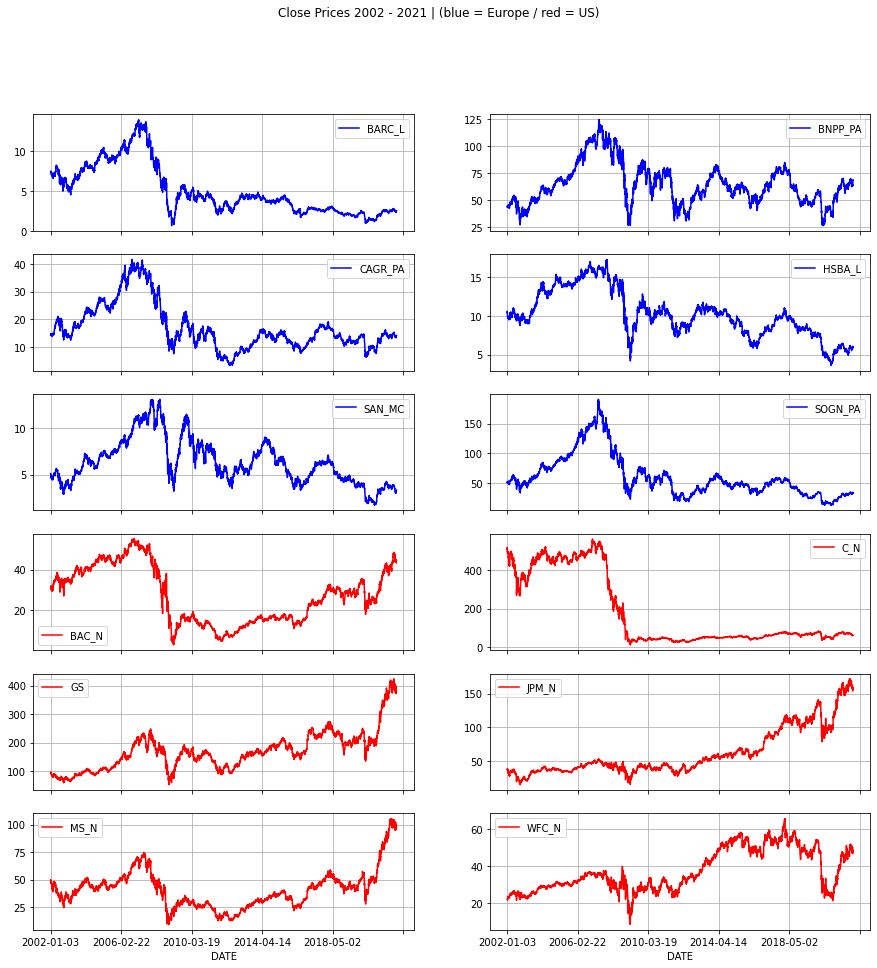

In [31]:
#creating subplots to get a first view on the stock prices (graphs)
df_database_indexed_stock.plot(kind='line', subplots=True, grid=True, title="Close Prices 2002 - 2021 | (blue = Europe / red = US)",
        layout=(6, 2), figsize=(15,15),sharex=True, sharey=False, legend=True,    
        style=['b', 'b', 'b', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'r'])
plt.savefig(r'C:\Users\kolle\Desktop\Zwischen\Close_Prices_2002_2021')

In [32]:
#creating variables for the absolute price change of each element and dropping NA's (first line because of lag)
df_database_indexed_stock_abs = pd.DataFrame()
df_database_indexed_stock_abs['BARC_L']= df_database_indexed_stock['BARC_L']-df_database_indexed_stock['BARC_L'].shift(periods = 1)
df_database_indexed_stock_abs['BNPP_PA']= df_database_indexed_stock['BNPP_PA']-df_database_indexed_stock['BNPP_PA'].shift(periods = 1)
df_database_indexed_stock_abs['CAGR_PA']= df_database_indexed_stock['CAGR_PA']-df_database_indexed_stock['CAGR_PA'].shift(periods = 1)
df_database_indexed_stock_abs['HSBA_L']= df_database_indexed_stock['HSBA_L']-df_database_indexed_stock['HSBA_L'].shift(periods = 1)
df_database_indexed_stock_abs['SAN_MC']= df_database_indexed_stock['SAN_MC']-df_database_indexed_stock['SAN_MC'].shift(periods = 1)
df_database_indexed_stock_abs['SOGN_PA']= df_database_indexed_stock['SOGN_PA']-df_database_indexed_stock['SOGN_PA'].shift(periods = 1)
df_database_indexed_stock_abs['BAC_N']= df_database_indexed_stock['BAC_N']-df_database_indexed_stock['BAC_N'].shift(periods = 1)
df_database_indexed_stock_abs['C_N']= df_database_indexed_stock['C_N']-df_database_indexed_stock['C_N'].shift(periods = 1)
df_database_indexed_stock_abs['GS']= df_database_indexed_stock['GS']-df_database_indexed_stock['GS'].shift(periods = 1)
df_database_indexed_stock_abs['JPM_N']= df_database_indexed_stock['JPM_N']-df_database_indexed_stock['JPM_N'].shift(periods = 1)
df_database_indexed_stock_abs['MS_N']= df_database_indexed_stock['MS_N']-df_database_indexed_stock['MS_N'].shift(periods = 1)
df_database_indexed_stock_abs['WFC_N']= df_database_indexed_stock['WFC_N']-df_database_indexed_stock['WFC_N'].shift(periods = 1)
df_database_indexed_stock_abs.dropna(inplace=True)
df_database_indexed_stock_abs

BARC_L   BNPP_PA   CAGR_PA    HSBA_L    SAN_MC   SOGN_PA  BAC_N  \
DATE                                                                            
2002-01-04  0.084136  0.125457 -0.104085  0.155129  0.006346  1.362754  0.490   
2002-01-07 -0.123277 -0.198075  0.372082 -0.146435 -0.230759 -1.498484 -0.380   
2002-01-08 -0.033952  0.066139  0.250771 -0.115109  0.072000  0.409762 -0.520   
2002-01-09  0.074346  0.862011 -0.028252 -0.245310 -0.057024  0.178098 -0.060   
2002-01-10  0.046342 -0.214857 -0.240887 -0.112764 -0.158746 -0.353434  0.025   
...              ...       ...       ...       ...       ...       ...    ...   
2021-12-21  0.085437  2.798267  0.323201  0.070721  0.065956  0.874599  1.030   
2021-12-22  0.036358  0.796283  0.138257  0.028883  0.016625  0.481800  0.090   
2021-12-23  0.031317  0.759920  0.217838  0.069131  0.098540  0.453498  0.140   
2021-12-29  0.030214  0.926033  0.170202  0.056987  0.029649  0.564808  0.210   
2021-12-30 -0.004428 -0.197408  0.009272 -0.007197  0.013059 -0.115488 -0.100   

              C_N    GS  JPM_N      MS_N  WFC_N  
DATE                                             
2002-01-04   9.50  4.30   1.68  2.357731  0.055  
2002-01-07  -5.70 -1.00  -0.10 -0.376234  0.035  
2002-01-08 -19.30 -3.25  -0.30 -1.053454 -0.085  
2002-01-09   2.90  1.25   0.11  0.384594 -0.110  
2002-01-10   0.60 -0.75   0.43  0.468202  0.040  
...           ...   ...    ...       ...    ...  
2021-12-21   1.10  8.71   2.15  2.400000  0.960  
2021-12-22   0.22  2.01   0.61  0.530000  0.220  
2021-12-23   0.61  2.71   0.56  1.040000  0.330  
2021-12-29   0.33  1.16   1.30 -0.610000  0.090  
2021-12-30  -0.11 -0.68  -0.08  0.070000 -0.350  

[4905 rows x 12 columns]

In [33]:
#creating variables for the relative price change of each element and dropping NA's (first line because of lag)
df_database_indexed_stock_rel = pd.DataFrame()
df_database_indexed_stock_rel['BARC_L']= df_database_indexed['BARC_L'].pct_change()
df_database_indexed_stock_rel['BNPP_PA']= df_database_indexed['BNPP_PA'].pct_change()
df_database_indexed_stock_rel['CAGR_PA']= df_database_indexed['CAGR_PA'].pct_change()
df_database_indexed_stock_rel['HSBA_L']= df_database_indexed['HSBA_L'].pct_change()
df_database_indexed_stock_rel['SAN_MC']= df_database_indexed['SAN_MC'].pct_change()
df_database_indexed_stock_rel['SOGN_PA']= df_database_indexed['SOGN_PA'].pct_change()
df_database_indexed_stock_rel['BAC_N']= df_database_indexed['BAC_N'].pct_change()
df_database_indexed_stock_rel['C_N']= df_database_indexed['C_N'].pct_change()
df_database_indexed_stock_rel['GS']= df_database_indexed['GS'].pct_change()
df_database_indexed_stock_rel['JPM_N']= df_database_indexed['JPM_N'].pct_change()
df_database_indexed_stock_rel['MS_N']= df_database_indexed['MS_N'].pct_change()
df_database_indexed_stock_rel['WFC_N']= df_database_indexed['WFC_N'].pct_change()
df_database_indexed_stock_rel.dropna(inplace=True)
df_database_indexed_stock_rel

BARC_L   BNPP_PA   CAGR_PA    HSBA_L    SAN_MC   SOGN_PA  \
DATE                                                                     
2002-01-04  0.011369  0.002856 -0.007246  0.014896  0.001243  0.026870   
2002-01-07 -0.016471 -0.004497  0.026093 -0.013855 -0.045154 -0.028773   
2002-01-08 -0.004612  0.001508  0.017138 -0.011044  0.014755  0.008101   
2002-01-09  0.010147  0.019629 -0.001898 -0.023798 -0.011516  0.003493   
2002-01-10  0.006261 -0.004798 -0.016216 -0.011206 -0.032432 -0.006907   
...              ...       ...       ...       ...       ...       ...   
2021-12-21  0.036221  0.043989  0.024097  0.012120  0.021237  0.027347   
2021-12-22  0.014875  0.011990  0.010065  0.004891  0.005242  0.014664   
2021-12-23  0.012625  0.011307  0.015701  0.011649  0.030907  0.013603   
2021-12-29  0.012028  0.013625  0.012078  0.009492  0.009021  0.016715   
2021-12-30 -0.001742 -0.002865  0.000650 -0.001187  0.003938 -0.003361   

               BAC_N       C_N        GS     JPM_N      MS_N     WFC_N  
DATE                                                                    
2002-01-04  0.015583  0.018609  0.046512  0.045016  0.049630  0.002523  
2002-01-07 -0.011899 -0.010962 -0.010336 -0.002564 -0.007545  0.001601  
2002-01-08 -0.016479 -0.037527 -0.033943 -0.007712 -0.021287 -0.003883  
2002-01-09 -0.001933  0.005859  0.013514  0.002850  0.007941 -0.005045  
2002-01-10  0.000807  0.001205 -0.008000  0.011108  0.009591  0.001844  
...              ...       ...       ...       ...       ...       ...  
2021-12-21  0.023865  0.018874  0.023439  0.013966  0.025165  0.020491  
2021-12-22  0.002037  0.003705  0.005285  0.003908  0.005421  0.004602  
2021-12-23  0.003162  0.010235  0.007088  0.003574  0.010580  0.006871  
2021-12-29  0.004728  0.005481  0.003013  0.008267 -0.006141  0.001861  
2021-12-30 -0.002241 -0.001817 -0.001761 -0.000505  0.000709 -0.007224  

[4905 rows x 12 columns]

In [34]:
#defining list of price columns
price_list = df_database_indexed_stock.columns.tolist()
price_list

['BARC_L',
 'BNPP_PA',
 'CAGR_PA',
 'HSBA_L',
 'SAN_MC',
 'SOGN_PA',
 'BAC_N',
 'C_N',
 'GS',
 'JPM_N',
 'MS_N',
 'WFC_N']

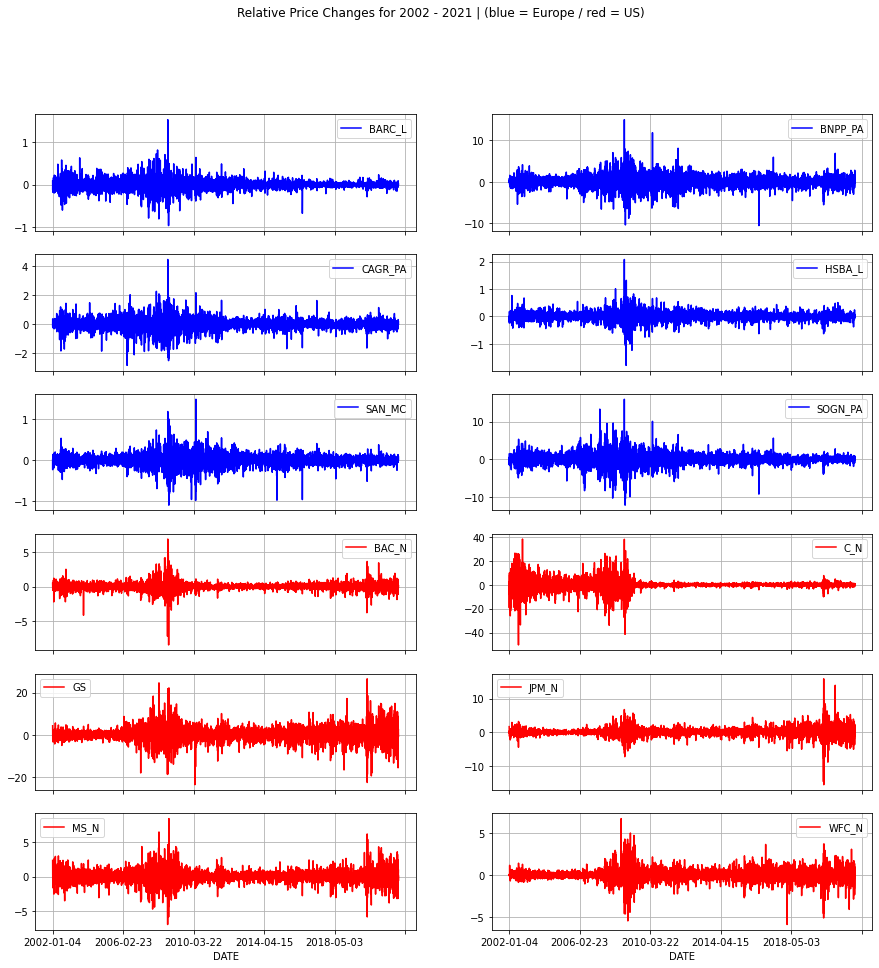

In [35]:
#creating subplots for the absolute price changes to get a first view on the graphs
df_database_indexed_stock_abs.plot(kind='line', subplots=True, grid=True, title="Relative Price Changes for 2002 - 2021 | (blue = Europe / red = US)",
        layout=(6, 2), figsize=(15,15),sharex=True, sharey=False, legend=True,    
        style=['b', 'b', 'b', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'r'])
plt.savefig(r'C:\Users\kolle\Desktop\Zwischen\Relative_Price_Changes_2002_2021')

BARC_L


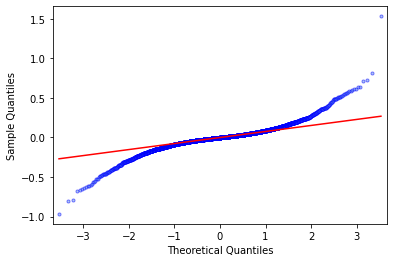

BNPP_PA


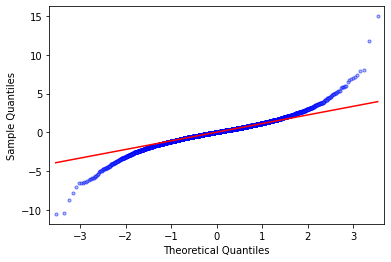

CAGR_PA


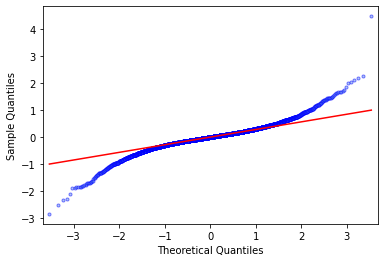

HSBA_L


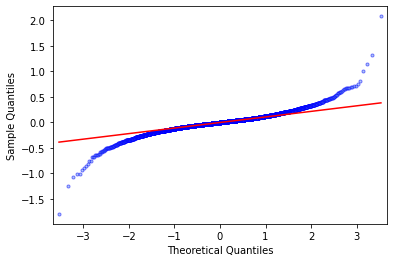

SAN_MC


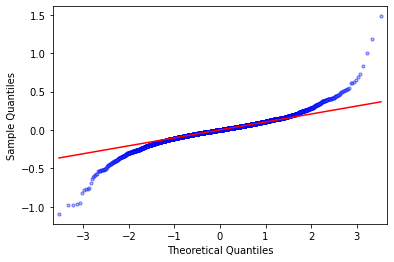

SOGN_PA


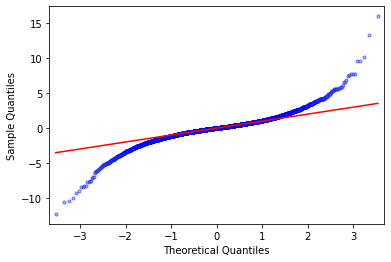

BAC_N


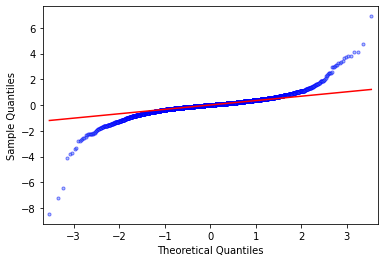

C_N


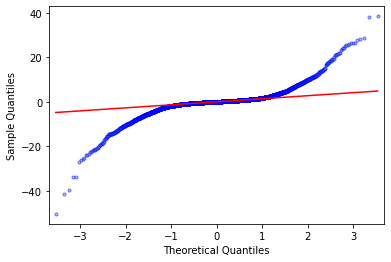

GS


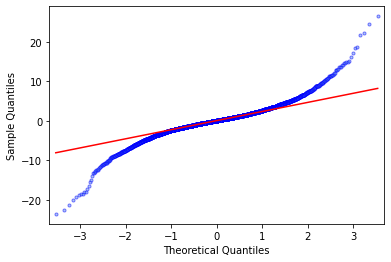

JPM_N


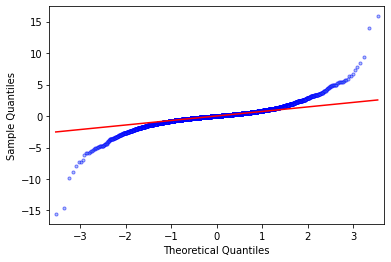

MS_N


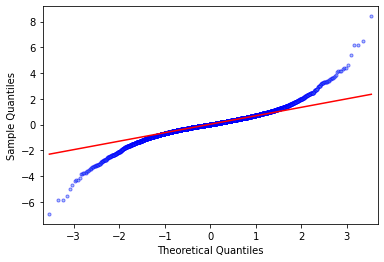

WFC_N


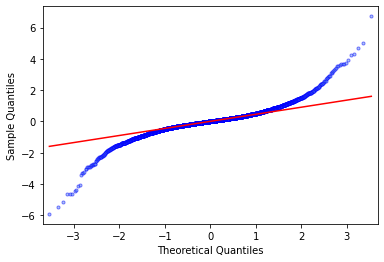

In [36]:
#plotting absolute price changes in a qq plot to check for normality
for i in price_list:
    sm.qqplot(df_database_indexed_stock_abs[i], line='q',
        marker='.',
        markerfacecolor='cornflowerblue',
        alpha=0.5)    
          
    print(i)
    #saving all plots in a dedicated folder as a jpg
    qq_name = r'C:\Users\kolle\Desktop\Zwischen\QQ\{}_QQ.jpg'.format(i)
    plt.savefig(qq_name) #save as jpg
    pylab.show()

In [37]:
# Shapiro-Wilk Test for relative price changes
for i in price_list:
    stat, p = shapiro(df_database_indexed_stock_rel[i])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print(i)
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print(i)
        print('Sample does not look Gaussian (reject H0)')

Statistics=0.794, p=0.000
BARC_L
Sample does not look Gaussian (reject H0)
Statistics=0.903, p=0.000
BNPP_PA
Sample does not look Gaussian (reject H0)
Statistics=0.919, p=0.000
CAGR_PA
Sample does not look Gaussian (reject H0)
Statistics=0.881, p=0.000
HSBA_L
Sample does not look Gaussian (reject H0)
Statistics=0.924, p=0.000
SAN_MC
Sample does not look Gaussian (reject H0)
Statistics=0.907, p=0.000
SOGN_PA
Sample does not look Gaussian (reject H0)
Statistics=0.746, p=0.000
BAC_N
Sample does not look Gaussian (reject H0)
Statistics=0.725, p=0.000
C_N
Sample does not look Gaussian (reject H0)
Statistics=0.869, p=0.000
GS
Sample does not look Gaussian (reject H0)
Statistics=0.826, p=0.000
JPM_N
Sample does not look Gaussian (reject H0)
Statistics=0.731, p=0.000
MS_N
Sample does not look Gaussian (reject H0)
Statistics=0.762, p=0.000
WFC_N
Sample does not look Gaussian (reject H0)


In [38]:
#getting statistical overview for each column
df_database_indexed_stock_abs.describe()

BARC_L      BNPP_PA      CAGR_PA       HSBA_L       SAN_MC  \
count  4905.000000  4905.000000  4905.000000  4905.000000  4905.000000   
mean     -0.000991     0.005051    -0.000019    -0.000889    -0.000362   
std       0.128911     1.473941     0.409458     0.163136     0.142545   
min      -0.966072   -10.513508    -2.844347    -1.791588    -1.092030   
25%      -0.051604    -0.733486    -0.186811    -0.074328    -0.068002   
50%      -0.000893     0.027106     0.004376    -0.001109     0.000912   
75%       0.051065     0.767399     0.194579     0.072362     0.071379   
max       1.532467    14.955226     4.484125     2.079990     1.480895   

           SOGN_PA        BAC_N          C_N           GS        JPM_N  \
count  4905.000000  4905.000000  4905.000000  4905.000000  4905.000000   
mean     -0.003359     0.002668    -0.091757     0.059749     0.024701   
std       1.552546     0.591965     4.511194     3.417654     1.305178   
min     -12.208493    -8.450000   -50.400000   -23.570000   -15.550000   
25%      -0.648946    -0.220000    -0.940000    -1.490000    -0.470000   
50%       0.020033     0.010000     0.000000     0.060000     0.010000   
75%       0.689905     0.240000     0.900000     1.620000     0.500000   
max      15.944752     6.900000    38.400000    26.490000    15.860000   

              MS_N        WFC_N  
count  4905.000000  4905.000000  
mean      0.010458     0.005362  
std       0.943445     0.725665  
min      -6.950000    -5.910000  
25%      -0.420000    -0.300000  
50%       0.010000     0.005000  
75%       0.468202     0.310000  
max       8.420000     6.720000

In [39]:
#running Augmented Dicky Fuller test to get the p-values for each closed price column (level)
for lags in range(1,4):
    print('Number of lags used:',lags)
    print('ADF P-Val for Close Prices (Level)')
    for i in price_list:
        adf_library = adfuller(df_database_indexed_stock[i], maxlag=lags, regression='nc',autolag=None)
        adf_library_d = adfuller(np.diff(df_database_indexed_stock[i]), maxlag=lags, regression='nc',autolag=None)

        print(i,':',"%.2f" %  adf_library[1],)
               
    print('____________________________________________','\n')
    
for lags in range(1,4):
    
    print('ADF P-Val for Absolute Returns (1st Difference)')
    for i in price_list:
        adf_library = adfuller(df_database_indexed_stock[i], maxlag=lags, regression='nc',autolag=None)
        adf_library_d = adfuller(np.diff(df_database_indexed_stock[i]), maxlag=lags, regression='nc',autolag=None)

        print(i,':',"%.2f" %  adf_library_d[1],)
               
    print('____________________________________________','\n')

Number of lags used: 1
ADF P-Val for Close Prices (Level)
BARC_L : 0.20
BNPP_PA : 0.47
CAGR_PA : 0.39
HSBA_L : 0.36
SAN_MC : 0.35
SOGN_PA : 0.32
BAC_N : 0.59
C_N : 0.02
GS : 0.92
JPM_N : 0.96
MS_N : 0.83
WFC_N : 0.65
____________________________________________ 

Number of lags used: 2
ADF P-Val for Close Prices (Level)
BARC_L : 0.21
BNPP_PA : 0.47
CAGR_PA : 0.39
HSBA_L : 0.36
SAN_MC : 0.36
SOGN_PA : 0.33
BAC_N : 0.59
C_N : 0.03
GS : 0.92
JPM_N : 0.96
MS_N : 0.83
WFC_N : 0.65
____________________________________________ 

Number of lags used: 3
ADF P-Val for Close Prices (Level)
BARC_L : 0.21
BNPP_PA : 0.49
CAGR_PA : 0.39
HSBA_L : 0.37
SAN_MC : 0.37
SOGN_PA : 0.33
BAC_N : 0.60
C_N : 0.03
GS : 0.92
JPM_N : 0.96
MS_N : 0.85
WFC_N : 0.66
____________________________________________ 

ADF P-Val for Absolute Returns (1st Difference)
BARC_L : 0.00
BNPP_PA : 0.00
CAGR_PA : 0.00
HSBA_L : 0.00
SAN_MC : 0.00
SOGN_PA : 0.00
BAC_N : 0.00
C_N : 0.00
GS : 0.00
JPM_N : 0.00
MS_N : 0.00
WFC_N : 0.00
_

In [40]:
#defining OLS function
def OLS(y,x):

    #if const is not None: x['const']=1
        
    #Beta estimates [(X'X)^-1]X'Y
    x_xt= np.dot(x.T,x)         # multiply vector X with transposed vector X'
    x_x_inv=np.linalg.inv(x_xt)      # invert the matrix

    x_y= np.dot(x.T,y)                 # multiply transposed vector X' with Y
    est_betas= np.dot(x_x_inv,x_y)  # multiply (X'X)^-1 with X'Y
    est_Y=      np.dot(est_betas,x.T)  # multiply est_betas with X'
        
    nb_obs=x.shape[0]  
    rank=x.shape[1] #equals p = number of regressors 
    deg_freedom_residual=nb_obs-rank
    
    #Y estimate
    est_y = np.dot(x,est_betas)
    est_resid = y-est_y
    
    est_resid_2 = np.dot(est_resid.T,est_resid)
    
    est_sigma_2= est_resid_2 / nb_obs
    
    est_var_covar_beta = np.dot(x_x_inv,est_sigma_2)  #Variance-Covariance Matrix of Betas
        #var_beta_est = np.kron(x_x_inv,est_sigma_2) #???
    
    est_var_beta = np.diag(est_var_covar_beta)
    est_sd_beta=np.sqrt(est_var_beta)    # standard errors of beta
    t_stats= est_betas/est_sd_beta       # t-stats
    pvals = stats.t.sf(np.abs(t_stats), nb_obs-1)*2
  
    SST=np.var(y)*nb_obs
    SSR=est_resid_2
    R_2= 1-(SSR/SST)
    
    llf = (-0.5*nb_obs * np.log(2 * np.pi*est_sigma_2)) -(0.5*nb_obs*(1/np.log(est_sigma_2))*est_resid_2)
    
    OLS_results = {
        'Y': y,
        'est_Y': est_Y,
        'X': x,
        'est_betas': est_betas,
        'est_resid': est_resid,
        'nb_obs': nb_obs,
        'deg_freedom_residual': deg_freedom_residual,
        'est_sigma_2': est_sigma_2,
        'est_var_covar_beta': est_var_covar_beta,
        't_stats': t_stats,
        'pvals': pvals,
        'llf': llf,
        'nb_parms': rank,
        'R_2': R_2
    }
                                                          
    return OLS_results

In [41]:
#http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html
#import warnings
#warnings.simplefilter('ignore')
import statsmodels.api as sm

df_database_indexed_stock['Constant']= 1

x_list=price_list
y_list = price_list
max_lags=5
counter_total=1
counter_lib_ECMLib=1
counter_lib_ECMLib_n_Coded=1

print('Number of identified cointegrations using the ECM Library by asset: ')

for y_name in y_list: 
    
    y=df_database_indexed_stock[y_name]
    counter_lib_ECMLib_success_temp = 0
    counter_total_byasset=0
    lags_success=[]
    R2_success=[]
    
    for lags in range(0,max_lags,1):
    
        for i in x_list:
            
            if not y_name==i :
                counter_total=counter_total+1
                counter_total_byasset=counter_total_byasset+1
                
                x_nc=df_database_indexed_stock[i]
                x=df_database_indexed_stock[[i,'Constant']]
                
                if y.shape>x_nc.shape: 
                    temp=y.drop(y.index[0])
                    y=temp
                elif y.shape<x_nc.shape:
                    temp=x_nc.drop(x_nc.index[0])
                    d_i=temp
                if x_nc.shape != y.shape: print('Warning Data Problem: Y',y.shape, 'X:', x_nc.shape)
            
                #Step 1: Stationarity Tests for the Residual between Y  and other variables
                
                step1_myols=OLS(y,x)
                step1_est_resid = step1_myols['est_resid']
                
                #x_res=x_nc
                #x_res['res']=step1_est_resid

                #adf_coded=Augm_DF(step1_est_resid,lags)
                adf_library = adfuller(step1_est_resid, maxlag=lags, regression='nc',autolag=None)
                
                #Step 2
                #d_y=pd.DataFrame(np.diff(data[y_name])) 
                d_y=y.diff()[1:]
                d_i=x_nc.diff()[1:]
                #d_i=pd.concat(x_nc.diff()[1:],step1_est_resid[1:])
                #res=pd.DataFrame(step1_est_resid.shift(1))
                #d_i['res']=res[1:]
                
                d_i_res=pd.concat([x_nc.diff()[1:], step1_est_resid.shift(1)[1:]], axis=1)
                d_i_res.columns=[i,'est_res_1']
                
                if d_y.shape[0] != d_i_res.shape[0]: print('Warning Data Problem: dY',d_y.shape[0], 'dX_rres:', d_i_res.shape[0])
                
                #ECM = OLS(d_y,d_i_res) # self-coded
                ECM_results_lib = sm.tsa.stattools.coint(y,df_database_indexed_stock[i],trend='c',maxlag=lags) # library


                if ECM_results_lib[1]<0.1:
                    #print (counter_total,'. Regressing ',i,' on',y_name,'number of lags used:',lags,', No Constant''\n')

                    #print('ECM Statistics with constant, no trend (Cointegration Library)','\n','H0: No Cointegrating Relationship','\n','T-Statistic of unit-root test on residuals: ',"%.2f" % ECM_results_lib[0],'\n','P-value for the cointegrating relationship: ',"%.2f" % ECM_results_lib[1],'\n')
                    #print('--> Cointegration confirmed ',i,'and',y_name,'max lags: ',lags)
                    counter_lib_ECMLib=counter_lib_ECMLib+1
                    
                    OLS_results_lib = sm.OLS(d_y,d_i_res,hasconst=None).fit()
                    OLS_results_code = OLS(d_y,d_i_res)
                    
                    #print(OLS_results_lib.summary(),'\n')
                    counter_lib_ECMLib_success_temp = counter_lib_ECMLib_success_temp + 1
                    lags_success.append(lags)
                    R2_success.append(OLS_results_code['R_2'])
                
#                    if adf_library[1]<0.1: 
                        #print('Step 1: Residual proved stationary --> long-run relationship can exist')
                        #print('Residual stationarity test','\n','ADF Stat (Self-Coded) :',"%.2f" % adf_coded['t_stats'][0],'\n','ADF Stat (Standard ADF Library) :',"%.2f" % adf_library[0],'\n','ADF P-Val (Self-Coded) :', "%.2f" % adf_coded['ADF_pval'],'\n','ADF P-Val (Standard ADF Library) :',"%.2f" %  adf_library[1],'\n')
#                        if ECM['pvals'][0]<0.1:

                            #print('Step 2: Residual proved significant --> long-run relationship exists','\n')
                            #print('ECM (Self-Coded)','\n','ECM P-Val for (1-Alpha )', "%.3f" % ECM['pvals'][0],'\n')
 #                           counter_lib_ECMLib_n_Coded=counter_lib_ECMLib_n_Coded+1
                        #else: 
                            #print('Step 2: Residual proved non-significant --> long-run relationship does not exist','\n')

                    #else:
                        #print('Step 1: Residual proved non-stationary --> long-run relationship can not exist','\n')
                        #print('Residual stationarity test','\n','ADF Stat (Self-Coded) :',"%.2f" % adf_coded['t_stats'][0],'\n','ADF Stat (Standard ADF Library) :',"%.2f" % adf_library[0],'\n','ADF P-Val (Self-Coded) :', "%.2f" % adf_coded['ADF_pval'],'\n','ADF P-Val (Standard ADF Library) :',"%.2f" %  adf_library[1],'\n')
                    #print('______________________________________________________________________________________','\n')
            
    print(y_name,':',counter_lib_ECMLib_success_temp,'out of total',counter_total_byasset,'¦cointegration identified at ADF lags:'
          ,lags_success)
    
    
    
print('\n','total number of regressions conducted:',counter_total-1)
print('total number of identified cointegrations using only ECM Library:',counter_lib_ECMLib-1)
print('total number of identified cointegrations using both ECM Library and own code:',counter_lib_ECMLib_n_Coded-1)
                

Number of identified cointegrations using the ECM Library by asset: 
BARC_L : 18 out of total 55 ¦cointegration identified at ADF lags: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4]
BNPP_PA : 24 out of total 55 ¦cointegration identified at ADF lags: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]
CAGR_PA : 15 out of total 55 ¦cointegration identified at ADF lags: [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4]
HSBA_L : 9 out of total 55 ¦cointegration identified at ADF lags: [0, 0, 1, 1, 2, 2, 3, 3, 4]
SAN_MC : 0 out of total 55 ¦cointegration identified at ADF lags: []
SOGN_PA : 14 out of total 55 ¦cointegration identified at ADF lags: [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4]
BAC_N : 0 out of total 55 ¦cointegration identified at ADF lags: []
C_N : 10 out of total 55 ¦cointegration identified at ADF lags: [0, 0, 0, 1, 1, 1, 2, 2, 3, 4]
GS : 0 out of total 55 ¦cointegration identified at ADF lags: []
JPM_N : 0 out of total 55 ¦cointegration identified 

In [50]:
#exporting dataframe to CSV
df_database_indexed_stock_rel.to_csv('Event_data_full.csv', index=True)
print('Dataframe is written to CSV successfully!')

Dataframe is written to CSV successfully!


In [53]:
#Import Fama-French factors and Returns from a csv file to the Single Class parameters.
es.Single.import_returns('Event_data_full.csv') 
es.Single.import_FamaFrench('famafrench.csv') 

In [54]:
#creating an empty list and appending it with the results of an iteration that creates every possible solution of three categories (security_ticker, market_ticker and event_date)
import itertools

event_database = []

def iterate_values(S):
    keys, values = zip(*S.items())

    for row in itertools.product(*values):
        yield dict(zip(keys, row))

event_db = {"security_ticker": ['JPM_N','BAC_N','C_N','WFC_N','GS','MS_N','HSBA_L','BNPP_PA','CAGR_PA','SAN_MC','SOGN_PA','BARC_L'], "event_date": [np.datetime64( '2002-01-29'),
np.datetime64( '2002-03-19'),
np.datetime64( '2002-05-07'),
np.datetime64( '2002-06-25'),
np.datetime64( '2002-08-13'),
np.datetime64( '2002-09-24'),
np.datetime64( '2002-11-06'),
np.datetime64( '2002-12-10'),
np.datetime64( '2003-01-28'),
np.datetime64( '2003-03-18'),
np.datetime64( '2003-03-25'),
np.datetime64( '2003-04-01'),
np.datetime64( '2003-04-08'),
np.datetime64( '2003-04-16'),
np.datetime64( '2003-05-06'),
np.datetime64( '2003-06-24'),
np.datetime64( '2003-08-12'),
np.datetime64( '2003-09-15'),
np.datetime64( '2003-09-16'),
np.datetime64( '2003-10-28'),
np.datetime64( '2003-12-09'),
np.datetime64( '2004-01-27'),
np.datetime64( '2004-03-16'),
np.datetime64( '2004-05-04'),
np.datetime64( '2004-06-29'),
np.datetime64( '2004-08-10'),
np.datetime64( '2004-09-21'),
np.datetime64( '2004-11-10'),
np.datetime64( '2004-12-14'),
np.datetime64( '2005-02-01'),
np.datetime64( '2005-03-22'),
np.datetime64( '2005-05-03'),
np.datetime64( '2005-06-29'),
np.datetime64( '2005-08-09'),
np.datetime64( '2005-09-20'),
np.datetime64( '2005-11-01'),
np.datetime64( '2005-12-13'),
np.datetime64( '2006-01-31'),
np.datetime64( '2006-03-27'),
np.datetime64( '2006-05-10'),
np.datetime64( '2006-06-28'),
np.datetime64( '2006-08-08'),
np.datetime64( '2006-09-20'),
np.datetime64( '2006-10-24'),
np.datetime64( '2006-12-12'),
np.datetime64( '2007-01-30'),
np.datetime64( '2007-03-20'),
np.datetime64( '2007-05-09'),
np.datetime64( '2007-06-27'),
np.datetime64( '2007-08-07'),
np.datetime64( '2007-08-10'),
np.datetime64( '2007-08-16'),
np.datetime64( '2007-09-18'),
np.datetime64( '2007-10-30'),
np.datetime64( '2007-12-06'),
np.datetime64( '2007-12-11'),
np.datetime64( '2008-01-09'),
np.datetime64( '2008-01-21'),
np.datetime64( '2008-01-29'),
np.datetime64( '2008-03-10'),
np.datetime64( '2008-03-18'),
np.datetime64( '2008-04-29'),
np.datetime64( '2008-06-24'),
np.datetime64( '2008-07-24'),
np.datetime64( '2008-08-05'),
np.datetime64( '2008-09-16'),
np.datetime64( '2008-09-29'),
np.datetime64( '2008-10-07'),
np.datetime64( '2008-10-28'),
np.datetime64( '2008-12-15'),
np.datetime64( '2009-01-16'),
np.datetime64( '2009-01-27'),
np.datetime64( '2009-02-07'),
np.datetime64( '2009-03-17'),
np.datetime64( '2009-04-28'),
np.datetime64( '2009-06-03'),
np.datetime64( '2009-06-23'),
np.datetime64( '2009-08-11'),
np.datetime64( '2009-09-22'),
np.datetime64( '2009-11-03'),
np.datetime64( '2009-12-15'),
np.datetime64( '2010-01-26'),
np.datetime64( '2010-03-16'),
np.datetime64( '2010-04-27'),
np.datetime64( '2010-05-09'),
np.datetime64( '2010-06-22'),
np.datetime64( '2010-08-10'),
np.datetime64( '2010-09-21'),
np.datetime64( '2010-10-15'),
np.datetime64( '2010-11-02'),
np.datetime64( '2010-12-14'),
np.datetime64( '2011-01-25'),
np.datetime64( '2011-03-15'),
np.datetime64( '2011-04-26'),
np.datetime64( '2011-06-21'),
np.datetime64( '2011-08-01'),
np.datetime64( '2011-08-09'),
np.datetime64( '2011-09-20'),
np.datetime64( '2011-11-01'),
np.datetime64( '2011-11-28'),
np.datetime64( '2011-12-13'),
np.datetime64( '2012-01-24'),
np.datetime64( '2012-03-13'),
np.datetime64( '2012-04-24'),
np.datetime64( '2012-06-19'),
np.datetime64( '2012-07-31'),
np.datetime64( '2012-09-12'),
np.datetime64( '2012-10-23'),
np.datetime64( '2012-12-11'),
np.datetime64( '2013-01-29'),
np.datetime64( '2013-03-19'),
np.datetime64( '2013-04-30'),
np.datetime64( '2013-06-18'),
np.datetime64( '2013-07-30'),
np.datetime64( '2013-09-17'),
np.datetime64( '2013-10-16'),
np.datetime64( '2013-10-29'),
np.datetime64( '2013-12-17'),
np.datetime64( '2014-01-28'),
np.datetime64( '2014-03-04'),
np.datetime64( '2014-03-18'),
np.datetime64( '2014-04-29'),
np.datetime64( '2014-06-17'),
np.datetime64( '2014-07-29'),
np.datetime64( '2014-09-16'),
np.datetime64( '2014-10-28'),
np.datetime64( '2014-12-16'),
np.datetime64( '2015-01-27'),
np.datetime64( '2015-03-17'),
np.datetime64( '2015-04-28'),
np.datetime64( '2015-06-16'),
np.datetime64( '2015-07-28'),
np.datetime64( '2015-09-16'),
np.datetime64( '2015-10-27'),
np.datetime64( '2015-12-15')]}

for d in iterate_values(event_db):
       event_database.append(d)
event_database
    

[{'security_ticker': 'JPM_N', 'event_date': numpy.datetime64('2002-01-29')},
 {'security_ticker': 'JPM_N', 'event_date': numpy.datetime64('2002-03-19')},
 {'security_ticker': 'JPM_N', 'event_date': numpy.datetime64('2002-05-07')},
 {'security_ticker': 'JPM_N', 'event_date': numpy.datetime64('2002-06-25')},
 {'security_ticker': 'JPM_N', 'event_date': numpy.datetime64('2002-08-13')},
 {'security_ticker': 'JPM_N', 'event_date': numpy.datetime64('2002-09-24')},
 {'security_ticker': 'JPM_N', 'event_date': numpy.datetime64('2002-11-06')},
 {'security_ticker': 'JPM_N', 'event_date': numpy.datetime64('2002-12-10')},
 {'security_ticker': 'JPM_N', 'event_date': numpy.datetime64('2003-01-28')},
 {'security_ticker': 'JPM_N', 'event_date': numpy.datetime64('2003-03-18')},
 {'security_ticker': 'JPM_N', 'event_date': numpy.datetime64('2003-03-25')},
 {'security_ticker': 'JPM_N', 'event_date': numpy.datetime64('2003-04-01')},
 {'security_ticker': 'JPM_N', 'event_date': numpy.datetime64('2003-04-08')},

In [55]:
#using the event study (formula for each element of the tickers list (event window: +-5 / estimation size: 50)
tickers = ['JPM_N','BAC_N','C_N','WFC_N','GS','MS_N','HSBA_L','BNPP_PA','CAGR_PA','SAN_MC','SOGN_PA','BARC_L']
releases_5_50 = dict()

for ticker in tickers:
    events = [event for event in event_database if event['security_ticker']==ticker]
    
    releases_5_50[ticker] = es.Multiple.from_list(
        events,
        es.Single.FamaFrench_3factor,
        event_window= (-5,+5),
        estimation_size = 50)

2022-05-29 12:31:57,140 P[5368] [MainThread 14260]  3 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:31:57,293 P[5368] [MainThread 14260]  3 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:31:57,418 P[5368] [MainThread 14260]  3 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:31:57,538 P[5368] [MainThread 14260]  3 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:31:57,673 P[5368] [MainThread 14260]  3 events have not been processed due

JPM_N


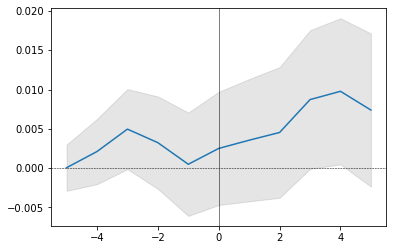

<bound method Multiple.results of <eventstudy.multiple.Multiple object at 0x000001C9FD431250>>

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.000     0.002    13.559     0.860 -0.214        -0.014        -0.001   
-4  0.002     0.002     8.930     1.473 -0.167        -0.015        -0.003   
-3  0.005     0.003    13.699     2.052 -0.200        -0.020         0.000   
-2  0.003     0.004    12.731     1.613 -0.295        -0.022         0.000   
-1  0.000     0.006    11.305     0.632 -0.391        -0.031        -0.003   
0   0.002     0.006     8.022     1.269 -0.262        -0.027        -0.002   
1   0.004     0.008     9.067     1.366 -0.316        -0.027        -0.005   
2   0.005     0.006     7.958     1.334 -0.272        -0.024        -0.003   
3   0.009     0.007     4.589     1.511 -0.163        -0.032         0.001   
4   0.010     0.009    11.959     2.503 -0.168        -0.036         0.001   
5   0.007     0.008     7.270     1.747 -0.181        -0.035        -0.002   

    Quantile 75%    Max  
-5         0.008  0.218  
-4         0.014  0.222  
-3         0.021  0.360  
-2         0.019  0.387  
-1         0.025  0.361  
0          0.026  0.437  
1          0.029  0.507  
2          0.026  0.455  
3          0.033  0.391  
4          0.036  0.596  
5          0.037  0.500

BAC_N


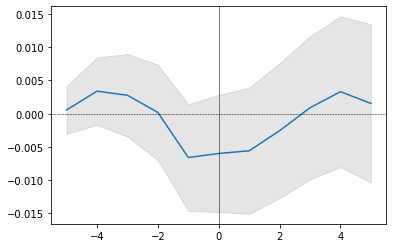

<bound method Multiple.results of <eventstudy.multiple.Multiple object at 0x000001C9FB721A00>>

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.001     0.002    16.255     0.135 -0.294        -0.011        -0.003   
-4  0.003     0.003     8.352     1.099 -0.189        -0.011        -0.002   
-3  0.003     0.005    10.725     1.199 -0.290        -0.020        -0.002   
-2  0.000     0.008    13.162     1.669 -0.348        -0.022        -0.002   
-1 -0.007     0.011    13.327     1.117 -0.443        -0.033        -0.008   
0  -0.006     0.011    10.448     0.090 -0.524        -0.033        -0.003   
1  -0.006     0.016    18.224    -0.803 -0.828        -0.035        -0.007   
2  -0.003     0.014    12.520     0.199 -0.589        -0.037        -0.004   
3   0.001     0.017    11.763     0.462 -0.650        -0.040        -0.010   
4   0.003     0.020    15.549     2.522 -0.538        -0.044        -0.012   
5   0.002     0.021    16.039     2.486 -0.552        -0.047        -0.009   

    Quantile 75%    Max  
-5         0.006  0.237  
-4         0.016  0.290  
-3         0.020  0.402  
-2         0.017  0.516  
-1         0.017  0.579  
0          0.022  0.475  
1          0.029  0.668  
2          0.031  0.636  
3          0.032  0.600  
4          0.031  0.809  
5          0.036  0.901

C_N


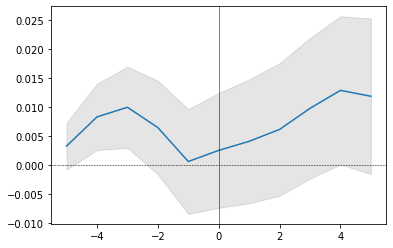

<bound method Multiple.results of <eventstudy.multiple.Multiple object at 0x000001C9FB7213A0>>

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.003     0.002    13.055     2.025 -0.188        -0.011        -0.000   
-4  0.008     0.004     9.286     1.864 -0.214        -0.015        -0.000   
-3  0.010     0.005     8.353     1.778 -0.241        -0.020         0.002   
-2  0.006     0.008    10.391     0.997 -0.363        -0.022         0.002   
-1  0.001     0.014    17.057     1.709 -0.489        -0.034        -0.004   
0   0.003     0.014    20.030     1.877 -0.554        -0.035         0.002   
1   0.004     0.020    22.270     1.529 -0.756        -0.035         0.001   
2   0.006     0.017    18.485     2.361 -0.418        -0.040         0.004   
3   0.010     0.019    17.587     2.107 -0.566        -0.034         0.004   
4   0.013     0.021    20.714     3.246 -0.430        -0.045         0.002   
5   0.012     0.022    19.019     3.032 -0.446        -0.045         0.001   

    Quantile 75%    Max  
-5         0.009  0.291  
-4         0.016  0.344  
-3         0.025  0.400  
-2         0.028  0.468  
-1         0.027  0.766  
0          0.027  0.832  
1          0.035  0.994  
2          0.038  0.911  
3          0.046  0.943  
4          0.038  1.052  
5          0.044  1.043

WFC_N


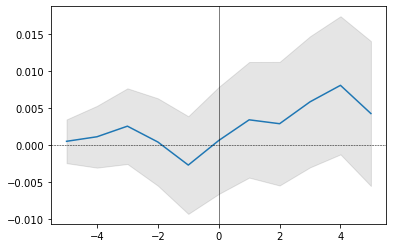

<bound method Multiple.results of <eventstudy.multiple.Multiple object at 0x000001C9FD3011F0>>

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.001     0.001    20.142    -1.247 -0.251        -0.007        -0.001   
-4  0.001     0.001     7.613     0.957 -0.134        -0.008        -0.001   
-3  0.003     0.003    15.741     2.645 -0.147        -0.012         0.001   
-2  0.000     0.004    13.833     2.340 -0.188        -0.019         0.002   
-1 -0.003     0.004     9.684     1.151 -0.243        -0.018        -0.001   
0   0.001     0.005     9.747     0.876 -0.315        -0.022         0.001   
1   0.003     0.009    18.330     0.348 -0.563        -0.023        -0.003   
2   0.003     0.008    11.696     0.846 -0.385        -0.029        -0.001   
3   0.006     0.010    14.019     1.076 -0.441        -0.026        -0.001   
4   0.008     0.012    22.827     3.103 -0.429        -0.025         0.001   
5   0.004     0.012    18.597     2.094 -0.454        -0.030        -0.001   

    Quantile 75%    Max  
-5         0.007  0.171  
-4         0.010  0.168  
-3         0.014  0.311  
-2         0.017  0.380  
-1         0.014  0.332  
0          0.021  0.361  
1          0.021  0.519  
2          0.027  0.452  
3          0.027  0.594  
4          0.028  0.795  
5          0.031  0.744

GS


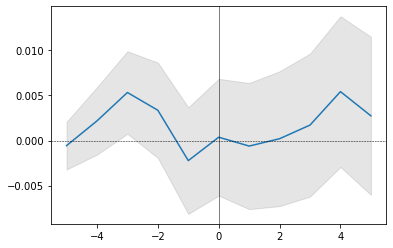

<bound method Multiple.results of <eventstudy.multiple.Multiple object at 0x000001C9FD1E41F0>>

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5 -0.001     0.001    12.861    -1.067 -0.201        -0.015        -0.001   
-4  0.002     0.001     5.292     1.272 -0.107        -0.017        -0.001   
-3  0.005     0.002     4.445     0.560 -0.186        -0.020         0.003   
-2  0.003     0.004     5.966     0.266 -0.280        -0.028         0.003   
-1 -0.002     0.005     9.096    -0.640 -0.388        -0.033         0.001   
0   0.000     0.005     4.760    -0.460 -0.348        -0.036         0.001   
1  -0.001     0.007     4.592    -0.648 -0.374        -0.042         0.004   
2   0.000     0.008     5.631    -0.972 -0.445        -0.046        -0.000   
3   0.002     0.008     3.659    -0.412 -0.430        -0.051         0.003   
4   0.005     0.008     2.271     0.401 -0.309        -0.049         0.003   
5   0.003     0.007     1.422     0.428 -0.281        -0.050         0.001   

    Quantile 75%    Max  
-5         0.013  0.136  
-4         0.015  0.165  
-3         0.023  0.206  
-2         0.027  0.257  
-1         0.029  0.291  
0          0.033  0.241  
1          0.039  0.244  
2          0.039  0.233  
3          0.044  0.248  
4          0.040  0.281  
5          0.034  0.258

MS_N


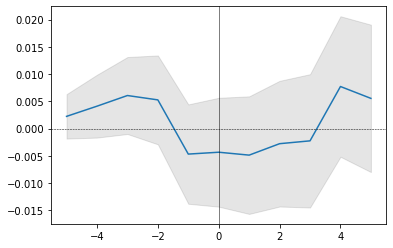

<bound method Multiple.results of <eventstudy.multiple.Multiple object at 0x000001C9FD2A2160>>

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.002     0.002    11.278     1.008 -0.200        -0.014         0.001   
-4  0.004     0.003     8.464     1.813 -0.145        -0.018         0.000   
-3  0.006     0.004     5.325     0.741 -0.204        -0.019         0.000   
-2  0.005     0.007     5.832     0.603 -0.324        -0.025         0.000   
-1 -0.005     0.009    10.133    -0.883 -0.544        -0.032        -0.003   
0  -0.004     0.009     3.287    -0.606 -0.368        -0.036        -0.004   
1  -0.005     0.013     7.194    -1.080 -0.598        -0.043        -0.001   
2  -0.003     0.012     8.396    -1.540 -0.570        -0.044         0.002   
3  -0.002     0.015    13.557    -1.986 -0.800        -0.052         0.001   
4   0.008     0.011     2.122     0.362 -0.370        -0.047         0.004   
5   0.006     0.012     1.723     0.560 -0.339        -0.053        -0.005   

    Quantile 75%    Max  
-5         0.013  0.211  
-4         0.018  0.253  
-3         0.024  0.318  
-2         0.031  0.362  
-1         0.034  0.389  
0          0.042  0.263  
1          0.046  0.405  
2          0.045  0.311  
3          0.052  0.311  
4          0.049  0.321  
5          0.050  0.358

HSBA_L


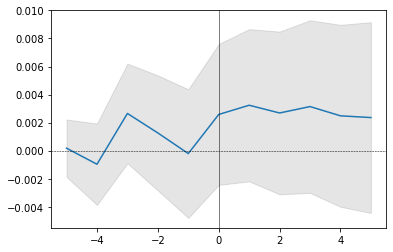

<bound method Multiple.results of <eventstudy.multiple.Multiple object at 0x000001C9FD2C3A90>>

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.000     0.001    18.739    -0.041 -0.148        -0.009        -0.001   
-4 -0.001     0.001     4.767     0.626 -0.087        -0.013        -0.002   
-3  0.003     0.001     3.867     1.205 -0.069        -0.013        -0.003   
-2  0.001     0.002     8.870     0.396 -0.218        -0.016        -0.004   
-1 -0.000     0.003    14.319     0.671 -0.280        -0.019        -0.007   
0   0.003     0.003    15.329     1.437 -0.244        -0.021        -0.002   
1   0.003     0.003    14.344     0.622 -0.308        -0.025         0.000   
2   0.003     0.003    16.564     2.207 -0.230        -0.025        -0.002   
3   0.003     0.004     9.671     1.684 -0.212        -0.030        -0.001   
4   0.002     0.005    18.645     2.973 -0.227        -0.032        -0.003   
5   0.002     0.005    16.332     2.987 -0.159        -0.036        -0.002   

    Quantile 75%    Max  
-5         0.008  0.145  
-4         0.009  0.098  
-3         0.015  0.149  
-2         0.016  0.231  
-1         0.019  0.316  
0          0.022  0.367  
1          0.024  0.349  
2          0.024  0.406  
3          0.025  0.357  
4          0.025  0.495  
5          0.027  0.444

BNPP_PA


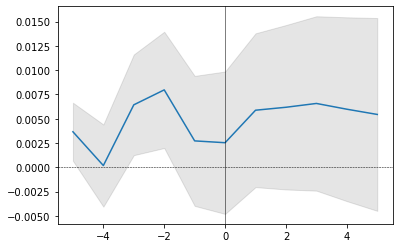

<bound method Multiple.results of <eventstudy.multiple.Multiple object at 0x000001C9FD2710D0>>

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.004     0.001    12.904     0.410 -0.201        -0.010         0.000   
-4  0.000     0.002     8.846     1.456 -0.176        -0.019        -0.002   
-3  0.006     0.003     6.657     1.351 -0.208        -0.023         0.000   
-2  0.008     0.005     6.464     0.912 -0.280        -0.023         0.002   
-1  0.003     0.006     9.615     1.806 -0.200        -0.037        -0.001   
0   0.003     0.006     9.815     1.592 -0.211        -0.036         0.000   
1   0.006     0.007     9.927     1.053 -0.359        -0.029         0.002   
2   0.006     0.007    14.034     1.917 -0.320        -0.036         0.006   
3   0.007     0.009    10.174     1.502 -0.351        -0.040        -0.001   
4   0.006     0.011    12.352     1.751 -0.415        -0.043        -0.001   
5   0.005     0.011     8.121     1.902 -0.217        -0.054        -0.008   

    Quantile 75%    Max  
-5         0.014  0.200  
-4         0.015  0.251  
-3         0.028  0.306  
-2         0.034  0.352  
-1         0.028  0.457  
0          0.039  0.464  
1          0.036  0.502  
2          0.034  0.573  
3          0.045  0.563  
4          0.046  0.645  
5          0.048  0.595

CAGR_PA


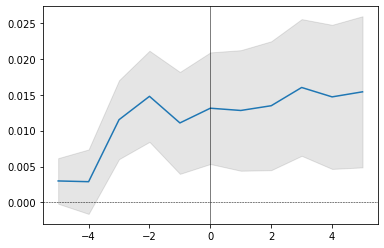

<bound method Multiple.results of <eventstudy.multiple.Multiple object at 0x000001C9FD75A910>>

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.003     0.001     7.894     0.692 -0.173        -0.012        -0.000   
-4  0.003     0.002     4.718     1.395 -0.101        -0.026        -0.002   
-3  0.012     0.004     4.259     1.552 -0.110        -0.018        -0.001   
-2  0.015     0.005     3.537     1.399 -0.147        -0.027         0.002   
-1  0.011     0.007     4.255     1.358 -0.195        -0.032         0.005   
0   0.013     0.007     2.616     0.908 -0.175        -0.030         0.008   
1   0.013     0.009     2.667     0.902 -0.194        -0.036         0.007   
2   0.013     0.010     3.489     1.014 -0.215        -0.039         0.006   
3   0.016     0.011     3.029     0.975 -0.230        -0.043         0.008   
4   0.015     0.013     3.213     0.940 -0.232        -0.038         0.011   
5   0.015     0.014     2.512     0.815 -0.246        -0.045         0.006   

    Quantile 75%    Max  
-5         0.011  0.157  
-4         0.023  0.235  
-3         0.031  0.294  
-2         0.040  0.329  
-1         0.045  0.380  
0          0.050  0.336  
1          0.053  0.388  
2          0.054  0.470  
3          0.064  0.483  
4          0.071  0.536  
5          0.070  0.535

SAN_MC


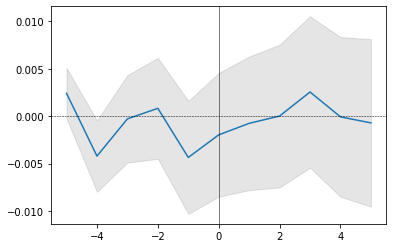

<bound method Multiple.results of <eventstudy.multiple.Multiple object at 0x000001C981884190>>

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.002     0.001     7.398    -0.030 -0.141        -0.010         0.001   
-4 -0.004     0.001     3.303     0.598 -0.120        -0.021        -0.006   
-3 -0.000     0.002     2.985     0.584 -0.169        -0.022        -0.005   
-2  0.001     0.004     3.917    -0.108 -0.287        -0.028        -0.008   
-1 -0.004     0.005     4.258     0.030 -0.327        -0.033        -0.011   
0  -0.002     0.006     4.926    -0.318 -0.366        -0.031        -0.004   
1  -0.001     0.006     2.818     0.337 -0.246        -0.033        -0.001   
2   0.000     0.007     3.793     0.922 -0.222        -0.040        -0.007   
3   0.003     0.008     2.655     0.817 -0.216        -0.042        -0.008   
4  -0.000     0.009     2.750     0.929 -0.202        -0.045        -0.011   
5  -0.001     0.010     2.024     0.922 -0.196        -0.058        -0.010   

    Quantile 75%    Max  
-5         0.012  0.116  
-4         0.013  0.161  
-3         0.018  0.202  
-2         0.030  0.241  
-1         0.023  0.288  
0          0.030  0.289  
1          0.034  0.331  
2          0.032  0.374  
3          0.040  0.378  
4          0.046  0.413  
5          0.051  0.409

SOGN_PA


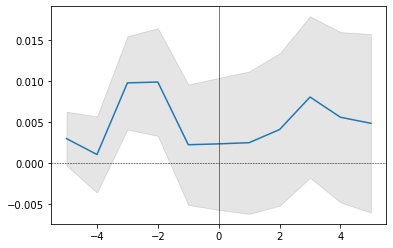

<bound method Multiple.results of <eventstudy.multiple.Multiple object at 0x000001C9817B1130>>

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.003     0.002    13.744    -0.753 -0.257        -0.013         0.001   
-4  0.001     0.002     3.136     1.207 -0.126        -0.022        -0.006   
-3  0.010     0.005     4.041     1.742 -0.116        -0.030        -0.006   
-2  0.010     0.007     2.915     1.270 -0.180        -0.036        -0.004   
-1  0.002     0.008     3.842     1.337 -0.204        -0.049        -0.003   
0   0.002     0.009     3.418     1.004 -0.232        -0.042        -0.004   
1   0.002     0.010     4.791     0.875 -0.362        -0.045        -0.000   
2   0.004     0.011     5.294     1.379 -0.222        -0.054        -0.002   
3   0.008     0.013     4.379     1.184 -0.265        -0.056        -0.002   
4   0.006     0.015     5.438     1.399 -0.256        -0.058        -0.002   
5   0.005     0.016     3.561     1.266 -0.273        -0.077        -0.016   

    Quantile 75%    Max  
-5         0.013  0.166  
-4         0.015  0.211  
-3         0.034  0.298  
-2         0.033  0.308  
-1         0.032  0.353  
0          0.045  0.400  
1          0.042  0.473  
2          0.035  0.532  
3          0.046  0.557  
4          0.052  0.637  
5          0.042  0.599

BARC_L


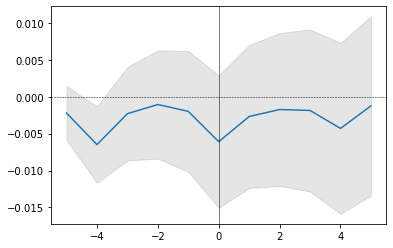

<bound method Multiple.results of <eventstudy.multiple.Multiple object at 0x000001C981FA01F0>>

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5 -0.002     0.002    22.622    -2.412 -0.319        -0.017        -0.002   
-4 -0.006     0.004    14.073    -0.931 -0.385        -0.025        -0.008   
-3 -0.002     0.006    15.342    -1.403 -0.511        -0.034        -0.003   
-2 -0.001     0.009    15.014    -1.787 -0.630        -0.038        -0.004   
-1 -0.002     0.009    10.125     1.830 -0.273        -0.045        -0.012   
0  -0.006     0.012     8.590     0.619 -0.508        -0.053        -0.010   
1  -0.003     0.017    15.344    -0.410 -0.823        -0.053        -0.010   
2  -0.002     0.022    17.256     0.245 -0.878        -0.063        -0.010   
3  -0.002     0.027    14.284    -0.652 -0.997        -0.062        -0.012   
4  -0.004     0.031    18.683    -0.259 -1.107        -0.076        -0.014   
5  -0.001     0.022    15.349     2.596 -0.337        -0.080        -0.018   

    Quantile 75%    Max  
-5         0.010  0.148  
-4         0.012  0.255  
-3         0.022  0.268  
-2         0.038  0.297  
-1         0.035  0.546  
0          0.039  0.577  
1          0.044  0.661  
2          0.047  0.884  
3          0.056  0.838  
4          0.057  1.021  
5          0.055  1.021

In [56]:
for ticker, event in releases_5_50.items():
    print(ticker)
    event.plot()
    plt.show()
    display(event.results)
    display(event.get_CAR_dist())

In [57]:
#using the event study (formula for each element of the tickers list (event window: +-5 / estimation size: 100)
tickers = ['JPM_N','BAC_N','C_N','WFC_N','GS','MS_N','HSBA_L','BNPP_PA','CAGR_PA','SAN_MC','SOGN_PA','BARC_L']
releases_5_100 = dict()

for ticker in tickers:
    events = [event for event in event_database if event['security_ticker']==ticker]
    
    releases_5_100[ticker] = es.Multiple.from_list(
        events,
        es.Single.FamaFrench_3factor,
        event_window= (-5,+5),
        estimation_size = 100)

2022-05-29 12:32:16,421 P[5368] [MainThread 14260]  4 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:32:16,606 P[5368] [MainThread 14260]  4 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:32:16,788 P[5368] [MainThread 14260]  4 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:32:16,959 P[5368] [MainThread 14260]  4 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:32:17,135 P[5368] [MainThread 14260]  4 events have not been processed due

JPM_N


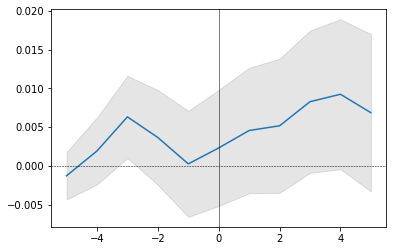

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5 -0.001        0.002  -0.001         0.002  -0.533    0.594
-4  0.003        0.002   0.002         0.003   0.572    0.567
-3  0.004        0.002   0.006         0.004   1.530    0.126
-2 -0.003        0.002   0.004         0.005   0.767    0.443
-1 -0.003        0.002     0.0         0.005   0.049    0.961
0   0.002        0.002   0.002         0.006   0.396    0.692
1   0.002        0.002   0.005         0.006   0.724    0.469
2   0.001        0.002   0.005         0.007   0.766    0.443
3   0.003        0.002   0.008         0.007   1.157    0.247
4   0.001        0.002   0.009         0.008   1.224    0.221
5  -0.002        0.002   0.007         0.008   0.866    0.386

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5 -0.001     0.001    12.074     0.525 -0.196        -0.015        -0.002   
-4  0.002     0.002     8.693     1.616 -0.142        -0.015        -0.004   
-3  0.006     0.003    17.259     2.751 -0.147        -0.016         0.001   
-2  0.004     0.003    15.076     2.334 -0.187        -0.026        -0.002   
-1  0.000     0.004     8.914     1.102 -0.248        -0.029        -0.004   
0   0.002     0.005    12.128     1.932 -0.161        -0.027        -0.000   
1   0.005     0.007    12.447     1.653 -0.321        -0.029        -0.001   
2   0.005     0.005    10.022     1.853 -0.205        -0.030        -0.003   
3   0.008     0.006     4.591     1.433 -0.166        -0.039        -0.002   
4   0.009     0.007    16.922     3.048 -0.149        -0.038        -0.001   
5   0.007     0.007    10.206     2.183 -0.157        -0.038        -0.003   

    Quantile 75%    Max  
-5         0.007  0.197  
-4         0.015  0.236  
-3         0.022  0.372  
-2         0.020  0.396  
-1         0.023  0.357  
0          0.025  0.446  
1          0.029  0.507  
2          0.026  0.449  
3          0.029  0.379  
4          0.033  0.599  
5          0.032  0.505

BAC_N


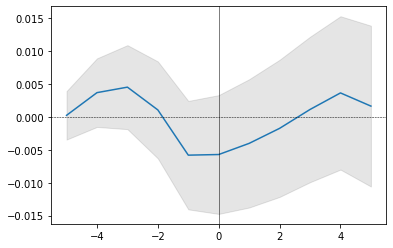

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5  0.000        0.003     0.0         0.003   0.085    0.933
-4  0.003        0.003   0.004         0.004   0.908    0.364
-3  0.001        0.003   0.005         0.005   0.909    0.363
-2 -0.003        0.003   0.001         0.006   0.185    0.853
-1 -0.007        0.003  -0.006         0.006  -0.903    0.366
0   0.000        0.003  -0.006         0.007  -0.811    0.417
1   0.002        0.003  -0.004         0.008  -0.528    0.598
2   0.002        0.003  -0.002         0.008  -0.213    0.831
3   0.003        0.003   0.001         0.009   0.132    0.895
4   0.003        0.003   0.004         0.009   0.401    0.688
5  -0.002        0.003   0.002         0.010   0.173    0.863

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.000     0.002    15.673     0.551 -0.285        -0.014        -0.004   
-4  0.004     0.003     8.737     1.484 -0.200        -0.015        -0.003   
-3  0.005     0.006    14.724     1.621 -0.315        -0.020        -0.002   
-2  0.001     0.007    12.250     1.775 -0.283        -0.026        -0.002   
-1 -0.006     0.009    13.113     1.239 -0.433        -0.033        -0.006   
0  -0.006     0.010    14.748     0.304 -0.562        -0.029        -0.004   
1  -0.004     0.016    23.920    -0.398 -0.850        -0.031        -0.006   
2  -0.002     0.013    15.919     0.737 -0.547        -0.038        -0.007   
3   0.001     0.016    12.939     0.194 -0.699        -0.036        -0.009   
4   0.004     0.020    17.655     2.459 -0.607        -0.046        -0.010   
5   0.002     0.021    15.967     2.085 -0.635        -0.046        -0.008   

    Quantile 75%    Max  
-5         0.007  0.252  
-4         0.017  0.282  
-3         0.023  0.478  
-2         0.021  0.471  
-1         0.019  0.541  
0          0.020  0.564  
1          0.027  0.784  
2          0.031  0.718  
3          0.030  0.623  
4          0.032  0.860  
5          0.033  0.824

C_N


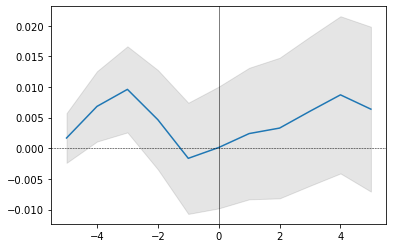

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5  0.002        0.003   0.002         0.003   0.530    0.596
-4  0.005        0.003   0.007         0.004   1.527    0.127
-3  0.003        0.003  0.01 *         0.005   1.754    0.079
-2 -0.005        0.003   0.005         0.006   0.737    0.461
-1 -0.006        0.003  -0.002         0.007  -0.232    0.817
0   0.002        0.003     0.0         0.008   0.017    0.987
1   0.002        0.003   0.002         0.008   0.287    0.774
2   0.001        0.003   0.003         0.009   0.369    0.712
3   0.003        0.003   0.006         0.009   0.637    0.524
4   0.003        0.003   0.009         0.010   0.871    0.384
5  -0.002        0.003   0.006         0.010   0.608    0.543

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.002     0.002    19.777     2.708 -0.188        -0.014        -0.004   
-4  0.007     0.004    13.101     2.302 -0.217        -0.018        -0.001   
-3  0.010     0.005    13.459     2.571 -0.172        -0.022         0.002   
-2  0.005     0.007    14.268     1.457 -0.383        -0.026        -0.002   
-1 -0.002     0.013    25.914     2.496 -0.521        -0.037        -0.005   
0   0.000     0.014    30.273     2.641 -0.596        -0.037        -0.002   
1   0.002     0.021    31.939     2.360 -0.789        -0.038        -0.001   
2   0.003     0.017    28.109     3.179 -0.472        -0.042        -0.000   
3   0.006     0.019    25.672     2.677 -0.620        -0.046         0.003   
4   0.009     0.022    30.423     4.029 -0.498        -0.045        -0.001   
5   0.006     0.023    27.887     3.672 -0.528        -0.045         0.001   

    Quantile 75%    Max  
-5         0.008  0.342  
-4         0.019  0.404  
-3         0.024  0.476  
-2         0.028  0.546  
-1         0.024  0.854  
0          0.024  0.928  
1          0.025  1.127  
2          0.030  1.008  
3          0.040  1.032  
4          0.035  1.189  
5          0.037  1.171

WFC_N


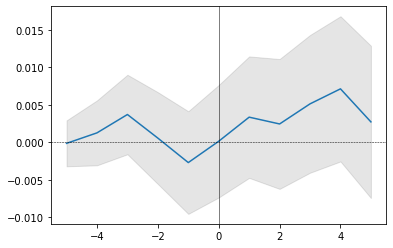

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5 -0.000        0.002    -0.0         0.002  -0.063    0.950
-4  0.001        0.002   0.001         0.003   0.370    0.712
-3  0.002        0.002   0.004         0.004   0.893    0.372
-2 -0.003        0.002   0.001         0.005   0.115    0.908
-1 -0.003        0.002  -0.003         0.005  -0.508    0.611
0   0.003        0.002     0.0         0.006   0.022    0.982
1   0.003        0.002   0.003         0.006   0.529    0.597
2  -0.001        0.002   0.002         0.007   0.360    0.719
3   0.003        0.002   0.005         0.007   0.714    0.475
4   0.002        0.002   0.007         0.008   0.942    0.346
5  -0.004        0.002   0.003         0.008   0.342    0.732

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5 -0.000     0.001    17.380    -0.637 -0.231        -0.009        -0.001   
-4  0.001     0.001     7.378     1.226 -0.131        -0.010        -0.001   
-3  0.004     0.003    18.107     3.008 -0.127        -0.013         0.001   
-2  0.001     0.003    14.082     2.391 -0.173        -0.021         0.001   
-1 -0.003     0.003    10.966     1.507 -0.231        -0.020        -0.002   
0   0.000     0.004    12.190     1.070 -0.309        -0.023        -0.001   
1   0.003     0.007    23.929     0.553 -0.539        -0.025        -0.004   
2   0.002     0.006    13.396     0.986 -0.378        -0.026        -0.004   
3   0.005     0.007    13.200     0.847 -0.427        -0.024        -0.003   
4   0.007     0.010    22.538     2.944 -0.425        -0.022        -0.000   
5   0.003     0.010    17.017     1.531 -0.455        -0.027        -0.001   

    Quantile 75%    Max  
-5         0.006  0.165  
-4         0.012  0.171  
-3         0.015  0.337  
-2         0.017  0.337  
-1         0.014  0.321  
0          0.018  0.386  
1          0.022  0.556  
2          0.023  0.459  
3          0.024  0.478  
4          0.030  0.669  
5          0.027  0.604

GS


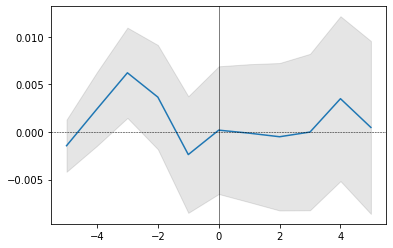

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-5 -0.001        0.002   -0.001         0.002  -0.672    0.501
-4  0.004        0.002    0.002         0.003   0.801    0.423
-3  0.004        0.002  0.006 *         0.004   1.681    0.093
-2 -0.003        0.002    0.004         0.004   0.858    0.391
-1 -0.006        0.002   -0.002         0.005  -0.496    0.620
0   0.003        0.002      0.0         0.005   0.038    0.970
1  -0.000        0.002     -0.0         0.006  -0.021    0.983
2  -0.000        0.002     -0.0         0.006  -0.082    0.935
3   0.000        0.002     -0.0         0.006  -0.000    1.000
4   0.004        0.002    0.004         0.007   0.519    0.604
5  -0.003        0.002      0.0         0.007   0.068    0.946

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5 -0.001     0.001    10.551    -0.436 -0.184        -0.016        -0.002   
-4  0.002     0.001     9.751     2.094 -0.077        -0.016        -0.002   
-3  0.006     0.002     8.727     1.665 -0.138        -0.017         0.001   
-2  0.004     0.003     5.778     0.883 -0.220        -0.026         0.002   
-1 -0.002     0.004     5.291    -0.170 -0.309        -0.037        -0.004   
0   0.000     0.005     4.573     0.175 -0.292        -0.041         0.000   
1  -0.000     0.007     6.604    -0.026 -0.376        -0.042         0.003   
2  -0.000     0.008     6.423    -0.670 -0.450        -0.047         0.000   
3  -0.000     0.008     3.481    -0.157 -0.399        -0.052        -0.001   
4   0.004     0.009     5.261     0.876 -0.319        -0.044        -0.003   
5   0.000     0.008     5.011     1.030 -0.289        -0.051        -0.002   

    Quantile 75%    Max  
-5         0.012  0.145  
-4         0.017  0.232  
-3         0.021  0.284  
-2         0.026  0.303  
-1         0.027  0.258  
0          0.030  0.311  
1          0.037  0.383  
2          0.039  0.328  
3          0.051  0.315  
4          0.043  0.456  
5          0.032  0.445

MS_N


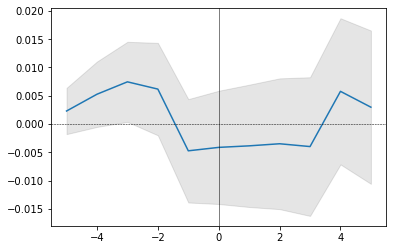

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5  0.002        0.003   0.002         0.003   0.722    0.470
-4  0.003        0.003   0.005         0.005   1.169    0.243
-3  0.002        0.003   0.007         0.006   1.351    0.177
-2 -0.001        0.003   0.006         0.006   0.968    0.333
-1 -0.011        0.003  -0.005         0.007  -0.664    0.507
0   0.001        0.003  -0.004         0.008  -0.528    0.597
1   0.000        0.003  -0.004         0.008  -0.457    0.648
2   0.000        0.003  -0.003         0.009  -0.387    0.699
3  -0.000        0.003  -0.004         0.010  -0.416    0.677
4   0.010        0.003   0.006         0.010   0.573    0.567
5  -0.003        0.003   0.003         0.011   0.281    0.778

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.002     0.002    11.955     1.943 -0.159        -0.016        -0.000   
-4  0.005     0.003    11.718     2.443 -0.134        -0.019         0.001   
-3  0.007     0.004     8.961     1.703 -0.179        -0.020         0.002   
-2  0.006     0.007     7.254     1.503 -0.218        -0.029        -0.000   
-1 -0.005     0.008     5.326     0.238 -0.391        -0.041        -0.008   
0  -0.004     0.009     4.706     0.197 -0.383        -0.041        -0.005   
1  -0.004     0.013     8.864    -0.573 -0.628        -0.042        -0.007   
2  -0.003     0.013     9.324    -1.352 -0.601        -0.048         0.002   
3  -0.004     0.015    11.870    -1.601 -0.771        -0.050        -0.001   
4   0.006     0.012     3.548     0.779 -0.403        -0.046        -0.006   
5   0.003     0.013     2.550     0.731 -0.376        -0.053        -0.005   

    Quantile 75%    Max  
-5         0.012  0.253  
-4         0.020  0.336  
-3         0.026  0.398  
-2         0.029  0.446  
-1         0.032  0.362  
0          0.041  0.377  
1          0.045  0.433  
2          0.044  0.364  
3          0.048  0.366  
4          0.050  0.421  
5          0.044  0.443

HSBA_L


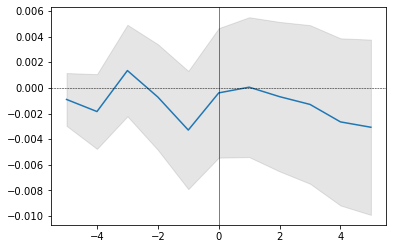

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5 -0.001        0.002  -0.001         0.002  -0.561    0.575
-4 -0.001        0.002  -0.002         0.002  -0.812    0.417
-3  0.003        0.002   0.001         0.003   0.485    0.628
-2 -0.002        0.002  -0.001         0.003  -0.223    0.824
-1 -0.003        0.002  -0.003         0.004  -0.915    0.360
0   0.003        0.002    -0.0         0.004  -0.099    0.921
1   0.000        0.002     0.0         0.004   0.013    0.990
2  -0.001        0.002  -0.001         0.005  -0.151    0.880
3  -0.001        0.002  -0.001         0.005  -0.268    0.789
4  -0.001        0.002  -0.003         0.005  -0.522    0.602
5  -0.000        0.002  -0.003         0.005  -0.576    0.565

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5 -0.001     0.001    18.592    -0.287 -0.145        -0.009        -0.001   
-4 -0.002     0.001     3.676     0.037 -0.098        -0.013        -0.001   
-3  0.001     0.001     2.720     0.912 -0.080        -0.016        -0.001   
-2 -0.001     0.002     9.257    -0.188 -0.234        -0.021        -0.004   
-1 -0.003     0.003    14.549    -0.093 -0.300        -0.024        -0.006   
0  -0.000     0.003    13.891     0.868 -0.253        -0.022        -0.002   
1   0.000     0.003    12.945    -0.150 -0.325        -0.025        -0.000   
2  -0.001     0.003    13.233     1.512 -0.256        -0.030        -0.006   
3  -0.001     0.004     7.807     1.185 -0.239        -0.032        -0.006   
4  -0.003     0.005    15.094     2.317 -0.260        -0.032        -0.006   
5  -0.003     0.005    13.728     2.539 -0.197        -0.036        -0.010   

    Quantile 75%    Max  
-5         0.007  0.138  
-4         0.008  0.087  
-3         0.012  0.130  
-2         0.016  0.208  
-1         0.016  0.290  
0          0.022  0.334  
1          0.020  0.309  
2          0.022  0.364  
3          0.027  0.312  
4          0.019  0.443  
5          0.020  0.391

BNPP_PA


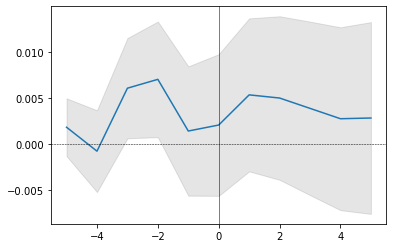

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5  0.002        0.002   0.002         0.002   0.753    0.451
-4 -0.003        0.002  -0.001         0.003  -0.218    0.828
-3  0.007        0.002   0.006         0.004   1.434    0.152
-2  0.001        0.002   0.007         0.005   1.438    0.151
-1 -0.006        0.002   0.001         0.005   0.262    0.794
0   0.001        0.002   0.002         0.006   0.348    0.728
1   0.003        0.002   0.005         0.006   0.827    0.408
2  -0.000        0.002   0.005         0.007   0.724    0.469
3  -0.001        0.002   0.004         0.007   0.530    0.596
4  -0.001        0.002   0.003         0.008   0.357    0.721
5   0.000        0.002   0.003         0.008   0.350    0.726

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.002     0.001    14.501     0.380 -0.206        -0.012        -0.000   
-4 -0.001     0.002     9.073     1.268 -0.183        -0.021        -0.001   
-3  0.006     0.003     6.722     1.225 -0.218        -0.024        -0.002   
-2  0.007     0.005     6.912     0.691 -0.293        -0.023        -0.002   
-1  0.001     0.005    10.523     1.859 -0.182        -0.033        -0.007   
0   0.002     0.005     9.889     1.467 -0.223        -0.032         0.001   
1   0.005     0.007    10.286     0.748 -0.382        -0.029         0.005   
2   0.005     0.007    13.606     1.491 -0.356        -0.031         0.001   
3   0.004     0.008     9.756     1.135 -0.388        -0.031        -0.003   
4   0.003     0.010    12.218     1.272 -0.460        -0.038        -0.002   
5   0.003     0.010     7.708     1.625 -0.270        -0.047        -0.001   

    Quantile 75%    Max  
-5         0.014  0.208  
-4         0.016  0.255  
-3         0.027  0.306  
-2         0.034  0.346  
-1         0.027  0.447  
0          0.033  0.450  
1          0.033  0.487  
2          0.033  0.543  
3          0.038  0.524  
4          0.038  0.614  
5          0.035  0.558

CAGR_PA


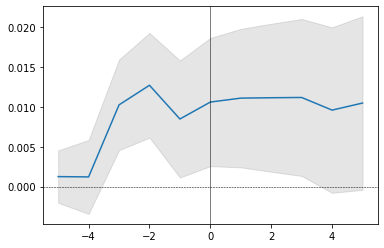

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-5  0.001        0.003     0.001         0.003   0.489    0.625
-4 -0.000        0.003     0.001         0.004   0.335    0.737
-3  0.009        0.003   0.01 **         0.004   2.310    0.021
-2  0.002        0.003  0.013 **         0.005   2.481    0.013
-1 -0.004        0.003     0.008         0.006   1.480    0.139
0   0.002        0.003   0.011 *         0.006   1.690    0.091
1   0.000        0.003     0.011         0.007   1.637    0.102
2   0.000        0.003     0.011         0.007   1.538    0.124
3   0.000        0.003     0.011         0.008   1.455    0.146
4  -0.002        0.003      0.01         0.008   1.184    0.236
5   0.001        0.003      0.01         0.009   1.233    0.217

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.001     0.001     7.210     0.404 -0.165        -0.016        -0.001   
-4  0.001     0.002     1.965     0.880 -0.102        -0.022        -0.002   
-3  0.010     0.004     4.004     1.415 -0.122        -0.021         0.001   
-2  0.013     0.005     3.472     1.247 -0.150        -0.026         0.006   
-1  0.008     0.005     4.008     1.217 -0.184        -0.029         0.003   
0   0.011     0.006     3.998     1.024 -0.171        -0.030         0.007   
1   0.011     0.008     3.828     0.825 -0.223        -0.030         0.007   
2   0.011     0.009     5.379     1.118 -0.228        -0.028         0.008   
3   0.011     0.010     4.743     1.032 -0.272        -0.034         0.006   
4   0.010     0.012     5.537     1.128 -0.265        -0.042         0.015   
5   0.010     0.013     4.630     0.985 -0.305        -0.039         0.014   

    Quantile 75%    Max  
-5         0.012  0.143  
-4         0.018  0.151  
-3         0.034  0.273  
-2         0.035  0.303  
-1         0.039  0.327  
0          0.046  0.363  
1          0.047  0.420  
2          0.053  0.493  
3          0.056  0.502  
4          0.062  0.571  
5          0.057  0.567

SAN_MC


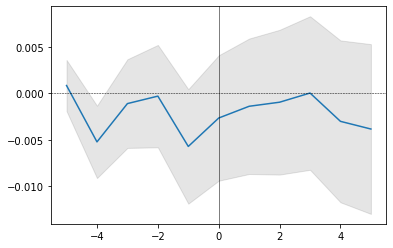

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-5  0.001        0.002     0.001         0.002   0.399    0.690
-4 -0.006        0.002  -0.005 *         0.003  -1.713    0.087
-3  0.004        0.002    -0.001         0.004  -0.292    0.770
-2  0.001        0.002      -0.0         0.004  -0.066    0.947
-1 -0.005        0.002    -0.006         0.005  -1.186    0.236
0   0.003        0.002    -0.003         0.005  -0.501    0.616
1   0.001        0.002    -0.001         0.006  -0.242    0.809
2   0.000        0.002    -0.001         0.006  -0.154    0.877
3   0.001        0.002       0.0         0.006   0.008    0.994
4  -0.003        0.002    -0.003         0.007  -0.441    0.659
5  -0.001        0.002    -0.004         0.007  -0.536    0.592

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.001     0.001     8.450     0.067 -0.138        -0.011         0.001   
-4 -0.005     0.001     4.196     0.509 -0.140        -0.025        -0.008   
-3 -0.001     0.002     3.921     0.519 -0.184        -0.023        -0.006   
-2 -0.000     0.004     5.684    -0.347 -0.308        -0.028        -0.008   
-1 -0.006     0.005     7.124    -0.263 -0.355        -0.033        -0.008   
0  -0.003     0.005     6.404    -0.359 -0.369        -0.030        -0.003   
1  -0.001     0.006     3.423     0.390 -0.253        -0.036        -0.002   
2  -0.001     0.006     4.426     0.955 -0.234        -0.041        -0.005   
3   0.000     0.007     3.121     0.846 -0.235        -0.041        -0.008   
4  -0.003     0.008     3.186     0.928 -0.229        -0.051        -0.006   
5  -0.004     0.009     2.610     0.972 -0.204        -0.063        -0.011   

    Quantile 75%    Max  
-5         0.013  0.124  
-4         0.010  0.171  
-3         0.017  0.209  
-2         0.027  0.246  
-1         0.017  0.297  
0          0.022  0.296  
1          0.030  0.337  
2          0.029  0.374  
3          0.031  0.378  
4          0.035  0.420  
5          0.039  0.421

SOGN_PA


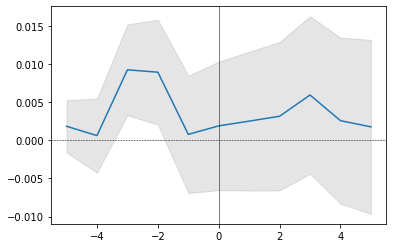

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-5  0.002        0.003     0.002         0.003   0.679    0.497
-4 -0.001        0.003     0.001         0.004   0.159    0.874
-3  0.009        0.003  0.009 **         0.005   1.984    0.047
-2 -0.000        0.003   0.009 *         0.005   1.660    0.097
-1 -0.008        0.003     0.001         0.006   0.127    0.899
0   0.001        0.003     0.002         0.007   0.285    0.775
1   0.001        0.003     0.002         0.007   0.352    0.725
2   0.001        0.003     0.003         0.008   0.413    0.679
3   0.003        0.003     0.006         0.008   0.736    0.462
4  -0.003        0.003     0.003         0.008   0.301    0.763
5  -0.001        0.003     0.002         0.009   0.196    0.844

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.002     0.002    14.750    -0.955 -0.259        -0.014         0.000   
-4  0.001     0.002     2.984     1.055 -0.137        -0.023        -0.006   
-3  0.009     0.005     3.892     1.620 -0.136        -0.027        -0.007   
-2  0.009     0.006     3.150     1.114 -0.190        -0.026        -0.002   
-1  0.001     0.008     5.099     1.321 -0.203        -0.042        -0.009   
0   0.002     0.009     5.410     1.060 -0.271        -0.044        -0.003   
1   0.002     0.011     6.883     0.751 -0.399        -0.036        -0.000   
2   0.003     0.011     7.846     1.370 -0.291        -0.041         0.001   
3   0.006     0.013     6.291     1.270 -0.271        -0.039         0.001   
4   0.003     0.016     7.174     1.356 -0.286        -0.041        -0.003   
5   0.002     0.016     5.353     1.172 -0.353        -0.060        -0.008   

    Quantile 75%    Max  
-5         0.012  0.156  
-4         0.015  0.194  
-3         0.028  0.261  
-2         0.038  0.311  
-1         0.028  0.408  
0          0.036  0.443  
1          0.037  0.535  
2          0.038  0.585  
3          0.045  0.605  
4          0.044  0.701  
5          0.044  0.651

BARC_L


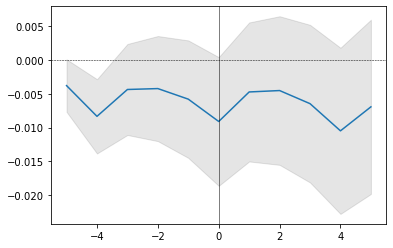

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-5 -0.004        0.003    -0.004         0.003  -1.260    0.208
-4 -0.005        0.003  -0.008 *         0.004  -1.952    0.051
-3  0.004        0.003    -0.004         0.005  -0.837    0.403
-2  0.000        0.003    -0.004         0.006  -0.703    0.482
-1 -0.002        0.003    -0.006         0.007  -0.859    0.390
0  -0.003        0.003    -0.009         0.007  -1.229    0.219
1   0.004        0.003    -0.005         0.008  -0.593    0.553
2   0.000        0.003    -0.005         0.009  -0.531    0.595
3  -0.002        0.003    -0.006         0.009  -0.714    0.475
4  -0.004        0.003     -0.01         0.010  -1.096    0.273
5   0.004        0.003    -0.007         0.010  -0.692    0.489

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5 -0.004     0.002    25.521    -3.034 -0.312        -0.017        -0.003   
-4 -0.008     0.003    15.495    -1.905 -0.397        -0.026        -0.009   
-3 -0.004     0.005    17.740    -2.030 -0.522        -0.034        -0.003   
-2 -0.004     0.009    17.156    -2.358 -0.654        -0.041        -0.004   
-1 -0.006     0.008    10.345     1.359 -0.302        -0.044        -0.010   
0  -0.009     0.011    10.559     0.215 -0.548        -0.051        -0.009   
1  -0.005     0.017    18.219    -0.718 -0.849        -0.052        -0.009   
2  -0.005     0.022    20.583    -0.098 -0.933        -0.064        -0.016   
3  -0.006     0.026    17.656    -0.923 -1.049        -0.063        -0.013   
4  -0.010     0.031    22.235    -0.646 -1.177        -0.073        -0.013   
5  -0.007     0.021    17.095     2.619 -0.422        -0.083        -0.021   

    Quantile 75%    Max  
-5         0.011  0.133  
-4         0.012  0.178  
-3         0.022  0.244  
-2         0.034  0.301  
-1         0.031  0.545  
0          0.031  0.573  
1          0.043  0.686  
2          0.044  0.884  
3          0.043  0.829  
4          0.051  1.014  
5          0.058  0.992

In [58]:
for ticker, event in releases_5_100.items():
    print(ticker)
    event.plot()
    plt.show()
    display(event.results())
    display(event.get_CAR_dist())

In [59]:
#using the event study (formula for each element of the tickers list (event window: +-5 / estimation size: 200)
tickers = ['JPM_N','BAC_N','C_N','WFC_N','GS','MS_N','HSBA_L','BNPP_PA','CAGR_PA','SAN_MC','SOGN_PA','BARC_L']
releases_5_200 = dict()

for ticker in tickers:
    events = [event for event in event_database if event['security_ticker']==ticker]
    
    releases_5_200[ticker] = es.Multiple.from_list(
        events,
        es.Single.FamaFrench_3factor,
        event_window= (-5,+5),
        estimation_size = 200)

2022-05-29 12:32:42,690 P[5368] [MainThread 14260]  8 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:32:42,896 P[5368] [MainThread 14260]  8 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:32:43,058 P[5368] [MainThread 14260]  8 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:32:43,235 P[5368] [MainThread 14260]  8 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:32:43,396 P[5368] [MainThread 14260]  8 events have not been processed due

JPM_N


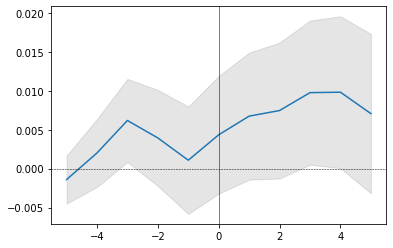

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5 -0.001        0.002  -0.001         0.002  -0.585    0.559
-4  0.003        0.002   0.002         0.003   0.591    0.554
-3  0.004        0.002   0.006         0.004   1.483    0.138
-2 -0.002        0.002   0.004         0.005   0.819    0.413
-1 -0.003        0.002   0.001         0.005   0.201    0.840
0   0.003        0.002   0.004         0.006   0.738    0.461
1   0.002        0.002   0.007         0.006   1.059    0.290
2   0.001        0.002   0.007         0.007   1.097    0.273
3   0.002        0.002    0.01         0.007   1.352    0.176
4   0.000        0.002    0.01         0.008   1.290    0.197
5  -0.003        0.002   0.007         0.008   0.885    0.376

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5 -0.001     0.001    11.997     0.656 -0.196        -0.015        -0.002   
-4  0.002     0.002     9.010     1.908 -0.126        -0.016        -0.004   
-3  0.006     0.003    20.010     3.197 -0.122        -0.017         0.003   
-2  0.004     0.003    16.254     2.641 -0.136        -0.027        -0.001   
-1  0.001     0.004     8.746     1.466 -0.181        -0.032        -0.001   
0   0.004     0.004    13.990     2.433 -0.123        -0.030        -0.000   
1   0.007     0.006    12.831     1.725 -0.314        -0.027         0.001   
2   0.007     0.005    10.614     2.228 -0.125        -0.037         0.001   
3   0.010     0.005     4.381     1.468 -0.128        -0.038         0.001   
4   0.010     0.007    17.065     2.987 -0.145        -0.037         0.001   
5   0.007     0.006    10.809     2.057 -0.192        -0.033        -0.001   

    Quantile 75%    Max  
-5         0.007  0.195  
-4         0.014  0.235  
-3         0.021  0.366  
-2         0.022  0.389  
-1         0.025  0.352  
0          0.027  0.438  
1          0.043  0.496  
2          0.029  0.439  
3          0.041  0.370  
4          0.035  0.588  
5          0.035  0.498

BAC_N


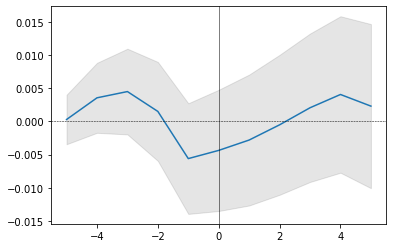

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5  0.000        0.003     0.0         0.003   0.095    0.924
-4  0.003        0.003   0.004         0.004   0.862    0.389
-3  0.001        0.003   0.004         0.005   0.891    0.373
-2 -0.003        0.003   0.001         0.006   0.257    0.797
-1 -0.007        0.003  -0.006         0.007  -0.863    0.388
0   0.001        0.003  -0.004         0.007  -0.614    0.539
1   0.002        0.003  -0.003         0.008  -0.366    0.715
2   0.002        0.003  -0.001         0.008  -0.064    0.949
3   0.003        0.003   0.002         0.009   0.235    0.814
4   0.002        0.003   0.004         0.009   0.440    0.660
5  -0.002        0.003   0.002         0.010   0.238    0.812

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.000     0.002    15.327     0.487 -0.281        -0.014        -0.003   
-4  0.004     0.003     8.166     1.516 -0.197        -0.017        -0.003   
-3  0.004     0.005    13.971     1.520 -0.309        -0.022         0.002   
-2  0.001     0.006    11.594     1.666 -0.278        -0.028        -0.002   
-1 -0.006     0.009    12.600     1.007 -0.425        -0.035        -0.005   
0  -0.004     0.009    15.457     0.147 -0.555        -0.035        -0.000   
1  -0.003     0.015    24.796    -0.766 -0.838        -0.038        -0.000   
2  -0.001     0.012    14.991     0.689 -0.535        -0.038        -0.003   
3   0.002     0.014    12.658    -0.099 -0.684        -0.036        -0.006   
4   0.004     0.017    15.962     2.103 -0.591        -0.045        -0.004   
5   0.002     0.018    14.162     1.595 -0.619        -0.049        -0.005   

    Quantile 75%    Max  
-5         0.006  0.243  
-4         0.016  0.270  
-3         0.021  0.452  
-2         0.022  0.440  
-1         0.020  0.508  
0          0.019  0.522  
1          0.026  0.729  
2          0.033  0.661  
3          0.033  0.564  
4          0.031  0.791  
5          0.032  0.714

C_N


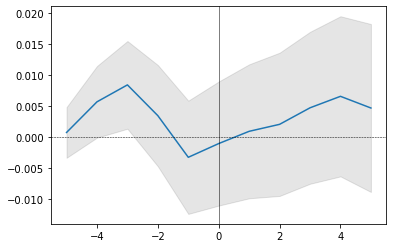

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5  0.001        0.003   0.001         0.003   0.227    0.821
-4  0.005        0.003   0.006         0.005   1.257    0.209
-3  0.003        0.003   0.008         0.006   1.521    0.128
-2 -0.005        0.003   0.003         0.006   0.538    0.590
-1 -0.007        0.003  -0.003         0.007  -0.460    0.645
0   0.002        0.003  -0.001         0.008  -0.136    0.891
1   0.002        0.003   0.001         0.008   0.108    0.914
2   0.001        0.003   0.002         0.009   0.226    0.821
3   0.003        0.003   0.005         0.010   0.492    0.623
4   0.002        0.003   0.007         0.010   0.650    0.515
5  -0.002        0.003   0.005         0.011   0.442    0.659

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.001     0.002    21.743     2.859 -0.187        -0.013        -0.003   
-4  0.006     0.004    14.049     2.390 -0.218        -0.019        -0.001   
-3  0.008     0.005    15.242     2.754 -0.157        -0.023         0.002   
-2  0.003     0.007    16.220     1.424 -0.385        -0.027         0.001   
-1 -0.003     0.013    27.130     2.470 -0.526        -0.037        -0.005   
0  -0.001     0.014    32.472     2.687 -0.604        -0.035        -0.007   
1   0.001     0.021    33.887     2.348 -0.796        -0.038        -0.004   
2   0.002     0.015    31.168     3.447 -0.483        -0.047        -0.000   
3   0.005     0.017    28.683     2.698 -0.631        -0.037        -0.003   
4   0.007     0.020    34.259     4.138 -0.511        -0.039        -0.001   
5   0.005     0.021    29.633     3.538 -0.543        -0.043         0.001   

    Quantile 75%    Max  
-5         0.007  0.344  
-4         0.015  0.405  
-3         0.025  0.472  
-2         0.026  0.539  
-1         0.022  0.848  
0          0.025  0.917  
1          0.033  1.117  
2          0.029  0.990  
3          0.043  1.011  
4          0.029  1.169  
5          0.032  1.150

WFC_N


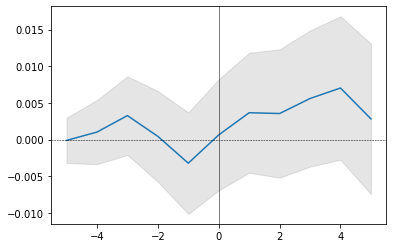

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5 -0.000        0.002    -0.0         0.002  -0.050    0.960
-4  0.001        0.002   0.001         0.003   0.297    0.766
-3  0.002        0.002   0.003         0.004   0.779    0.436
-2 -0.003        0.002     0.0         0.005   0.089    0.929
-1 -0.004        0.002  -0.003         0.005  -0.598    0.550
0   0.004        0.002   0.001         0.006   0.106    0.915
1   0.003        0.002   0.004         0.006   0.572    0.567
2  -0.000        0.002   0.004         0.007   0.519    0.604
3   0.002        0.002   0.006         0.007   0.772    0.440
4   0.001        0.002   0.007         0.008   0.920    0.358
5  -0.004        0.002   0.003         0.008   0.352    0.725

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5 -0.000     0.001    16.634    -0.872 -0.229        -0.008        -0.002   
-4  0.001     0.001     5.957     1.183 -0.117        -0.013        -0.002   
-3  0.003     0.002    17.348     2.989 -0.118        -0.014        -0.001   
-2  0.000     0.003    11.772     2.193 -0.156        -0.021        -0.001   
-1 -0.003     0.003     8.712     1.168 -0.216        -0.023        -0.005   
0   0.001     0.004    11.258     1.041 -0.289        -0.021         0.000   
1   0.004     0.007    23.383     0.241 -0.517        -0.021        -0.002   
2   0.004     0.005    13.067     1.003 -0.354        -0.022        -0.001   
3   0.006     0.006    11.561     0.588 -0.402        -0.021        -0.002   
4   0.007     0.009    19.653     2.599 -0.397        -0.022        -0.000   
5   0.003     0.008    14.414     1.091 -0.422        -0.019        -0.002   

    Quantile 75%    Max  
-5         0.006  0.156  
-4         0.014  0.160  
-3         0.015  0.317  
-2         0.018  0.314  
-1         0.014  0.298  
0          0.019  0.357  
1          0.020  0.515  
2          0.022  0.422  
3          0.026  0.399  
4          0.026  0.568  
5          0.025  0.494

GS


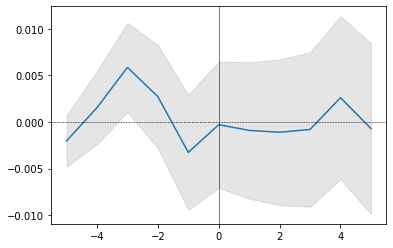

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5 -0.002        0.002  -0.002         0.002  -0.937    0.349
-4  0.004        0.002   0.002         0.003   0.506    0.613
-3  0.004        0.002   0.006         0.004   1.570    0.116
-2 -0.003        0.002   0.003         0.004   0.633    0.527
-1 -0.006        0.002  -0.003         0.005  -0.674    0.500
0   0.003        0.002    -0.0         0.005  -0.054    0.957
1  -0.001        0.002  -0.001         0.006  -0.156    0.876
2  -0.000        0.002  -0.001         0.006  -0.179    0.858
3   0.000        0.002  -0.001         0.006  -0.123    0.902
4   0.003        0.002   0.003         0.007   0.383    0.702
5  -0.003        0.002  -0.001         0.007  -0.096    0.924

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5 -0.002     0.001    11.280    -0.795 -0.186        -0.016        -0.002   
-4  0.002     0.001     9.071     1.877 -0.084        -0.018        -0.003   
-3  0.006     0.002     8.639     1.602 -0.120        -0.015         0.004   
-2  0.003     0.003     5.514     0.729 -0.199        -0.027         0.004   
-1 -0.003     0.004     4.738    -0.347 -0.281        -0.028         0.000   
0  -0.000     0.004     4.389     0.170 -0.249        -0.033        -0.001   
1  -0.001     0.006     7.083    -0.439 -0.371        -0.036         0.004   
2  -0.001     0.007     7.006    -0.884 -0.450        -0.045         0.002   
3  -0.001     0.007     2.462    -0.199 -0.331        -0.050         0.000   
4   0.003     0.008     5.106     0.642 -0.312        -0.046        -0.001   
5  -0.001     0.007     4.569     0.809 -0.281        -0.052        -0.001   

    Quantile 75%    Max  
-5         0.010  0.139  
-4         0.018  0.224  
-3         0.027  0.271  
-2         0.026  0.288  
-1         0.024  0.241  
0          0.031  0.290  
1          0.035  0.355  
2          0.038  0.302  
3          0.046  0.288  
4          0.041  0.423  
5          0.039  0.413

MS_N


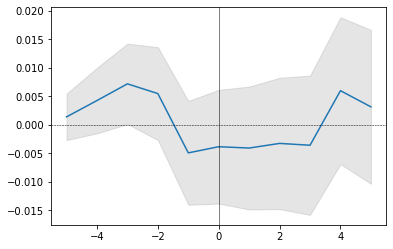

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5  0.001        0.003   0.001         0.003   0.440    0.660
-4  0.003        0.003   0.004         0.004   0.948    0.343
-3  0.003        0.003   0.007         0.006   1.306    0.191
-2 -0.002        0.003   0.005         0.006   0.862    0.388
-1 -0.010        0.003  -0.005         0.007  -0.692    0.489
0   0.001        0.003  -0.004         0.008  -0.493    0.622
1  -0.000        0.003  -0.004         0.008  -0.484    0.629
2   0.001        0.003  -0.003         0.009  -0.362    0.717
3  -0.000        0.003  -0.004         0.010  -0.375    0.707
4   0.010        0.003   0.006         0.010   0.596    0.551
5  -0.003        0.003   0.003         0.011   0.300    0.765

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.001     0.002    11.991     1.834 -0.156        -0.015        -0.001   
-4  0.004     0.003    11.028     2.319 -0.111        -0.018        -0.001   
-3  0.007     0.004     9.662     1.898 -0.138        -0.022        -0.001   
-2  0.005     0.006     7.558     1.472 -0.201        -0.024         0.004   
-1 -0.005     0.007     5.565    -0.062 -0.382        -0.036        -0.004   
0  -0.004     0.008     4.918     0.149 -0.378        -0.037        -0.004   
1  -0.004     0.012    10.246    -0.808 -0.618        -0.037        -0.001   
2  -0.003     0.011    10.159    -1.419 -0.602        -0.048         0.003   
3  -0.004     0.013    11.834    -1.705 -0.725        -0.053        -0.000   
4   0.006     0.011     3.534     0.671 -0.395        -0.050        -0.002   
5   0.003     0.012     3.235     0.766 -0.366        -0.050        -0.013   

    Quantile 75%    Max  
-5         0.013  0.241  
-4         0.022  0.323  
-3         0.029  0.378  
-2         0.033  0.426  
-1         0.034  0.342  
0          0.042  0.355  
1          0.045  0.442  
2          0.047  0.375  
3          0.053  0.326  
4          0.049  0.389  
5          0.046  0.420

HSBA_L


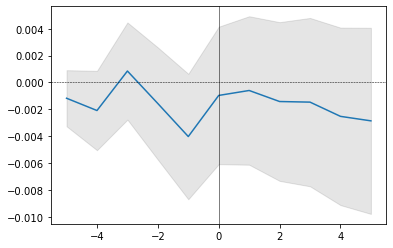

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5 -0.001        0.002  -0.001         0.002  -0.719    0.472
-4 -0.001        0.002  -0.002         0.002  -0.906    0.365
-3  0.003        0.002   0.001         0.003   0.302    0.763
-2 -0.002        0.002  -0.002         0.003  -0.481    0.630
-1 -0.002        0.002  -0.004         0.004  -1.104    0.270
0   0.003        0.002  -0.001         0.004  -0.241    0.809
1   0.000        0.002  -0.001         0.004  -0.138    0.890
2  -0.001        0.002  -0.001         0.005  -0.307    0.759
3  -0.000        0.002  -0.001         0.005  -0.299    0.765
4  -0.001        0.002  -0.003         0.005  -0.489    0.625
5  -0.000        0.002  -0.003         0.005  -0.528    0.597

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5 -0.001     0.001    17.762    -0.451 -0.147        -0.008        -0.002   
-4 -0.002     0.001     3.354    -0.102 -0.103        -0.013        -0.002   
-3  0.001     0.001     1.968     0.637 -0.093        -0.017        -0.002   
-2 -0.002     0.002     8.784    -0.666 -0.250        -0.023        -0.004   
-1 -0.004     0.003    14.038    -0.662 -0.321        -0.024        -0.006   
0  -0.001     0.003    12.570     0.264 -0.274        -0.021        -0.002   
1  -0.001     0.003    12.265    -0.752 -0.339        -0.020        -0.001   
2  -0.001     0.003    11.161     0.857 -0.272        -0.030        -0.003   
3  -0.001     0.004     5.807     0.533 -0.257        -0.033        -0.003   
4  -0.003     0.005    11.802     1.591 -0.281        -0.031        -0.006   
5  -0.003     0.004     8.834     1.649 -0.219        -0.035        -0.006   

    Quantile 75%    Max  
-5         0.008  0.134  
-4         0.009  0.081  
-3         0.012  0.119  
-2         0.015  0.193  
-1         0.013  0.274  
0          0.020  0.313  
1          0.024  0.283  
2          0.023  0.335  
3          0.020  0.282  
4          0.021  0.408  
5          0.022  0.356

BNPP_PA


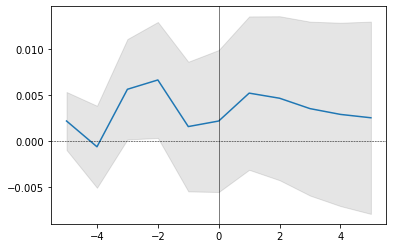

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5  0.002        0.002   0.002         0.002   0.892    0.373
-4 -0.003        0.002  -0.001         0.003  -0.176    0.860
-3  0.006        0.002   0.006         0.004   1.324    0.186
-2  0.001        0.002   0.007         0.005   1.353    0.176
-1 -0.005        0.002   0.002         0.006   0.288    0.773
0   0.001        0.002   0.002         0.006   0.363    0.716
1   0.003        0.002   0.005         0.007   0.803    0.422
2  -0.001        0.002   0.005         0.007   0.671    0.502
3  -0.001        0.002   0.004         0.007   0.479    0.632
4  -0.001        0.002   0.003         0.008   0.374    0.708
5  -0.000        0.002   0.003         0.008   0.312    0.755

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.002     0.001    14.619     0.326 -0.207        -0.011         0.000   
-4 -0.001     0.002     8.257     1.121 -0.186        -0.024        -0.001   
-3  0.006     0.003     6.258     1.048 -0.223        -0.024         0.000   
-2  0.007     0.005     6.672     0.428 -0.300        -0.024        -0.001   
-1  0.002     0.005    10.192     1.778 -0.208        -0.030        -0.005   
0   0.002     0.005     9.442     1.509 -0.194        -0.026         0.000   
1   0.005     0.007     9.713     0.356 -0.399        -0.028         0.003   
2   0.005     0.007    12.050     0.919 -0.376        -0.032         0.002   
3   0.004     0.008     8.713     0.618 -0.409        -0.033         0.001   
4   0.003     0.010    11.597     0.834 -0.484        -0.040        -0.002   
5   0.003     0.009     6.449     1.234 -0.296        -0.042        -0.006   

    Quantile 75%    Max  
-5         0.015  0.205  
-4         0.017  0.250  
-3         0.023  0.294  
-2         0.037  0.329  
-1         0.029  0.429  
0          0.025  0.426  
1          0.035  0.460  
2          0.045  0.509  
3          0.037  0.488  
4          0.039  0.574  
5          0.047  0.516

CAGR_PA


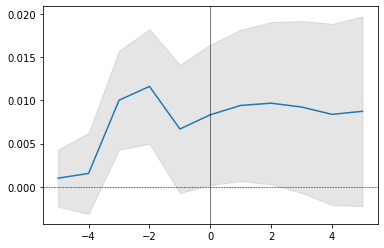

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-5  0.001        0.003     0.001         0.003   0.384    0.701
-4  0.001        0.003     0.002         0.004   0.423    0.673
-3  0.008        0.003   0.01 **         0.004   2.235    0.025
-2  0.002        0.003  0.012 **         0.005   2.244    0.025
-1 -0.005        0.003     0.007         0.006   1.155    0.248
0   0.002        0.003     0.008         0.006   1.314    0.189
1   0.001        0.003     0.009         0.007   1.375    0.169
2   0.000        0.003      0.01         0.007   1.322    0.186
3  -0.000        0.003     0.009         0.008   1.189    0.235
4  -0.001        0.003     0.008         0.008   1.024    0.306
5   0.000        0.003     0.009         0.009   1.018    0.309

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.001     0.001     6.701     0.351 -0.164        -0.015        -0.001   
-4  0.002     0.002     1.560     0.691 -0.103        -0.021        -0.003   
-3  0.010     0.004     2.698     1.087 -0.128        -0.022         0.003   
-2  0.012     0.005     2.557     1.035 -0.160        -0.029         0.003   
-1  0.007     0.005     3.324     0.923 -0.214        -0.030         0.000   
0   0.008     0.006     3.347     0.869 -0.188        -0.028         0.007   
1   0.009     0.008     3.124     0.498 -0.256        -0.029         0.007   
2   0.010     0.009     4.393     0.778 -0.221        -0.026         0.003   
3   0.009     0.010     3.762     0.768 -0.267        -0.033         0.003   
4   0.008     0.011     4.882     0.929 -0.254        -0.038         0.010   
5   0.009     0.012     4.468     0.816 -0.304        -0.036         0.013   

    Quantile 75%    Max  
-5         0.012  0.138  
-4         0.022  0.143  
-3         0.031  0.251  
-2         0.036  0.279  
-1         0.042  0.308  
0          0.046  0.337  
1          0.048  0.387  
2          0.056  0.460  
3          0.052  0.471  
4          0.058  0.531  
5          0.050  0.532

SAN_MC


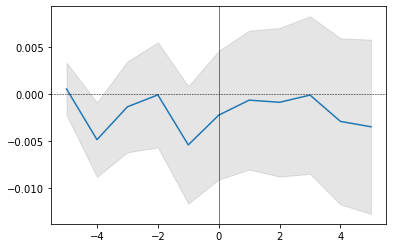

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-5  0.001        0.002   0.001         0.002   0.248    0.805
-4 -0.005        0.002  -0.005         0.003  -1.574    0.115
-3  0.003        0.002  -0.001         0.004  -0.360    0.719
-2  0.001        0.002    -0.0         0.004  -0.021    0.983
-1 -0.005        0.002  -0.005         0.005  -1.110    0.267
0   0.003        0.002  -0.002         0.005  -0.421    0.674
1   0.002        0.002  -0.001         0.006  -0.112    0.911
2  -0.000        0.002  -0.001         0.006  -0.143    0.887
3   0.001        0.002    -0.0         0.007  -0.017    0.986
4  -0.003        0.002  -0.003         0.007  -0.422    0.673
5  -0.001        0.002  -0.003         0.007  -0.482    0.630

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.001     0.001     8.939    -0.087 -0.142        -0.011         0.001   
-4 -0.005     0.002     3.651     0.312 -0.140        -0.023        -0.006   
-3 -0.001     0.002     3.566     0.135 -0.187        -0.024        -0.001   
-2 -0.000     0.004     5.856    -0.625 -0.312        -0.027        -0.002   
-1 -0.005     0.005     7.370    -0.497 -0.360        -0.033        -0.006   
0  -0.002     0.005     6.776    -0.548 -0.377        -0.032        -0.002   
1  -0.001     0.006     3.095     0.070 -0.280        -0.037        -0.002   
2  -0.001     0.006     3.883     0.607 -0.265        -0.035        -0.007   
3  -0.000     0.007     2.862     0.581 -0.270        -0.041        -0.004   
4  -0.003     0.008     2.884     0.633 -0.268        -0.046        -0.004   
5  -0.003     0.009     2.546     0.708 -0.266        -0.054        -0.008   

    Quantile 75%    Max  
-5         0.011  0.121  
-4         0.011  0.166  
-3         0.020  0.199  
-2         0.027  0.234  
-1         0.022  0.284  
0          0.028  0.279  
1          0.038  0.317  
2          0.026  0.352  
3          0.034  0.355  
4          0.042  0.393  
5          0.035  0.394

SOGN_PA


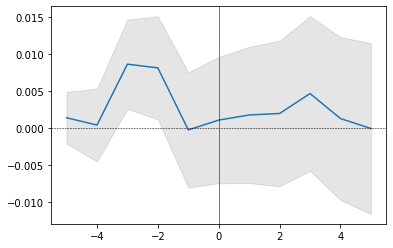

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-5  0.001        0.003    0.001         0.003   0.508    0.611
-4 -0.001        0.003      0.0         0.004   0.102    0.919
-3  0.008        0.003  0.009 *         0.005   1.832    0.067
-2 -0.001        0.003    0.008         0.005   1.494    0.135
-1 -0.008        0.003     -0.0         0.006  -0.043    0.965
0   0.001        0.003    0.001         0.007   0.159    0.874
1   0.001        0.003    0.002         0.007   0.244    0.807
2   0.000        0.003    0.002         0.008   0.254    0.799
3   0.003        0.003    0.005         0.008   0.570    0.568
4  -0.003        0.003    0.001         0.009   0.148    0.882
5  -0.001        0.003     -0.0         0.009  -0.008    0.994

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5  0.001     0.002    14.854    -0.946 -0.258        -0.015        -0.000   
-4  0.000     0.002     2.546     0.923 -0.138        -0.024        -0.007   
-3  0.009     0.005     3.077     1.384 -0.159        -0.025        -0.005   
-2  0.008     0.006     2.615     0.873 -0.185        -0.028        -0.003   
-1 -0.000     0.008     4.685     1.039 -0.251        -0.041        -0.006   
0   0.001     0.008     4.655     0.915 -0.289        -0.042        -0.000   
1   0.002     0.011     5.938     0.329 -0.407        -0.038         0.003   
2   0.002     0.011     6.321     0.874 -0.328        -0.038        -0.005   
3   0.005     0.013     4.894     0.812 -0.304        -0.037         0.001   
4   0.001     0.015     5.906     0.982 -0.308        -0.035         0.000   
5  -0.000     0.015     4.550     0.760 -0.387        -0.057        -0.009   

    Quantile 75%    Max  
-5         0.012  0.154  
-4         0.017  0.190  
-3         0.029  0.254  
-2         0.039  0.297  
-1         0.030  0.392  
0          0.030  0.412  
1          0.037  0.499  
2          0.045  0.542  
3          0.055  0.561  
4          0.049  0.651  
5          0.051  0.602

BARC_L


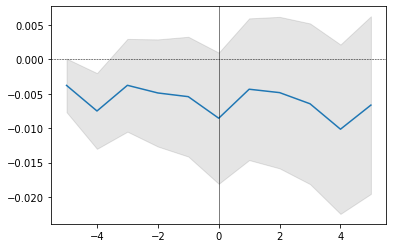

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-5 -0.004        0.003    -0.004         0.003  -1.245    0.213
-4 -0.004        0.003  -0.008 *         0.004  -1.746    0.081
-3  0.004        0.003    -0.004         0.005  -0.716    0.474
-2 -0.001        0.003    -0.005         0.006  -0.804    0.422
-1 -0.001        0.003    -0.005         0.007  -0.798    0.425
0  -0.003        0.003    -0.009         0.007  -1.150    0.250
1   0.004        0.003    -0.004         0.008  -0.540    0.589
2  -0.000        0.003    -0.005         0.009  -0.563    0.574
3  -0.002        0.003    -0.006         0.009  -0.708    0.479
4  -0.004        0.003     -0.01         0.010  -1.057    0.291
5   0.004        0.003    -0.007         0.010  -0.660    0.510

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-5 -0.004     0.002    26.135    -3.186 -0.310        -0.015        -0.002   
-4 -0.008     0.003    16.442    -2.080 -0.395        -0.025        -0.006   
-3 -0.004     0.005    18.203    -2.295 -0.518        -0.035        -0.002   
-2 -0.005     0.009    17.009    -2.579 -0.650        -0.037        -0.004   
-1 -0.005     0.008     9.092     0.926 -0.310        -0.045        -0.013   
0  -0.009     0.010    10.643    -0.326 -0.557        -0.044        -0.008   
1  -0.004     0.016    19.377    -1.389 -0.859        -0.050        -0.003   
2  -0.005     0.020    20.828    -0.740 -0.944        -0.054        -0.011   
3  -0.006     0.025    18.519    -1.477 -1.061        -0.057        -0.006   
4  -0.010     0.029    22.989    -1.370 -1.191        -0.062        -0.011   
5  -0.007     0.018    14.104     2.153 -0.437        -0.077        -0.010   

    Quantile 75%    Max  
-5         0.010  0.134  
-4         0.011  0.161  
-3         0.019  0.204  
-2         0.033  0.251  
-1         0.029  0.491  
0          0.031  0.504  
1          0.041  0.600  
2          0.046  0.793  
3          0.049  0.734  
4          0.049  0.903  
5          0.044  0.882

In [60]:
for ticker, event in releases_5_200.items():
    print(ticker)
    event.plot()
    plt.show()
    display(event.results())
    display(event.get_CAR_dist())

In [61]:
#using the event study (formula for each element of the tickers list (event window: +-10 / estimation size: 50)
tickers = ['JPM_N','BAC_N','C_N','WFC_N','GS','MS_N','HSBA_L','BNPP_PA','CAGR_PA','SAN_MC','SOGN_PA','BARC_L']
releases_10_50 = dict()

for ticker in tickers:
    events = [event for event in event_database if event['security_ticker']==ticker]
    
    releases_10_50[ticker] = es.Multiple.from_list(
        events,
        es.Single.FamaFrench_3factor,
        event_window= (-10,+10),
        estimation_size = 50)

2022-05-29 12:33:16,958 P[5368] [MainThread 14260]  3 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:17,122 P[5368] [MainThread 14260]  3 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:17,260 P[5368] [MainThread 14260]  3 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:17,392 P[5368] [MainThread 14260]  3 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:17,522 P[5368] [MainThread 14260]  3 events have not been processed due

JPM_N


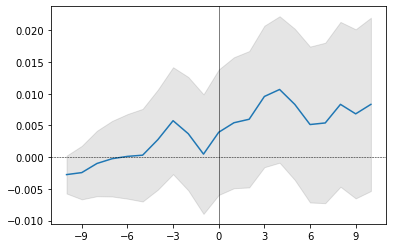

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.003        0.002  -0.003         0.002  -1.186    0.236
-9   0.000        0.002  -0.002         0.003  -0.743    0.458
-8   0.001        0.002  -0.001         0.004  -0.249    0.803
-7   0.001        0.002    -0.0         0.005  -0.053    0.957
-6   0.000        0.002     0.0         0.005   0.022    0.982
-5   0.000        0.002     0.0         0.006   0.054    0.957
-4   0.002        0.002   0.003         0.006   0.447    0.655
-3   0.003        0.002   0.006         0.007   0.872    0.383
-2  -0.002        0.002   0.004         0.007   0.528    0.597
-1  -0.003        0.002     0.0         0.007   0.064    0.949
0    0.003        0.002   0.004         0.008   0.508    0.612
1    0.001        0.002   0.005         0.008   0.672    0.501
2    0.001        0.002   0.006         0.008   0.712    0.477
3    0.004        0.002    0.01         0.009   1.098    0.272
4    0.001        0.002   0.011         0.009   1.184    0.237
5   -0.002        0.002   0.008         0.009   0.893    0.372
6   -0.003        0.002   0.005         0.010   0.536    0.592
7    0.000        0.002   0.005         0.010   0.546    0.585
8    0.003        0.002   0.008         0.010   0.820    0.412
9   -0.001        0.002   0.007         0.010   0.656    0.512
10   0.001        0.002   0.008         0.011   0.780    0.435

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.003     0.001     8.920    -0.707 -0.126        -0.011        -0.001   
-9  -0.002     0.001    23.574    -2.620 -0.283        -0.016         0.001   
-8  -0.001     0.002    10.073    -1.668 -0.259        -0.016         0.005   
-7  -0.000     0.002     9.352    -1.652 -0.295        -0.019         0.004   
-6   0.000     0.003     8.230    -1.170 -0.294        -0.018         0.002   
-5   0.000     0.003     4.303    -0.611 -0.252        -0.021         0.005   
-4   0.003     0.004     4.158    -0.573 -0.270        -0.023         0.005   
-3   0.006     0.004     3.917    -0.233 -0.282        -0.024         0.007   
-2   0.004     0.006     4.948    -0.707 -0.379        -0.025         0.006   
-1   0.000     0.007     6.469    -1.053 -0.471        -0.033         0.001   
0    0.004     0.007     2.169    -0.458 -0.308        -0.036         0.008   
1    0.005     0.010     3.965    -0.421 -0.427        -0.028         0.005   
2    0.006     0.008     1.544    -0.136 -0.286        -0.030         0.004   
3    0.010     0.008     0.487     0.191 -0.235        -0.037         0.004   
4    0.011     0.010     3.910     0.977 -0.256        -0.048         0.005   
5    0.008     0.009     1.959     0.501 -0.261        -0.042         0.001   
6    0.005     0.011     3.489     0.839 -0.257        -0.055         0.001   
7    0.005     0.012     3.535     0.786 -0.252        -0.052        -0.000   
8    0.008     0.014     1.805     0.558 -0.281        -0.055         0.004   
9    0.007     0.013     1.134     0.187 -0.299        -0.051         0.003   
10   0.008     0.014     1.853     0.181 -0.359        -0.048         0.014   

     Quantile 75%    Max  
-10         0.007  0.107  
-9          0.012  0.158  
-8          0.020  0.149  
-7          0.023  0.137  
-6          0.025  0.158  
-5          0.026  0.202  
-4          0.028  0.188  
-3          0.033  0.252  
-2          0.039  0.245  
-1          0.035  0.252  
0           0.044  0.268  
1           0.053  0.378  
2           0.043  0.297  
3           0.051  0.227  
4           0.054  0.486  
5           0.055  0.383  
6           0.059  0.495  
7           0.063  0.530  
8           0.067  0.473  
9           0.072  0.383  
10          0.073  0.461

BAC_N


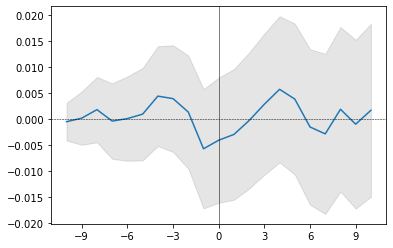

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.001        0.003  -0.001         0.003  -0.180    0.857
-9   0.001        0.003     0.0         0.004   0.045    0.964
-8   0.002        0.003   0.002         0.005   0.369    0.712
-7  -0.002        0.003    -0.0         0.006  -0.069    0.945
-6   0.000        0.003     0.0         0.006   0.014    0.988
-5   0.001        0.003   0.001         0.007   0.136    0.891
-4   0.003        0.003   0.004         0.007   0.589    0.556
-3  -0.000        0.003   0.004         0.008   0.490    0.624
-2  -0.003        0.003   0.001         0.008   0.158    0.874
-1  -0.007        0.003  -0.006         0.009  -0.638    0.523
0    0.002        0.003  -0.004         0.009  -0.433    0.665
1    0.001        0.003  -0.003         0.010  -0.301    0.763
2    0.003        0.003    -0.0         0.010  -0.027    0.978
3    0.003        0.003   0.003         0.011   0.270    0.787
4    0.003        0.003   0.006         0.011   0.522    0.602
5   -0.002        0.003   0.004         0.011   0.339    0.735
6   -0.005        0.003  -0.002         0.012  -0.131    0.896
7   -0.001        0.003  -0.003         0.012  -0.237    0.812
8    0.005        0.003   0.002         0.012   0.153    0.879
9   -0.003        0.003  -0.001         0.013  -0.078    0.938
10   0.003        0.003   0.002         0.013   0.130    0.897

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.001     0.001    14.004    -0.305 -0.193        -0.011         0.000   
-9   0.000     0.002     9.076     0.406 -0.180        -0.015        -0.002   
-8   0.002     0.003     4.772     0.230 -0.194        -0.016         0.001   
-7  -0.000     0.004     9.366    -1.225 -0.342        -0.019         0.001   
-6   0.000     0.004    18.334    -2.498 -0.459        -0.020         0.002   
-5   0.001     0.008    37.745    -3.664 -0.768        -0.019         0.002   
-4   0.004     0.007    11.920     0.501 -0.426        -0.026         0.004   
-3   0.004     0.011    16.682     0.773 -0.582        -0.029         0.004   
-2   0.001     0.013    11.214     1.539 -0.466        -0.035         0.004   
-1  -0.006     0.017    10.900     1.382 -0.475        -0.043        -0.005   
0   -0.004     0.017    10.748     0.971 -0.515        -0.050        -0.002   
1   -0.003     0.023    17.781     1.001 -0.760        -0.048        -0.000   
2   -0.000     0.021    15.166     0.966 -0.726        -0.049        -0.002   
3    0.003     0.023    10.511     0.845 -0.648        -0.049        -0.004   
4    0.006     0.028    16.066     2.642 -0.489        -0.048        -0.009   
5    0.004     0.028    13.551     2.272 -0.509        -0.052         0.003   
6   -0.002     0.034    13.892     2.065 -0.591        -0.058         0.001   
7   -0.003     0.033    13.325     2.157 -0.514        -0.059        -0.001   
8    0.002     0.034    11.591     1.853 -0.631        -0.065        -0.003   
9   -0.001     0.029     9.741     1.695 -0.551        -0.062        -0.002   
10   0.002     0.032    11.603     1.950 -0.494        -0.069         0.006   

     Quantile 75%    Max  
-10         0.010  0.163  
-9          0.012  0.211  
-8          0.017  0.218  
-7          0.021  0.215  
-6          0.029  0.207  
-5          0.025  0.377  
-4          0.026  0.416  
-3          0.033  0.627  
-2          0.033  0.629  
-1          0.033  0.708  
0           0.039  0.740  
1           0.043  0.989  
2           0.044  0.915  
3           0.039  0.824  
4           0.041  1.079  
5           0.043  0.998  
6           0.048  1.106  
7           0.047  1.119  
8           0.052  1.096  
9           0.052  0.954  
10          0.056  1.095

C_N


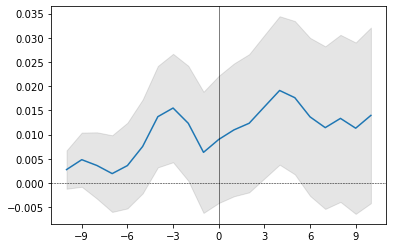

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-10  0.003        0.003    0.003         0.003   0.900    0.368
-9   0.002        0.003    0.005         0.004   1.105    0.269
-8  -0.001        0.003    0.004         0.005   0.677    0.498
-7  -0.002        0.003    0.002         0.006   0.316    0.752
-6   0.002        0.003    0.004         0.007   0.522    0.601
-5   0.004        0.003    0.008         0.008   0.998    0.318
-4   0.006        0.003  0.014 *         0.008   1.678    0.093
-3   0.002        0.003  0.015 *         0.009   1.774    0.076
-2  -0.003        0.003    0.012         0.009   1.332    0.183
-1  -0.006        0.003    0.006         0.010   0.649    0.516
0    0.003        0.003    0.009         0.010   0.879    0.379
1    0.002        0.003    0.011         0.011   1.026    0.305
2    0.001        0.003    0.012         0.011   1.109    0.267
3    0.003        0.003    0.016         0.012   1.363    0.173
4    0.003        0.003    0.019         0.012   1.598    0.110
5   -0.001        0.003    0.018         0.012   1.427    0.154
6   -0.004        0.003    0.014         0.013   1.073    0.283
7   -0.002        0.003    0.011         0.013   0.873    0.382
8    0.002        0.003    0.013         0.013   0.992    0.321
9   -0.002        0.003    0.011         0.014   0.820    0.412
10   0.003        0.003    0.014         0.014   0.988    0.323

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.003     0.002    21.067     2.332 -0.158        -0.011        -0.001   
-9   0.005     0.002    19.418     3.032 -0.114        -0.015         0.001   
-8   0.004     0.005    13.926     0.842 -0.299        -0.016         0.003   
-7   0.002     0.005    13.944    -0.747 -0.422        -0.023         0.002   
-6   0.004     0.005    16.333    -2.066 -0.484        -0.024         0.004   
-5   0.008     0.009    24.210    -2.337 -0.693        -0.026         0.002   
-4   0.014     0.008     7.010     1.019 -0.341        -0.023         0.006   
-3   0.015     0.010     9.300     0.454 -0.490        -0.021         0.005   
-2   0.012     0.013     7.196     1.174 -0.386        -0.031         0.006   
-1   0.006     0.019    13.234     1.869 -0.462        -0.041         0.002   
0    0.009     0.018    19.084     2.397 -0.452        -0.033         0.004   
1    0.011     0.024    23.769     2.574 -0.641        -0.034         0.012   
2    0.012     0.022    18.703     2.411 -0.545        -0.041         0.015   
3    0.016     0.024    17.399     2.397 -0.474        -0.038         0.015   
4    0.019     0.027    24.544     3.727 -0.350        -0.054         0.015   
5    0.018     0.027    22.876     3.567 -0.374        -0.041         0.006   
6    0.014     0.029    20.407     3.293 -0.313        -0.053         0.010   
7    0.011     0.029    18.377     3.065 -0.325        -0.064         0.002   
8    0.013     0.031    12.782     2.404 -0.366        -0.050        -0.002   
9    0.011     0.029    11.963     2.321 -0.314        -0.058        -0.004   
10   0.014     0.030    14.764     2.492 -0.371        -0.052         0.010   

     Quantile 75%    Max  
-10         0.009  0.298  
-9          0.015  0.336  
-8          0.021  0.410  
-7          0.025  0.374  
-6          0.030  0.209  
-5          0.036  0.341  
-4          0.038  0.408  
-3          0.038  0.489  
-2          0.042  0.565  
-1          0.036  0.877  
0           0.045  0.958  
1           0.050  1.165  
2           0.049  1.051  
3           0.061  1.078  
4           0.054  1.243  
5           0.062  1.227  
6           0.057  1.213  
7           0.054  1.191  
8           0.070  1.126  
9           0.066  1.068  
10          0.076  1.159

WFC_N


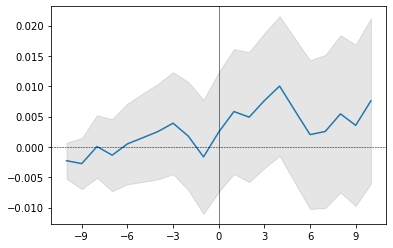

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.002        0.002  -0.002         0.002  -0.981    0.327
-9  -0.000        0.002  -0.003         0.003  -0.840    0.401
-8   0.003        0.002     0.0         0.004   0.014    0.989
-7  -0.001        0.002  -0.001         0.005  -0.294    0.769
-6   0.002        0.002     0.0         0.005   0.096    0.924
-5   0.001        0.002   0.002         0.006   0.264    0.792
-4   0.001        0.002   0.003         0.006   0.411    0.681
-3   0.001        0.002   0.004         0.007   0.595    0.552
-2  -0.002        0.002   0.002         0.007   0.256    0.798
-1  -0.003        0.002  -0.002         0.007  -0.224    0.822
0    0.004        0.002   0.002         0.008   0.318    0.751
1    0.003        0.002   0.006         0.008   0.725    0.468
2   -0.001        0.002   0.005         0.008   0.587    0.557
3    0.003        0.002   0.008         0.009   0.879    0.379
4    0.002        0.002    0.01         0.009   1.116    0.264
5   -0.004        0.002   0.006         0.009   0.646    0.518
6   -0.004        0.002   0.002         0.010   0.212    0.832
7    0.001        0.002   0.003         0.010   0.259    0.796
8    0.003        0.002   0.005         0.010   0.539    0.590
9   -0.002        0.002   0.004         0.010   0.342    0.732
10   0.004        0.002   0.008         0.011   0.715    0.475

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.002     0.001     7.182    -0.285 -0.096        -0.008        -0.001   
-9  -0.003     0.001     4.233    -0.443 -0.117        -0.014        -0.001   
-8   0.000     0.002    22.467     0.988 -0.268        -0.011         0.001   
-7  -0.001     0.002     6.893    -0.613 -0.207        -0.017         0.003   
-6   0.000     0.002    10.571    -0.498 -0.282        -0.016         0.002   
-5   0.002     0.005    27.402    -3.031 -0.534        -0.014         0.001   
-4   0.003     0.004     8.719    -0.806 -0.348        -0.016         0.002   
-3   0.004     0.005    10.404    -0.321 -0.405        -0.018         0.001   
-2   0.002     0.007     8.035     0.334 -0.389        -0.020         0.002   
-1  -0.002     0.008     7.150    -0.391 -0.410        -0.024         0.001   
0    0.002     0.009     7.732    -0.497 -0.447        -0.021         0.007   
1    0.006     0.011    19.606    -0.639 -0.691        -0.024         0.004   
2    0.005     0.011    10.025    -0.391 -0.521        -0.027         0.007   
3    0.008     0.012     9.603    -0.386 -0.578        -0.027         0.010   
4    0.010     0.015    13.674     1.497 -0.571        -0.030         0.008   
5    0.006     0.015    10.773     0.610 -0.600        -0.029         0.003   
6    0.002     0.018    11.998     1.423 -0.556        -0.044        -0.000   
7    0.003     0.016     9.962     1.948 -0.289        -0.040         0.001   
8    0.005     0.017     9.100     1.403 -0.426        -0.032         0.002   
9    0.004     0.015     7.625     0.945 -0.406        -0.037         0.002   
10   0.008     0.015     8.741     1.360 -0.341        -0.038         0.010   

     Quantile 75%    Max  
-10         0.007  0.109  
-9          0.010  0.113  
-8          0.013  0.333  
-7          0.013  0.215  
-6          0.020  0.222  
-5          0.020  0.236  
-4          0.023  0.244  
-3          0.027  0.344  
-2          0.029  0.352  
-1          0.027  0.364  
0           0.031  0.416  
1           0.029  0.605  
2           0.033  0.510  
3           0.038  0.453  
4           0.034  0.662  
5           0.036  0.597  
6           0.036  0.747  
7           0.039  0.673  
8           0.043  0.703  
9           0.043  0.645  
10          0.052  0.686

GS


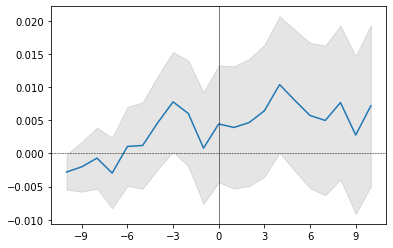

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.003        0.002  -0.003         0.002  -1.357    0.175
-9   0.001        0.002  -0.002         0.003  -0.692    0.489
-8   0.001        0.002  -0.001         0.004  -0.200    0.841
-7  -0.002        0.002  -0.003         0.004  -0.718    0.473
-6   0.004        0.002   0.001         0.005   0.224    0.823
-5   0.000        0.002   0.001         0.005   0.234    0.815
-4   0.003        0.002   0.005         0.005   0.845    0.398
-3   0.003        0.002   0.008         0.006   1.322    0.186
-2  -0.002        0.002   0.006         0.006   0.966    0.334
-1  -0.005        0.002   0.001         0.007   0.121    0.904
0    0.004        0.002   0.004         0.007   0.644    0.519
1   -0.001        0.002   0.004         0.007   0.542    0.588
2    0.001        0.002   0.005         0.007   0.621    0.535
3    0.002        0.002   0.006         0.008   0.826    0.409
4    0.004        0.002    0.01         0.008   1.290    0.197
5   -0.002        0.002   0.008         0.008   0.962    0.336
6   -0.002        0.002   0.006         0.009   0.667    0.505
7   -0.001        0.002   0.005         0.009   0.563    0.573
8    0.003        0.002   0.008         0.009   0.846    0.397
9   -0.005        0.002   0.003         0.009   0.298    0.766
10   0.004        0.002   0.007         0.010   0.755    0.450

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.003     0.001     6.647    -1.040 -0.122        -0.014        -0.002   
-9  -0.002     0.001     3.824    -0.615 -0.144        -0.015        -0.002   
-8  -0.001     0.002    10.752    -1.430 -0.289        -0.019        -0.000   
-7  -0.003     0.003    13.209    -2.249 -0.350        -0.025        -0.004   
-6   0.001     0.002     0.960    -0.203 -0.159        -0.024        -0.002   
-5   0.001     0.003     4.935    -0.896 -0.273        -0.029        -0.002   
-4   0.005     0.003     1.302     0.310 -0.196        -0.031        -0.000   
-3   0.008     0.004     1.718     0.854 -0.134        -0.036         0.004   
-2   0.006     0.006     2.347     0.769 -0.219        -0.041         0.005   
-1   0.001     0.007     3.655     0.378 -0.332        -0.047         0.005   
0    0.004     0.008     1.830     0.137 -0.252        -0.049         0.011   
1    0.004     0.009     2.024    -0.095 -0.389        -0.059         0.004   
2    0.005     0.010     3.747    -0.442 -0.470        -0.057         0.009   
3    0.006     0.011     2.054    -0.182 -0.416        -0.045         0.010   
4    0.010     0.011     1.411     0.299 -0.326        -0.052         0.006   
5    0.008     0.011     0.842     0.146 -0.297        -0.055         0.011   
6    0.006     0.013     0.892     0.153 -0.357        -0.063         0.008   
7    0.005     0.015     1.393     0.281 -0.367        -0.068         0.007   
8    0.008     0.017     2.286     0.089 -0.490        -0.066         0.010   
9    0.003     0.019     3.536    -0.420 -0.622        -0.068         0.005   
10   0.007     0.018     1.211     0.283 -0.386        -0.066         0.011   

     Quantile 75%    Max  
-10         0.009  0.092  
-9          0.015  0.118  
-8          0.023  0.195  
-7          0.025  0.144  
-6          0.033  0.129  
-5          0.038  0.172  
-4          0.038  0.190  
-3          0.038  0.262  
-2          0.045  0.285  
-1          0.043  0.339  
0           0.053  0.363  
1           0.059  0.294  
2           0.060  0.356  
3           0.059  0.371  
4           0.065  0.384  
5           0.059  0.284  
6           0.075  0.337  
7           0.062  0.409  
8           0.073  0.486  
9           0.077  0.518  
10          0.078  0.446

MS_N


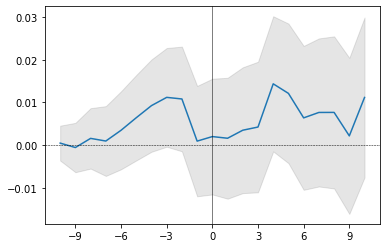

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10  0.000        0.003     0.0         0.003   0.153    0.879
-9  -0.001        0.003  -0.001         0.005  -0.121    0.903
-8   0.002        0.003   0.002         0.006   0.289    0.773
-7  -0.001        0.003   0.001         0.006   0.152    0.879
-6   0.003        0.003   0.003         0.007   0.490    0.624
-5   0.003        0.003   0.006         0.008   0.823    0.410
-4   0.003        0.003   0.009         0.008   1.099    0.272
-3   0.002        0.003   0.011         0.009   1.242    0.214
-2  -0.000        0.003   0.011         0.010   1.132    0.258
-1  -0.010        0.003   0.001         0.010   0.094    0.925
0    0.001        0.003   0.002         0.011   0.191    0.849
1   -0.000        0.003   0.002         0.011   0.147    0.883
2    0.002        0.003   0.004         0.011   0.305    0.760
3    0.001        0.003   0.004         0.012   0.356    0.722
4    0.010        0.003   0.014         0.012   1.164    0.245
5   -0.002        0.003   0.012         0.013   0.951    0.341
6   -0.006        0.003   0.006         0.013   0.487    0.627
7    0.001        0.003   0.008         0.014   0.567    0.571
8    0.000        0.003   0.008         0.014   0.552    0.581
9   -0.005        0.003   0.002         0.014   0.153    0.878
10   0.009        0.003   0.011         0.015   0.765    0.444

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.000     0.001     7.607     0.873 -0.132        -0.014        -0.003   
-9  -0.001     0.002     7.023    -0.709 -0.239        -0.015        -0.001   
-8   0.002     0.005    20.073    -2.439 -0.485        -0.022         0.005   
-7   0.001     0.006    12.673    -2.110 -0.446        -0.021         0.001   
-6   0.003     0.005     3.768    -0.397 -0.253        -0.029         0.003   
-5   0.006     0.006     8.437    -1.027 -0.422        -0.027         0.009   
-4   0.009     0.006     2.560     0.803 -0.219        -0.035         0.009   
-3   0.011     0.009     4.372     0.618 -0.333        -0.037         0.007   
-2   0.011     0.010     3.549     0.867 -0.244        -0.037         0.008   
-1   0.001     0.012     4.342     0.088 -0.430        -0.038         0.007   
0    0.002     0.014     3.979    -0.943 -0.481        -0.047         0.011   
1    0.002     0.017     4.572    -1.046 -0.582        -0.046         0.010   
2    0.004     0.019    10.010    -1.949 -0.800        -0.057         0.012   
3    0.004     0.022    16.479    -2.512 -1.032        -0.051         0.018   
4    0.014     0.015     2.293     0.136 -0.405        -0.050         0.020   
5    0.012     0.016     2.124     0.111 -0.444        -0.049         0.012   
6    0.006     0.021     4.530    -0.594 -0.691        -0.063         0.015   
7    0.008     0.024     4.608    -0.250 -0.730        -0.068         0.010   
8    0.008     0.030     9.191    -1.047 -1.010        -0.062         0.014   
9    0.002     0.035    14.016    -2.034 -1.230        -0.069         0.011   
10   0.011     0.022     1.397     0.005 -0.477        -0.059         0.015   

     Quantile 75%    Max  
-10         0.014  0.144  
-9          0.018  0.167  
-8          0.025  0.247  
-7          0.035  0.215  
-6          0.039  0.242  
-5          0.037  0.262  
-4          0.038  0.303  
-3          0.052  0.453  
-2          0.055  0.442  
-1          0.049  0.489  
0           0.052  0.339  
1           0.064  0.319  
2           0.070  0.340  
3           0.068  0.368  
4           0.069  0.406  
5           0.068  0.431  
6           0.083  0.505  
7           0.072  0.543  
8           0.086  0.655  
9           0.089  0.598  
10          0.090  0.510

HSBA_L


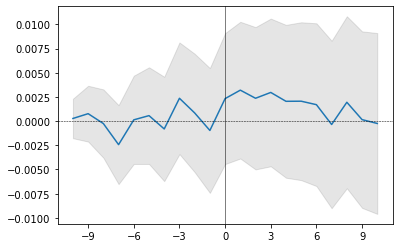

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10  0.000        0.002     0.0         0.002   0.171    0.865
-9   0.000        0.002   0.001         0.002   0.341    0.733
-8  -0.001        0.002    -0.0         0.003  -0.092    0.926
-7  -0.002        0.002  -0.002         0.003  -0.764    0.445
-6   0.003        0.002     0.0         0.004   0.037    0.971
-5   0.000        0.002   0.001         0.004   0.145    0.885
-4  -0.001        0.002  -0.001         0.004  -0.193    0.847
-3   0.003        0.002   0.002         0.004   0.524    0.600
-2  -0.002        0.002   0.001         0.005   0.177    0.860
-1  -0.002        0.002  -0.001         0.005  -0.193    0.847
0    0.003        0.002   0.002         0.005   0.440    0.660
1    0.001        0.002   0.003         0.006   0.580    0.562
2   -0.001        0.002   0.002         0.006   0.411    0.681
3    0.001        0.002   0.003         0.006   0.497    0.619
4   -0.001        0.002   0.002         0.006   0.332    0.740
5    0.000        0.002   0.002         0.006   0.323    0.747
6   -0.000        0.002   0.002         0.007   0.259    0.796
7   -0.002        0.002    -0.0         0.007  -0.052    0.959
8    0.002        0.002   0.002         0.007   0.281    0.779
9   -0.002        0.002     0.0         0.007   0.021    0.983
10  -0.000        0.002    -0.0         0.007  -0.034    0.973

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.000     0.000     2.438     0.731 -0.042        -0.008        -0.000   
-9   0.001     0.001     2.039     0.171 -0.074        -0.009         0.000   
-8  -0.000     0.001     5.930     0.822 -0.104        -0.015        -0.000   
-7  -0.002     0.001     3.389    -0.459 -0.137        -0.017         0.000   
-6   0.000     0.001     3.937    -0.529 -0.152        -0.015         0.003   
-5   0.001     0.002    17.253    -2.589 -0.290        -0.014         0.002   
-4  -0.001     0.002     4.671    -0.999 -0.211        -0.015         0.002   
-3   0.002     0.002     3.281    -0.370 -0.194        -0.015         0.002   
-2   0.001     0.003     5.100    -0.873 -0.265        -0.019         0.001   
-1  -0.001     0.004     7.863    -0.680 -0.339        -0.022        -0.003   
0    0.002     0.004     5.430     0.251 -0.259        -0.018        -0.002   
1    0.003     0.004     3.823     0.247 -0.223        -0.021        -0.001   
2    0.002     0.004     4.214     0.708 -0.189        -0.026        -0.002   
3    0.003     0.004     2.480     0.416 -0.183        -0.026         0.002   
4    0.002     0.006     7.591     1.543 -0.167        -0.032        -0.000   
5    0.002     0.005     7.017     1.491 -0.168        -0.027        -0.003   
6    0.002     0.006     6.975     1.467 -0.183        -0.029        -0.002   
7   -0.000     0.007     7.618     1.430 -0.246        -0.032        -0.008   
8    0.002     0.007     7.560     1.467 -0.268        -0.033        -0.007   
9    0.000     0.006     4.502     0.791 -0.278        -0.035        -0.005   
10  -0.000     0.007     6.279     1.082 -0.271        -0.038        -0.005   

     Quantile 75%    Max  
-10         0.007  0.068  
-9          0.011  0.084  
-8          0.013  0.181  
-7          0.015  0.141  
-6          0.017  0.144  
-5          0.020  0.106  
-4          0.021  0.119  
-3          0.024  0.158  
-2          0.025  0.166  
-1          0.021  0.207  
0           0.028  0.259  
1           0.028  0.263  
2           0.027  0.305  
3           0.029  0.252  
4           0.031  0.409  
5           0.027  0.349  
6           0.031  0.412  
7           0.032  0.409  
8           0.032  0.406  
9           0.037  0.343  
10          0.033  0.396

BNPP_PA


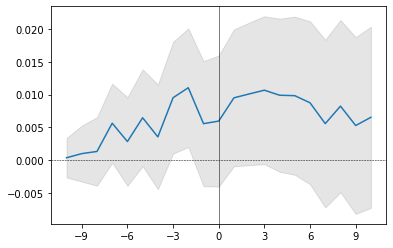

AAR  Std. E. AAR   CAAR  Std. E. CAAR  T-stat  P-value
-10  0.000        0.002    0.0         0.002   0.152    0.879
-9   0.001        0.002  0.001         0.003   0.297    0.766
-8   0.000        0.002  0.001         0.004   0.324    0.746
-7   0.004        0.002  0.006         0.005   1.196    0.232
-6  -0.003        0.002  0.003         0.005   0.538    0.590
-5   0.004        0.002  0.006         0.006   1.121    0.262
-4  -0.003        0.002  0.004         0.006   0.569    0.570
-3   0.006        0.002   0.01         0.007   1.430    0.153
-2   0.002        0.002  0.011         0.007   1.564    0.118
-1  -0.005        0.002  0.006         0.007   0.747    0.455
0    0.000        0.002  0.006         0.008   0.763    0.446
1    0.004        0.002   0.01         0.008   1.166    0.244
2    0.001        0.002   0.01         0.008   1.190    0.234
3    0.001        0.002  0.011         0.009   1.211    0.226
4   -0.001        0.002   0.01         0.009   1.086    0.277
5   -0.000        0.002   0.01         0.009   1.044    0.296
6   -0.001        0.002  0.009         0.010   0.901    0.368
7   -0.003        0.002  0.006         0.010   0.557    0.577
8    0.003        0.002  0.008         0.010   0.803    0.422
9   -0.003        0.002  0.005         0.011   0.501    0.616
10   0.001        0.002  0.007         0.011   0.605    0.545

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.000     0.001    11.543     1.506 -0.116        -0.014        -0.001   
-9   0.001     0.002     4.720     1.065 -0.121        -0.016        -0.002   
-8   0.001     0.003    19.747     2.760 -0.165        -0.022        -0.003   
-7   0.006     0.004    10.481     1.849 -0.151        -0.028         0.000   
-6   0.003     0.005     8.911     1.324 -0.236        -0.030        -0.003   
-5   0.006     0.005     6.029     0.146 -0.321        -0.022         0.004   
-4   0.004     0.006     3.353     0.234 -0.283        -0.027        -0.001   
-3   0.010     0.008     3.575     0.559 -0.314        -0.034         0.007   
-2   0.011     0.010     3.362     0.381 -0.378        -0.036         0.008   
-1   0.006     0.011     3.921     0.972 -0.240        -0.039        -0.008   
0    0.006     0.010     5.336     0.880 -0.313        -0.042        -0.001   
1    0.010     0.011     5.417     1.045 -0.332        -0.041        -0.000   
2    0.010     0.011     6.752     1.280 -0.362        -0.041         0.000   
3    0.011     0.011     4.763     1.254 -0.256        -0.049         0.011   
4    0.010     0.014     6.608     1.555 -0.272        -0.058         0.008   
5    0.010     0.012     5.329     1.521 -0.210        -0.054         0.006   
6    0.009     0.014     5.271     1.487 -0.246        -0.061        -0.000   
7    0.006     0.016     4.938     1.276 -0.321        -0.059        -0.003   
8    0.008     0.017     4.132     1.027 -0.384        -0.056        -0.005   
9    0.005     0.017     2.180     0.682 -0.385        -0.071        -0.004   
10   0.007     0.018     3.201     0.889 -0.362        -0.071         0.002   

     Quantile 75%    Max  
-10         0.010  0.197  
-9          0.015  0.204  
-8          0.020  0.414  
-7          0.028  0.392  
-6          0.031  0.407  
-5          0.039  0.338  
-4          0.041  0.336  
-3          0.044  0.366  
-2          0.050  0.372  
-1          0.049  0.441  
0           0.044  0.467  
1           0.056  0.500  
2           0.051  0.550  
3           0.049  0.528  
4           0.061  0.628  
5           0.056  0.560  
6           0.050  0.570  
7           0.053  0.609  
8           0.062  0.582  
9           0.068  0.498  
10          0.067  0.578

CAGR_PA


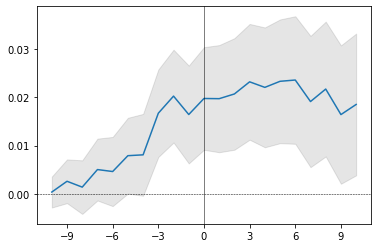

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-10  0.000        0.003       0.0         0.003   0.150    0.881
-9   0.002        0.003     0.003         0.004   0.738    0.461
-8  -0.001        0.003     0.001         0.004   0.323    0.747
-7   0.004        0.003     0.005         0.005   1.007    0.314
-6  -0.000        0.003     0.005         0.006   0.828    0.408
-5   0.003        0.003     0.008         0.006   1.291    0.197
-4   0.000        0.003     0.008         0.007   1.222    0.222
-3   0.009        0.003  0.017 **         0.007   2.362    0.018
-2   0.004        0.003  0.02 ***         0.008   2.700    0.007
-1  -0.004        0.003  0.016 **         0.008   2.079    0.038
0    0.003        0.003   0.02 **         0.008   2.383    0.017
1   -0.000        0.003   0.02 **         0.009   2.277    0.023
2    0.001        0.003  0.021 **         0.009   2.296    0.022
3    0.003        0.003  0.023 **         0.009   2.481    0.013
4   -0.001        0.003  0.022 **         0.010   2.278    0.023
5    0.001        0.003  0.023 **         0.010   2.332    0.020
6    0.000        0.003  0.024 **         0.010   2.288    0.022
7   -0.004        0.003   0.019 *         0.011   1.803    0.071
8    0.003        0.003  0.022 **         0.011   1.992    0.046
9   -0.005        0.003     0.016         0.011   1.469    0.142
10   0.002        0.003     0.019         0.011   1.617    0.106

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.000     0.001    11.837     1.753 -0.105        -0.012        -0.002   
-9   0.003     0.002     6.151     1.184 -0.157        -0.020        -0.003   
-8   0.001     0.004     9.312     1.355 -0.180        -0.025        -0.003   
-7   0.005     0.005     4.238     0.314 -0.204        -0.023         0.007   
-6   0.005     0.004     3.401     0.150 -0.229        -0.024         0.005   
-5   0.008     0.004     1.874     0.077 -0.187        -0.027         0.011   
-4   0.008     0.006     1.554     0.265 -0.225        -0.032         0.010   
-3   0.017     0.008     2.473     0.799 -0.188        -0.033         0.011   
-2   0.020     0.010     1.942     0.644 -0.233        -0.033         0.009   
-1   0.016     0.012     1.809     0.507 -0.253        -0.041         0.015   
0    0.020     0.012     1.754     0.191 -0.297        -0.026         0.018   
1    0.020     0.013     1.217     0.220 -0.327        -0.036         0.011   
2    0.021     0.014     1.468     0.214 -0.386        -0.046         0.013   
3    0.023     0.015     0.881     0.318 -0.322        -0.057         0.019   
4    0.022     0.016     0.453     0.272 -0.298        -0.052         0.013   
5    0.023     0.017     0.282     0.209 -0.284        -0.055         0.013   
6    0.024     0.018     0.303     0.177 -0.335        -0.058         0.027   
7    0.019     0.021     0.332     0.202 -0.413        -0.076         0.013   
8    0.022     0.023     0.459     0.204 -0.473        -0.077         0.020   
9    0.016     0.024     0.323     0.202 -0.463        -0.083         0.016   
10   0.019     0.023     0.225     0.165 -0.453        -0.089         0.018   

     Quantile 75%    Max  
-10         0.013  0.194  
-9          0.021  0.236  
-8          0.023  0.355  
-7          0.038  0.329  
-6          0.037  0.286  
-5          0.042  0.245  
-4          0.048  0.298  
-3          0.065  0.366  
-2          0.061  0.398  
-1          0.056  0.370  
0           0.073  0.380  
1           0.068  0.385  
2           0.083  0.421  
3           0.085  0.433  
4           0.094  0.399  
5           0.097  0.407  
6           0.113  0.405  
7           0.108  0.417  
8           0.104  0.399  
9           0.104  0.436  
10          0.100  0.462

SAN_MC


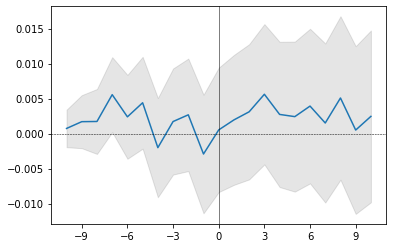

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10  0.001        0.002   0.001         0.002   0.350    0.726
-9   0.001        0.002   0.002         0.003   0.575    0.565
-8   0.000        0.002   0.002         0.004   0.477    0.633
-7   0.004        0.002   0.006         0.004   1.330    0.184
-6  -0.003        0.002   0.002         0.005   0.512    0.609
-5   0.002        0.002   0.004         0.005   0.860    0.390
-4  -0.006        0.002  -0.002         0.006  -0.364    0.716
-3   0.004        0.002   0.002         0.006   0.291    0.771
-2   0.001        0.002   0.003         0.006   0.427    0.669
-1  -0.006        0.002  -0.003         0.007  -0.442    0.659
0    0.003        0.002   0.001         0.007   0.076    0.940
1    0.001        0.002   0.002         0.007   0.270    0.787
2    0.001        0.002   0.003         0.008   0.413    0.680
3    0.003        0.002   0.006         0.008   0.718    0.473
4   -0.003        0.002   0.003         0.008   0.338    0.735
5   -0.000        0.002   0.002         0.008   0.289    0.772
6    0.002        0.002   0.004         0.009   0.456    0.649
7   -0.002        0.002   0.002         0.009   0.170    0.865
8    0.004        0.002   0.005         0.009   0.558    0.577
9   -0.005        0.002   0.001         0.009   0.054    0.957
10   0.002        0.002   0.002         0.010   0.256    0.798

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.001     0.001     4.639    -1.021 -0.105        -0.008         0.003   
-9   0.002     0.001     4.154    -0.218 -0.174        -0.017         0.002   
-8   0.002     0.002     5.426     0.130 -0.216        -0.023         0.001   
-7   0.006     0.003     1.882     0.157 -0.188        -0.023         0.006   
-6   0.002     0.004     3.100    -0.209 -0.255        -0.028         0.006   
-5   0.004     0.004     2.482    -0.099 -0.227        -0.029         0.006   
-4  -0.002     0.005     1.651    -0.211 -0.246        -0.037        -0.001   
-3   0.002     0.006     1.885    -0.027 -0.288        -0.038         0.001   
-2   0.003     0.008     4.017    -0.474 -0.421        -0.037         0.002   
-1  -0.003     0.009     4.410    -0.666 -0.477        -0.047        -0.008   
0    0.001     0.009     4.239    -0.683 -0.464        -0.047        -0.004   
1    0.002     0.009     0.933    -0.130 -0.300        -0.045        -0.000   
2    0.003     0.009     0.773     0.140 -0.297        -0.052        -0.000   
3    0.006     0.010     0.690     0.071 -0.286        -0.051         0.001   
4    0.003     0.011     0.111     0.257 -0.273        -0.064         0.000   
5    0.002     0.011    -0.095     0.250 -0.242        -0.065        -0.003   
6    0.004     0.013     0.164     0.256 -0.293        -0.057         0.001   
7    0.002     0.015     0.500     0.017 -0.415        -0.074        -0.002   
8    0.005     0.015     0.636     0.056 -0.424        -0.067        -0.000   
9    0.001     0.016     0.327    -0.013 -0.415        -0.067        -0.001   
10   0.002     0.017     0.568     0.152 -0.388        -0.067        -0.005   

     Quantile 75%    Max  
-10         0.013  0.077  
-9          0.016  0.120  
-8          0.023  0.235  
-7          0.028  0.211  
-6          0.028  0.203  
-5          0.030  0.218  
-4          0.035  0.210  
-3          0.037  0.228  
-2          0.043  0.265  
-1          0.042  0.269  
0           0.044  0.254  
1           0.051  0.240  
2           0.055  0.259  
3           0.057  0.265  
4           0.061  0.305  
5           0.071  0.289  
6           0.061  0.313  
7           0.064  0.325  
8           0.078  0.316  
9           0.075  0.321  
10          0.062  0.341

SOGN_PA


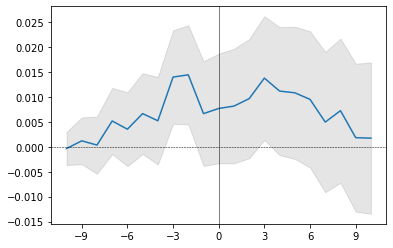

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.000        0.003     -0.0         0.003  -0.132    0.895
-9   0.002        0.003    0.001         0.004   0.327    0.744
-8  -0.001        0.003      0.0         0.004   0.077    0.939
-7   0.005        0.003    0.005         0.005   1.001    0.317
-6  -0.002        0.003    0.004         0.006   0.610    0.542
-5   0.003        0.003    0.007         0.006   1.051    0.293
-4  -0.001        0.003    0.005         0.007   0.762    0.446
-3   0.009        0.003  0.014 *         0.007   1.911    0.056
-2   0.000        0.003  0.014 *         0.008   1.860    0.063
-1  -0.008        0.003    0.007         0.008   0.813    0.416
0    0.001        0.003    0.008         0.009   0.896    0.370
1    0.000        0.003    0.008         0.009   0.911    0.362
2    0.001        0.003     0.01         0.009   1.035    0.301
3    0.004        0.003    0.014         0.010   1.423    0.155
4   -0.003        0.003    0.011         0.010   1.116    0.265
5   -0.000        0.003    0.011         0.010   1.047    0.295
6   -0.001        0.003     0.01         0.011   0.892    0.373
7   -0.005        0.003    0.005         0.011   0.452    0.652
8    0.002        0.003    0.007         0.011   0.643    0.520
9   -0.005        0.003    0.002         0.012   0.158    0.874
10  -0.000        0.003    0.002         0.012   0.146    0.884

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.000     0.001     6.496     0.350 -0.145        -0.015        -0.001   
-9   0.001     0.002     4.699     0.680 -0.168        -0.018         0.002   
-8   0.000     0.003     7.251     1.066 -0.205        -0.024        -0.001   
-7   0.005     0.004     3.566     0.179 -0.227        -0.023         0.007   
-6   0.004     0.005     5.097    -0.494 -0.335        -0.025         0.005   
-5   0.007     0.005     3.791    -0.280 -0.315        -0.022         0.008   
-4   0.005     0.006     1.536     0.028 -0.231        -0.029         0.002   
-3   0.014     0.009     2.032     0.539 -0.236        -0.034         0.010   
-2   0.014     0.011     1.510     0.554 -0.271        -0.040         0.010   
-1   0.007     0.013     1.742     0.499 -0.289        -0.051         0.005   
0    0.008     0.012     1.491     0.165 -0.336        -0.042         0.008   
1    0.008     0.013     1.284     0.130 -0.314        -0.044         0.006   
2    0.010     0.014     1.124     0.232 -0.350        -0.055         0.004   
3    0.014     0.015     1.157     0.304 -0.377        -0.056         0.006   
4    0.011     0.017     1.445     0.530 -0.329        -0.053         0.009   
5    0.011     0.015     0.767     0.610 -0.285        -0.065         0.002   
6    0.010     0.018     1.004     0.449 -0.324        -0.076         0.001   
7    0.005     0.021     1.454     0.182 -0.422        -0.069        -0.000   
8    0.007     0.022     1.445     0.293 -0.453        -0.070        -0.000   
9    0.002     0.023     1.037     0.174 -0.452        -0.086        -0.002   
10   0.002     0.023     0.898     0.332 -0.425        -0.084         0.001   

     Quantile 75%    Max  
-10         0.016  0.149  
-9          0.017  0.188  
-8          0.024  0.317  
-7          0.026  0.276  
-6          0.027  0.268  
-5          0.033  0.244  
-4          0.036  0.275  
-3          0.046  0.358  
-2          0.050  0.370  
-1          0.048  0.401  
0           0.051  0.345  
1           0.048  0.338  
2           0.056  0.370  
3           0.058  0.382  
4           0.068  0.491  
5           0.057  0.428  
6           0.076  0.482  
7           0.076  0.511  
8           0.082  0.455  
9           0.077  0.442  
10          0.070  0.436

BARC_L


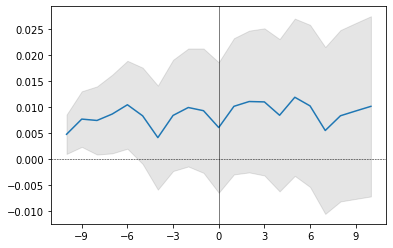

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-10  0.005        0.003    0.005         0.003   1.620    0.105
-9   0.003        0.003  0.008 *         0.004   1.846    0.065
-8  -0.000        0.003    0.007         0.005   1.456    0.146
-7   0.001        0.003    0.009         0.006   1.470    0.142
-6   0.002        0.003     0.01         0.007   1.585    0.113
-5  -0.002        0.003    0.008         0.007   1.153    0.249
-4  -0.004        0.003    0.004         0.008   0.530    0.596
-3   0.004        0.003    0.008         0.008   1.008    0.314
-2   0.002        0.003     0.01         0.009   1.122    0.262
-1  -0.001        0.003    0.009         0.009   0.999    0.318
0   -0.003        0.003    0.006         0.010   0.621    0.535
1    0.004        0.003     0.01         0.010   0.994    0.320
2    0.001        0.003    0.011         0.011   1.042    0.298
3   -0.000        0.003    0.011         0.011   0.997    0.319
4   -0.003        0.003    0.008         0.011   0.739    0.460
5    0.003        0.003    0.012         0.012   1.009    0.313
6   -0.002        0.003     0.01         0.012   0.842    0.400
7   -0.005        0.003    0.005         0.012   0.440    0.660
8    0.003        0.003    0.008         0.013   0.649    0.516
9    0.001        0.003    0.009         0.013   0.702    0.483
10   0.001        0.003     0.01         0.013   0.751    0.453

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.005     0.006    73.616     7.648 -0.147        -0.016        -0.001   
-9   0.008     0.007    65.241     6.951 -0.162        -0.023         0.002   
-8   0.007     0.012    60.798     6.378 -0.288        -0.023         0.004   
-7   0.009     0.013    42.760     4.821 -0.296        -0.024         0.005   
-6   0.010     0.016    37.322     3.794 -0.511        -0.022         0.005   
-5   0.008     0.017    34.850     1.207 -0.827        -0.018         0.004   
-4   0.004     0.018    30.652     0.567 -0.882        -0.035        -0.002   
-3   0.008     0.021    31.404     0.106 -1.001        -0.037         0.003   
-2   0.010     0.026    30.486    -0.286 -1.111        -0.040         0.003   
-1   0.009     0.021    28.534     3.889 -0.340        -0.056        -0.004   
0    0.006     0.024    35.014     4.374 -0.343        -0.055        -0.007   
1    0.010     0.026    27.197     3.393 -0.542        -0.051         0.002   
2    0.011     0.029    20.273     2.463 -0.614        -0.058        -0.002   
3    0.011     0.034    16.127     1.381 -0.763        -0.065        -0.010   
4    0.008     0.035    14.684     1.363 -0.857        -0.080        -0.016   
5    0.012     0.027    16.643     2.890 -0.419        -0.087        -0.013   
6    0.010     0.029    13.924     2.478 -0.514        -0.080        -0.011   
7    0.005     0.036    13.256     2.327 -0.616        -0.088        -0.016   
8    0.008     0.040    12.372     2.340 -0.575        -0.089        -0.009   
9    0.009     0.040    12.701     2.139 -0.663        -0.088        -0.018   
10   0.010     0.041    13.142     2.350 -0.487        -0.082        -0.003   

     Quantile 75%    Max  
-10         0.013  0.769  
-9          0.017  0.813  
-8          0.022  1.045  
-7          0.028  0.989  
-6          0.033  1.076  
-5          0.033  0.980  
-4          0.036  0.951  
-3          0.044  1.015  
-2          0.053  1.073  
-1          0.043  1.171  
0           0.043  1.303  
1           0.045  1.262  
2           0.068  1.236  
3           0.073  1.210  
4           0.074  1.189  
5           0.071  1.154  
6           0.073  1.123  
7           0.066  1.210  
8           0.065  1.174  
9           0.065  1.251  
10          0.078  1.280

In [62]:
for ticker, event in releases_10_50.items():
    print(ticker)
    event.plot()
    plt.show()
    display(event.results())
    display(event.get_CAR_dist())

In [63]:
#using the event study (formula for each element of the tickers list (event window: +-10 / estimation size: 100)
tickers = ['JPM_N','BAC_N','C_N','WFC_N','GS','MS_N','HSBA_L','BNPP_PA','CAGR_PA','SAN_MC','SOGN_PA','BARC_L']
releases_10_100 = dict()

for ticker in tickers:
    events = [event for event in event_database if event['security_ticker']==ticker]
    
    releases_10_100[ticker] = es.Multiple.from_list(
        events,
        es.Single.FamaFrench_3factor,
        event_window= (-10,+10),
        estimation_size = 100)

2022-05-29 12:33:25,860 P[5368] [MainThread 14260]  4 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:26,034 P[5368] [MainThread 14260]  4 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:26,202 P[5368] [MainThread 14260]  4 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:26,371 P[5368] [MainThread 14260]  4 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:26,548 P[5368] [MainThread 14260]  4 events have not been processed due

JPM_N


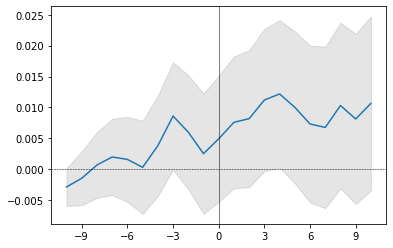

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.003        0.002  -0.003         0.002  -1.191    0.234
-9   0.001        0.002  -0.001         0.003  -0.429    0.668
-8   0.002        0.002   0.001         0.004   0.165    0.869
-7   0.001        0.002   0.002         0.005   0.414    0.679
-6  -0.000        0.002   0.002         0.005   0.297    0.767
-5  -0.001        0.002     0.0         0.006   0.053    0.958
-4   0.004        0.002   0.004         0.006   0.601    0.548
-3   0.005        0.002   0.009         0.007   1.267    0.205
-2  -0.003        0.002   0.006         0.007   0.833    0.405
-1  -0.003        0.002   0.003         0.008   0.332    0.740
0    0.002        0.002   0.005         0.008   0.619    0.536
1    0.003        0.002   0.008         0.008   0.913    0.361
2    0.001        0.002   0.008         0.009   0.946    0.344
3    0.003        0.002   0.011         0.009   1.247    0.212
4    0.001        0.002   0.012         0.009   1.310    0.190
5   -0.002        0.002    0.01         0.010   1.044    0.297
6   -0.003        0.002   0.007         0.010   0.740    0.459
7   -0.001        0.002   0.007         0.010   0.664    0.506
8    0.004        0.002    0.01         0.010   0.985    0.325
9   -0.002        0.002   0.008         0.011   0.758    0.449
10   0.003        0.002   0.011         0.011   0.968    0.333

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.003     0.000     4.605    -1.095 -0.097        -0.010        -0.001   
-9  -0.001     0.001     8.327    -1.374 -0.172        -0.016         0.000   
-8   0.001     0.002     8.309    -1.371 -0.224        -0.015         0.002   
-7   0.002     0.002     7.121    -0.866 -0.259        -0.021         0.003   
-6   0.002     0.003     5.783    -0.821 -0.268        -0.023         0.005   
-5   0.000     0.003     5.124    -0.798 -0.269        -0.029         0.003   
-4   0.004     0.003     2.158    -0.054 -0.189        -0.025         0.001   
-3   0.009     0.003     2.604     0.349 -0.178        -0.021         0.005   
-2   0.006     0.004     2.285    -0.167 -0.252        -0.030         0.006   
-1   0.003     0.005     2.789    -0.558 -0.313        -0.029         0.007   
0    0.005     0.005     1.701    -0.432 -0.230        -0.027         0.007   
1    0.008     0.007     5.138    -0.765 -0.419        -0.033         0.006   
2    0.008     0.006     0.688     0.160 -0.187        -0.037         0.005   
3    0.011     0.006     0.185     0.074 -0.218        -0.035         0.007   
4    0.012     0.007     3.187     0.945 -0.184        -0.040         0.008   
5    0.010     0.006     0.849     0.624 -0.151        -0.046         0.002   
6    0.007     0.008     2.967     1.005 -0.212        -0.055        -0.000   
7    0.007     0.009     2.955     0.708 -0.245        -0.050         0.003   
8    0.010     0.010     1.078     0.367 -0.300        -0.054         0.009   
9    0.008     0.009     0.493     0.106 -0.276        -0.049         0.005   
10   0.011     0.010     1.054     0.395 -0.277        -0.049         0.005   

     Quantile 75%    Max  
-10         0.009  0.075  
-9          0.013  0.089  
-8          0.020  0.122  
-7          0.025  0.158  
-6          0.031  0.151  
-5          0.031  0.161  
-4          0.036  0.190  
-3          0.039  0.247  
-2          0.036  0.240  
-1          0.032  0.180  
0           0.040  0.227  
1           0.049  0.305  
2           0.037  0.237  
3           0.051  0.191  
4           0.049  0.404  
5           0.053  0.306  
6           0.056  0.404  
7           0.058  0.441  
8           0.057  0.373  
9           0.065  0.299  
10          0.064  0.364

BAC_N


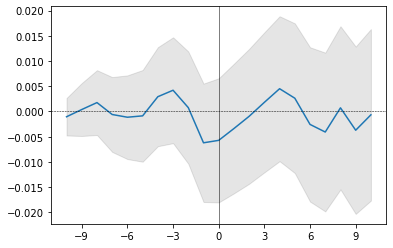

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.001        0.003  -0.001         0.003  -0.362    0.717
-9   0.001        0.003     0.0         0.004   0.095    0.925
-8   0.001        0.003   0.002         0.005   0.352    0.725
-7  -0.002        0.003  -0.001         0.006  -0.104    0.917
-6  -0.001        0.003  -0.001         0.006  -0.176    0.860
-5   0.000        0.003  -0.001         0.007  -0.122    0.903
-4   0.004        0.003   0.003         0.008   0.383    0.702
-3   0.001        0.003   0.004         0.008   0.514    0.607
-2  -0.003        0.003   0.001         0.009   0.088    0.930
-1  -0.007        0.003  -0.006         0.009  -0.678    0.498
0    0.000        0.003  -0.006         0.010  -0.596    0.551
1    0.002        0.003  -0.003         0.010  -0.337    0.736
2    0.002        0.003  -0.001         0.010  -0.091    0.927
3    0.003        0.003   0.002         0.011   0.167    0.867
4    0.003        0.003   0.005         0.011   0.402    0.687
5   -0.002        0.003   0.003         0.012   0.227    0.820
6   -0.005        0.003  -0.003         0.012  -0.215    0.830
7   -0.002        0.003  -0.004         0.012  -0.332    0.740
8    0.005        0.003   0.001         0.013   0.057    0.954
9   -0.004        0.003  -0.004         0.013  -0.287    0.774
10   0.003        0.003  -0.001         0.013  -0.050    0.960

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.001     0.001    12.461    -0.780 -0.202        -0.012         0.001   
-9   0.000     0.001     7.595     0.363 -0.175        -0.016        -0.001   
-8   0.002     0.002     5.262    -0.502 -0.220        -0.016         0.002   
-7  -0.001     0.003    13.312    -1.940 -0.381        -0.017        -0.000   
-6  -0.001     0.004    25.360    -3.269 -0.511        -0.025        -0.000   
-5  -0.001     0.008    47.011    -4.776 -0.800        -0.021         0.000   
-4   0.003     0.006    14.558    -0.643 -0.494        -0.029         0.005   
-3   0.004     0.011    19.083    -0.227 -0.647        -0.028         0.004   
-2   0.001     0.012    12.218     0.798 -0.554        -0.035         0.000   
-1  -0.006     0.014    12.413     0.700 -0.581        -0.043        -0.002   
0   -0.006     0.014    12.522     0.465 -0.512        -0.043         0.002   
1   -0.003     0.020    20.431     0.666 -0.795        -0.045         0.003   
2   -0.001     0.018    14.920     0.824 -0.589        -0.039         0.001   
3    0.002     0.020    10.240     0.172 -0.648        -0.042         0.004   
4    0.005     0.024    16.237     2.027 -0.559        -0.041         0.004   
5    0.003     0.025    13.338     1.335 -0.655        -0.048         0.001   
6   -0.003     0.030    13.924     1.431 -0.767        -0.059        -0.002   
7   -0.004     0.030    12.614     1.430 -0.731        -0.058        -0.006   
8    0.001     0.030    10.049     1.483 -0.511        -0.058        -0.006   
9   -0.004     0.025     7.975     1.208 -0.481        -0.055        -0.003   
10  -0.001     0.027    10.919     1.428 -0.555        -0.053        -0.002   

     Quantile 75%    Max  
-10         0.009  0.137  
-9          0.012  0.175  
-8          0.016  0.171  
-7          0.023  0.174  
-6          0.029  0.198  
-5          0.028  0.345  
-4          0.027  0.378  
-3          0.031  0.590  
-2          0.031  0.587  
-1          0.033  0.658  
0           0.038  0.690  
1           0.037  0.935  
2           0.034  0.851  
3           0.046  0.748  
4           0.047  1.014  
5           0.050  0.922  
6           0.050  1.023  
7           0.052  1.035  
8           0.055  0.999  
9           0.054  0.842  
10          0.056  0.978

C_N


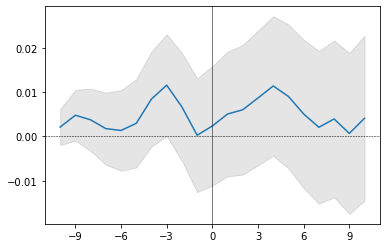

AAR  Std. E. AAR   CAAR  Std. E. CAAR  T-stat  P-value
-10  0.002        0.003  0.002         0.003   0.667    0.505
-9   0.003        0.003  0.005         0.004   1.068    0.286
-8  -0.001        0.003  0.004         0.006   0.683    0.495
-7  -0.002        0.003  0.002         0.006   0.279    0.780
-6  -0.000        0.003  0.001         0.007   0.191    0.849
-5   0.002        0.003  0.003         0.008   0.380    0.704
-4   0.006        0.003  0.008         0.008   1.007    0.314
-3   0.003        0.003  0.012         0.009   1.291    0.197
-2  -0.005        0.003  0.007         0.010   0.700    0.484
-1  -0.006        0.003    0.0         0.010   0.027    0.978
0    0.002        0.003  0.002         0.011   0.225    0.822
1    0.003        0.003  0.005         0.011   0.461    0.645
2    0.001        0.003  0.006         0.011   0.527    0.598
3    0.003        0.003  0.009         0.012   0.732    0.464
4    0.003        0.003  0.011         0.012   0.928    0.354
5   -0.002        0.003  0.009         0.013   0.712    0.477
6   -0.004        0.003  0.005         0.013   0.388    0.698
7   -0.003        0.003  0.002         0.013   0.153    0.878
8    0.002        0.003  0.004         0.014   0.286    0.775
9   -0.003        0.003  0.001         0.014   0.048    0.962
10   0.003        0.003  0.004         0.015   0.282    0.778

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.002     0.002    19.673     2.185 -0.163        -0.011        -0.001   
-9   0.005     0.002    21.508     3.347 -0.111        -0.016        -0.000   
-8   0.004     0.004    14.443     0.556 -0.326        -0.019         0.001   
-7   0.002     0.005    17.461    -1.386 -0.464        -0.022         0.001   
-6   0.001     0.005    20.534    -2.714 -0.539        -0.026         0.005   
-5   0.003     0.009    29.935    -3.385 -0.736        -0.029         0.001   
-4   0.008     0.007     6.587     0.048 -0.414        -0.028         0.001   
-3   0.012     0.010    11.361    -0.255 -0.562        -0.023         0.005   
-2   0.007     0.011     6.694     0.581 -0.437        -0.034         0.002   
-1   0.000     0.017    14.736     1.580 -0.465        -0.039        -0.001   
0    0.002     0.016    21.826     2.163 -0.505        -0.037         0.005   
1    0.005     0.022    28.016     2.573 -0.686        -0.040         0.008   
2    0.006     0.020    20.734     2.362 -0.532        -0.041         0.004   
3    0.009     0.021    18.927     2.196 -0.528        -0.047         0.007   
4    0.011     0.024    27.492     3.784 -0.411        -0.051         0.009   
5    0.009     0.025    24.675     3.458 -0.443        -0.046         0.008   
6    0.005     0.026    22.788     3.402 -0.375        -0.059         0.009   
7    0.002     0.026    20.246     3.209 -0.319        -0.057        -0.002   
8    0.004     0.027    14.496     2.465 -0.379        -0.048         0.001   
9    0.001     0.025    12.783     2.286 -0.337        -0.066        -0.006   
10   0.004     0.026    16.866     2.732 -0.389        -0.063        -0.007   

     Quantile 75%    Max  
-10         0.011  0.294  
-9          0.019  0.331  
-8          0.021  0.380  
-7          0.023  0.321  
-6          0.034  0.195  
-5          0.034  0.308  
-4          0.036  0.374  
-3          0.040  0.461  
-2          0.040  0.534  
-1          0.033  0.846  
0           0.040  0.928  
1           0.047  1.148  
2           0.048  1.017  
3           0.051  1.036  
4           0.055  1.217  
5           0.049  1.192  
6           0.052  1.177  
7           0.053  1.147  
8           0.059  1.081  
9           0.057  0.997  
10          0.057  1.092

WFC_N


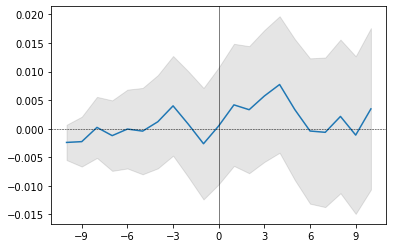

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.002        0.002  -0.002         0.002  -0.997    0.319
-9   0.000        0.002  -0.002         0.003  -0.664    0.507
-8   0.002        0.002     0.0         0.004   0.056    0.956
-7  -0.001        0.002  -0.001         0.005  -0.251    0.802
-6   0.001        0.002    -0.0         0.005  -0.011    0.991
-5  -0.000        0.002    -0.0         0.006  -0.071    0.943
-4   0.002        0.002   0.001         0.006   0.192    0.848
-3   0.003        0.002   0.004         0.007   0.588    0.557
-2  -0.003        0.002   0.001         0.007   0.111    0.912
-1  -0.003        0.002  -0.003         0.008  -0.345    0.730
0    0.003        0.002   0.001         0.008   0.063    0.950
1    0.004        0.002   0.004         0.008   0.501    0.617
2   -0.001        0.002   0.003         0.009   0.384    0.701
3    0.002        0.002   0.006         0.009   0.636    0.525
4    0.002        0.002   0.008         0.009   0.830    0.407
5   -0.004        0.002   0.003         0.010   0.348    0.728
6   -0.004        0.002    -0.0         0.010  -0.040    0.968
7   -0.000        0.002  -0.001         0.010  -0.062    0.951
8    0.003        0.002   0.002         0.010   0.205    0.837
9   -0.003        0.002  -0.001         0.011  -0.103    0.918
10   0.005        0.002   0.003         0.011   0.315    0.753

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.002     0.001     5.370    -0.976 -0.100        -0.008        -0.001   
-9  -0.002     0.001     3.887    -0.732 -0.128        -0.015        -0.002   
-8   0.000     0.002    22.437     0.156 -0.289        -0.013        -0.001   
-7  -0.001     0.002     7.238    -0.943 -0.230        -0.019         0.001   
-6  -0.000     0.003     9.698    -0.799 -0.291        -0.019         0.003   
-5  -0.000     0.004    32.002    -3.762 -0.522        -0.016         0.001   
-4   0.001     0.003    12.154    -1.755 -0.360        -0.017         0.001   
-3   0.004     0.004    13.937    -1.185 -0.409        -0.017         0.002   
-2   0.001     0.005     9.750    -0.679 -0.406        -0.019        -0.001   
-1  -0.003     0.006     9.884    -1.375 -0.435        -0.024        -0.001   
0    0.001     0.007    11.001    -1.368 -0.436        -0.017         0.004   
1    0.004     0.008    27.564    -1.378 -0.659        -0.018         0.006   
2    0.003     0.008    12.218    -0.874 -0.505        -0.027         0.002   
3    0.006     0.008    12.010    -1.157 -0.551        -0.026         0.006   
4    0.008     0.011    15.851     0.992 -0.551        -0.034         0.003   
5    0.003     0.010    12.810    -0.160 -0.582        -0.034         0.001   
6   -0.000     0.012    12.781     0.979 -0.543        -0.036        -0.001   
7   -0.001     0.011     9.148     1.424 -0.354        -0.040        -0.001   
8    0.002     0.012     7.706     0.863 -0.356        -0.036         0.003   
9   -0.001     0.010     5.998     0.275 -0.345        -0.030         0.000   
10   0.003     0.010     8.036     1.006 -0.334        -0.041         0.003   

     Quantile 75%    Max  
-10         0.007  0.078  
-9          0.009  0.068  
-8          0.015  0.299  
-7          0.014  0.190  
-6          0.017  0.197  
-5          0.020  0.207  
-4          0.021  0.168  
-3          0.024  0.297  
-2          0.027  0.297  
-1          0.027  0.281  
0           0.029  0.351  
1           0.033  0.537  
2           0.036  0.428  
3           0.031  0.337  
4           0.033  0.573  
5           0.036  0.464  
6           0.032  0.600  
7           0.037  0.539  
8           0.036  0.540  
9           0.040  0.471  
10          0.044  0.527

GS


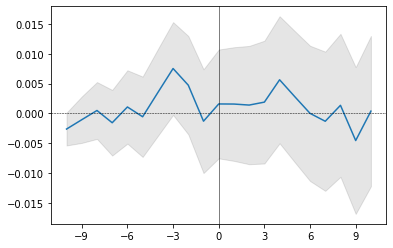

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.003        0.002  -0.003         0.002  -1.216    0.224
-9   0.002        0.002  -0.001         0.003  -0.344    0.731
-8   0.002        0.002   0.001         0.004   0.135    0.892
-7  -0.002        0.002  -0.002         0.004  -0.361    0.718
-6   0.003        0.002   0.001         0.005   0.228    0.820
-5  -0.002        0.002  -0.001         0.005  -0.104    0.917
-4   0.004        0.002   0.004         0.006   0.619    0.536
-3   0.004        0.002   0.008         0.006   1.242    0.214
-2  -0.003        0.002   0.005         0.006   0.737    0.461
-1  -0.006        0.002  -0.001         0.007  -0.190    0.849
0    0.003        0.002   0.002         0.007   0.225    0.822
1   -0.000        0.002   0.002         0.007   0.213    0.831
2   -0.000        0.002   0.001         0.008   0.182    0.855
3    0.000        0.002   0.002         0.008   0.237    0.812
4    0.004        0.002   0.006         0.008   0.680    0.497
5   -0.003        0.002   0.003         0.009   0.328    0.743
6   -0.003        0.002     0.0         0.009   0.003    0.998
7   -0.001        0.002  -0.001         0.009  -0.143    0.886
8    0.003        0.002   0.001         0.009   0.147    0.883
9   -0.006        0.002  -0.005         0.010  -0.473    0.637
10   0.005        0.002     0.0         0.010   0.040    0.968

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.003     0.001     5.551    -1.129 -0.123        -0.012        -0.003   
-9  -0.001     0.001     3.680    -0.647 -0.147        -0.017        -0.003   
-8   0.001     0.002    11.829    -1.455 -0.291        -0.021         0.000   
-7  -0.002     0.003    13.312    -2.092 -0.355        -0.024        -0.000   
-6   0.001     0.003     0.516    -0.301 -0.164        -0.032        -0.001   
-5  -0.001     0.003     5.020    -1.175 -0.284        -0.032        -0.000   
-4   0.004     0.003     0.785    -0.043 -0.204        -0.034        -0.004   
-3   0.008     0.004     1.689     0.746 -0.143        -0.030         0.005   
-2   0.005     0.005     1.496     0.604 -0.164        -0.037         0.007   
-1  -0.001     0.006     1.712     0.190 -0.238        -0.047         0.002   
0    0.002     0.007     1.813    -0.004 -0.254        -0.049         0.011   
1    0.002     0.008     2.480    -0.321 -0.393        -0.058         0.005   
2    0.001     0.010     4.096    -0.664 -0.473        -0.057         0.010   
3    0.002     0.010     2.335    -0.406 -0.427        -0.055         0.006   
4    0.006     0.010     1.827     0.207 -0.339        -0.055         0.006   
5    0.003     0.010     1.334     0.100 -0.309        -0.058         0.003   
6    0.000     0.011     1.390     0.105 -0.359        -0.063         0.002   
7   -0.001     0.013     1.292     0.108 -0.373        -0.067        -0.001   
8    0.001     0.014     2.299    -0.226 -0.491        -0.069         0.007   
9   -0.005     0.017     4.101    -0.883 -0.623        -0.063         0.006   
10   0.000     0.015     1.090     0.030 -0.385        -0.070         0.004   

     Quantile 75%    Max  
-10         0.010  0.074  
-9          0.016  0.087  
-8          0.023  0.178  
-7          0.028  0.127  
-6          0.038  0.112  
-5          0.037  0.150  
-4          0.039  0.150  
-3          0.040  0.252  
-2          0.040  0.259  
-1          0.047  0.305  
0           0.052  0.324  
1           0.048  0.281  
2           0.048  0.310  
3           0.053  0.323  
4           0.057  0.361  
5           0.055  0.346  
6           0.056  0.381  
7           0.057  0.372  
8           0.066  0.348  
9           0.066  0.366  
10          0.066  0.359

MS_N


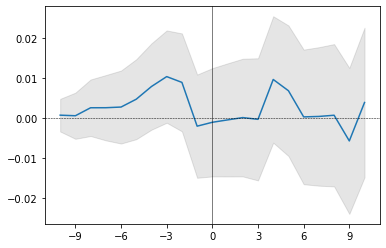

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10  0.001        0.003   0.001         0.003   0.226    0.822
-9  -0.000        0.003   0.001         0.004   0.128    0.898
-8   0.002        0.003   0.003         0.006   0.466    0.641
-7   0.000        0.003   0.003         0.006   0.405    0.685
-6   0.000        0.003   0.003         0.007   0.386    0.700
-5   0.002        0.003   0.005         0.008   0.604    0.546
-4   0.003        0.003   0.008         0.008   0.936    0.349
-3   0.002        0.003    0.01         0.009   1.150    0.250
-2  -0.001        0.003   0.009         0.010   0.933    0.351
-1  -0.011        0.003  -0.002         0.010  -0.202    0.840
0    0.001        0.003  -0.001         0.011  -0.100    0.920
1    0.001        0.003    -0.0         0.011  -0.042    0.966
2    0.001        0.003     0.0         0.011   0.010    0.992
3   -0.000        0.003    -0.0         0.012  -0.027    0.978
4    0.010        0.003    0.01         0.012   0.782    0.434
5   -0.003        0.003   0.007         0.013   0.536    0.592
6   -0.007        0.003     0.0         0.013   0.022    0.983
7    0.000        0.003     0.0         0.013   0.030    0.976
8    0.000        0.003   0.001         0.014   0.050    0.960
9   -0.006        0.003  -0.006         0.014  -0.402    0.688
10   0.010        0.003   0.004         0.015   0.266    0.790

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.001     0.001     9.484     1.103 -0.140        -0.013        -0.001   
-9   0.001     0.002     8.536    -0.897 -0.249        -0.019         0.000   
-8   0.003     0.004    26.699    -2.993 -0.503        -0.020         0.007   
-7   0.003     0.005    13.601    -2.016 -0.463        -0.025         0.002   
-6   0.003     0.005     3.553    -0.632 -0.268        -0.033         0.006   
-5   0.005     0.005     6.873    -1.170 -0.385        -0.028         0.003   
-4   0.008     0.005     1.940     0.226 -0.248        -0.035         0.008   
-3   0.010     0.008     5.038     0.241 -0.367        -0.035         0.013   
-2   0.009     0.009     2.894     0.595 -0.275        -0.036         0.011   
-1  -0.002     0.010     2.194    -0.460 -0.373        -0.048         0.009   
0   -0.001     0.013     6.426    -1.589 -0.532        -0.053         0.014   
1   -0.000     0.015     7.943    -1.756 -0.642        -0.046         0.012   
2    0.000     0.018    13.768    -2.665 -0.840        -0.049         0.018   
3   -0.000     0.022    20.738    -3.274 -1.069        -0.043         0.011   
4    0.010     0.013     3.202    -0.547 -0.468        -0.039         0.014   
5    0.007     0.014     3.354    -0.553 -0.512        -0.059         0.010   
6    0.000     0.019     7.716    -1.424 -0.769        -0.064         0.017   
7    0.000     0.021     7.492    -1.132 -0.813        -0.066         0.014   
8    0.001     0.027    14.757    -2.231 -1.102        -0.061         0.014   
9   -0.006     0.032    21.378    -3.224 -1.326        -0.068         0.016   
10   0.004     0.019     2.480    -0.623 -0.576        -0.050         0.010   

     Quantile 75%    Max  
-10         0.013  0.180  
-9          0.020  0.143  
-8          0.025  0.228  
-7          0.034  0.199  
-6          0.040  0.220  
-5          0.037  0.238  
-4          0.045  0.239  
-3          0.052  0.416  
-2          0.050  0.407  
-1          0.043  0.306  
0           0.052  0.276  
1           0.053  0.325  
2           0.058  0.295  
3           0.060  0.277  
4           0.062  0.331  
5           0.054  0.350  
6           0.058  0.394  
7           0.062  0.470  
8           0.072  0.409  
9           0.067  0.369  
10          0.071  0.379

HSBA_L


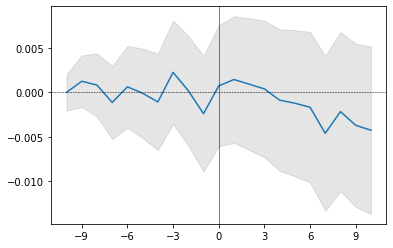

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.000        0.002    -0.0         0.002  -0.002    0.998
-9   0.001        0.002   0.001         0.002   0.547    0.584
-8  -0.000        0.002   0.001         0.003   0.293    0.769
-7  -0.002        0.002  -0.001         0.003  -0.356    0.722
-6   0.002        0.002   0.001         0.004   0.173    0.863
-5  -0.001        0.002    -0.0         0.004  -0.027    0.978
-4  -0.001        0.002  -0.001         0.004  -0.255    0.799
-3   0.003        0.002   0.002         0.005   0.495    0.620
-2  -0.002        0.002     0.0         0.005   0.038    0.970
-1  -0.003        0.002  -0.002         0.005  -0.474    0.635
0    0.003        0.002   0.001         0.005   0.136    0.892
1    0.001        0.002   0.001         0.006   0.259    0.796
2   -0.001        0.002   0.001         0.006   0.158    0.874
3   -0.001        0.002     0.0         0.006   0.064    0.949
4   -0.001        0.002  -0.001         0.006  -0.142    0.887
5   -0.000        0.002  -0.001         0.006  -0.191    0.848
6   -0.000        0.002  -0.002         0.007  -0.253    0.800
7   -0.003        0.002  -0.005         0.007  -0.678    0.498
8    0.002        0.002  -0.002         0.007  -0.310    0.756
9   -0.002        0.002  -0.004         0.007  -0.518    0.605
10  -0.001        0.002  -0.004         0.007  -0.580    0.562

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.000     0.000     2.304     0.684 -0.041        -0.008        -0.001   
-9   0.001     0.000     1.552     0.353 -0.062        -0.009         0.002   
-8   0.001     0.001     5.640     0.884 -0.096        -0.014        -0.001   
-7  -0.001     0.001     3.760    -0.390 -0.151        -0.017        -0.001   
-6   0.001     0.001     4.263    -0.664 -0.166        -0.018         0.002   
-5  -0.000     0.002    21.561    -3.041 -0.306        -0.017        -0.001   
-4  -0.001     0.002     8.057    -1.645 -0.237        -0.018         0.001   
-3   0.002     0.002     5.229    -0.683 -0.220        -0.015         0.003   
-2   0.000     0.003     6.411    -1.165 -0.253        -0.023        -0.000   
-1  -0.002     0.003     7.847    -1.080 -0.323        -0.026        -0.004   
0    0.001     0.003     5.154    -0.332 -0.256        -0.019         0.001   
1    0.001     0.003     3.818    -0.429 -0.256        -0.021         0.004   
2    0.001     0.003     2.663     0.271 -0.194        -0.027         0.002   
3    0.000     0.004     2.493     0.202 -0.182        -0.028         0.003   
4   -0.001     0.005     6.346     1.096 -0.199        -0.028         0.003   
5   -0.001     0.004     7.328     1.427 -0.156        -0.029         0.003   
6   -0.002     0.005     8.434     1.595 -0.154        -0.030         0.003   
7   -0.005     0.006     7.606     1.399 -0.203        -0.034        -0.003   
8   -0.002     0.006     7.749     1.492 -0.226        -0.035        -0.002   
9   -0.004     0.005     5.124     0.986 -0.232        -0.041         0.000   
10  -0.004     0.006     6.328     1.101 -0.254        -0.044        -0.006   

     Quantile 75%    Max  
-10         0.007  0.063  
-9          0.009  0.075  
-8          0.013  0.163  
-7          0.017  0.120  
-6          0.018  0.119  
-5          0.019  0.083  
-4          0.019  0.088  
-3          0.021  0.122  
-2          0.022  0.137  
-1          0.020  0.169  
0           0.022  0.216  
1           0.025  0.197  
2           0.026  0.247  
3           0.025  0.243  
4           0.024  0.332  
5           0.021  0.343  
6           0.021  0.407  
7           0.027  0.396  
8           0.028  0.400  
9           0.024  0.343  
10          0.021  0.358

BNPP_PA


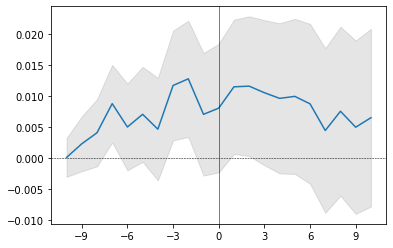

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-10  0.000        0.002      0.0         0.002   0.036    0.971
-9   0.002        0.002    0.002         0.003   0.664    0.507
-8   0.002        0.002    0.004         0.004   0.963    0.335
-7   0.005        0.002  0.009 *         0.005   1.798    0.072
-6  -0.004        0.002    0.005         0.005   0.917    0.359
-5   0.002        0.002    0.007         0.006   1.180    0.238
-4  -0.002        0.002    0.005         0.006   0.720    0.471
-3   0.007        0.002  0.012 *         0.007   1.695    0.090
-2   0.001        0.002  0.013 *         0.007   1.745    0.081
-1  -0.006        0.002    0.007         0.008   0.913    0.361
0    0.001        0.002    0.008         0.008   0.994    0.320
1    0.003        0.002    0.011         0.008   1.359    0.174
2    0.000        0.002    0.012         0.009   1.318    0.188
3   -0.001        0.002    0.011         0.009   1.154    0.249
4   -0.001        0.002     0.01         0.009   1.018    0.309
5    0.000        0.002     0.01         0.010   1.019    0.308
6   -0.001        0.002    0.009         0.010   0.869    0.385
7   -0.004        0.002    0.004         0.010   0.428    0.668
8    0.003        0.002    0.008         0.011   0.709    0.478
9   -0.003        0.002    0.005         0.011   0.455    0.649
10   0.002        0.002    0.007         0.011   0.581    0.561

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.000     0.001    11.035     1.369 -0.121        -0.013        -0.002   
-9   0.002     0.002     4.783     1.114 -0.108        -0.016         0.001   
-8   0.004     0.003    20.241     2.926 -0.153        -0.021         0.001   
-7   0.009     0.004     9.112     1.802 -0.140        -0.030         0.002   
-6   0.005     0.005     6.832     0.992 -0.242        -0.031         0.000   
-5   0.007     0.005     5.705    -0.144 -0.343        -0.028         0.003   
-4   0.005     0.006     3.278    -0.008 -0.317        -0.032        -0.000   
-3   0.012     0.007     3.921     0.302 -0.350        -0.024         0.005   
-2   0.013     0.009     4.152     0.098 -0.422        -0.025         0.007   
-1   0.007     0.010     3.657     0.844 -0.245        -0.037        -0.000   
0    0.008     0.010     4.775     0.646 -0.319        -0.038         0.006   
1    0.011     0.010     5.015     0.739 -0.346        -0.028         0.005   
2    0.012     0.011     6.343     0.932 -0.381        -0.038         0.004   
3    0.011     0.011     4.431     0.983 -0.275        -0.049         0.006   
4    0.010     0.013     5.983     1.156 -0.326        -0.046         0.002   
5    0.010     0.011     5.380     1.382 -0.223        -0.049         0.004   
6    0.009     0.013     5.278     1.379 -0.228        -0.065         0.010   
7    0.004     0.015     4.948     1.084 -0.287        -0.054         0.003   
8    0.008     0.017     4.685     0.811 -0.387        -0.047         0.006   
9    0.005     0.016     2.924     0.480 -0.371        -0.063        -0.003   
10   0.007     0.016     3.884     0.807 -0.333        -0.060         0.003   

     Quantile 75%    Max  
-10         0.011  0.190  
-9          0.020  0.191  
-8          0.022  0.398  
-7          0.037  0.366  
-6          0.036  0.374  
-5          0.037  0.298  
-4          0.043  0.287  
-3          0.044  0.310  
-2          0.051  0.317  
-1          0.049  0.416  
0           0.046  0.421  
1           0.048  0.464  
2           0.046  0.512  
3           0.055  0.488  
4           0.061  0.585  
5           0.059  0.522  
6           0.051  0.526  
7           0.055  0.551  
8           0.063  0.561  
9           0.071  0.474  
10          0.064  0.510

CAGR_PA


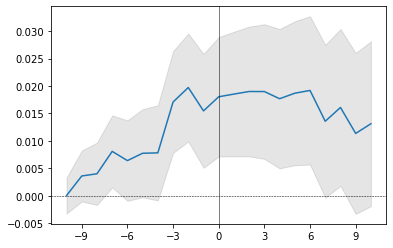

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-10  0.000        0.003       0.0         0.003   0.013    0.990
-9   0.004        0.003     0.004         0.004   0.994    0.320
-8   0.000        0.003     0.004         0.004   0.903    0.367
-7   0.004        0.003     0.008         0.005   1.579    0.114
-6  -0.002        0.003     0.006         0.006   1.119    0.263
-5   0.001        0.003     0.008         0.006   1.235    0.217
-4   0.000        0.003     0.008         0.007   1.154    0.249
-3   0.009        0.003  0.017 **         0.007   2.360    0.018
-2   0.003        0.003   0.02 **         0.008   2.569    0.010
-1  -0.004        0.003   0.015 *         0.008   1.911    0.056
0    0.003        0.003  0.018 **         0.008   2.125    0.034
1    0.000        0.003  0.019 **         0.009   2.090    0.037
2    0.000        0.003  0.019 **         0.009   2.059    0.040
3   -0.000        0.003  0.019 **         0.010   1.983    0.047
4   -0.001        0.003   0.018 *         0.010   1.784    0.074
5    0.001        0.003   0.019 *         0.010   1.825    0.068
6    0.001        0.003   0.019 *         0.011   1.819    0.069
7   -0.006        0.003     0.014         0.011   1.250    0.211
8    0.003        0.003     0.016         0.011   1.442    0.149
9   -0.005        0.003     0.011         0.011   0.992    0.321
10   0.002        0.003     0.013         0.012   1.119    0.263

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.000     0.001    11.321     1.720 -0.107        -0.012        -0.003   
-9   0.004     0.002     6.541     1.389 -0.141        -0.018        -0.001   
-8   0.004     0.003     9.541     1.659 -0.148        -0.027         0.001   
-7   0.008     0.004     3.486     0.476 -0.175        -0.026         0.008   
-6   0.006     0.004     3.062    -0.023 -0.243        -0.022         0.006   
-5   0.008     0.004     1.542    -0.148 -0.197        -0.027         0.013   
-4   0.008     0.005     0.803     0.115 -0.166        -0.027         0.005   
-3   0.017     0.007     2.287     0.678 -0.208        -0.026         0.012   
-2   0.020     0.009     2.137     0.561 -0.225        -0.031         0.018   
-1   0.015     0.010     1.866     0.366 -0.254        -0.038         0.015   
0    0.018     0.010     2.263     0.154 -0.286        -0.029         0.018   
1    0.019     0.011     2.142    -0.069 -0.332        -0.031         0.022   
2    0.019     0.013     2.519     0.056 -0.394        -0.035         0.017   
3    0.019     0.014     2.089     0.184 -0.336        -0.037         0.018   
4    0.018     0.014     1.784     0.214 -0.302        -0.036         0.015   
5    0.019     0.014     1.684     0.266 -0.268        -0.036         0.023   
6    0.019     0.016     1.972     0.369 -0.317        -0.049         0.027   
7    0.014     0.018     2.151     0.197 -0.388        -0.045         0.019   
8    0.016     0.020     2.079     0.230 -0.448        -0.044         0.018   
9    0.011     0.021     1.344     0.081 -0.436        -0.057         0.008   
10   0.013     0.019     1.604     0.243 -0.425        -0.062         0.014   

     Quantile 75%    Max  
-10         0.012  0.184  
-9          0.022  0.219  
-8          0.026  0.327  
-7          0.037  0.296  
-6          0.037  0.245  
-5          0.040  0.195  
-4          0.046  0.242  
-3          0.054  0.332  
-2          0.058  0.361  
-1          0.057  0.350  
0           0.062  0.373  
1           0.067  0.368  
2           0.073  0.403  
3           0.075  0.422  
4           0.080  0.442  
5           0.076  0.435  
6           0.084  0.443  
7           0.079  0.461  
8           0.074  0.519  
9           0.079  0.495  
10          0.069  0.523

SAN_MC


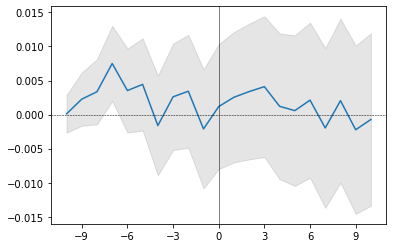

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-10  0.000        0.002      0.0         0.002   0.051    0.959
-9   0.002        0.002    0.002         0.003   0.742    0.458
-8   0.001        0.002    0.003         0.004   0.898    0.369
-7   0.004        0.002  0.007 *         0.004   1.740    0.082
-6  -0.004        0.002    0.004         0.005   0.732    0.464
-5   0.001        0.002    0.004         0.005   0.839    0.402
-4  -0.006        0.002   -0.002         0.006  -0.283    0.777
-3   0.004        0.002    0.003         0.006   0.427    0.669
-2   0.001        0.002    0.003         0.006   0.530    0.596
-1  -0.006        0.002   -0.002         0.007  -0.309    0.757
0    0.003        0.002    0.001         0.007   0.165    0.869
1    0.001        0.002    0.003         0.007   0.341    0.733
2    0.001        0.002    0.003         0.008   0.434    0.664
3    0.001        0.002    0.004         0.008   0.508    0.611
4   -0.003        0.002    0.001         0.008   0.145    0.884
5   -0.001        0.002    0.001         0.009   0.067    0.946
6    0.002        0.002    0.002         0.009   0.238    0.812
7   -0.004        0.002   -0.002         0.009  -0.215    0.830
8    0.004        0.002    0.002         0.009   0.218    0.828
9   -0.004        0.002   -0.002         0.010  -0.231    0.817
10   0.002        0.002   -0.001         0.010  -0.073    0.942

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.000     0.001     4.556    -0.965 -0.104        -0.010         0.001   
-9   0.002     0.001     4.274    -0.095 -0.164        -0.017         0.001   
-8   0.003     0.002     5.787     0.186 -0.211        -0.016         0.000   
-7   0.007     0.003     1.803     0.392 -0.168        -0.023         0.006   
-6   0.004     0.003     2.779     0.033 -0.231        -0.027         0.002   
-5   0.004     0.004     2.650    -0.010 -0.234        -0.026         0.006   
-4  -0.002     0.005     1.454    -0.086 -0.227        -0.038         0.002   
-3   0.003     0.006     1.810     0.046 -0.269        -0.034         0.003   
-2   0.003     0.007     3.772    -0.343 -0.398        -0.035        -0.004   
-1  -0.002     0.008     4.329    -0.452 -0.449        -0.049        -0.007   
0    0.001     0.008     4.428    -0.455 -0.446        -0.047        -0.003   
1    0.003     0.009     1.117     0.054 -0.283        -0.044        -0.003   
2    0.003     0.009     1.050     0.369 -0.263        -0.050        -0.001   
3    0.004     0.009     1.055     0.340 -0.282        -0.056         0.002   
4    0.001     0.011     0.621     0.456 -0.238        -0.055        -0.006   
5    0.001     0.011     0.417     0.521 -0.213        -0.058        -0.005   
6    0.002     0.012     0.837     0.584 -0.261        -0.061        -0.014   
7   -0.002     0.014     0.947     0.301 -0.372        -0.067        -0.005   
8    0.002     0.014     1.085     0.399 -0.383        -0.058        -0.009   
9   -0.002     0.015     0.696     0.356 -0.369        -0.078        -0.013   
10  -0.001     0.016     1.044     0.499 -0.341        -0.077        -0.017   

     Quantile 75%    Max  
-10         0.012  0.075  
-9          0.019  0.125  
-8          0.026  0.226  
-7          0.031  0.199  
-6          0.030  0.188  
-5          0.031  0.218  
-4          0.033  0.213  
-3          0.032  0.233  
-2          0.039  0.273  
-1          0.039  0.280  
0           0.035  0.274  
1           0.045  0.264  
2           0.046  0.290  
3           0.048  0.292  
4           0.055  0.340  
5           0.057  0.338  
6           0.050  0.354  
7           0.051  0.359  
8           0.052  0.352  
9           0.052  0.361  
10          0.056  0.380

SOGN_PA


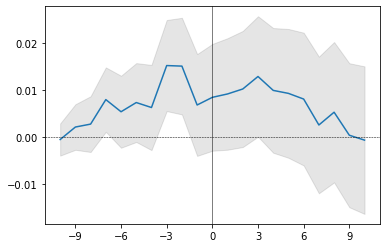

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.001        0.003    -0.001         0.003  -0.212    0.832
-9   0.003        0.003     0.002         0.004   0.553    0.581
-8   0.001        0.003     0.003         0.005   0.586    0.558
-7   0.005        0.003     0.008         0.005   1.483    0.138
-6  -0.003        0.003     0.005         0.006   0.894    0.372
-5   0.002        0.003     0.007         0.007   1.115    0.265
-4  -0.001        0.003     0.006         0.007   0.883    0.377
-3   0.009        0.003  0.015 **         0.008   2.007    0.045
-2  -0.000        0.003   0.015 *         0.008   1.877    0.061
-1  -0.008        0.003     0.007         0.008   0.802    0.423
0    0.002        0.003     0.008         0.009   0.948    0.343
1    0.001        0.003     0.009         0.009   0.986    0.324
2    0.001        0.003      0.01         0.010   1.057    0.291
3    0.003        0.003     0.013         0.010   1.284    0.199
4   -0.003        0.003      0.01         0.010   0.955    0.340
5   -0.001        0.003     0.009         0.011   0.865    0.387
6   -0.001        0.003     0.008         0.011   0.730    0.466
7   -0.006        0.003     0.003         0.011   0.223    0.824
8    0.003        0.003     0.005         0.012   0.450    0.653
9   -0.005        0.003       0.0         0.012   0.029    0.977
10  -0.001        0.003    -0.001         0.012  -0.057    0.955

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.001     0.001     6.048     0.241 -0.149        -0.015        -0.000   
-9   0.002     0.002     3.433     0.656 -0.136        -0.017         0.000   
-8   0.003     0.003     5.735     1.111 -0.146        -0.026         0.002   
-7   0.008     0.004     2.473     0.073 -0.232        -0.019         0.004   
-6   0.005     0.005     4.248    -0.657 -0.339        -0.025         0.006   
-5   0.007     0.005     4.358    -0.678 -0.352        -0.026         0.012   
-4   0.006     0.006     0.939    -0.130 -0.231        -0.028         0.004   
-3   0.015     0.008     1.802     0.476 -0.215        -0.032         0.007   
-2   0.015     0.010     2.024     0.484 -0.261        -0.036         0.010   
-1   0.007     0.013     2.959     0.427 -0.298        -0.048         0.005   
0    0.008     0.012     3.196     0.175 -0.369        -0.035         0.008   
1    0.009     0.014     3.647    -0.090 -0.403        -0.039         0.010   
2    0.010     0.015     2.894     0.232 -0.392        -0.061         0.011   
3    0.013     0.016     2.771     0.450 -0.363        -0.056         0.012   
4    0.010     0.018     2.733     0.542 -0.366        -0.058         0.017   
5    0.009     0.016     2.433     0.719 -0.306        -0.060         0.008   
6    0.008     0.018     3.708     0.805 -0.375        -0.070         0.007   
7    0.003     0.021     4.568     0.508 -0.456        -0.072         0.008   
8    0.005     0.023     4.658     0.575 -0.453        -0.075         0.013   
9    0.000     0.024     3.600     0.432 -0.482        -0.086         0.001   
10  -0.001     0.023     3.953     0.684 -0.459        -0.090        -0.005   

     Quantile 75%    Max  
-10         0.015  0.135  
-9          0.021  0.174  
-8          0.027  0.282  
-7          0.035  0.231  
-6          0.032  0.211  
-5          0.035  0.203  
-4          0.046  0.214  
-3          0.055  0.356  
-2          0.060  0.415  
-1          0.049  0.511  
0           0.054  0.480  
1           0.057  0.462  
2           0.064  0.475  
3           0.061  0.513  
4           0.068  0.558  
5           0.066  0.502  
6           0.071  0.570  
7           0.064  0.633  
8           0.067  0.718  
9           0.072  0.690  
10          0.069  0.713

BARC_L


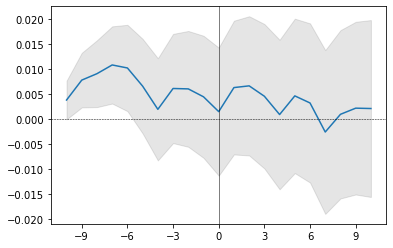

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-10  0.004        0.003    0.004         0.003   1.271    0.204
-9   0.004        0.003  0.008 *         0.004   1.834    0.067
-8   0.001        0.003  0.009 *         0.005   1.744    0.081
-7   0.002        0.003  0.011 *         0.006   1.800    0.072
-6  -0.001        0.003     0.01         0.007   1.520    0.128
-5  -0.004        0.003    0.007         0.007   0.895    0.371
-4  -0.005        0.003    0.002         0.008   0.247    0.805
-3   0.004        0.003    0.006         0.009   0.720    0.471
-2  -0.000        0.003    0.006         0.009   0.670    0.503
-1  -0.002        0.003    0.004         0.010   0.470    0.638
0   -0.003        0.003    0.002         0.010   0.151    0.880
1    0.005        0.003    0.006         0.010   0.606    0.545
2    0.000        0.003    0.007         0.011   0.614    0.539
3   -0.002        0.003    0.005         0.011   0.407    0.684
4   -0.004        0.003    0.001         0.012   0.080    0.937
5    0.004        0.003    0.005         0.012   0.387    0.699
6   -0.001        0.003    0.003         0.012   0.261    0.794
7   -0.006        0.003   -0.003         0.013  -0.201    0.841
8    0.004        0.003    0.001         0.013   0.074    0.941
9    0.001        0.003    0.002         0.013   0.164    0.870
10  -0.000        0.003    0.002         0.014   0.155    0.877

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.004     0.006    74.694     7.748 -0.115        -0.018        -0.000   
-9   0.008     0.006    65.819     7.013 -0.132        -0.023         0.002   
-8   0.009     0.011    60.249     6.329 -0.289        -0.023         0.005   
-7   0.011     0.011    40.470     4.597 -0.310        -0.022         0.004   
-6   0.010     0.015    32.836     3.039 -0.556        -0.024         0.003   
-5   0.007     0.016    33.345     0.262 -0.857        -0.023         0.001   
-4   0.002     0.017    32.435    -0.599 -0.941        -0.039        -0.002   
-3   0.006     0.020    34.014    -1.088 -1.058        -0.039         0.003   
-2   0.006     0.025    33.428    -1.502 -1.186        -0.047         0.002   
-1   0.004     0.018    25.160     3.311 -0.430        -0.056        -0.005   
0    0.002     0.021    29.083     3.608 -0.399        -0.056        -0.005   
1    0.006     0.023    21.778     2.556 -0.606        -0.053        -0.003   
2    0.007     0.027    15.816     1.536 -0.701        -0.059        -0.000   
3    0.005     0.031    14.299     0.676 -0.820        -0.069        -0.000   
4    0.001     0.033    13.389     0.489 -0.953        -0.069         0.001   
5    0.005     0.024    12.419     2.329 -0.484        -0.076        -0.012   
6    0.003     0.026    10.909     2.041 -0.569        -0.080        -0.003   
7   -0.003     0.031    11.313     2.055 -0.651        -0.095        -0.003   
8    0.001     0.034    12.280     2.267 -0.620        -0.087        -0.009   
9    0.002     0.032    11.293     2.027 -0.549        -0.084        -0.010   
10   0.002     0.033    11.306     2.140 -0.549        -0.085        -0.014   

     Quantile 75%    Max  
-10         0.012  0.755  
-9          0.021  0.784  
-8          0.024  0.993  
-7          0.035  0.931  
-6          0.036  1.007  
-5          0.030  0.897  
-4          0.033  0.861  
-3          0.043  0.912  
-2          0.049  0.955  
-1          0.044  1.031  
0           0.044  1.149  
1           0.047  1.102  
2           0.051  1.059  
3           0.065  1.019  
4           0.067  0.987  
5           0.067  0.945  
6           0.060  0.903  
7           0.061  0.982  
8           0.056  1.026  
9           0.053  0.996  
10          0.054  1.001

In [64]:
for ticker, event in releases_10_100.items():
    print(ticker)
    event.plot()
    plt.show()
    display(event.results())
    display(event.get_CAR_dist())

In [65]:
#using the event study (formula for each element of the tickers list (event window: +-10 / estimation size: 200)
tickers = ['JPM_N','BAC_N','C_N','WFC_N','GS','MS_N','HSBA_L','BNPP_PA','CAGR_PA','SAN_MC','SOGN_PA','BARC_L']
releases_10_200 = dict()

for ticker in tickers:
    events = [event for event in event_database if event['security_ticker']==ticker]
    
    releases_10_200[ticker] = es.Multiple.from_list(
        events,
        es.Single.FamaFrench_3factor,
        event_window= (-10,+10),
        estimation_size = 200)

2022-05-29 12:33:38,323 P[5368] [MainThread 14260]  8 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:38,507 P[5368] [MainThread 14260]  8 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:38,678 P[5368] [MainThread 14260]  8 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:38,880 P[5368] [MainThread 14260]  8 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:39,038 P[5368] [MainThread 14260]  8 events have not been processed due

JPM_N


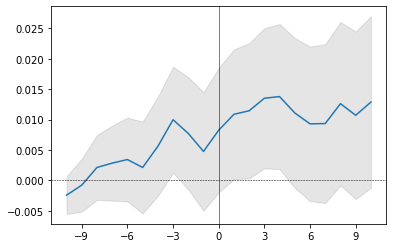

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.002        0.002  -0.002         0.002  -1.012    0.312
-9   0.002        0.002  -0.001         0.003  -0.230    0.818
-8   0.003        0.002   0.002         0.004   0.511    0.609
-7   0.001        0.002   0.003         0.005   0.591    0.554
-6   0.001        0.002   0.003         0.005   0.638    0.523
-5  -0.001        0.002   0.002         0.006   0.361    0.718
-4   0.003        0.002   0.006         0.006   0.881    0.378
-3   0.004        0.002    0.01         0.007   1.468    0.142
-2  -0.002        0.002   0.008         0.007   1.071    0.284
-1  -0.003        0.002   0.005         0.008   0.626    0.531
0    0.003        0.002   0.008         0.008   1.036    0.300
1    0.003        0.002   0.011         0.008   1.306    0.192
2    0.001        0.002   0.011         0.009   1.321    0.186
3    0.002        0.002   0.014         0.009   1.503    0.133
4    0.000        0.002   0.014         0.009   1.480    0.139
5   -0.003        0.002   0.011         0.010   1.153    0.249
6   -0.002        0.002   0.009         0.010   0.938    0.348
7    0.000        0.002   0.009         0.010   0.917    0.359
8    0.003        0.002   0.013         0.010   1.204    0.228
9   -0.002        0.002   0.011         0.011   0.996    0.319
10   0.002        0.002   0.013         0.011   1.169    0.242

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.002     0.000     3.738    -0.954 -0.094        -0.009        -0.001   
-9  -0.001     0.001     3.466    -0.493 -0.125        -0.015        -0.000   
-8   0.002     0.001     7.068    -1.155 -0.210        -0.017         0.006   
-7   0.003     0.002     6.379    -0.561 -0.244        -0.021         0.001   
-6   0.003     0.002     5.301    -0.779 -0.253        -0.023         0.003   
-5   0.002     0.003     5.184    -0.638 -0.269        -0.025         0.004   
-4   0.006     0.003     2.116     0.246 -0.187        -0.026         0.003   
-3   0.010     0.003     1.881     0.676 -0.127        -0.025         0.006   
-2   0.008     0.004     0.774     0.106 -0.176        -0.028         0.005   
-1   0.005     0.005     1.020    -0.142 -0.221        -0.024         0.003   
0    0.008     0.005     1.206    -0.214 -0.228        -0.024         0.011   
1    0.011     0.007     4.899    -0.727 -0.415        -0.018         0.008   
2    0.011     0.006     0.719     0.325 -0.183        -0.031         0.005   
3    0.014     0.006     0.081     0.245 -0.160        -0.030         0.007   
4    0.014     0.007     2.616     0.865 -0.147        -0.028         0.006   
5    0.011     0.006     0.714     0.445 -0.153        -0.034         0.004   
6    0.009     0.007     2.920     0.996 -0.168        -0.042         0.001   
7    0.009     0.008     3.019     0.863 -0.181        -0.043        -0.001   
8    0.013     0.009     0.994     0.586 -0.195        -0.043         0.006   
9    0.011     0.008     0.560     0.299 -0.203        -0.044         0.001   
10   0.013     0.009     1.119     0.564 -0.191        -0.040         0.003   

     Quantile 75%    Max  
-10         0.008  0.068  
-9          0.014  0.093  
-8          0.022  0.128  
-7          0.024  0.179  
-6          0.029  0.136  
-5          0.029  0.172  
-4          0.036  0.222  
-3          0.035  0.222  
-2          0.042  0.204  
-1          0.038  0.198  
0           0.039  0.223  
1           0.049  0.292  
2           0.047  0.239  
3           0.053  0.239  
4           0.052  0.390  
5           0.055  0.296  
6           0.051  0.390  
7           0.054  0.424  
8           0.052  0.356  
9           0.062  0.287  
10          0.058  0.350

BAC_N


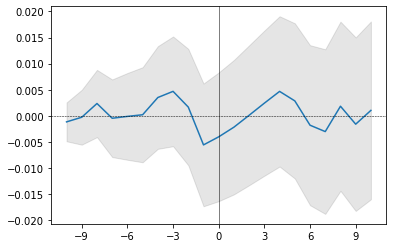

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.001        0.003  -0.001         0.003  -0.399    0.690
-9   0.001        0.003    -0.0         0.004  -0.066    0.948
-8   0.003        0.003   0.002         0.005   0.470    0.638
-7  -0.003        0.003    -0.0         0.006  -0.080    0.936
-6   0.000        0.003    -0.0         0.006  -0.017    0.987
-5   0.000        0.003     0.0         0.007   0.029    0.977
-4   0.003        0.003   0.004         0.008   0.458    0.647
-3   0.001        0.003   0.005         0.008   0.571    0.568
-2  -0.003        0.003   0.002         0.009   0.193    0.847
-1  -0.007        0.003  -0.006         0.009  -0.607    0.544
0    0.002        0.003  -0.004         0.010  -0.418    0.676
1    0.002        0.003  -0.002         0.010  -0.216    0.829
2    0.002        0.003     0.0         0.010   0.011    0.992
3    0.002        0.003   0.002         0.011   0.224    0.823
4    0.002        0.003   0.005         0.011   0.417    0.677
5   -0.002        0.003   0.003         0.012   0.247    0.805
6   -0.005        0.003  -0.002         0.012  -0.150    0.881
7   -0.001        0.003  -0.003         0.012  -0.245    0.806
8    0.005        0.003   0.002         0.013   0.145    0.884
9   -0.003        0.003  -0.002         0.013  -0.123    0.902
10   0.003        0.003   0.001         0.013   0.079    0.937

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.001     0.001    10.475    -0.638 -0.195        -0.013         0.001   
-9  -0.000     0.001     7.906     0.309 -0.173        -0.016        -0.004   
-8   0.002     0.002     5.040    -0.485 -0.215        -0.013         0.002   
-7  -0.000     0.003    12.829    -1.993 -0.378        -0.023         0.001   
-6  -0.000     0.004    24.885    -3.316 -0.508        -0.026        -0.000   
-5   0.000     0.008    45.430    -4.701 -0.794        -0.022         0.001   
-4   0.004     0.006    13.601    -0.576 -0.488        -0.027         0.003   
-3   0.005     0.010    18.448    -0.382 -0.638        -0.029         0.003   
-2   0.002     0.011    11.530     0.605 -0.543        -0.038         0.002   
-1  -0.006     0.014    11.401     0.475 -0.571        -0.048        -0.007   
0   -0.004     0.014    11.540     0.403 -0.506        -0.045         0.003   
1   -0.002     0.019    19.673     0.429 -0.786        -0.044         0.003   
2    0.000     0.016    13.247     0.932 -0.489        -0.048         0.002   
3    0.002     0.018     9.409     0.102 -0.638        -0.044         0.008   
4    0.005     0.022    14.928     1.776 -0.547        -0.043         0.004   
5    0.003     0.023    12.319     0.954 -0.641        -0.050         0.005   
6   -0.002     0.026    13.564     1.199 -0.752        -0.050        -0.002   
7   -0.003     0.026    12.421     1.230 -0.717        -0.057        -0.002   
8    0.002     0.025     9.553     1.477 -0.444        -0.054        -0.002   
9   -0.002     0.020     7.594     1.142 -0.467        -0.047        -0.002   
10   0.001     0.023    10.503     1.201 -0.541        -0.040        -0.000   

     Quantile 75%    Max  
-10         0.010  0.136  
-9          0.011  0.174  
-8          0.016  0.181  
-7          0.024  0.146  
-6          0.030  0.157  
-5          0.030  0.341  
-4          0.030  0.370  
-3          0.036  0.566  
-2          0.035  0.557  
-1          0.031  0.626  
0           0.036  0.648  
1           0.036  0.874  
2           0.039  0.793  
3           0.045  0.690  
4           0.048  0.940  
5           0.042  0.854  
6           0.045  0.943  
7           0.041  0.947  
8           0.046  0.910  
9           0.046  0.757  
10          0.050  0.886

C_N


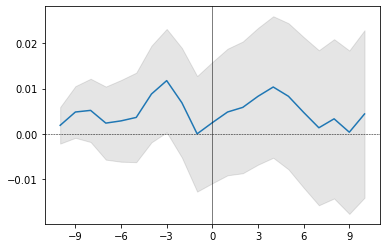

AAR  Std. E. AAR   CAAR  Std. E. CAAR  T-stat  P-value
-10  0.002        0.003  0.002         0.003   0.593    0.554
-9   0.003        0.003  0.005         0.004   1.080    0.280
-8   0.000        0.003  0.005         0.005   0.947    0.343
-7  -0.003        0.003  0.002         0.006   0.374    0.708
-6   0.000        0.003  0.003         0.007   0.405    0.686
-5   0.001        0.003  0.004         0.008   0.468    0.639
-4   0.005        0.003  0.009         0.008   1.055    0.292
-3   0.003        0.003  0.012         0.009   1.318    0.188
-2  -0.005        0.003  0.007         0.009   0.724    0.469
-1  -0.007        0.003   -0.0         0.010  -0.002    0.999
0    0.002        0.003  0.002         0.010   0.235    0.814
1    0.002        0.003  0.005         0.011   0.441    0.659
2    0.001        0.003  0.006         0.011   0.514    0.608
3    0.002        0.003  0.008         0.012   0.702    0.483
4    0.002        0.003   0.01         0.012   0.847    0.397
5   -0.002        0.003  0.008         0.013   0.658    0.511
6   -0.004        0.003  0.005         0.013   0.364    0.716
7   -0.003        0.003  0.001         0.013   0.099    0.921
8    0.002        0.003  0.003         0.014   0.241    0.810
9   -0.003        0.003    0.0         0.014   0.025    0.980
10   0.004        0.003  0.004         0.014   0.303    0.762

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.002     0.002    19.095     2.158 -0.164        -0.011        -0.001   
-9   0.005     0.002    19.829     3.187 -0.111        -0.014        -0.001   
-8   0.005     0.004    13.063     0.190 -0.331        -0.017         0.002   
-7   0.002     0.005    17.813    -1.795 -0.473        -0.024         0.000   
-6   0.003     0.005    22.856    -2.942 -0.550        -0.025         0.007   
-5   0.004     0.009    32.006    -3.714 -0.747        -0.032         0.003   
-4   0.009     0.007     6.689    -0.113 -0.429        -0.035         0.006   
-3   0.012     0.010    12.023    -0.574 -0.578        -0.027         0.007   
-2   0.007     0.011     6.639     0.338 -0.456        -0.034         0.002   
-1  -0.000     0.017    13.350     1.309 -0.487        -0.039        -0.001   
0    0.002     0.016    20.576     1.984 -0.515        -0.037         0.003   
1    0.005     0.022    26.597     2.426 -0.696        -0.035         0.008   
2    0.006     0.018    19.880     2.599 -0.395        -0.034         0.001   
3    0.008     0.020    18.082     2.128 -0.541        -0.040         0.006   
4    0.010     0.023    26.939     3.598 -0.426        -0.043         0.013   
5    0.008     0.024    22.689     3.011 -0.459        -0.045         0.009   
6    0.005     0.024    21.921     3.152 -0.392        -0.053         0.005   
7    0.001     0.023    19.378     3.003 -0.343        -0.061         0.003   
8    0.003     0.024    14.048     2.361 -0.370        -0.063         0.005   
9    0.000     0.022    12.246     2.110 -0.357        -0.044        -0.002   
10   0.004     0.023    15.692     2.568 -0.356        -0.055         0.002   

     Quantile 75%    Max  
-10         0.010  0.300  
-9          0.020  0.318  
-8          0.026  0.354  
-7          0.027  0.284  
-6          0.033  0.201  
-5          0.038  0.292  
-4          0.041  0.355  
-3          0.044  0.435  
-2          0.041  0.505  
-1          0.035  0.815  
0           0.043  0.892  
1           0.051  1.107  
2           0.042  0.971  
3           0.050  0.987  
4           0.050  1.165  
5           0.044  1.139  
6           0.048  1.118  
7           0.043  1.081  
8           0.051  1.014  
9           0.045  0.924  
10          0.050  1.016

WFC_N


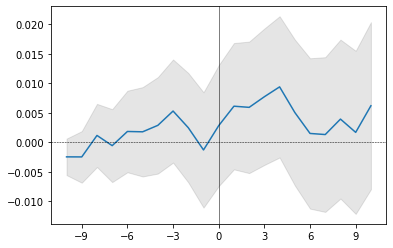

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.002        0.002  -0.002         0.002  -1.023    0.306
-9  -0.000        0.002  -0.002         0.003  -0.726    0.468
-8   0.004        0.002   0.001         0.004   0.278    0.781
-7  -0.002        0.002  -0.001         0.005  -0.117    0.906
-6   0.002        0.002   0.002         0.005   0.340    0.734
-5  -0.000        0.002   0.002         0.006   0.301    0.763
-4   0.001        0.002   0.003         0.006   0.450    0.652
-3   0.002        0.002   0.005         0.007   0.777    0.437
-2  -0.003        0.002   0.002         0.007   0.342    0.733
-1  -0.004        0.002  -0.001         0.008  -0.170    0.865
0    0.004        0.002   0.003         0.008   0.353    0.724
1    0.003        0.002   0.006         0.008   0.733    0.464
2   -0.000        0.002   0.006         0.009   0.681    0.496
3    0.002        0.002   0.008         0.009   0.856    0.392
4    0.002        0.002   0.009         0.009   1.006    0.314
5   -0.004        0.002   0.005         0.010   0.524    0.600
6   -0.004        0.002   0.002         0.010   0.151    0.880
7   -0.000        0.002   0.001         0.010   0.128    0.898
8    0.003        0.002   0.004         0.011   0.374    0.708
9   -0.002        0.002   0.002         0.011   0.156    0.876
10   0.005        0.002   0.006         0.011   0.561    0.575

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.002     0.001     5.516    -0.849 -0.109        -0.009        -0.000   
-9  -0.002     0.001     3.376    -0.523 -0.113        -0.016        -0.002   
-8   0.001     0.002    22.395     0.888 -0.263        -0.013         0.001   
-7  -0.001     0.002     6.451    -0.560 -0.202        -0.016         0.001   
-6   0.002     0.003     9.228    -0.465 -0.273        -0.018         0.004   
-5   0.002     0.004    27.852    -3.196 -0.502        -0.015         0.004   
-4   0.003     0.003     9.867    -1.186 -0.338        -0.018         0.002   
-3   0.005     0.004    13.143    -0.921 -0.386        -0.014         0.001   
-2   0.002     0.005     9.277    -0.453 -0.381        -0.020        -0.001   
-1  -0.001     0.006     8.084    -0.954 -0.406        -0.019         0.000   
0    0.003     0.006     9.369    -0.941 -0.398        -0.014         0.002   
1    0.006     0.008    25.802    -1.290 -0.619        -0.019         0.007   
2    0.006     0.007    11.698    -0.595 -0.462        -0.021         0.006   
3    0.008     0.007    11.512    -1.047 -0.508        -0.024         0.009   
4    0.009     0.009    15.437     1.006 -0.506        -0.024         0.010   
5    0.005     0.009    12.867    -0.170 -0.532        -0.029         0.006   
6    0.002     0.010    12.239     1.004 -0.489        -0.031         0.002   
7    0.001     0.009     8.416     1.487 -0.301        -0.033         0.006   
8    0.004     0.009     6.646     1.058 -0.296        -0.028         0.005   
9    0.002     0.007     4.620     0.386 -0.284        -0.029         0.005   
10   0.006     0.007     6.759     0.902 -0.268        -0.025         0.003   

     Quantile 75%    Max  
-10         0.007  0.089  
-9          0.010  0.084  
-8          0.016  0.314  
-7          0.017  0.207  
-6          0.021  0.217  
-5          0.023  0.233  
-4          0.023  0.192  
-3          0.024  0.299  
-2          0.026  0.298  
-1          0.025  0.281  
0           0.035  0.345  
1           0.034  0.515  
2           0.033  0.414  
3           0.030  0.326  
4           0.032  0.549  
5           0.030  0.447  
6           0.027  0.506  
7           0.032  0.474  
8           0.043  0.454  
9           0.034  0.358  
10          0.033  0.416

GS


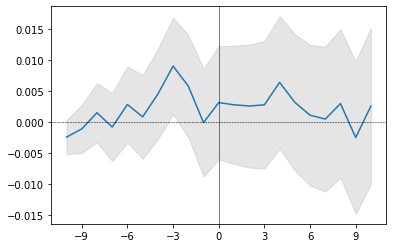

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.002        0.002  -0.002         0.002  -1.109    0.267
-9   0.001        0.002  -0.001         0.003  -0.349    0.727
-8   0.003        0.002   0.002         0.004   0.416    0.677
-7  -0.002        0.002  -0.001         0.004  -0.177    0.859
-6   0.004        0.002   0.003         0.005   0.599    0.549
-5  -0.002        0.002   0.001         0.005   0.169    0.866
-4   0.004        0.002   0.005         0.006   0.801    0.423
-3   0.005        0.002   0.009         0.006   1.494    0.135
-2  -0.003        0.002   0.006         0.006   0.908    0.364
-1  -0.006        0.002    -0.0         0.007  -0.007    0.995
0    0.003        0.002   0.003         0.007   0.448    0.654
1   -0.000        0.002   0.003         0.007   0.380    0.704
2   -0.000        0.002   0.003         0.008   0.340    0.734
3    0.000        0.002   0.003         0.008   0.351    0.726
4    0.004        0.002   0.006         0.008   0.775    0.438
5   -0.003        0.002   0.003         0.009   0.376    0.707
6   -0.002        0.002   0.001         0.009   0.130    0.896
7   -0.001        0.002   0.001         0.009   0.057    0.954
8    0.003        0.002   0.003         0.009   0.324    0.746
9   -0.005        0.002  -0.002         0.010  -0.256    0.798
10   0.005        0.002   0.003         0.010   0.266    0.790

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.002     0.001     5.621    -1.072 -0.122        -0.013        -0.002   
-9  -0.001     0.001     4.306    -0.732 -0.146        -0.016        -0.002   
-8   0.002     0.002    11.826    -1.487 -0.285        -0.020         0.001   
-7  -0.001     0.003    13.813    -2.182 -0.358        -0.022         0.000   
-6   0.003     0.002     0.663    -0.448 -0.161        -0.027         0.005   
-5   0.001     0.003     6.753    -1.552 -0.307        -0.025         0.001   
-4   0.005     0.003     0.661    -0.175 -0.190        -0.024         0.002   
-3   0.009     0.003     1.417     0.546 -0.120        -0.023         0.006   
-2   0.006     0.005     1.301     0.432 -0.165        -0.034         0.008   
-1  -0.000     0.005     1.559     0.105 -0.217        -0.039        -0.001   
0    0.003     0.006     1.870    -0.040 -0.245        -0.042         0.012   
1    0.003     0.007     3.073    -0.680 -0.382        -0.036         0.008   
2    0.003     0.008     4.920    -0.820 -0.466        -0.047         0.009   
3    0.003     0.009     1.327    -0.338 -0.315        -0.044         0.007   
4    0.006     0.009     1.808     0.008 -0.327        -0.039         0.006   
5    0.003     0.008     1.027    -0.100 -0.296        -0.047         0.009   
6    0.001     0.009     1.125    -0.028 -0.272        -0.043         0.004   
7    0.001     0.010     0.909    -0.041 -0.280        -0.053         0.003   
8    0.003     0.011     1.431    -0.291 -0.385        -0.053         0.011   
9   -0.002     0.014     3.294    -0.951 -0.533        -0.051         0.006   
10   0.003     0.012     0.729    -0.059 -0.325        -0.051         0.005   

     Quantile 75%    Max  
-10         0.010  0.087  
-9          0.016  0.102  
-8          0.025  0.171  
-7          0.027  0.144  
-6          0.038  0.105  
-5          0.041  0.136  
-4          0.042  0.148  
-3          0.040  0.231  
-2          0.043  0.238  
-1          0.043  0.282  
0           0.050  0.297  
1           0.050  0.246  
2           0.049  0.279  
3           0.055  0.289  
4           0.057  0.320  
5           0.058  0.306  
6           0.058  0.336  
7           0.062  0.326  
8           0.062  0.298  
9           0.067  0.286  
10          0.065  0.308

MS_N


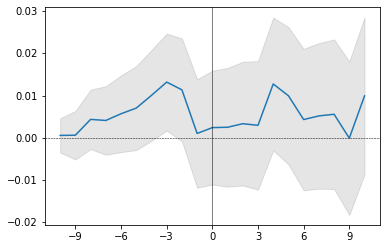

AAR  Std. E. AAR   CAAR  Std. E. CAAR  T-stat  P-value
-10  0.001        0.003  0.001         0.003   0.177    0.859
-9   0.000        0.003  0.001         0.004   0.136    0.892
-8   0.004        0.003  0.004         0.005   0.793    0.428
-7  -0.000        0.003  0.004         0.006   0.647    0.518
-6   0.002        0.003  0.006         0.007   0.803    0.422
-5   0.001        0.003  0.007         0.008   0.906    0.365
-4   0.003        0.003   0.01         0.008   1.197    0.231
-3   0.003        0.003  0.013         0.009   1.470    0.141
-2  -0.002        0.003  0.011         0.010   1.194    0.232
-1  -0.010        0.003  0.001         0.010   0.103    0.918
0    0.001        0.003  0.002         0.011   0.229    0.819
1    0.000        0.003  0.002         0.011   0.227    0.821
2    0.001        0.003  0.003         0.011   0.292    0.770
3   -0.000        0.003  0.003         0.012   0.249    0.804
4    0.010        0.003  0.013         0.012   1.038    0.299
5   -0.003        0.003   0.01         0.013   0.785    0.433
6   -0.006        0.003  0.004         0.013   0.330    0.741
7    0.001        0.003  0.005         0.013   0.385    0.700
8    0.000        0.003  0.006         0.014   0.403    0.687
9   -0.006        0.003   -0.0         0.014  -0.007    0.995
10   0.010        0.003   0.01         0.015   0.683    0.494

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.001     0.001     9.323     1.018 -0.136        -0.014        -0.001   
-9   0.001     0.002     8.971    -1.069 -0.248        -0.019         0.001   
-8   0.004     0.004    28.312    -3.034 -0.491        -0.016         0.010   
-7   0.004     0.005    16.134    -2.284 -0.468        -0.026         0.009   
-6   0.006     0.005     3.352    -0.553 -0.265        -0.034         0.010   
-5   0.007     0.005     7.173    -1.106 -0.373        -0.021         0.006   
-4   0.010     0.005     1.942     0.329 -0.230        -0.030         0.014   
-3   0.013     0.007     4.516     0.235 -0.338        -0.019         0.010   
-2   0.011     0.007     2.713     0.663 -0.240        -0.030         0.013   
-1   0.001     0.008     2.121    -0.521 -0.329        -0.038         0.007   
0    0.002     0.010     6.454    -1.516 -0.487        -0.029         0.013   
1    0.002     0.013     8.327    -1.805 -0.616        -0.026         0.014   
2    0.003     0.015    11.836    -2.465 -0.703        -0.047         0.015   
3    0.003     0.018    18.387    -3.033 -0.950        -0.036         0.007   
4    0.013     0.011     2.711    -0.387 -0.403        -0.044         0.011   
5    0.010     0.012     2.240    -0.364 -0.403        -0.049         0.009   
6    0.004     0.016     6.613    -1.174 -0.649        -0.045         0.011   
7    0.005     0.017     6.580    -0.798 -0.685        -0.058         0.015   
8    0.006     0.022    12.755    -1.968 -0.952        -0.059         0.006   
9   -0.000     0.028    20.175    -3.084 -1.197        -0.066         0.011   
10   0.010     0.016     2.320    -0.351 -0.524        -0.057         0.013   

     Quantile 75%    Max  
-10         0.013  0.184  
-9          0.020  0.128  
-8          0.024  0.238  
-7          0.031  0.178  
-6          0.036  0.217  
-5          0.035  0.245  
-4          0.043  0.235  
-3          0.047  0.340  
-2          0.046  0.336  
-1          0.039  0.254  
0           0.047  0.273  
1           0.048  0.315  
2           0.058  0.229  
3           0.064  0.256  
4           0.061  0.327  
5           0.068  0.355  
6           0.066  0.393  
7           0.073  0.494  
8           0.078  0.433  
9           0.085  0.387  
10          0.088  0.409

HSBA_L


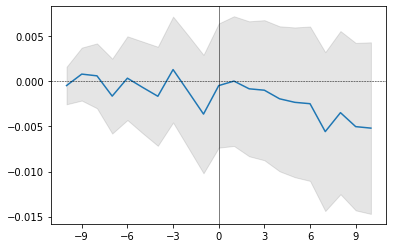

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.000        0.002    -0.0         0.002  -0.295    0.768
-9   0.001        0.002   0.001         0.002   0.346    0.729
-8  -0.000        0.002   0.001         0.003   0.214    0.830
-7  -0.002        0.002  -0.002         0.003  -0.508    0.611
-6   0.002        0.002     0.0         0.004   0.094    0.925
-5  -0.001        0.002  -0.001         0.004  -0.171    0.864
-4  -0.001        0.002  -0.002         0.004  -0.388    0.698
-3   0.003        0.002   0.001         0.005   0.283    0.777
-2  -0.002        0.002  -0.001         0.005  -0.237    0.812
-1  -0.002        0.002  -0.004         0.005  -0.711    0.477
0    0.003        0.002    -0.0         0.005  -0.089    0.929
1    0.000        0.002     0.0         0.006   0.003    0.997
2   -0.001        0.002  -0.001         0.006  -0.143    0.886
3   -0.000        0.002  -0.001         0.006  -0.164    0.870
4   -0.001        0.002  -0.002         0.006  -0.310    0.756
5   -0.000        0.002  -0.002         0.006  -0.361    0.718
6   -0.000        0.002  -0.002         0.007  -0.373    0.709
7   -0.003        0.002  -0.006         0.007  -0.812    0.417
8    0.002        0.002  -0.003         0.007  -0.493    0.622
9   -0.002        0.002  -0.005         0.007  -0.694    0.487
10  -0.000        0.002  -0.005         0.007  -0.700    0.484

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.000     0.000     2.205     0.473 -0.044        -0.008        -0.001   
-9   0.001     0.000     1.599     0.191 -0.061        -0.009         0.001   
-8   0.001     0.001     5.596     0.768 -0.094        -0.014        -0.001   
-7  -0.002     0.001     3.922    -0.522 -0.159        -0.018        -0.002   
-6   0.000     0.001     5.015    -0.653 -0.174        -0.018         0.001   
-5  -0.001     0.002    21.895    -3.040 -0.318        -0.019         0.000   
-4  -0.002     0.002     8.287    -1.594 -0.250        -0.021         0.001   
-3   0.001     0.002     5.660    -0.640 -0.236        -0.020         0.002   
-2  -0.001     0.003     6.361    -1.225 -0.261        -0.027        -0.000   
-1  -0.004     0.004     7.092    -1.215 -0.332        -0.031        -0.003   
0   -0.000     0.003     4.815    -0.715 -0.275        -0.026         0.002   
1    0.000     0.003     3.559    -0.799 -0.273        -0.024         0.002   
2   -0.001     0.004     1.737    -0.110 -0.213        -0.031         0.001   
3   -0.001     0.004     1.107    -0.238 -0.196        -0.030         0.002   
4   -0.002     0.005     3.193     0.293 -0.221        -0.036         0.003   
5   -0.002     0.004     2.828     0.514 -0.175        -0.032         0.001   
6   -0.002     0.005     3.296     0.573 -0.173        -0.034         0.003   
7   -0.006     0.005     3.251     0.469 -0.202        -0.038        -0.002   
8   -0.003     0.005     3.224     0.573 -0.225        -0.036        -0.001   
9   -0.005     0.005     1.888     0.172 -0.231        -0.038        -0.001   
10  -0.005     0.006     2.781     0.189 -0.267        -0.039        -0.002   

     Quantile 75%    Max  
-10         0.007  0.062  
-9          0.011  0.075  
-8          0.011  0.162  
-7          0.015  0.115  
-6          0.019  0.133  
-5          0.022  0.118  
-4          0.024  0.119  
-3          0.022  0.167  
-2          0.027  0.162  
-1          0.025  0.150  
0           0.025  0.184  
1           0.028  0.159  
2           0.027  0.207  
3           0.032  0.185  
4           0.032  0.285  
5           0.027  0.271  
6           0.029  0.327  
7           0.030  0.316  
8           0.032  0.309  
9           0.027  0.251  
10          0.028  0.267

BNPP_PA


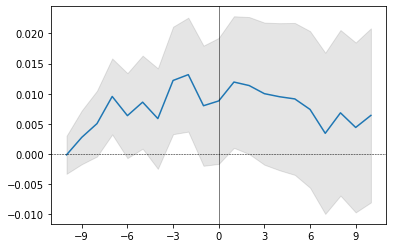

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.000        0.002     -0.0         0.002  -0.048    0.962
-9   0.003        0.002    0.003         0.003   0.800    0.424
-8   0.002        0.002    0.005         0.004   1.188    0.235
-7   0.004        0.002   0.01 *         0.005   1.945    0.052
-6  -0.003        0.002    0.006         0.005   1.161    0.246
-5   0.002        0.002    0.009         0.006   1.431    0.152
-4  -0.003        0.002    0.006         0.006   0.906    0.365
-3   0.006        0.002  0.012 *         0.007   1.757    0.079
-2   0.001        0.002  0.013 *         0.007   1.787    0.074
-1  -0.005        0.002    0.008         0.008   1.033    0.302
0    0.001        0.002    0.009         0.008   1.082    0.279
1    0.003        0.002    0.012         0.009   1.404    0.160
2   -0.001        0.002    0.011         0.009   1.283    0.200
3   -0.001        0.002     0.01         0.009   1.090    0.276
4   -0.001        0.002     0.01         0.010   0.999    0.318
5   -0.000        0.002    0.009         0.010   0.931    0.352
6   -0.002        0.002    0.007         0.010   0.731    0.465
7   -0.004        0.002    0.003         0.010   0.331    0.741
8    0.003        0.002    0.007         0.011   0.639    0.523
9   -0.002        0.002    0.004         0.011   0.402    0.688
10   0.002        0.002    0.006         0.011   0.570    0.569

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.000     0.001    10.992     1.271 -0.122        -0.013        -0.003   
-9   0.003     0.001     5.187     1.151 -0.115        -0.015         0.001   
-8   0.005     0.003    20.097     2.784 -0.153        -0.018         0.001   
-7   0.010     0.003     8.811     1.603 -0.143        -0.024         0.006   
-6   0.006     0.004     6.592     0.754 -0.249        -0.030         0.001   
-5   0.009     0.005     6.793    -0.566 -0.359        -0.025         0.009   
-4   0.006     0.006     3.560    -0.422 -0.336        -0.026         0.002   
-3   0.012     0.007     4.137    -0.157 -0.369        -0.022         0.010   
-2   0.013     0.009     4.637    -0.406 -0.444        -0.028         0.008   
-1   0.008     0.009     3.387     0.515 -0.257        -0.038         0.004   
0    0.009     0.009     4.845     0.362 -0.323        -0.031         0.005   
1    0.012     0.010     4.641     0.278 -0.355        -0.026         0.008   
2    0.011     0.010     5.767     0.370 -0.398        -0.030         0.007   
3    0.010     0.010     3.546     0.475 -0.292        -0.037         0.008   
4    0.010     0.012     4.977     0.681 -0.347        -0.036         0.005   
5    0.009     0.010     4.026     0.896 -0.248        -0.043        -0.001   
6    0.007     0.012     3.718     0.837 -0.286        -0.047         0.005   
7    0.003     0.013     3.866     0.535 -0.337        -0.049        -0.000   
8    0.007     0.014     3.568     0.539 -0.386        -0.050         0.006   
9    0.004     0.013     2.195     0.187 -0.385        -0.055        -0.001   
10   0.006     0.014     2.934     0.359 -0.361        -0.047         0.005   

     Quantile 75%    Max  
-10         0.011  0.187  
-9          0.019  0.186  
-8          0.025  0.392  
-7          0.036  0.358  
-6          0.036  0.363  
-5          0.040  0.284  
-4          0.049  0.270  
-3          0.052  0.291  
-2          0.055  0.291  
-1          0.052  0.388  
0           0.046  0.388  
1           0.051  0.427  
2           0.053  0.471  
3           0.055  0.445  
4           0.066  0.539  
5           0.062  0.475  
6           0.058  0.469  
7           0.054  0.492  
8           0.057  0.465  
9           0.068  0.371  
10          0.066  0.445

CAGR_PA


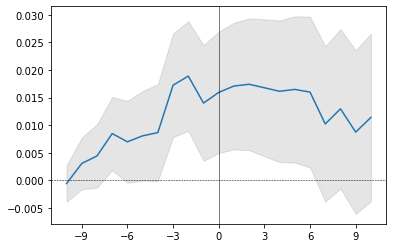

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.001        0.003    -0.001         0.003  -0.220    0.826
-9   0.004        0.003     0.003         0.004   0.841    0.401
-8   0.001        0.003     0.004         0.004   0.989    0.323
-7   0.004        0.003     0.008         0.005   1.642    0.101
-6  -0.001        0.003     0.007         0.006   1.210    0.226
-5   0.001        0.003     0.008         0.006   1.276    0.202
-4   0.001        0.003     0.009         0.007   1.267    0.205
-3   0.009        0.003  0.017 **         0.007   2.359    0.018
-2   0.002        0.003  0.019 **         0.008   2.437    0.015
-1  -0.005        0.003   0.014 *         0.008   1.714    0.087
0    0.002        0.003   0.016 *         0.009   1.860    0.063
1    0.001        0.003   0.017 *         0.009   1.909    0.056
2    0.000        0.003   0.017 *         0.009   1.869    0.062
3   -0.001        0.003   0.017 *         0.010   1.735    0.083
4   -0.001        0.003     0.016         0.010   1.613    0.107
5    0.000        0.003     0.016         0.010   1.594    0.111
6   -0.000        0.003     0.016         0.011   1.501    0.133
7   -0.006        0.003      0.01         0.011   0.933    0.351
8    0.003        0.003     0.013         0.011   1.151    0.250
9   -0.004        0.003     0.009         0.012   0.757    0.449
10   0.003        0.003     0.011         0.012   0.964    0.335

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.001     0.001    10.460     1.482 -0.110        -0.015        -0.002   
-9   0.003     0.002     6.762     1.180 -0.156        -0.018        -0.002   
-8   0.004     0.003     8.892     1.362 -0.177        -0.023         0.003   
-7   0.008     0.004     3.736     0.293 -0.191        -0.024         0.007   
-6   0.007     0.004     3.197    -0.237 -0.254        -0.021         0.006   
-5   0.008     0.004     1.649    -0.409 -0.206        -0.023         0.013   
-4   0.009     0.005     0.912    -0.184 -0.180        -0.023         0.012   
-3   0.017     0.007     1.739     0.286 -0.214        -0.024         0.017   
-2   0.019     0.008     1.792     0.213 -0.261        -0.027         0.021   
-1   0.014     0.009     1.857     0.036 -0.316        -0.039         0.011   
0    0.016     0.009     2.365     0.030 -0.294        -0.021         0.016   
1    0.017     0.011     2.247    -0.353 -0.344        -0.027         0.016   
2    0.017     0.012     2.840    -0.226 -0.418        -0.029         0.018   
3    0.017     0.013     2.044    -0.110 -0.361        -0.035         0.019   
4    0.016     0.013     1.934    -0.057 -0.324        -0.034         0.017   
5    0.016     0.013     1.855     0.014 -0.311        -0.028         0.019   
6    0.016     0.014     1.831     0.026 -0.354        -0.033         0.017   
7    0.010     0.017     2.127    -0.157 -0.414        -0.036         0.009   
8    0.013     0.017     1.744     0.033 -0.422        -0.027         0.008   
9    0.009     0.018     1.182     0.006 -0.407        -0.037         0.005   
10   0.011     0.017     1.289     0.144 -0.390        -0.070         0.008   

     Quantile 75%    Max  
-10         0.012  0.183  
-9          0.019  0.217  
-8          0.028  0.325  
-7          0.040  0.293  
-6          0.038  0.242  
-5          0.040  0.190  
-4          0.051  0.234  
-3          0.053  0.285  
-2          0.057  0.313  
-1          0.057  0.313  
0           0.061  0.374  
1           0.069  0.350  
2           0.080  0.393  
3           0.078  0.405  
4           0.076  0.400  
5           0.069  0.398  
6           0.074  0.384  
7           0.072  0.409  
8           0.071  0.411  
9           0.071  0.388  
10          0.067  0.410

SAN_MC


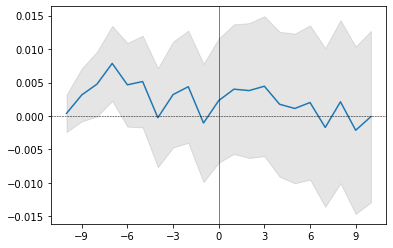

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-10  0.000        0.002      0.0         0.002   0.179    0.858
-9   0.003        0.002    0.003         0.003   1.019    0.308
-8   0.002        0.002    0.005         0.004   1.258    0.208
-7   0.003        0.002  0.008 *         0.004   1.800    0.072
-6  -0.003        0.002    0.005         0.005   0.954    0.340
-5   0.000        0.002    0.005         0.005   0.963    0.336
-4  -0.005        0.002     -0.0         0.006  -0.046    0.964
-3   0.003        0.002    0.003         0.006   0.517    0.605
-2   0.001        0.002    0.004         0.007   0.668    0.504
-1  -0.005        0.002   -0.001         0.007  -0.153    0.879
0    0.003        0.002    0.002         0.007   0.317    0.751
1    0.002        0.002    0.004         0.008   0.530    0.596
2   -0.000        0.002    0.004         0.008   0.482    0.630
3    0.001        0.002    0.004         0.008   0.544    0.586
4   -0.003        0.002    0.002         0.008   0.207    0.836
5   -0.001        0.002    0.001         0.009   0.128    0.898
6    0.001        0.002    0.002         0.009   0.223    0.823
7   -0.004        0.002   -0.002         0.009  -0.186    0.853
8    0.004        0.002    0.002         0.010   0.223    0.824
9   -0.004        0.002   -0.002         0.010  -0.219    0.826
10   0.002        0.002     -0.0         0.010  -0.010    0.992

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.000     0.000     3.421    -0.641 -0.088        -0.011         0.002   
-9   0.003     0.001     1.470     0.684 -0.072        -0.015         0.002   
-8   0.005     0.002     4.203     0.907 -0.127        -0.018        -0.001   
-7   0.008     0.003     1.573     0.598 -0.134        -0.026         0.006   
-6   0.005     0.003     1.636     0.482 -0.166        -0.026         0.003   
-5   0.005     0.004     3.425    -0.102 -0.259        -0.027         0.005   
-4  -0.000     0.005     1.702    -0.227 -0.244        -0.039        -0.001   
-3   0.003     0.006     2.078    -0.232 -0.272        -0.034         0.004   
-2   0.004     0.008     4.040    -0.608 -0.399        -0.034         0.003   
-1  -0.001     0.008     4.682    -0.697 -0.449        -0.044        -0.001   
0    0.002     0.008     5.097    -0.678 -0.457        -0.041        -0.001   
1    0.004     0.009     1.344    -0.225 -0.294        -0.034         0.001   
2    0.004     0.009     1.035     0.094 -0.263        -0.042         0.001   
3    0.004     0.009     0.700     0.103 -0.262        -0.041         0.002   
4    0.002     0.011     0.607     0.081 -0.269        -0.049        -0.000   
5    0.001     0.010     0.659     0.193 -0.306        -0.056         0.000   
6    0.002     0.012     0.949     0.209 -0.365        -0.058        -0.002   
7   -0.002     0.014     1.191    -0.087 -0.393        -0.053        -0.003   
8    0.002     0.013     0.784     0.198 -0.383        -0.056        -0.008   
9   -0.002     0.014     0.592     0.164 -0.369        -0.067        -0.011   
10  -0.000     0.015     0.884     0.267 -0.358        -0.063        -0.014   

     Quantile 75%    Max  
-10         0.013  0.072  
-9          0.017  0.120  
-8          0.024  0.219  
-7          0.032  0.188  
-6          0.028  0.174  
-5          0.033  0.209  
-4          0.034  0.203  
-3          0.040  0.224  
-2          0.041  0.260  
-1          0.032  0.264  
0           0.031  0.255  
1           0.038  0.239  
2           0.042  0.261  
3           0.050  0.261  
4           0.045  0.305  
5           0.051  0.302  
6           0.047  0.315  
7           0.046  0.317  
8           0.052  0.295  
9           0.051  0.304  
10          0.053  0.341

SOGN_PA


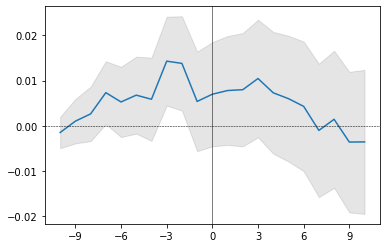

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-10 -0.001        0.003   -0.001         0.003  -0.537    0.592
-9   0.003        0.003    0.001         0.004   0.275    0.783
-8   0.002        0.003    0.003         0.005   0.566    0.571
-7   0.005        0.003    0.007         0.005   1.357    0.175
-6  -0.002        0.003    0.005         0.006   0.874    0.382
-5   0.002        0.003    0.007         0.007   1.025    0.306
-4  -0.001        0.003    0.006         0.007   0.822    0.411
-3   0.008        0.003  0.014 *         0.008   1.867    0.062
-2  -0.000        0.003  0.014 *         0.008   1.700    0.089
-1  -0.008        0.003    0.005         0.009   0.631    0.528
0    0.002        0.003    0.007         0.009   0.780    0.436
1    0.001        0.003    0.008         0.009   0.833    0.405
2    0.000        0.003    0.008         0.010   0.820    0.413
3    0.002        0.003     0.01         0.010   1.033    0.301
4   -0.003        0.003    0.007         0.010   0.698    0.485
5   -0.001        0.003    0.006         0.011   0.556    0.578
6   -0.002        0.003    0.004         0.011   0.387    0.699
7   -0.005        0.003   -0.001         0.011  -0.086    0.931
8    0.002        0.003    0.001         0.012   0.124    0.901
9   -0.005        0.003   -0.004         0.012  -0.295    0.768
10   0.000        0.003   -0.004         0.012  -0.284    0.776

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10 -0.001     0.001     6.165     0.033 -0.152        -0.014        -0.002   
-9   0.001     0.002     4.126     0.480 -0.150        -0.019         0.001   
-8   0.003     0.003     5.028     0.802 -0.174        -0.024         0.002   
-7   0.007     0.004     2.517    -0.116 -0.244        -0.023         0.009   
-6   0.005     0.005     4.758    -0.821 -0.351        -0.026         0.008   
-5   0.007     0.005     5.209    -0.884 -0.360        -0.027         0.009   
-4   0.006     0.006     0.960    -0.309 -0.241        -0.031         0.006   
-3   0.014     0.008     1.399     0.177 -0.247        -0.026         0.007   
-2   0.014     0.010     1.772     0.125 -0.259        -0.039         0.009   
-1   0.005     0.012     2.828     0.099 -0.330        -0.055         0.007   
0    0.007     0.011     3.004    -0.040 -0.383        -0.036         0.007   
1    0.008     0.013     3.716    -0.532 -0.442        -0.035         0.008   
2    0.008     0.014     2.762    -0.191 -0.415        -0.051         0.010   
3    0.010     0.015     2.073     0.052 -0.365        -0.042         0.013   
4    0.007     0.016     2.043     0.122 -0.334        -0.043         0.003   
5    0.006     0.014     1.758     0.289 -0.319        -0.057         0.003   
6    0.004     0.016     2.720     0.385 -0.343        -0.058        -0.002   
7   -0.001     0.019     3.860    -0.005 -0.459        -0.071         0.004   
8    0.001     0.020     4.114     0.176 -0.483        -0.070         0.009   
9   -0.004     0.020     3.017     0.126 -0.478        -0.084        -0.003   
10  -0.004     0.020     3.164     0.347 -0.484        -0.068        -0.009   

     Quantile 75%    Max  
-10         0.013  0.132  
-9          0.018  0.161  
-8          0.030  0.276  
-7          0.036  0.224  
-6          0.035  0.202  
-5          0.041  0.188  
-4          0.046  0.183  
-3          0.055  0.323  
-2          0.058  0.378  
-1          0.046  0.474  
0           0.050  0.432  
1           0.051  0.409  
2           0.054  0.415  
3           0.059  0.442  
4           0.071  0.491  
5           0.073  0.436  
6           0.069  0.485  
7           0.068  0.541  
8           0.068  0.622  
9           0.068  0.592  
10          0.067  0.614

BARC_L


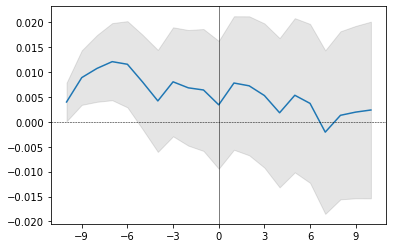

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-10  0.004        0.003     0.004         0.003   1.319    0.187
-9   0.005        0.003  0.009 **         0.004   2.080    0.038
-8   0.002        0.003  0.011 **         0.005   2.051    0.040
-7   0.001        0.003  0.012 **         0.006   2.001    0.045
-6  -0.001        0.003   0.012 *         0.007   1.712    0.087
-5  -0.004        0.003     0.008         0.007   1.080    0.280
-4  -0.004        0.003     0.004         0.008   0.526    0.599
-3   0.004        0.003     0.008         0.009   0.941    0.347
-2  -0.001        0.003     0.007         0.009   0.754    0.451
-1  -0.000        0.003     0.006         0.010   0.670    0.503
0   -0.003        0.003     0.003         0.010   0.341    0.733
1    0.004        0.003     0.008         0.010   0.745    0.456
2   -0.001        0.003     0.007         0.011   0.664    0.506
3   -0.002        0.003     0.005         0.011   0.468    0.640
4   -0.003        0.003     0.002         0.012   0.156    0.876
5    0.004        0.003     0.005         0.012   0.442    0.659
6   -0.002        0.003     0.004         0.012   0.298    0.766
7   -0.006        0.003    -0.002         0.013  -0.161    0.872
8    0.003        0.003     0.001         0.013   0.100    0.921
9    0.001        0.003     0.002         0.014   0.145    0.885
10   0.000        0.003     0.002         0.014   0.172    0.864

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-10  0.004     0.006    73.817     7.735 -0.118        -0.017        -0.001   
-9   0.009     0.006    64.439     6.962 -0.138        -0.024         0.001   
-8   0.011     0.011    59.518     6.318 -0.277        -0.021         0.007   
-7   0.012     0.012    40.475     4.597 -0.316        -0.020         0.007   
-6   0.012     0.016    33.160     3.032 -0.563        -0.023         0.006   
-5   0.008     0.016    33.627     0.106 -0.865        -0.021         0.002   
-4   0.004     0.017    32.583    -0.798 -0.950        -0.032         0.002   
-3   0.008     0.021    34.224    -1.299 -1.067        -0.034         0.001   
-2   0.007     0.025    32.784    -1.695 -1.197        -0.034         0.001   
-1   0.006     0.018    26.051     3.276 -0.443        -0.054         0.002   
0    0.003     0.020    31.343     3.790 -0.414        -0.047         0.000   
1    0.008     0.022    23.377     2.612 -0.604        -0.040         0.007   
2    0.007     0.026    16.370     1.604 -0.698        -0.046         0.005   
3    0.005     0.029    14.355     0.728 -0.815        -0.057         0.009   
4    0.002     0.031    13.837     0.344 -0.948        -0.059         0.005   
5    0.005     0.022    13.116     2.345 -0.386        -0.064         0.005   
6    0.004     0.023    11.178     2.140 -0.441        -0.069        -0.005   
7   -0.002     0.029    11.161     1.994 -0.546        -0.069        -0.003   
8    0.001     0.031    11.861     2.230 -0.511        -0.071        -0.007   
9    0.002     0.029    11.673     2.013 -0.494        -0.072        -0.003   
10   0.002     0.029    11.877     2.202 -0.438        -0.077         0.002   

     Quantile 75%    Max  
-10         0.010  0.754  
-9          0.023  0.783  
-8          0.025  0.991  
-7          0.035  0.928  
-6          0.035  1.003  
-5          0.031  0.891  
-4          0.036  0.855  
-3          0.045  0.905  
-2          0.049  0.948  
-1          0.047  1.023  
0           0.048  1.140  
1           0.049  1.092  
2           0.054  1.048  
3           0.059  1.008  
4           0.064  0.974  
5           0.062  0.930  
6           0.060  0.888  
7           0.048  0.968  
8           0.057  0.940  
9           0.052  0.979  
10          0.051  0.985

In [66]:
for ticker, event in releases_10_200.items():
    print(ticker)
    event.plot()
    plt.show()
    display(event.results())
    display(event.get_CAR_dist())

In [67]:
#using the event study (formula for each element of the tickers list (event window: +-20 / estimation size: 50)
tickers = ['JPM_N','BAC_N','C_N','WFC_N','GS','MS_N','HSBA_L','BNPP_PA','CAGR_PA','SAN_MC','SOGN_PA','BARC_L']
releases_20_50 = dict()

for ticker in tickers:
    events = [event for event in event_database if event['security_ticker']==ticker]
    
    releases_20_50[ticker] = es.Multiple.from_list(
        events,
        es.Single.FamaFrench_3factor,
        event_window= (-20,+20),
        estimation_size = 50)

2022-05-29 12:33:52,490 P[5368] [MainThread 14260]  3 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:52,652 P[5368] [MainThread 14260]  3 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:52,793 P[5368] [MainThread 14260]  3 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:52,956 P[5368] [MainThread 14260]  3 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:33:53,093 P[5368] [MainThread 14260]  3 events have not been processed due

JPM_N


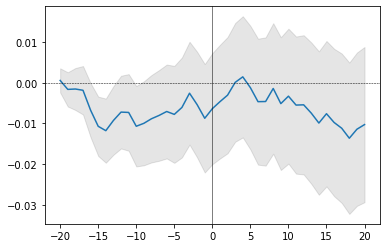

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-20  0.001        0.002     0.001         0.002   0.252    0.801
-19 -0.002        0.002    -0.002         0.003  -0.490    0.624
-18  0.000        0.002    -0.002         0.004  -0.377    0.706
-17 -0.000        0.002    -0.002         0.005  -0.394    0.694
-16 -0.005        0.002    -0.007         0.005  -1.296    0.195
-15 -0.004        0.002  -0.011 *         0.006  -1.877    0.061
-14 -0.001        0.002  -0.012 *         0.006  -1.912    0.056
-13  0.003        0.002    -0.009         0.007  -1.407    0.160
-12  0.002        0.002    -0.007         0.007  -1.032    0.302
-11 -0.000        0.002    -0.007         0.007  -0.990    0.322
-10 -0.003        0.002    -0.011         0.008  -1.385    0.166
-9   0.001        0.002     -0.01         0.008  -1.236    0.217
-8   0.001        0.002    -0.009         0.008  -1.053    0.292
-7   0.001        0.002    -0.008         0.009  -0.921    0.357
-6   0.001        0.002    -0.007         0.009  -0.783    0.434
-5  -0.001        0.002    -0.008         0.009  -0.834    0.404
-4   0.002        0.002    -0.006         0.010  -0.632    0.528
-3   0.004        0.002    -0.003         0.010  -0.258    0.796
-2  -0.003        0.002    -0.005         0.010  -0.529    0.597
-1  -0.003        0.002    -0.009         0.010  -0.838    0.402
0    0.002        0.002    -0.006         0.011  -0.596    0.551
1    0.002        0.002    -0.005         0.011  -0.425    0.671
2    0.002        0.002    -0.003         0.011  -0.272    0.786
3    0.003        0.002       0.0         0.011   0.009    0.992
4    0.001        0.002     0.001         0.012   0.127    0.899
5   -0.003        0.002    -0.001         0.012  -0.101    0.920
6   -0.003        0.002    -0.005         0.012  -0.383    0.701
7    0.000        0.002    -0.005         0.012  -0.373    0.709
8    0.003        0.002    -0.001         0.013  -0.111    0.912
9   -0.004        0.002    -0.005         0.013  -0.401    0.688
10   0.002        0.002    -0.003         0.013  -0.253    0.800
11  -0.002        0.002    -0.005         0.013  -0.416    0.677
12   0.000        0.002    -0.005         0.013  -0.405    0.686
13  -0.002        0.002    -0.007         0.014  -0.549    0.583
14  -0.002        0.002     -0.01         0.014  -0.719    0.472
15   0.002        0.002    -0.008         0.014  -0.544    0.586
16  -0.002        0.002     -0.01         0.014  -0.689    0.491
17  -0.001        0.002    -0.011         0.014  -0.779    0.436
18  -0.002        0.002    -0.014         0.015  -0.938    0.348
19   0.002        0.002    -0.011         0.015  -0.776    0.438
20   0.001        0.002     -0.01         0.015  -0.690    0.490

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.001     0.001     5.431    -0.023 -0.123        -0.008         0.001   
-19 -0.002     0.001     6.252     0.078 -0.167        -0.017         0.001   
-18 -0.002     0.002     5.489    -0.270 -0.191        -0.018        -0.000   
-17 -0.002     0.002     7.727    -0.773 -0.227        -0.019         0.002   
-16 -0.007     0.003     6.644    -1.458 -0.268        -0.023        -0.002   
-15 -0.011     0.005    13.783    -2.370 -0.472        -0.031        -0.004   
-14 -0.012     0.005     4.552    -0.648 -0.316        -0.038        -0.009   
-13 -0.009     0.005     4.237    -0.310 -0.323        -0.039        -0.010   
-12 -0.007     0.006     2.709     0.168 -0.318        -0.049        -0.011   
-11 -0.007     0.006     1.958     0.871 -0.177        -0.049        -0.012   
-10 -0.011     0.007     2.426     0.713 -0.265        -0.054        -0.017   
-9  -0.010     0.008     2.493     0.595 -0.266        -0.056        -0.011   
-8  -0.009     0.009     2.052     0.085 -0.383        -0.063        -0.006   
-7  -0.008     0.011     2.367     0.018 -0.424        -0.062        -0.007   
-6  -0.007     0.011     2.774    -0.012 -0.425        -0.057        -0.009   
-5  -0.008     0.011     2.568     0.022 -0.430        -0.059        -0.010   
-4  -0.006     0.011     1.101     0.452 -0.255        -0.066        -0.004   
-3  -0.003     0.011     2.372     0.807 -0.260        -0.062        -0.002   
-2  -0.005     0.013     2.093     0.550 -0.345        -0.075        -0.007   
-1  -0.009     0.013     1.999     0.346 -0.424        -0.084        -0.012   
0   -0.006     0.013     0.988     0.343 -0.290        -0.073        -0.007   
1   -0.005     0.014     1.230     0.255 -0.360        -0.071        -0.005   
2   -0.003     0.013     1.147     0.656 -0.281        -0.078        -0.007   
3    0.000     0.014     1.688     0.744 -0.285        -0.063        -0.011   
4    0.001     0.015     1.537     0.767 -0.293        -0.072        -0.010   
5   -0.001     0.014     1.794     0.730 -0.286        -0.066        -0.014   
6   -0.005     0.015     1.641     0.671 -0.302        -0.074        -0.013   
7   -0.005     0.017     1.481     0.539 -0.332        -0.075        -0.014   
8   -0.001     0.019     2.265     0.671 -0.380        -0.068        -0.015   
9   -0.005     0.017     1.341     0.270 -0.370        -0.078        -0.004   
10  -0.003     0.019     2.077     0.588 -0.380        -0.076        -0.005   
11  -0.005     0.022     2.810     0.590 -0.463        -0.080        -0.010   
12  -0.005     0.023     2.863     0.660 -0.401        -0.075        -0.014   
13  -0.007     0.023     2.333     0.670 -0.384        -0.088        -0.006   
14  -0.010     0.025     2.359     0.505 -0.421        -0.085        -0.008   
15  -0.008     0.023     2.354     0.457 -0.450        -0.081        -0.023   
16  -0.010     0.025     2.591     0.393 -0.482        -0.084        -0.015   
17  -0.011     0.028     3.694     0.169 -0.678        -0.093        -0.018   
18  -0.014     0.030     3.052     0.236 -0.644        -0.089        -0.026   
19  -0.011     0.031     2.883     0.380 -0.570        -0.093        -0.022   
20  -0.010     0.031     3.365     0.356 -0.658        -0.089        -0.013   

     Quantile 75%    Max  
-20         0.010  0.122  
-19         0.012  0.159  
-18         0.016  0.175  
-17         0.018  0.213  
-16         0.021  0.174  
-15         0.026  0.179  
-14         0.025  0.231  
-13         0.019  0.257  
-12         0.029  0.244  
-11         0.028  0.264  
-10         0.028  0.300  
-9          0.031  0.344  
-8          0.041  0.264  
-7          0.043  0.323  
-6          0.046  0.325  
-5          0.046  0.313  
-4          0.047  0.327  
-3          0.050  0.442  
-2          0.050  0.428  
-1          0.048  0.360  
0           0.059  0.344  
1           0.061  0.335  
2           0.052  0.367  
3           0.055  0.419  
4           

BAC_N


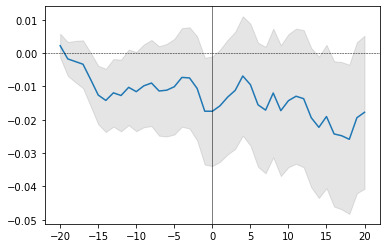

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-20  0.002        0.003     0.002         0.003   0.788    0.431
-19 -0.004        0.003    -0.002         0.004  -0.445    0.656
-18 -0.001        0.003    -0.003         0.005  -0.527    0.598
-17 -0.001        0.003    -0.003         0.006  -0.599    0.549
-16 -0.005        0.003    -0.008         0.006  -1.263    0.207
-15 -0.005        0.003  -0.013 *         0.007  -1.839    0.066
-14 -0.002        0.003  -0.014 *         0.007  -1.921    0.055
-13  0.002        0.003    -0.012         0.008  -1.509    0.131
-12 -0.001        0.003    -0.013         0.008  -1.518    0.129
-11  0.002        0.003     -0.01         0.009  -1.163    0.245
-10 -0.001        0.003    -0.012         0.009  -1.248    0.212
-9   0.002        0.003     -0.01         0.010  -1.015    0.310
-8   0.001        0.003    -0.009         0.010  -0.892    0.372
-7  -0.002        0.003    -0.011         0.010  -1.088    0.277
-6   0.000        0.003    -0.011         0.011  -1.029    0.303
-5   0.001        0.003     -0.01         0.011  -0.904    0.366
-4   0.003        0.003    -0.007         0.012  -0.634    0.526
-3  -0.000        0.003    -0.007         0.012  -0.629    0.529
-2  -0.003        0.003    -0.011         0.012  -0.871    0.384
-1  -0.007        0.003    -0.017         0.012  -1.395    0.163
0   -0.000        0.003    -0.017         0.013  -1.363    0.173
1    0.002        0.003    -0.016         0.013  -1.208    0.227
2    0.003        0.003    -0.013         0.013  -0.987    0.323
3    0.002        0.003    -0.011         0.014  -0.818    0.414
4    0.004        0.003    -0.007         0.014  -0.492    0.623
5   -0.003        0.003    -0.009         0.014  -0.665    0.506
6   -0.006        0.003    -0.016         0.015  -1.068    0.285
7   -0.002        0.003    -0.017         0.015  -1.157    0.247
8    0.005        0.003    -0.012         0.015  -0.796    0.426
9   -0.005        0.003    -0.017         0.015  -1.128    0.259
10   0.003        0.003    -0.014         0.016  -0.918    0.359
11   0.001        0.003    -0.013         0.016  -0.819    0.413
12  -0.001        0.003    -0.014         0.016  -0.852    0.394
13  -0.006        0.003    -0.019         0.016  -1.191    0.234
14  -0.003        0.003    -0.022         0.017  -1.347    0.178
15   0.003        0.003    -0.019         0.017  -1.135    0.256
16  -0.005        0.003    -0.024         0.017  -1.427    0.154
17  -0.001        0.003    -0.025         0.017  -1.439    0.150
18  -0.001        0.003    -0.026         0.017  -1.481    0.139
19   0.006        0.003    -0.019         0.018  -1.096    0.273
20   0.002        0.003    -0.018         0.018  -0.992    0.321

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.002     0.001    13.122     2.291 -0.104        -0.008        -0.001   
-19 -0.002     0.003    30.352     3.230 -0.211        -0.012        -0.003   
-18 -0.003     0.005    34.862     3.452 -0.309        -0.018        -0.003   
-17 -0.003     0.005    32.916     2.753 -0.337        -0.020        -0.000   
-16 -0.008     0.006    12.816     0.120 -0.404        -0.021        -0.005   
-15 -0.013     0.009    11.725    -0.499 -0.524        -0.031        -0.009   
-14 -0.014     0.013    20.979    -2.284 -0.828        -0.038        -0.013   
-13 -0.012     0.012    10.309    -0.657 -0.589        -0.045        -0.013   
-12 -0.013     0.013    10.976    -0.972 -0.650        -0.051        -0.016   
-11 -0.010     0.013     8.778     0.873 -0.538        -0.048        -0.019   
-10 -0.012     0.016    10.683     1.668 -0.552        -0.058        -0.019   
-9  -0.010     0.019    11.085     1.965 -0.453        -0.063        -0.019   
-8  -0.009     0.017     7.956     1.776 -0.348        -0.056        -0.020   
-7  -0.011     0.020     6.358     1.115 -0.428        -0.057        -0.015   
-6  -0.011     0.016     4.700     0.681 -0.500        -0.064        -0.012   
-5  -0.010     0.022    10.187    -0.002 -0.808        -0.062        -0.015   
-4  -0.007     0.023     6.730     0.840 -0.562        -0.063        -0.020   
-3  -0.007     0.029     6.681     0.550 -0.664        -0.066        -0.017   
-2  -0.011     0.032     5.493     0.803 -0.614        -0.072        -0.021   
-1  -0.017     0.034     4.715     0.765 -0.652        -0.079        -0.028   
0   -0.017     0.030     5.345     0.838 -0.599        -0.082        -0.022   
1   -0.016     0.039     6.157     0.462 -0.910        -0.084        -0.018   
2   -0.013     0.035     4.115     0.780 -0.608        -0.087        -0.026   
3   -0.011     0.041     5.102     0.812 -0.767        -0.084        -0.025   
4   -0.007     0.046     7.145     1.643 -0.674        -0.086        -0.025   
5   -0.009     0.048     7.219     1.370 -0.704        -0.087        -0.023   
6   -0.016     0.053     7.364     1.337 -0.775        -0.088        -0.021   
7   -0.017     0.055     5.783     1.204 -0.738        -0.100        -0.023   
8   -0.012     0.056     5.002     1.266 -0.643        -0.101        -0.020   
9   -0.017     0.049     4.287     1.051 -0.606        -0.107        -0.022   
10  -0.014     0.051     4.506     0.976 -0.678        -0.101        -0.027   
11  -0.013     0.055     4.140     0.712 -0.809        -0.101        -0.022   
12  -0.014     0.059     4.997     0.757 -0.926        -0.104        -0.018   
13  -0.019     0.062     4.516     0.543 -0.894        -0.113        -0.025   
14  -0.022     0.064     4.448     0.576 -0.824        -0.106        -0.020   
15  -0.019     0.061     4.758     0.749 -0.814        -0.120        -0.022   
16  -0.024     0.066     4.845     0.319 -0.980        -0.113        -0.027   
17  -0.025     0.076     6.415     0.474 -1.133        -0.105        -0.021   
18  -0.026     0.080     6.127     0.731 -1.045        -0.120        -0.028   
19  -0.019     0.078     6.393     1.190 -0.816        -0.111        -0.032   
20  -0.018     0.081     6.658     0.830 -1.075        -0.107        -0.028   

     Quantile 75%    Max  
-20         0.009  0.205  
-19         0.012  0.458  
-18         0.013  0.569  
-17         0.014  0.572  
-16         0.015  0.447  
-15         0.018  0.487  
-14         0.020  0.469  
-13         0.021  0.462  
-12         0.024  0.438  
-11         0.021  0.471  
-10         0.020  0.681  
-9          0.020  0.754  
-8          0.022  0.607  
-7          0.026  0.628  
-6          0.033  0.474  
-5          0.030  0.694  
-4          0.034  0.727  
-3          0.031  0.720  
-2          0.029  0.759  
-1          0.033  0.749  
0           0.036  0.814  
1           0.044  0.787  
2           0.045  0.693  
3           0.045  0.833  
4           

C_N


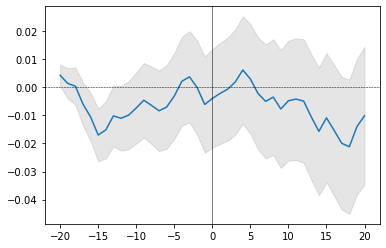

AAR  Std. E. AAR       CAAR  Std. E. CAAR  T-stat  P-value
-20  0.004        0.003      0.004         0.003   1.421    0.155
-19 -0.003        0.003      0.001         0.004   0.320    0.749
-18 -0.001        0.003        0.0         0.005   0.076    0.940
-17 -0.006        0.003     -0.006         0.006  -1.004    0.315
-16 -0.005        0.003     -0.011         0.007  -1.583    0.113
-15 -0.006        0.003  -0.017 **         0.007  -2.325    0.020
-14  0.002        0.003   -0.015 *         0.008  -1.918    0.055
-13  0.005        0.003      -0.01         0.008  -1.206    0.228
-12 -0.001        0.003     -0.011         0.009  -1.232    0.218
-11  0.001        0.003      -0.01         0.009  -1.050    0.294
-10  0.003        0.003     -0.007         0.010  -0.744    0.457
-9   0.003        0.003     -0.005         0.010  -0.446    0.656
-8  -0.002        0.003     -0.006         0.011  -0.599    0.549
-7  -0.002        0.003     -0.008         0.011  -0.750    0.453
-6   0.001        0.003     -0.007         0.012  -0.608    0.543
-5   0.004        0.003     -0.003         0.012  -0.261    0.794
-4   0.005        0.003      0.002         0.012   0.176    0.860
-3   0.002        0.003      0.004         0.013   0.292    0.770
-2  -0.004        0.003       -0.0         0.013  -0.008    0.994
-1  -0.006        0.003     -0.006         0.013  -0.458    0.647
0    0.002        0.003     -0.004         0.014  -0.291    0.771
1    0.002        0.003     -0.002         0.014  -0.159    0.874
2    0.002        0.003     -0.001         0.014  -0.051    0.960
3    0.003        0.003      0.002         0.015   0.127    0.899
4    0.004        0.003      0.006         0.015   0.411    0.681
5   -0.003        0.003      0.003         0.015   0.193    0.847
6   -0.005        0.003     -0.002         0.016  -0.142    0.887
7   -0.003        0.003     -0.005         0.016  -0.318    0.750
8    0.002        0.003     -0.004         0.016  -0.218    0.827
9   -0.004        0.003     -0.008         0.016  -0.473    0.636
10   0.003        0.003     -0.005         0.017  -0.289    0.773
11   0.001        0.003     -0.004         0.017  -0.249    0.803
12  -0.001        0.003     -0.005         0.017  -0.286    0.775
13  -0.006        0.003     -0.011         0.017  -0.606    0.544
14  -0.005        0.003     -0.016         0.018  -0.889    0.374
15   0.005        0.003     -0.011         0.018  -0.607    0.544
16  -0.004        0.003     -0.015         0.018  -0.843    0.399
17  -0.005        0.003      -0.02         0.018  -1.083    0.279
18  -0.001        0.003     -0.021         0.019  -1.135    0.256
19   0.007        0.003     -0.014         0.019  -0.743    0.457
20   0.004        0.003      -0.01         0.019  -0.529    0.597

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.004     0.001     9.306     1.842 -0.100        -0.009         0.001   
-19  0.001     0.003    13.481     1.651 -0.214        -0.012        -0.001   
-18  0.000     0.004    13.193     1.552 -0.258        -0.020        -0.004   
-17 -0.006     0.006    16.673    -1.580 -0.467        -0.028        -0.001   
-16 -0.011     0.008    10.247    -1.875 -0.489        -0.031        -0.004   
-15 -0.017     0.012    10.621    -1.900 -0.602        -0.030        -0.009   
-14 -0.015     0.012    16.738    -1.910 -0.756        -0.041        -0.009   
-13 -0.010     0.010     5.606    -0.111 -0.418        -0.038        -0.006   
-12 -0.011     0.013     8.658    -0.971 -0.566        -0.050        -0.004   
-11 -0.010     0.014    13.450    -1.430 -0.748        -0.048        -0.009   
-10 -0.007     0.018    10.346     0.155 -0.714        -0.049        -0.009   
-9  -0.005     0.019    12.534     0.199 -0.775        -0.053        -0.006   
-8  -0.006     0.019    12.198    -0.730 -0.850        -0.050        -0.007   
-7  -0.008     0.021     9.764    -0.793 -0.828        -0.054        -0.009   
-6  -0.007     0.019     9.830    -0.977 -0.801        -0.060        -0.002   
-5  -0.003     0.019     7.337    -0.154 -0.705        -0.050        -0.012   
-4   0.002     0.019     3.907     0.908 -0.396        -0.054        -0.009   
-3   0.004     0.021     5.750     1.004 -0.546        -0.057        -0.007   
-2  -0.000     0.023     4.531     1.012 -0.436        -0.066        -0.006   
-1  -0.006     0.024     3.714     0.420 -0.508        -0.070        -0.011   
0   -0.004     0.022     4.992     0.574 -0.589        -0.066        -0.003   
1   -0.002     0.026     5.704     0.128 -0.783        -0.067        -0.003   
2   -0.001     0.023     2.866     0.572 -0.476        -0.062        -0.004   
3    0.002     0.026     3.299     0.364 -0.630        -0.067        -0.006   
4    0.006     0.028     4.055     1.141 -0.514        -0.071         0.002   
5    0.003     0.029     3.332     0.811 -0.548        -0.066        -0.006   
6   -0.002     0.028     2.393     0.639 -0.481        -0.069        -0.010   
7   -0.005     0.030     1.885     0.629 -0.454        -0.080        -0.014   
8   -0.004     0.033     1.828     0.475 -0.571        -0.086        -0.014   
9   -0.008     0.031     1.388     0.251 -0.471        -0.091        -0.019   
10  -0.005     0.030     1.311     0.347 -0.447        -0.085        -0.021   
11  -0.004     0.034     1.266     0.219 -0.563        -0.088        -0.016   
12  -0.005     0.035     1.300     0.229 -0.515        -0.094        -0.011   
13  -0.011     0.039     1.657    -0.010 -0.614        -0.092        -0.016   
14  -0.016     0.042     2.441    -0.374 -0.806        -0.098        -0.011   
15  -0.011     0.042     2.394    -0.215 -0.783        -0.099        -0.010   
16  -0.015     0.048     3.554    -0.625 -0.926        -0.108        -0.015   
17  -0.020     0.058     6.169    -1.131 -1.220        -0.101        -0.011   
18  -0.021     0.066     6.760    -0.864 -1.350        -0.112        -0.014   
19  -0.014     0.060     3.227     0.187 -0.868        -0.125        -0.010   
20  -0.010     0.060     2.919     0.393 -0.757        -0.126        -0.015   

     Quantile 75%    Max  
-20         0.011  0.168  
-19         0.012  0.328  
-18         0.013  0.372  
-17         0.016  0.369  
-16         0.022  0.296  
-15         0.021  0.344  
-14         0.021  0.380  
-13         0.025  0.379  
-12         0.029  0.400  
-11         0.035  0.397  
-10         0.031  0.596  
-9          0.028  0.670  
-8          0.034  0.504  
-7          0.040  0.477  
-6          0.040  0.530  
-5          0.046  0.496  
-4          0.052  0.533  
-3          0.059  0.674  
-2          0.048  0.672  
-1          0.052  0.573  
0           0.053  0.658  
1           0.043  0.606  
2           0.045  0.573  
3           0.053  0.589  
4           

WFC_N


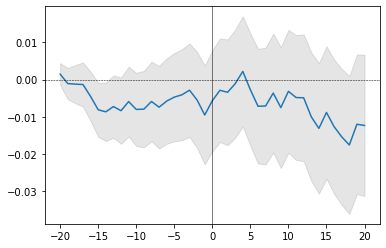

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.001        0.002   0.001         0.002   0.625    0.532
-19 -0.003        0.002  -0.001         0.003  -0.332    0.740
-18 -0.000        0.002  -0.001         0.004  -0.309    0.758
-17 -0.000        0.002  -0.001         0.005  -0.291    0.771
-16 -0.003        0.002  -0.005         0.005  -0.881    0.379
-15 -0.004        0.002  -0.008         0.006  -1.436    0.151
-14 -0.001        0.002  -0.009         0.006  -1.417    0.157
-13  0.001        0.002  -0.007         0.007  -1.111    0.267
-12 -0.001        0.002  -0.008         0.007  -1.207    0.228
-11  0.002        0.002  -0.006         0.007  -0.810    0.418
-10 -0.002        0.002  -0.008         0.008  -1.046    0.295
-9   0.000        0.002  -0.008         0.008  -0.993    0.321
-8   0.002        0.002  -0.006         0.008  -0.708    0.479
-7  -0.002        0.002  -0.007         0.009  -0.859    0.390
-6   0.002        0.002  -0.006         0.009  -0.647    0.518
-5   0.001        0.002  -0.005         0.009  -0.510    0.610
-4   0.001        0.002  -0.004         0.010  -0.431    0.667
-3   0.001        0.002  -0.003         0.010  -0.292    0.771
-2  -0.003        0.002  -0.006         0.010  -0.547    0.584
-1  -0.004        0.002   -0.01         0.010  -0.921    0.357
0    0.004        0.002  -0.006         0.011  -0.535    0.592
1    0.003        0.002  -0.003         0.011  -0.266    0.790
2   -0.001        0.002  -0.003         0.011  -0.309    0.757
3    0.002        0.002  -0.001         0.011  -0.099    0.921
4    0.003        0.002   0.002         0.012   0.188    0.851
5   -0.005        0.002  -0.003         0.012  -0.233    0.815
6   -0.004        0.002  -0.007         0.012  -0.597    0.551
7    0.000        0.002  -0.007         0.012  -0.581    0.561
8    0.003        0.002  -0.004         0.012  -0.291    0.771
9   -0.004        0.002  -0.008         0.013  -0.595    0.552
10   0.004        0.002  -0.003         0.013  -0.246    0.806
11  -0.002        0.002  -0.005         0.013  -0.369    0.712
12  -0.000        0.002  -0.005         0.013  -0.369    0.712
13  -0.005        0.002   -0.01         0.013  -0.742    0.458
14  -0.003        0.002  -0.013         0.014  -0.959    0.338
15   0.004        0.002  -0.009         0.014  -0.637    0.524
16  -0.004        0.002  -0.013         0.014  -0.900    0.368
17  -0.003        0.002  -0.015         0.014  -1.079    0.280
18  -0.002        0.002  -0.018         0.014  -1.218    0.223
19   0.006        0.002  -0.012         0.015  -0.821    0.412
20  -0.000        0.002  -0.012         0.015  -0.833    0.405

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.001     0.001     9.407     0.506 -0.136        -0.006         0.001   
-19 -0.001     0.002    36.508     3.413 -0.184        -0.011        -0.001   
-18 -0.001     0.003    26.795     1.920 -0.272        -0.014         0.000   
-17 -0.001     0.004    33.239     1.694 -0.366        -0.014        -0.000   
-16 -0.005     0.004    15.548     0.055 -0.340        -0.018        -0.002   
-15 -0.008     0.005    12.391     0.586 -0.315        -0.023        -0.003   
-14 -0.009     0.007    19.694    -0.880 -0.563        -0.027        -0.004   
-13 -0.007     0.007    12.988     0.460 -0.385        -0.030        -0.006   
-12 -0.008     0.008    10.149    -0.247 -0.441        -0.034        -0.005   
-11 -0.006     0.009    12.047     1.011 -0.429        -0.038        -0.005   
-10 -0.008     0.010     9.473     0.572 -0.454        -0.034        -0.009   
-9  -0.008     0.011     9.165     0.663 -0.421        -0.033        -0.006   
-8  -0.006     0.011    12.295     0.005 -0.588        -0.041        -0.004   
-7  -0.007     0.013     9.249     0.034 -0.531        -0.039        -0.002   
-6  -0.006     0.010     9.059    -0.548 -0.539        -0.036         0.001   
-5  -0.005     0.013    17.586    -1.312 -0.781        -0.042        -0.000   
-4  -0.004     0.013     9.786     0.068 -0.617        -0.044        -0.001   
-3  -0.003     0.015    10.504     0.069 -0.672        -0.040        -0.000   
-2  -0.006     0.017     9.137     0.249 -0.669        -0.046        -0.009   
-1  -0.010     0.017     9.137    -0.426 -0.705        -0.041        -0.006   
0   -0.006     0.017     8.626    -0.429 -0.665        -0.044        -0.002   
1   -0.003     0.018     8.973    -0.445 -0.724        -0.044         0.001   
2   -0.003     0.017     5.996    -0.208 -0.564        -0.043        -0.000   
3   -0.001     0.021     7.626     0.349 -0.622        -0.045         0.001   
4    0.002     0.024    11.519     1.221 -0.621        -0.048         0.003   
5   -0.003     0.025     9.373     0.436 -0.659        -0.049        -0.000   
6   -0.007     0.029    11.371     0.918 -0.623        -0.055        -0.006   
7   -0.007     0.028     9.690     0.704 -0.666        -0.056        -0.009   
8   -0.004     0.030     8.827     0.726 -0.699        -0.056        -0.007   
9   -0.008     0.027     8.417     0.377 -0.674        -0.050        -0.005   
10  -0.003     0.026     9.406     0.562 -0.646        -0.053         0.000   
11  -0.005     0.027     6.856     0.392 -0.575        -0.062        -0.002   
12  -0.005     0.030     8.398     0.629 -0.625        -0.063         0.006   
13  -0.010     0.032     7.187    -0.043 -0.698        -0.063         0.006   
14  -0.013     0.034     7.572    -0.300 -0.831        -0.072         0.009   
15  -0.009     0.033     9.097    -0.377 -0.882        -0.062         0.010   
16  -0.013     0.038     8.583    -0.875 -0.971        -0.062         0.006   
17  -0.015     0.044     9.556    -1.023 -1.068        -0.066         0.006   
18  -0.018     0.044     8.020    -1.000 -1.043        -0.070         0.000   
19  -0.012     0.042     6.505    -0.316 -0.864        -0.078         0.007   
20  -0.012     0.044     6.642    -0.448 -0.830        -0.076         0.008   

     Quantile 75%    Max  
-20         0.010  0.156  
-19         0.012  0.395  
-18         0.010  0.368  
-17         0.012  0.463  
-16         0.013  0.368  
-15         0.016  0.417  
-14         0.017  0.452  
-13         0.017  0.480  
-12         0.017  0.432  
-11         0.021  0.489  
-10         0.020  0.449  
-9          0.022  0.450  
-8          0.020  0.454  
-7          0.028  0.514  
-6          0.026  0.436  
-5          0.030  0.455  
-4          0.033  0.489  
-3          0.028  0.523  
-2          0.028  0.608  
-1          0.027  0.533  
0           0.030  0.511  
1           0.039  0.565  
2           0.042  0.561  
3           0.043  0.723  
4           

GS


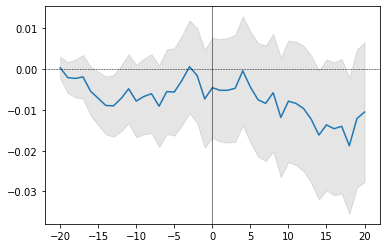

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.000        0.002     0.0         0.002   0.179    0.858
-19 -0.002        0.002  -0.002         0.003  -0.700    0.484
-18 -0.000        0.002  -0.002         0.004  -0.627    0.531
-17  0.000        0.002  -0.002         0.004  -0.451    0.652
-16 -0.004        0.002  -0.005         0.005  -1.156    0.248
-15 -0.002        0.002  -0.007         0.005  -1.396    0.163
-14 -0.002        0.002  -0.009         0.006  -1.609    0.108
-13 -0.000        0.002  -0.009         0.006  -1.524    0.128
-12  0.002        0.002  -0.007         0.006  -1.150    0.250
-11  0.002        0.002  -0.005         0.007  -0.728    0.467
-10 -0.003        0.002  -0.008         0.007  -1.129    0.259
-9   0.001        0.002  -0.007         0.007  -0.925    0.355
-8   0.001        0.002  -0.006         0.008  -0.798    0.425
-7  -0.003        0.002  -0.009         0.008  -1.161    0.246
-6   0.004        0.002  -0.006         0.008  -0.681    0.496
-5  -0.000        0.002  -0.006         0.008  -0.670    0.503
-4   0.003        0.002  -0.003         0.009  -0.319    0.749
-3   0.003        0.002   0.001         0.009   0.069    0.945
-2  -0.002        0.002  -0.002         0.009  -0.171    0.864
-1  -0.006        0.002  -0.007         0.009  -0.780    0.435
0    0.003        0.002  -0.005         0.010  -0.474    0.636
1   -0.001        0.002  -0.005         0.010  -0.529    0.597
2    0.000        0.002  -0.005         0.010  -0.517    0.605
3    0.000        0.002  -0.005         0.010  -0.458    0.647
4    0.004        0.002    -0.0         0.010  -0.038    0.970
5   -0.004        0.002  -0.004         0.011  -0.412    0.681
6   -0.003        0.002  -0.008         0.011  -0.691    0.490
7   -0.001        0.002  -0.008         0.011  -0.758    0.449
8    0.003        0.002  -0.006         0.011  -0.514    0.607
9   -0.006        0.002  -0.012         0.011  -1.034    0.301
10   0.004        0.002  -0.008         0.012  -0.675    0.500
11  -0.001        0.002  -0.008         0.012  -0.711    0.477
12  -0.001        0.002   -0.01         0.012  -0.806    0.421
13  -0.003        0.002  -0.012         0.012  -1.010    0.313
14  -0.004        0.002  -0.016         0.012  -1.307    0.191
15   0.002        0.002  -0.014         0.013  -1.090    0.276
16  -0.001        0.002  -0.015         0.013  -1.149    0.251
17   0.001        0.002  -0.014         0.013  -1.088    0.277
18  -0.005        0.002  -0.019         0.013  -1.440    0.150
19   0.007        0.002  -0.012         0.013  -0.917    0.359
20   0.002        0.002  -0.011         0.013  -0.786    0.432

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.000     0.001     5.413     0.247 -0.099        -0.010         0.002   
-19 -0.002     0.001     3.586    -0.438 -0.141        -0.017         0.000   
-18 -0.002     0.001     2.958     0.212 -0.112        -0.018        -0.002   
-17 -0.002     0.002     2.784    -0.284 -0.171        -0.023         0.000   
-16 -0.005     0.003     3.843    -0.677 -0.210        -0.028        -0.002   
-15 -0.007     0.004     3.493    -0.523 -0.258        -0.035        -0.007   
-14 -0.009     0.004     8.260    -1.492 -0.374        -0.039        -0.008   
-13 -0.009     0.005    10.935    -1.617 -0.445        -0.039        -0.006   
-12 -0.007     0.006     7.960    -0.905 -0.430        -0.045        -0.006   
-11 -0.005     0.005     2.915     0.260 -0.309        -0.050        -0.006   
-10 -0.008     0.007     4.510     0.858 -0.281        -0.056        -0.008   
-9  -0.007     0.008     4.618     0.986 -0.221        -0.059        -0.008   
-8  -0.006     0.009     2.781     0.003 -0.362        -0.063        -0.004   
-7  -0.009     0.009     3.602    -0.555 -0.443        -0.058        -0.009   
-6  -0.006     0.008     1.029     0.092 -0.311        -0.062        -0.009   
-5  -0.006     0.009     1.178     0.240 -0.292        -0.056        -0.008   
-4  -0.003     0.010     1.111     0.410 -0.261        -0.057        -0.006   
-3   0.001     0.011     2.161     0.737 -0.267        -0.061        -0.004   
-2  -0.002     0.014     1.677     0.599 -0.290        -0.071        -0.010   
-1  -0.007     0.016     1.786     0.415 -0.367        -0.080        -0.010   
0   -0.005     0.017     2.041     0.323 -0.418        -0.080        -0.003   
1   -0.005     0.017     1.451     0.165 -0.427        -0.084        -0.002   
2   -0.005     0.020     3.278    -0.273 -0.575        -0.086        -0.001   
3   -0.005     0.022     3.919    -0.344 -0.695        -0.086         0.002   
4   -0.000     0.021     1.577     0.405 -0.431        -0.082        -0.007   
5   -0.004     0.019     0.732     0.295 -0.399        -0.092        -0.011   
6   -0.008     0.021     0.424     0.059 -0.426        -0.101        -0.005   
7   -0.008     0.023     0.484     0.170 -0.410        -0.098        -0.012   
8   -0.006     0.025     0.608     0.189 -0.430        -0.093        -0.012   
9   -0.012     0.027     1.365    -0.145 -0.604        -0.108        -0.018   
10  -0.008     0.027     1.503     0.468 -0.467        -0.099        -0.020   
11  -0.008     0.029     1.873     0.263 -0.603        -0.099        -0.014   
12  -0.010     0.030     1.631     0.359 -0.500        -0.101        -0.013   
13  -0.012     0.032     1.913     0.285 -0.581        -0.106        -0.017   
14  -0.016     0.033     2.235     0.005 -0.646        -0.102        -0.017   
15  -0.014     0.032     2.003    -0.019 -0.644        -0.104        -0.017   
16  -0.015     0.033     2.839    -0.193 -0.777        -0.102        -0.013   
17  -0.014     0.036     3.095    -0.420 -0.862        -0.108        -0.018   
18  -0.019     0.037     2.251    -0.448 -0.777        -0.119        -0.014   
19  -0.012     0.036     0.707     0.085 -0.561        -0.131        -0.011   
20  -0.011     0.036     1.137     0.311 -0.484        -0.131        -0.016   

     Quantile 75%    Max  
-20         0.009  0.113  
-19         0.014  0.099  
-18         0.015  0.136  
-17         0.021  0.144  
-16         0.018  0.160  
-15         0.019  0.177  
-14         0.026  0.179  
-13         0.025  0.205  
-12         0.029  0.252  
-11         0.028  0.234  
-10         0.032  0.373  
-9          0.040  0.429  
-8          0.043  0.286  
-7          0.047  0.249  
-6          0.051  0.279  
-5          0.051  0.316  
-4          0.053  0.334  
-3          0.061  0.437  
-2          0.062  0.429  
-1          0.060  0.459  
0           0.062  0.491  
1           0.057  0.419  
2           0.066  0.493  
3           0.066  0.517  
4           

MS_N


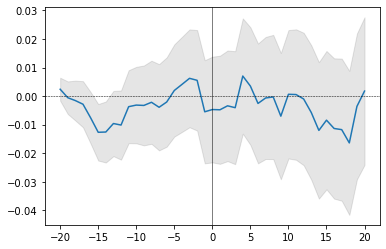

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.002        0.003   0.002         0.003   0.761    0.447
-19 -0.003        0.003  -0.001         0.004  -0.128    0.898
-18 -0.001        0.003  -0.002         0.005  -0.290    0.772
-17 -0.001        0.003  -0.003         0.006  -0.453    0.651
-16 -0.005        0.003  -0.008         0.007  -1.079    0.281
-15 -0.005        0.003  -0.013         0.008  -1.643    0.100
-14  0.000        0.003  -0.013         0.008  -1.510    0.131
-13  0.003        0.003   -0.01         0.009  -1.079    0.281
-12 -0.001        0.003   -0.01         0.009  -1.074    0.283
-11  0.006        0.003  -0.004         0.010  -0.373    0.709
-10  0.001        0.003  -0.003         0.010  -0.302    0.763
-9  -0.000        0.003  -0.003         0.011  -0.300    0.764
-8   0.001        0.003  -0.002         0.011  -0.191    0.848
-7  -0.002        0.003  -0.004         0.012  -0.333    0.739
-6   0.002        0.003  -0.002         0.012  -0.171    0.865
-5   0.004        0.003   0.002         0.013   0.155    0.876
-4   0.002        0.003   0.004         0.013   0.314    0.754
-3   0.002        0.003   0.006         0.013   0.465    0.642
-2  -0.001        0.003   0.006         0.014   0.402    0.688
-1  -0.011        0.003  -0.006         0.014  -0.391    0.696
0    0.001        0.003  -0.005         0.014  -0.327    0.744
1   -0.000        0.003  -0.005         0.015  -0.325    0.745
2    0.001        0.003  -0.003         0.015  -0.226    0.821
3   -0.001        0.003  -0.004         0.015  -0.264    0.792
4    0.011        0.003   0.007         0.016   0.446    0.656
5   -0.004        0.003   0.003         0.016   0.217    0.828
6   -0.006        0.003  -0.003         0.016  -0.157    0.875
7    0.002        0.003  -0.001         0.017  -0.040    0.968
8    0.000        0.003    -0.0         0.017  -0.018    0.985
9   -0.007        0.003  -0.007         0.017  -0.407    0.684
10   0.008        0.003   0.001         0.018   0.035    0.972
11  -0.000        0.003   0.001         0.018   0.030    0.976
12  -0.002        0.003  -0.001         0.018  -0.056    0.955
13  -0.005        0.003  -0.006         0.018  -0.313    0.754
14  -0.006        0.003  -0.012         0.019  -0.645    0.519
15   0.004        0.003  -0.008         0.019  -0.446    0.655
16  -0.003        0.003  -0.011         0.019  -0.592    0.554
17  -0.000        0.003  -0.012         0.019  -0.605    0.545
18  -0.005        0.003  -0.016         0.020  -0.834    0.405
19   0.013        0.003  -0.004         0.020  -0.182    0.856
20   0.005        0.003   0.002         0.020   0.087    0.931

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.002     0.001     9.691     1.599 -0.131        -0.010        -0.001   
-19 -0.001     0.002     8.330     0.967 -0.196        -0.018         0.001   
-18 -0.002     0.003    11.678     1.264 -0.194        -0.021        -0.001   
-17 -0.003     0.003     2.803     0.334 -0.165        -0.026        -0.001   
-16 -0.008     0.005     6.763    -0.481 -0.312        -0.029        -0.005   
-15 -0.013     0.007     7.428    -1.024 -0.403        -0.037        -0.007   
-14 -0.013     0.009    12.573    -1.481 -0.598        -0.051        -0.006   
-13 -0.010     0.011    11.301    -1.544 -0.570        -0.050        -0.005   
-12 -0.010     0.013    18.473    -2.189 -0.800        -0.056        -0.003   
-11 -0.004     0.008     3.289     0.295 -0.370        -0.053        -0.004   
-10 -0.003     0.012     6.477     1.371 -0.339        -0.060        -0.004   
-9  -0.003     0.014     8.275     1.013 -0.452        -0.053         0.001   
-8  -0.002     0.016     5.159    -0.086 -0.542        -0.055        -0.006   
-7  -0.004     0.018     5.101    -0.342 -0.538        -0.064        -0.003   
-6  -0.002     0.017     5.331    -0.022 -0.589        -0.065         0.000   
-5   0.002     0.017     4.182     0.245 -0.512        -0.060        -0.000   
-4   0.004     0.016     4.785     0.643 -0.475        -0.052        -0.001   
-3   0.006     0.021     8.676     1.091 -0.546        -0.049         0.004   
-2   0.006     0.022     7.752     1.249 -0.513        -0.062         0.004   
-1  -0.006     0.023     5.906     0.915 -0.547        -0.067        -0.004   
0   -0.005     0.027     7.762     0.127 -0.784        -0.072         0.008   
1   -0.005     0.029     7.056    -0.004 -0.818        -0.069         0.013   
2   -0.003     0.033    10.647    -0.969 -1.086        -0.075         0.007   
3   -0.004     0.038    15.573    -1.483 -1.309        -0.075         0.004   
4    0.007     0.026     5.874     1.377 -0.383        -0.066         0.010   
5    0.003     0.024     4.668     1.235 -0.361        -0.072         0.007   
6   -0.003     0.026     2.679     0.135 -0.592        -0.086         0.010   
7   -0.001     0.029     2.682     0.374 -0.614        -0.089         0.005   
8   -0.000     0.035     4.426     0.019 -0.858        -0.095         0.006   
9   -0.007     0.040     7.587    -0.812 -1.128        -0.110         0.008   
10   0.001     0.030     2.285     0.692 -0.464        -0.098         0.010   
11   0.001     0.033     2.496     0.672 -0.509        -0.098         0.006   
12  -0.001     0.033     1.895     0.332 -0.565        -0.100         0.006   
13  -0.006     0.035     2.756     0.232 -0.640        -0.104         0.003   
14  -0.012     0.037     3.630    -0.156 -0.736        -0.102         0.001   
15  -0.008     0.035     2.947     0.230 -0.631        -0.100         0.002   
16  -0.011     0.036     2.911     0.269 -0.644        -0.110         0.001   
17  -0.012     0.039     2.718     0.016 -0.717        -0.110        -0.005   
18  -0.016     0.044     5.184    -0.426 -1.040        -0.108        -0.013   
19  -0.004     0.037     2.913     0.506 -0.661        -0.102         0.010   
20   0.002     0.040     3.229     0.649 -0.677        -0.095         0.009   

     Quantile 75%    Max  
-20         0.013  0.208  
-19         0.016  0.236  
-18         0.019  0.316  
-17         0.016  0.198  
-16         0.023  0.313  
-15         0.028  0.334  
-14         0.029  0.410  
-13         0.033  0.341  
-12         0.038  0.378  
-11         0.041  0.320  
-10         0.045  0.525  
-9          0.050  0.624  
-8          0.054  0.510  
-7          0.069  0.550  
-6          0.065  0.586  
-5          0.060  0.529  
-4          0.059  0.583  
-3          0.063  0.813  
-2          0.062  0.792  
-1          0.055  0.686  
0           0.062  0.783  
1           0.064  0.717  
2           0.070  0.686  
3           0.069  0.737  
4           

HSBA_L


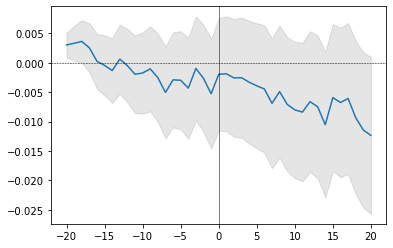

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-20  0.003        0.002  0.003 *         0.002   1.863    0.062
-19  0.000        0.002    0.003         0.002   1.445    0.149
-18  0.000        0.002    0.004         0.003   1.289    0.197
-17 -0.001        0.002    0.003         0.003   0.782    0.434
-16 -0.002        0.002      0.0         0.004   0.072    0.942
-15 -0.001        0.002     -0.0         0.004  -0.110    0.912
-14 -0.001        0.002   -0.001         0.004  -0.307    0.759
-13  0.002        0.002    0.001         0.005   0.135    0.892
-12 -0.001        0.002     -0.0         0.005  -0.100    0.920
-11 -0.001        0.002   -0.002         0.005  -0.380    0.704
-10  0.000        0.002   -0.002         0.005  -0.321    0.748
-9   0.001        0.002   -0.001         0.006  -0.183    0.855
-8  -0.002        0.002   -0.003         0.006  -0.431    0.666
-7  -0.003        0.002   -0.005         0.006  -0.828    0.408
-6   0.002        0.002   -0.003         0.006  -0.460    0.645
-5  -0.000        0.002   -0.003         0.007  -0.456    0.649
-4  -0.001        0.002   -0.004         0.007  -0.642    0.521
-3   0.003        0.002   -0.001         0.007  -0.138    0.890
-2  -0.002        0.002   -0.003         0.007  -0.373    0.709
-1  -0.003        0.002   -0.005         0.007  -0.722    0.470
0    0.003        0.002   -0.002         0.007  -0.263    0.793
1    0.000        0.002   -0.002         0.008  -0.244    0.807
2   -0.001        0.002   -0.003         0.008  -0.329    0.742
3    0.000        0.002   -0.003         0.008  -0.318    0.751
4   -0.001        0.002   -0.003         0.008  -0.406    0.685
5   -0.001        0.002   -0.004         0.008  -0.472    0.637
6   -0.001        0.002   -0.004         0.008  -0.527    0.598
7   -0.002        0.002   -0.007         0.009  -0.801    0.423
8    0.002        0.002   -0.005         0.009  -0.559    0.576
9   -0.002        0.002   -0.007         0.009  -0.793    0.428
10  -0.001        0.002   -0.008         0.009  -0.884    0.377
11  -0.000        0.002   -0.008         0.009  -0.911    0.362
12   0.002        0.002   -0.007         0.009  -0.707    0.480
13  -0.001        0.002   -0.007         0.009  -0.788    0.431
14  -0.003        0.002   -0.011         0.010  -1.094    0.274
15   0.005        0.002   -0.006         0.010  -0.607    0.544
16  -0.001        0.002   -0.007         0.010  -0.682    0.495
17   0.001        0.002   -0.006         0.010  -0.605    0.545
18  -0.003        0.002   -0.009         0.010  -0.917    0.359
19  -0.002        0.002   -0.011         0.010  -1.111    0.267
20  -0.001        0.002   -0.012         0.010  -1.185    0.236

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.003     0.000     7.446     0.939 -0.068        -0.006         0.002   
-19  0.003     0.001    13.300     1.896 -0.082        -0.008         0.002   
-18  0.004     0.001    16.959     2.650 -0.059        -0.013         0.000   
-17  0.003     0.001    14.880     2.337 -0.096        -0.018        -0.000   
-16  0.000     0.002     7.254     1.224 -0.155        -0.023        -0.003   
-15 -0.000     0.003     5.973     0.783 -0.170        -0.021        -0.005   
-14 -0.001     0.003     9.530    -0.441 -0.308        -0.023        -0.003   
-13  0.001     0.003     5.647     0.288 -0.230        -0.022        -0.000   
-12 -0.000     0.003     3.690     0.189 -0.212        -0.028        -0.002   
-11 -0.002     0.004     5.683     0.498 -0.227        -0.032        -0.004   
-10 -0.002     0.004     7.985     1.270 -0.242        -0.030        -0.005   
-9  -0.001     0.004     6.370     1.379 -0.211        -0.034        -0.005   
-8  -0.003     0.005     6.350     0.936 -0.276        -0.034        -0.008   
-7  -0.005     0.005     6.701     0.565 -0.317        -0.036        -0.009   
-6  -0.003     0.005     7.098    -0.029 -0.370        -0.039        -0.007   
-5  -0.003     0.005     4.226     0.786 -0.217        -0.042        -0.008   
-4  -0.004     0.005     4.564     0.860 -0.268        -0.042        -0.011   
-3  -0.001     0.006     5.535     1.395 -0.208        -0.042        -0.007   
-2  -0.003     0.007     4.743     1.049 -0.276        -0.048        -0.008   
-1  -0.005     0.007     4.638     0.509 -0.346        -0.052        -0.008   
0   -0.002     0.007     2.925     0.490 -0.272        -0.050        -0.004   
1   -0.002     0.007     4.272     0.278 -0.385        -0.047        -0.005   
2   -0.003     0.007     3.057     0.661 -0.321        -0.054        -0.004   
3   -0.003     0.008     4.696     1.099 -0.304        -0.051        -0.010   
4   -0.003     0.009     5.699     1.189 -0.327        -0.054        -0.009   
5   -0.004     0.009     7.799     1.750 -0.262        -0.056        -0.009   
6   -0.004     0.010     9.871     2.063 -0.267        -0.058        -0.007   
7   -0.007     0.010     8.520     1.994 -0.200        -0.068        -0.007   
8   -0.005     0.010     6.830     1.737 -0.204        -0.066        -0.008   
9   -0.007     0.010     5.559     1.539 -0.208        -0.062        -0.010   
10  -0.008     0.011     5.799     1.490 -0.268        -0.067        -0.015   
11  -0.008     0.011     4.851     1.333 -0.295        -0.061        -0.017   
12  -0.007     0.013     5.523     1.473 -0.299        -0.065        -0.015   
13  -0.007     0.013     6.452     1.490 -0.269        -0.063        -0.014   
14  -0.011     0.014     5.960     1.325 -0.335        -0.072        -0.014   
15  -0.006     0.014     5.388     1.370 -0.273        -0.072        -0.007   
16  -0.007     0.014     5.615     1.328 -0.370        -0.073        -0.010   
17  -0.006     0.015     5.404     1.202 -0.412        -0.067        -0.010   
18  -0.009     0.016     5.463     1.310 -0.397        -0.076        -0.013   
19  -0.011     0.017     4.967     1.285 -0.338        -0.073        -0.017   
20  -0.012     0.017     5.811     1.437 -0.370        -0.080        -0.018   

     Quantile 75%    Max  
-20         0.012  0.099  
-19         0.013  0.169  
-18         0.015  0.213  
-17         0.017  0.253  
-16         0.017  0.242  
-15         0.020  0.253  
-14         0.018  0.228  
-13         0.025  0.241  
-12         0.028  0.223  
-11         0.024  0.273  
-10         0.021  0.328  
-9          0.024  0.335  
-8          0.026  0.301  
-7          0.028  0.315  
-6          0.034  0.303  
-5          0.033  0.330  
-4          0.036  0.349  
-3          0.034  0.387  
-2          0.037  0.388  
-1          0.034  0.357  
0           0.036  0.323  
1           0.035  0.315  
2           0.038  0.314  
3           0.037  0.420  
4           

BNPP_PA


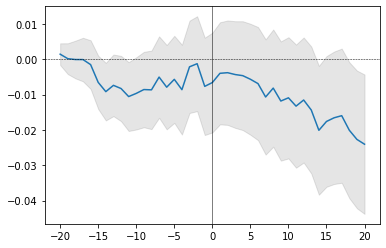

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.001        0.002   0.001         0.002   0.605    0.545
-19 -0.001        0.002     0.0         0.003   0.055    0.956
-18 -0.000        0.002    -0.0         0.004  -0.013    0.990
-17 -0.000        0.002    -0.0         0.005  -0.014    0.989
-16 -0.001        0.002  -0.001         0.005  -0.278    0.781
-15 -0.005        0.002  -0.007         0.006  -1.109    0.268
-14 -0.003        0.002  -0.009         0.006  -1.438    0.150
-13  0.002        0.002  -0.007         0.007  -1.083    0.279
-12 -0.001        0.002  -0.008         0.007  -1.146    0.252
-11 -0.002        0.002  -0.011         0.008  -1.386    0.166
-10  0.001        0.002   -0.01         0.008  -1.209    0.227
-9   0.001        0.002  -0.009         0.008  -1.027    0.304
-8  -0.000        0.002  -0.009         0.009  -0.997    0.319
-7   0.004        0.002  -0.005         0.009  -0.558    0.577
-6  -0.003        0.002  -0.008         0.009  -0.847    0.397
-5   0.002        0.002  -0.006         0.010  -0.589    0.556
-4  -0.003        0.002  -0.009         0.010  -0.866    0.386
-3   0.006        0.002  -0.002         0.010  -0.208    0.836
-2   0.001        0.002  -0.001         0.010  -0.118    0.906
-1  -0.006        0.002  -0.008         0.011  -0.712    0.477
0    0.001        0.002  -0.007         0.011  -0.596    0.551
1    0.003        0.002  -0.004         0.011  -0.351    0.726
2    0.000        0.002  -0.004         0.012  -0.328    0.743
3   -0.001        0.002  -0.004         0.012  -0.365    0.715
4   -0.000        0.002  -0.005         0.012  -0.385    0.700
5   -0.001        0.002  -0.006         0.012  -0.460    0.646
6   -0.001        0.002  -0.007         0.013  -0.550    0.582
7   -0.004        0.002  -0.011         0.013  -0.838    0.402
8    0.003        0.002  -0.008         0.013  -0.629    0.529
9   -0.004        0.002  -0.012         0.013  -0.896    0.370
10   0.001        0.002  -0.011         0.013  -0.814    0.416
11  -0.002        0.002  -0.013         0.014  -0.974    0.330
12   0.002        0.002  -0.012         0.014  -0.834    0.404
13  -0.003        0.002  -0.014         0.014  -1.024    0.306
14  -0.006        0.002   -0.02         0.014  -1.412    0.158
15   0.003        0.002  -0.018         0.014  -1.219    0.223
16   0.001        0.002  -0.017         0.015  -1.131    0.258
17   0.001        0.002  -0.016         0.015  -1.076    0.282
18  -0.004        0.002   -0.02         0.015  -1.337    0.181
19  -0.003        0.002  -0.023         0.015  -1.491    0.136
20  -0.001        0.002  -0.024         0.015  -1.561    0.119

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.001     0.001     1.645    -0.369 -0.099        -0.013         0.004   
-19  0.000     0.002     2.669     0.044 -0.139        -0.020        -0.002   
-18 -0.000     0.002     4.011     0.552 -0.172        -0.026        -0.002   
-17 -0.000     0.003     3.724     0.187 -0.208        -0.023        -0.001   
-16 -0.001     0.004     2.631     0.217 -0.237        -0.041        -0.003   
-15 -0.007     0.007     4.315     0.070 -0.334        -0.043        -0.002   
-14 -0.009     0.008     5.984     0.010 -0.359        -0.048        -0.006   
-13 -0.007     0.008     5.531     0.143 -0.346        -0.051        -0.004   
-12 -0.008     0.008     4.239     0.027 -0.351        -0.063        -0.005   
-11 -0.011     0.009     4.432    -0.162 -0.415        -0.056        -0.006   
-10 -0.010     0.009     1.861     0.376 -0.247        -0.063        -0.006   
-9  -0.009     0.008     1.729     0.354 -0.287        -0.062        -0.011   
-8  -0.009     0.007     1.419     0.497 -0.219        -0.068        -0.013   
-7  -0.005     0.008     2.054     0.646 -0.263        -0.060        -0.010   
-6  -0.008     0.010     3.131     0.429 -0.327        -0.055        -0.009   
-5  -0.006     0.009     1.664     0.321 -0.269        -0.060        -0.004   
-4  -0.009     0.011     1.478     0.309 -0.301        -0.066        -0.008   
-3  -0.002     0.014     3.933     0.873 -0.357        -0.064        -0.010   
-2  -0.001     0.016     3.528     0.792 -0.333        -0.071        -0.009   
-1  -0.008     0.018     2.688     0.464 -0.375        -0.072        -0.012   
0   -0.007     0.018     2.704     0.010 -0.443        -0.069        -0.003   
1   -0.004     0.020     3.503    -0.083 -0.560        -0.067        -0.009   
2   -0.004     0.021     3.732     0.169 -0.539        -0.072        -0.002   
3   -0.004     0.021     2.972     0.133 -0.573        -0.076        -0.011   
4   -0.005     0.026     3.460     0.198 -0.649        -0.090        -0.012   
5   -0.006     0.024     2.118     0.503 -0.459        -0.088        -0.018   
6   -0.007     0.025     2.075     0.556 -0.458        -0.098        -0.011   
7   -0.011     0.027     2.197     0.659 -0.440        -0.112        -0.019   
8   -0.008     0.029     2.270     0.405 -0.579        -0.105        -0.000   
9   -0.012     0.028     1.654     0.191 -0.585        -0.114        -0.014   
10  -0.011     0.030     1.774     0.220 -0.569        -0.113        -0.004   
11  -0.013     0.032     2.372     0.311 -0.617        -0.120        -0.011   
12  -0.012     0.034     3.268     0.690 -0.513        -0.115        -0.021   
13  -0.014     0.034     3.001     0.654 -0.532        -0.123        -0.019   
14  -0.020     0.034     2.659     0.489 -0.543        -0.120        -0.032   
15  -0.018     0.034     2.486     0.434 -0.579        -0.117        -0.027   
16  -0.017     0.036     2.794     0.455 -0.624        -0.132        -0.024   
17  -0.016     0.037     3.226     0.509 -0.653        -0.134        -0.031   
18  -0.020     0.042     3.764     0.760 -0.634        -0.131        -0.039   
19  -0.023     0.041     3.263     0.826 -0.556        -0.146        -0.039   
20  -0.024     0.044     3.616     0.859 -0.563        -0.137        -0.044   

     Quantile 75%    Max  
-20         0.015  0.075  
-19         0.022  0.155  
-18         0.021  0.195  
-17         0.022  0.210  
-16         0.033  0.234  
-15         0.033  0.332  
-14         0.032  0.362  
-13         0.038  0.387  
-12         0.049  0.383  
-11         0.043  0.380  
-10         0.040  0.352  
-9          0.038  0.305  
-8          0.039  0.312  
-7          0.037  0.329  
-6          0.040  0.363  
-5          0.041  0.321  
-4          0.038  0.341  
-3          0.043  0.531  
-2          0.048  0.565  
-1          0.042  0.459  
0           0.044  0.470  
1           0.049  0.508  
2           0.044  0.558  
3           0.071  0.534  
4           

CAGR_PA


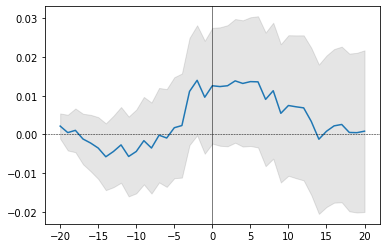

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.002        0.003   0.002         0.003   0.842    0.400
-19 -0.002        0.003     0.0         0.004   0.127    0.899
-18  0.001        0.003   0.001         0.004   0.236    0.813
-17 -0.002        0.003  -0.001         0.005  -0.236    0.814
-16 -0.001        0.003  -0.002         0.006  -0.393    0.694
-15 -0.001        0.003  -0.004         0.006  -0.567    0.571
-14 -0.002        0.003  -0.006         0.007  -0.859    0.390
-13  0.001        0.003  -0.004         0.007  -0.615    0.539
-12  0.002        0.003  -0.003         0.008  -0.356    0.722
-11 -0.003        0.003  -0.006         0.008  -0.710    0.478
-10  0.001        0.003  -0.004         0.008  -0.523    0.601
-9   0.003        0.003  -0.002         0.009  -0.184    0.854
-8  -0.002        0.003  -0.004         0.009  -0.385    0.700
-7   0.003        0.003    -0.0         0.010  -0.022    0.983
-6  -0.001        0.003  -0.001         0.010  -0.095    0.924
-5   0.003        0.003   0.002         0.010   0.169    0.866
-4   0.001        0.003   0.002         0.011   0.217    0.828
-3   0.009        0.003   0.011         0.011   1.027    0.304
-2   0.003        0.003   0.014         0.011   1.259    0.208
-1  -0.004        0.003    0.01         0.011   0.843    0.399
0    0.003        0.003   0.013         0.012   1.077    0.281
1   -0.000        0.003   0.012         0.012   1.035    0.301
2    0.000        0.003   0.013         0.012   1.029    0.303
3    0.001        0.003   0.014         0.012   1.109    0.268
4   -0.001        0.003   0.013         0.013   1.034    0.301
5    0.000        0.003   0.014         0.013   1.050    0.294
6   -0.000        0.003   0.014         0.013   1.026    0.305
7   -0.005        0.003   0.009         0.013   0.671    0.502
8    0.002        0.003   0.011         0.014   0.823    0.410
9   -0.006        0.003   0.005         0.014   0.390    0.696
10   0.002        0.003   0.007         0.014   0.526    0.599
11  -0.000        0.003   0.007         0.014   0.495    0.621
12  -0.000        0.003   0.007         0.015   0.468    0.639
13  -0.004        0.003   0.003         0.015   0.225    0.822
14  -0.005        0.003  -0.001         0.015  -0.083    0.934
15   0.002        0.003   0.001         0.015   0.053    0.958
16   0.001        0.003   0.002         0.016   0.142    0.887
17   0.000        0.003   0.003         0.016   0.163    0.870
18  -0.002        0.003     0.0         0.016   0.031    0.975
19  -0.000        0.003     0.0         0.016   0.027    0.978
20   0.000        0.003   0.001         0.016   0.051    0.960

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.002     0.001     1.562     0.474 -0.069        -0.013         0.005   
-19  0.000     0.002     2.526    -0.104 -0.172        -0.018         0.000   
-18  0.001     0.002     3.344     0.159 -0.168        -0.024         0.004   
-17 -0.001     0.003     2.579     0.022 -0.222        -0.025        -0.003   
-16 -0.002     0.004     2.046    -0.249 -0.244        -0.026        -0.000   
-15 -0.004     0.005     2.994    -0.354 -0.301        -0.038         0.003   
-14 -0.006     0.006     2.756     0.148 -0.248        -0.041        -0.005   
-13 -0.004     0.006     1.386     0.323 -0.211        -0.054        -0.008   
-12 -0.003     0.007     1.370     0.346 -0.217        -0.060        -0.004   
-11 -0.006     0.008     0.845     0.085 -0.265        -0.057        -0.010   
-10 -0.004     0.009     1.373    -0.022 -0.303        -0.061        -0.012   
-9  -0.002     0.010     2.530     0.419 -0.276        -0.055        -0.014   
-8  -0.004     0.011     0.792     0.168 -0.277        -0.062        -0.011   
-7  -0.000     0.012     0.797    -0.149 -0.343        -0.064        -0.015   
-6  -0.001     0.012     0.905    -0.296 -0.340        -0.064        -0.003   
-5   0.002     0.011     0.553    -0.021 -0.295        -0.055         0.004   
-4   0.002     0.013     0.767     0.065 -0.305        -0.054         0.003   
-3   0.011     0.016     3.513     0.721 -0.337        -0.059         0.010   
-2   0.014     0.018     2.981     0.712 -0.311        -0.064         0.016   
-1   0.010     0.021     1.666     0.342 -0.367        -0.076         0.015   
0    0.013     0.021     1.706     0.229 -0.370        -0.056         0.008   
1    0.012     0.022     1.532     0.272 -0.417        -0.067         0.008   
2    0.013     0.024     2.003     0.229 -0.484        -0.062         0.003   
3    0.014     0.026     1.449     0.298 -0.418        -0.074         0.009   
4    0.013     0.028     0.999     0.244 -0.411        -0.084        -0.001   
5    0.014     0.029     0.861     0.177 -0.426        -0.078         0.012   
6    0.014     0.030     0.400     0.107 -0.445        -0.098         0.005   
7    0.009     0.033     0.357     0.166 -0.459        -0.110        -0.008   
8    0.011     0.035     0.450     0.006 -0.484        -0.110         0.009   
9    0.005     0.036     0.554    -0.076 -0.500        -0.107         0.005   
10   0.007     0.034     0.192    -0.129 -0.489        -0.120         0.007   
11   0.007     0.037     0.266    -0.058 -0.533        -0.116         0.012   
12   0.007     0.041     0.278    -0.103 -0.557        -0.122         0.005   
13   0.003     0.044     0.503    -0.059 -0.615        -0.133         0.006   
14  -0.001     0.044     0.510    -0.177 -0.593        -0.135         0.009   
15   0.001     0.044     0.548    -0.142 -0.628        -0.126         0.015   
16   0.002     0.044     0.413    -0.045 -0.610        -0.133         0.014   
17   0.003     0.046     0.554     0.028 -0.613        -0.140         0.011   
18   0.000     0.048     0.471     0.103 -0.583        -0.127         0.004   
19   0.000     0.050     0.328     0.113 -0.634        -0.151         0.011   
20   0.001     0.051     0.480     0.203 -0.634        -0.151         0.006   

     Quantile 75%    Max  
-20         0.015  0.096  
-19         0.020  0.140  
-18         0.023  0.203  
-17         0.023  0.189  
-16         0.030  0.198  
-15         0.038  0.249  
-14         0.034  0.304  
-13         0.048  0.287  
-12         0.050  0.289  
-11         0.056  0.288  
-10         0.058  0.347  
-9          0.067  0.455  
-8          0.072  0.369  
-7          0.070  0.336  
-6          0.066  0.297  
-5          0.064  0.310  
-4          0.069  0.350  
-3          0.073  0.590  
-2          0.077  0.617  
-1          0.075  0.525  
0           0.086  0.546  
1           0.086  0.543  
2           0.081  0.583  
3           0.106  0.603  
4           

SAN_MC


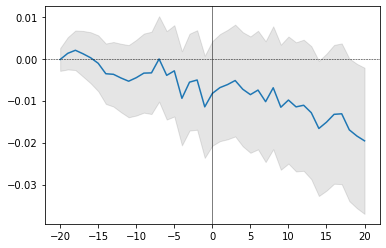

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20 -0.000        0.002    -0.0         0.002  -0.086    0.932
-19  0.001        0.002   0.001         0.003   0.429    0.668
-18  0.001        0.002   0.002         0.004   0.548    0.584
-17 -0.001        0.002   0.001         0.004   0.279    0.780
-16 -0.001        0.002     0.0         0.005   0.049    0.961
-15 -0.001        0.002  -0.001         0.005  -0.210    0.833
-14 -0.002        0.002  -0.004         0.006  -0.637    0.524
-13 -0.000        0.002  -0.004         0.006  -0.618    0.536
-12 -0.001        0.002  -0.005         0.006  -0.722    0.470
-11 -0.001        0.002  -0.005         0.007  -0.798    0.425
-10  0.001        0.002  -0.005         0.007  -0.643    0.521
-9   0.001        0.002  -0.003         0.007  -0.467    0.641
-8   0.000        0.002  -0.003         0.008  -0.441    0.659
-7   0.003        0.002    -0.0         0.008  -0.007    0.994
-6  -0.004        0.002  -0.004         0.008  -0.482    0.630
-5   0.001        0.002  -0.003         0.008  -0.340    0.734
-4  -0.007        0.002  -0.009         0.009  -1.079    0.281
-3   0.004        0.002  -0.006         0.009  -0.620    0.535
-2   0.001        0.002  -0.005         0.009  -0.548    0.584
-1  -0.006        0.002  -0.011         0.009  -1.208    0.227
0    0.003        0.002  -0.008         0.010  -0.850    0.396
1    0.001        0.002  -0.007         0.010  -0.691    0.489
2    0.001        0.002  -0.006         0.010  -0.605    0.545
3    0.001        0.002  -0.005         0.010  -0.500    0.617
4   -0.002        0.002  -0.007         0.011  -0.686    0.493
5   -0.001        0.002  -0.009         0.011  -0.791    0.429
6    0.001        0.002  -0.007         0.011  -0.678    0.498
7   -0.003        0.002   -0.01         0.011  -0.912    0.362
8    0.003        0.002  -0.007         0.011  -0.606    0.545
9   -0.005        0.002  -0.012         0.012  -0.994    0.320
10   0.002        0.002   -0.01         0.012  -0.834    0.405
11  -0.002        0.002  -0.011         0.012  -0.956    0.339
12   0.000        0.002  -0.011         0.012  -0.910    0.363
13  -0.002        0.002  -0.013         0.012  -1.039    0.299
14  -0.004        0.002  -0.017         0.013  -1.324    0.186
15   0.002        0.002  -0.015         0.013  -1.187    0.235
16   0.002        0.002  -0.013         0.013  -1.026    0.305
17   0.000        0.002  -0.013         0.013  -1.003    0.316
18  -0.004        0.002  -0.017         0.013  -1.279    0.201
19  -0.001        0.002  -0.018         0.013  -1.373    0.170
20  -0.001        0.002   -0.02         0.014  -1.440    0.150

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20 -0.000     0.001     4.083    -1.080 -0.114        -0.011         0.002   
-19  0.001     0.001     3.308    -0.982 -0.144        -0.013         0.002   
-18  0.002     0.001     0.868    -0.274 -0.099        -0.017         0.006   
-17  0.001     0.002     2.181    -0.238 -0.163        -0.021         0.001   
-16  0.000     0.003     1.204    -0.371 -0.182        -0.027         0.001   
-15 -0.001     0.004     1.699    -0.034 -0.190        -0.035         0.000   
-14 -0.004     0.004     1.870    -0.307 -0.246        -0.039         0.002   
-13 -0.004     0.004     1.768     0.273 -0.215        -0.050         0.001   
-12 -0.005     0.005     1.451    -0.003 -0.216        -0.053        -0.002   
-11 -0.005     0.006     1.389    -0.011 -0.213        -0.050        -0.007   
-10 -0.005     0.007     0.936     0.047 -0.239        -0.055        -0.007   
-9  -0.003     0.007     0.104     0.036 -0.212        -0.053        -0.006   
-8  -0.003     0.008     0.834    -0.195 -0.278        -0.053        -0.003   
-7  -0.000     0.009     1.008    -0.084 -0.291        -0.062        -0.002   
-6  -0.004     0.009     2.162    -0.157 -0.328        -0.058        -0.005   
-5  -0.003     0.009     0.980     0.037 -0.243        -0.054        -0.003   
-4  -0.009     0.011     0.633    -0.113 -0.301        -0.063        -0.007   
-3  -0.006     0.011     1.147     0.058 -0.347        -0.066        -0.004   
-2  -0.005     0.013     2.207    -0.108 -0.478        -0.073        -0.005   
-1  -0.011     0.015     2.707    -0.221 -0.532        -0.082        -0.002   
0   -0.008     0.015     2.320    -0.362 -0.528        -0.089        -0.005   
1   -0.007     0.014     0.539    -0.101 -0.361        -0.083        -0.001   
2   -0.006     0.015     0.205     0.052 -0.322        -0.085        -0.008   
3   -0.005     0.015    -0.026     0.058 -0.295        -0.082        -0.006   
4   -0.007     0.016    -0.092     0.154 -0.319        -0.105        -0.007   
5   -0.009     0.017     0.094     0.202 -0.371        -0.099        -0.014   
6   -0.007     0.018    -0.063     0.214 -0.364        -0.102        -0.014   
7   -0.010     0.021    -0.115     0.126 -0.357        -0.107        -0.019   
8   -0.007     0.021    -0.163     0.088 -0.365        -0.110        -0.009   
9   -0.012     0.023    -0.192     0.064 -0.377        -0.121        -0.001   
10  -0.010     0.023    -0.004     0.059 -0.416        -0.118        -0.005   
11  -0.011     0.025     0.475     0.016 -0.506        -0.109        -0.016   
12  -0.011     0.026     0.485     0.148 -0.440        -0.109        -0.008   
13  -0.013     0.028     0.820    -0.099 -0.573        -0.105        -0.019   
14  -0.017     0.030     1.156    -0.213 -0.632        -0.123        -0.029   
15  -0.015     0.031     1.298    -0.184 -0.625        -0.119        -0.031   
16  -0.013     0.031     1.398    -0.125 -0.670        -0.121        -0.025   
17  -0.013     0.033     1.833    -0.200 -0.745        -0.123        -0.028   
18  -0.017     0.036     1.265    -0.088 -0.717        -0.129        -0.033   
19  -0.018     0.036     0.773    -0.024 -0.569        -0.139        -0.028   
20  -0.020     0.035     0.692     0.078 -0.533        -0.146        -0.020   

     Quantile 75%    Max  
-20         0.013  0.055  
-19         0.021  0.088  
-18         0.022  0.102  
-17         0.023  0.168  
-16         0.030  0.156  
-15         0.033  0.240  
-14         0.038  0.223  
-13         0.044  0.280  
-12         0.040  0.271  
-11         0.045  0.296  
-10         0.053  0.299  
-9          0.058  0.234  
-8          0.055  0.286  
-7          0.057  0.319  
-6          0.054  0.347  
-5          0.052  0.314  
-4          0.054  0.294  
-3          0.057  0.321  
-2          0.066  0.386  
-1          0.056  0.422  
0           0.063  0.394  
1           0.066  0.346  
2           0.070  0.333  
3           0.069  0.330  
4           

SOGN_PA


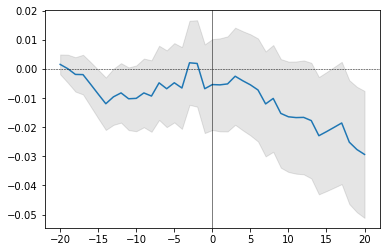

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-20  0.002        0.003     0.002         0.003   0.581    0.561
-19 -0.001        0.003       0.0         0.004   0.019    0.985
-18 -0.002        0.003    -0.002         0.005  -0.411    0.681
-17 -0.000        0.003    -0.002         0.005  -0.370    0.712
-16 -0.003        0.003    -0.005         0.006  -0.887    0.375
-15 -0.003        0.003    -0.009         0.007  -1.330    0.184
-14 -0.003        0.003  -0.012 *         0.007  -1.702    0.089
-13  0.002        0.003     -0.01         0.008  -1.277    0.202
-12  0.001        0.003    -0.008         0.008  -1.035    0.301
-11 -0.002        0.003     -0.01         0.008  -1.221    0.222
-10  0.000        0.003     -0.01         0.009  -1.148    0.251
-9   0.002        0.003    -0.008         0.009  -0.896    0.370
-8  -0.001        0.003    -0.009         0.010  -0.974    0.330
-7   0.005        0.003    -0.005         0.010  -0.482    0.630
-6  -0.002        0.003    -0.007         0.010  -0.662    0.508
-5   0.002        0.003    -0.005         0.011  -0.448    0.654
-4  -0.002        0.003    -0.007         0.011  -0.599    0.549
-3   0.009        0.003     0.002         0.011   0.186    0.852
-2  -0.000        0.003     0.002         0.012   0.161    0.872
-1  -0.009        0.003    -0.007         0.012  -0.573    0.567
0    0.001        0.003    -0.005         0.012  -0.442    0.658
1   -0.000        0.003    -0.005         0.012  -0.440    0.660
2    0.000        0.003    -0.005         0.013  -0.405    0.686
3    0.003        0.003    -0.003         0.013  -0.194    0.847
4   -0.002        0.003    -0.004         0.013  -0.307    0.759
5   -0.001        0.003    -0.005         0.014  -0.404    0.686
6   -0.002        0.003    -0.007         0.014  -0.525    0.600
7   -0.005        0.003    -0.012         0.014  -0.855    0.392
8    0.002        0.003     -0.01         0.014  -0.709    0.478
9   -0.005        0.003    -0.015         0.015  -1.050    0.294
10  -0.001        0.003    -0.016         0.015  -1.112    0.266
11  -0.000        0.003    -0.017         0.015  -1.113    0.266
12   0.000        0.003    -0.017         0.015  -1.091    0.275
13  -0.001        0.003    -0.018         0.015  -1.146    0.252
14  -0.005        0.003    -0.023         0.016  -1.460    0.144
15   0.001        0.003    -0.022         0.016  -1.352    0.176
16   0.001        0.003     -0.02         0.016  -1.242    0.214
17   0.001        0.003    -0.019         0.016  -1.134    0.257
18  -0.007        0.003    -0.025         0.017  -1.517    0.129
19  -0.003        0.003  -0.028 *         0.017  -1.648    0.099
20  -0.002        0.003  -0.029 *         0.017  -1.727    0.084

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.002     0.001     6.377    -1.106 -0.162        -0.013         0.003   
-19  0.000     0.002     2.475    -0.211 -0.154        -0.020         0.001   
-18 -0.002     0.002     5.075    -0.423 -0.231        -0.027        -0.001   
-17 -0.002     0.003     2.783    -0.119 -0.201        -0.033        -0.004   
-16 -0.005     0.004     1.888     0.310 -0.173        -0.047        -0.003   
-15 -0.009     0.006     3.849     0.337 -0.276        -0.046        -0.003   
-14 -0.012     0.008     5.564     0.150 -0.362        -0.059        -0.003   
-13 -0.010     0.007     3.667     0.744 -0.236        -0.061        -0.007   
-12 -0.008     0.008     2.880     0.629 -0.265        -0.068        -0.001   
-11 -0.010     0.009     2.085     0.523 -0.227        -0.064        -0.006   
-10 -0.010     0.009     2.247     0.460 -0.277        -0.060        -0.006   
-9  -0.008     0.010     2.978     0.568 -0.290        -0.065        -0.007   
-8  -0.009     0.011     1.852     0.126 -0.316        -0.064        -0.008   
-7  -0.005     0.012     1.834    -0.073 -0.361        -0.062         0.002   
-6  -0.007     0.014     2.517    -0.267 -0.422        -0.065        -0.006   
-5  -0.005     0.012     1.375     0.079 -0.347        -0.066        -0.004   
-4  -0.007     0.013     1.245    -0.000 -0.397        -0.079        -0.000   
-3   0.002     0.017     4.133     0.664 -0.460        -0.087         0.003   
-2   0.002     0.019     3.513     0.777 -0.424        -0.092         0.008   
-1  -0.007     0.021     2.486     0.235 -0.501        -0.086         0.004   
0   -0.005     0.022     2.430    -0.136 -0.550        -0.080         0.010   
1   -0.005     0.021     1.813     0.122 -0.472        -0.083         0.005   
2   -0.005     0.023     1.383     0.152 -0.443        -0.075         0.009   
3   -0.003     0.023     0.993     0.181 -0.413        -0.077         0.005   
4   -0.004     0.026     1.063     0.257 -0.440        -0.088         0.008   
5   -0.005     0.025     1.085     0.376 -0.459        -0.126         0.001   
6   -0.007     0.026     0.671     0.231 -0.495        -0.103        -0.009   
7   -0.012     0.031     0.849     0.202 -0.507        -0.105        -0.002   
8   -0.010     0.032     1.148     0.246 -0.526        -0.110        -0.009   
9   -0.015     0.032     0.957     0.143 -0.572        -0.099        -0.012   
10  -0.016     0.031     0.689     0.082 -0.540        -0.102        -0.013   
11  -0.017     0.033     0.791     0.091 -0.558        -0.110        -0.012   
12  -0.017     0.036     0.900     0.156 -0.627        -0.126        -0.018   
13  -0.018     0.039     1.020     0.013 -0.664        -0.115        -0.018   
14  -0.023     0.039     1.013    -0.165 -0.650        -0.119        -0.022   
15  -0.022     0.040     1.281    -0.291 -0.688        -0.110        -0.025   
16  -0.020     0.040     1.046    -0.155 -0.656        -0.124        -0.029   
17  -0.019     0.042     1.200    -0.042 -0.664        -0.133        -0.029   
18  -0.025     0.047     1.432     0.039 -0.771        -0.141        -0.030   
19  -0.028     0.048     1.152     0.122 -0.677        -0.155        -0.035   
20  -0.029     0.048     1.072     0.259 -0.670        -0.144        -0.038   

     Quantile 75%    Max  
-20         0.017  0.092  
-19         0.022  0.149  
-18         0.023  0.193  
-17         0.028  0.201  
-16         0.032  0.216  
-15         0.029  0.311  
-14         0.039  0.387  
-13         0.038  0.352  
-12         0.045  0.369  
-11         0.046  0.375  
-10         0.040  0.363  
-9          0.049  0.448  
-8          0.047  0.374  
-7          0.055  0.356  
-6          0.054  0.354  
-5          0.040  0.320  
-4          0.051  0.332  
-3          0.064  0.618  
-2          0.064  0.633  
-1          0.060  0.523  
0           0.072  0.498  
1           0.069  0.507  
2           0.070  0.492  
3           0.079  0.522  
4           

BARC_L


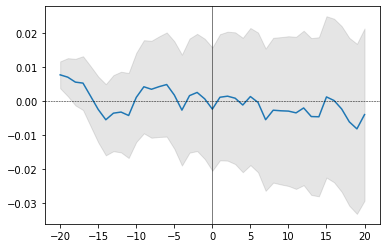

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-20  0.008        0.003  0.008 **         0.003   2.490    0.013
-19 -0.001        0.003     0.007         0.004   1.603    0.109
-18 -0.001        0.003     0.006         0.005   1.037    0.300
-17 -0.000        0.003     0.005         0.006   0.851    0.395
-16 -0.004        0.003     0.001         0.007   0.203    0.839
-15 -0.004        0.003    -0.002         0.008  -0.330    0.741
-14 -0.003        0.003    -0.006         0.008  -0.677    0.498
-13  0.002        0.003    -0.004         0.009  -0.411    0.681
-12  0.000        0.003    -0.003         0.009  -0.353    0.724
-11 -0.001        0.003    -0.004         0.010  -0.438    0.662
-10  0.005        0.003     0.001         0.010   0.102    0.919
-9   0.003        0.003     0.004         0.011   0.390    0.696
-8  -0.001        0.003     0.003         0.011   0.309    0.757
-7   0.001        0.003     0.004         0.011   0.364    0.716
-6   0.001        0.003     0.005         0.012   0.404    0.686
-5  -0.003        0.003     0.002         0.012   0.142    0.887
-4  -0.004        0.003    -0.003         0.013  -0.211    0.833
-3   0.004        0.003     0.002         0.013   0.120    0.905
-2   0.001        0.003     0.002         0.013   0.186    0.852
-1  -0.002        0.003     0.001         0.014   0.044    0.965
0   -0.003        0.003    -0.002         0.014  -0.169    0.865
1    0.003        0.003     0.001         0.014   0.075    0.940
2    0.000        0.003     0.001         0.015   0.095    0.924
3   -0.001        0.003     0.001         0.015   0.053    0.957
4   -0.002        0.003    -0.001         0.015  -0.077    0.939
5    0.002        0.003     0.001         0.016   0.083    0.934
6   -0.002        0.003      -0.0         0.016  -0.027    0.979
7   -0.005        0.003    -0.005         0.016  -0.337    0.736
8    0.003        0.003    -0.003         0.017  -0.163    0.870
9   -0.000        0.003    -0.003         0.017  -0.171    0.864
10  -0.000        0.003    -0.003         0.017  -0.174    0.862
11  -0.001        0.003    -0.003         0.017  -0.200    0.841
12   0.001        0.003    -0.002         0.018  -0.116    0.908
13  -0.003        0.003    -0.005         0.018  -0.255    0.799
14  -0.000        0.003    -0.005         0.018  -0.255    0.799
15   0.006        0.003     0.001         0.018   0.064    0.949
16  -0.001        0.003       0.0         0.019   0.007    0.995
17  -0.002        0.003    -0.002         0.019  -0.125    0.901
18  -0.004        0.003    -0.006         0.019  -0.319    0.750
19  -0.002        0.003    -0.008         0.019  -0.421    0.674
20   0.004        0.003    -0.004         0.020  -0.203    0.839

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.008     0.001    15.187     2.814 -0.067        -0.010         0.004   
-19  0.007     0.002     2.403     1.016 -0.086        -0.014         0.004   
-18  0.006     0.002     2.860     0.871 -0.139        -0.021         0.003   
-17  0.005     0.003     2.014     0.071 -0.205        -0.031         0.006   
-16  0.001     0.004     2.684    -0.019 -0.273        -0.034         0.007   
-15 -0.002     0.007    10.162    -1.351 -0.508        -0.040        -0.001   
-14 -0.006     0.011    25.436    -3.193 -0.823        -0.046        -0.004   
-13 -0.004     0.014    23.033    -3.263 -0.878        -0.041         0.005   
-12 -0.003     0.018    23.798    -3.420 -0.997        -0.048         0.004   
-11 -0.004     0.020    27.790    -3.735 -1.107        -0.054         0.001   
-10  0.001     0.012     2.614     0.124 -0.384        -0.052        -0.002   
-9   0.004     0.015     5.019     0.406 -0.432        -0.052         0.000   
-8   0.003     0.014     3.918    -0.114 -0.443        -0.053        -0.005   
-7   0.004     0.016     3.000     0.075 -0.438        -0.067        -0.001   
-6   0.005     0.017     2.416    -0.098 -0.436        -0.060        -0.006   
-5   0.002     0.018     4.246    -0.625 -0.572        -0.059        -0.001   
-4  -0.003     0.022     4.045    -0.727 -0.651        -0.067        -0.007   
-3   0.002     0.025     6.145    -0.679 -0.776        -0.068        -0.008   
-2   0.002     0.031     6.809    -0.964 -0.900        -0.070        -0.001   
-1   0.001     0.028     4.142    -0.297 -0.698        -0.073        -0.009   
0   -0.002     0.028     4.928    -0.346 -0.753        -0.070        -0.010   
1    0.001     0.031     4.280    -0.412 -0.735        -0.063        -0.008   
2    0.001     0.035     3.986    -0.278 -0.746        -0.070        -0.008   
3    0.001     0.042     4.309    -0.550 -0.811        -0.076        -0.009   
4   -0.001     0.046     4.671    -0.505 -0.937        -0.076        -0.009   
5    0.001     0.037     3.691     0.036 -0.787        -0.084        -0.012   
6   -0.000     0.039     3.261    -0.056 -0.776        -0.092        -0.015   
7   -0.005     0.047     3.548    -0.073 -0.860        -0.092        -0.021   
8   -0.003     0.051     4.949     0.289 -0.899        -0.109        -0.007   
9   -0.003     0.050     4.270    -0.153 -0.951        -0.104        -0.015   
10  -0.003     0.051     5.080    -0.394 -1.030        -0.110        -0.007   
11  -0.003     0.057     5.128    -0.340 -1.042        -0.107        -0.008   
12  -0.002     0.063     5.625    -0.156 -1.082        -0.099        -0.005   
13  -0.005     0.066     5.264    -0.082 -1.061        -0.112        -0.006   
14  -0.005     0.066     5.720    -0.271 -1.067        -0.109        -0.006   
15   0.001     0.064     5.086    -0.409 -1.011        -0.107         0.002   
16   0.000     0.070     5.582    -0.529 -1.041        -0.096        -0.006   
17  -0.002     0.076     6.727    -0.350 -1.138        -0.110        -0.008   
18  -0.006     0.083     6.520     0.021 -1.081        -0.125        -0.014   
19  -0.008     0.083     6.299     0.092 -1.137        -0.153        -0.019   
20  -0.004     0.087     7.149     0.236 -1.195        -0.125        -0.008   

     Quantile 75%    Max  
-20         0.016  0.250  
-19         0.022  0.156  
-18         0.024  0.183  
-17         0.029  0.180  
-16         0.028  0.205  
-15         0.036  0.249  
-14         0.039  0.294  
-13         0.045  0.248  
-12         0.049  0.346  
-11         0.056  0.350  
-10         0.054  0.428  
-9          0.060  0.599  
-8          0.060  0.494  
-7          0.066  0.508  
-6          0.072  0.412  
-5          0.070  0.464  
-4          0.070  0.484  
-3          0.058  0.577  
-2          0.068  0.544  
-1          0.066  0.536  
0           0.071  0.675  
1           0.078  0.649  
2           0.071  0.614  
3           0.079  0.660  
4           

In [68]:
for ticker, event in releases_20_50.items():
    print(ticker)
    event.plot()
    plt.show()
    display(event.results())
    display(event.get_CAR_dist())

In [69]:
#using the event study (formula for each element of the tickers list (event window: +-20 / estimation size: 100)
tickers = ['JPM_N','BAC_N','C_N','WFC_N','GS','MS_N','HSBA_L','BNPP_PA','CAGR_PA','SAN_MC','SOGN_PA','BARC_L']
releases_20_100 = dict()

for ticker in tickers:
    events = [event for event in event_database if event['security_ticker']==ticker]
    
    releases_20_100[ticker] = es.Multiple.from_list(
        events,
        es.Single.FamaFrench_3factor,
        event_window= (-20,+20),
        estimation_size = 100)

2022-05-29 12:34:03,876 P[5368] [MainThread 14260]  5 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:34:04,059 P[5368] [MainThread 14260]  5 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:34:04,220 P[5368] [MainThread 14260]  5 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:34:04,372 P[5368] [MainThread 14260]  5 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:34:04,527 P[5368] [MainThread 14260]  5 events have not been processed due

JPM_N


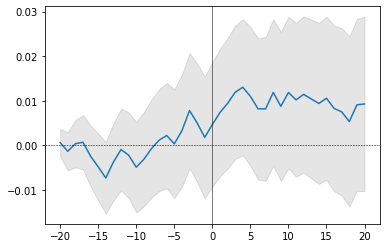

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.001        0.002   0.001         0.002   0.254    0.800
-19 -0.002        0.002  -0.001         0.003  -0.399    0.690
-18  0.002        0.002     0.0         0.004   0.089    0.929
-17  0.000        0.002   0.001         0.005   0.142    0.887
-16 -0.003        0.002  -0.002         0.005  -0.458    0.647
-15 -0.002        0.002  -0.005         0.006  -0.831    0.406
-14 -0.002        0.002  -0.007         0.006  -1.161    0.246
-13  0.004        0.002  -0.004         0.007  -0.557    0.577
-12  0.003        0.002  -0.001         0.007  -0.132    0.895
-11 -0.001        0.002  -0.002         0.008  -0.294    0.769
-10 -0.003        0.002  -0.005         0.008  -0.623    0.534
-9   0.002        0.002  -0.003         0.008  -0.381    0.703
-8   0.002        0.002  -0.001         0.009  -0.085    0.932
-7   0.002        0.002   0.001         0.009   0.129    0.898
-6   0.001        0.002   0.002         0.009   0.239    0.811
-5  -0.002        0.002     0.0         0.010   0.036    0.972
-4   0.003        0.002   0.003         0.010   0.334    0.739
-3   0.005        0.002   0.008         0.010   0.771    0.440
-2  -0.003        0.002   0.005         0.010   0.484    0.629
-1  -0.003        0.002   0.002         0.011   0.167    0.867
0    0.003        0.002   0.005         0.011   0.427    0.669
1    0.003        0.002   0.007         0.011   0.659    0.510
2    0.002        0.002   0.009         0.011   0.823    0.411
3    0.003        0.002   0.012         0.012   1.020    0.308
4    0.001        0.002   0.013         0.012   1.094    0.274
5   -0.002        0.002   0.011         0.012   0.906    0.365
6   -0.003        0.002   0.008         0.012   0.662    0.508
7   -0.000        0.002   0.008         0.013   0.648    0.517
8    0.004        0.002   0.012         0.013   0.925    0.355
9   -0.003        0.002   0.009         0.013   0.670    0.503
10   0.003        0.002   0.012         0.013   0.894    0.372
11  -0.002        0.002    0.01         0.013   0.757    0.449
12   0.001        0.002   0.011         0.014   0.835    0.404
13  -0.001        0.002    0.01         0.014   0.749    0.454
14  -0.001        0.002   0.009         0.014   0.666    0.505
15   0.001        0.002   0.011         0.014   0.739    0.460
16  -0.002        0.002   0.008         0.014   0.571    0.568
17  -0.001        0.002   0.008         0.015   0.511    0.609
18  -0.002        0.002   0.005         0.015   0.359    0.720
19   0.004        0.002   0.009         0.015   0.603    0.547
20   0.000        0.002   0.009         0.015   0.608    0.543

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.001     0.001     5.248    -0.019 -0.114        -0.009         0.000   
-19 -0.001     0.001     6.157     0.134 -0.162        -0.015         0.000   
-18  0.000     0.002     4.906     0.016 -0.170        -0.016         0.001   
-17  0.001     0.002     7.296    -0.417 -0.203        -0.016         0.003   
-16 -0.002     0.003     7.207    -1.197 -0.253        -0.021        -0.001   
-15 -0.005     0.003     6.679    -0.979 -0.317        -0.032         0.001   
-14 -0.007     0.004     5.423    -0.527 -0.321        -0.039        -0.002   
-13 -0.004     0.004     1.751     0.320 -0.205        -0.037        -0.007   
-12 -0.001     0.004     1.194     0.784 -0.138        -0.044        -0.004   
-11 -0.002     0.005     2.599     1.045 -0.149        -0.044        -0.006   
-10 -0.005     0.006     2.276     0.646 -0.250        -0.051        -0.006   
-9  -0.003     0.006     1.958     0.596 -0.236        -0.047        -0.006   
-8  -0.001     0.008     3.090     0.074 -0.379        -0.050        -0.001   
-7   0.001     0.009     3.354     0.143 -0.416        -0.051         0.002   
-6   0.002     0.009     4.036     0.123 -0.426        -0.051        -0.003   
-5   0.000     0.009     3.285     0.148 -0.401        -0.056        -0.004   
-4   0.003     0.009     1.543     0.650 -0.268        -0.057         0.003   
-3   0.008     0.010     3.117     0.933 -0.303        -0.051         0.000   
-2   0.005     0.011     2.538     0.695 -0.286        -0.055         0.004   
-1   0.002     0.011     2.386     0.405 -0.335        -0.063         0.002   
0    0.005     0.011     1.998     0.258 -0.374        -0.054         0.002   
1    0.007     0.012     2.166     0.137 -0.359        -0.051         0.008   
2    0.009     0.011     1.664     0.661 -0.328        -0.056         0.005   
3    0.012     0.014     3.027     0.840 -0.383        -0.055        -0.002   
4    0.013     0.014     2.576     0.821 -0.358        -0.053        -0.002   
5    0.011     0.013     2.521     0.917 -0.304        -0.053        -0.005   
6    0.008     0.014     3.639     0.987 -0.386        -0.053        -0.008   
7    0.008     0.015     2.614     0.727 -0.427        -0.055        -0.006   
8    0.012     0.018     3.801     0.804 -0.495        -0.063         0.008   
9    0.009     0.016     2.709     0.436 -0.486        -0.063         0.005   
10   0.012     0.018     3.684     0.818 -0.497        -0.059        -0.003   
11   0.010     0.021     5.003     0.781 -0.576        -0.061        -0.008   
12   0.011     0.022     4.749     1.008 -0.526        -0.062        -0.003   
13   0.010     0.021     3.148     0.961 -0.434        -0.061        -0.006   
14   0.009     0.023     2.777     0.797 -0.455        -0.065        -0.008   
15   0.011     0.021     2.363     0.806 -0.342        -0.069        -0.005   
16   0.008     0.021     2.822     0.689 -0.448        -0.074        -0.006   
17   0.008     0.025     3.555     0.335 -0.631        -0.068        -0.006   
18   0.005     0.026     2.803     0.308 -0.630        -0.083        -0.003   
19   0.009     0.025     2.192     0.794 -0.421        -0.085        -0.003   
20   0.009     0.026     2.623     0.736 -0.543        -0.086        -0.002   

     Quantile 75%    Max  
-20         0.010  0.119  
-19         0.011  0.159  
-18         0.016  0.170  
-17         0.017  0.199  
-16         0.019  0.171  
-15         0.025  0.175  
-14         0.026  0.224  
-13         0.026  0.185  
-12         0.025  0.208  
-11         0.030  0.264  
-10         0.027  0.277  
-9          0.029  0.278  
-8          0.038  0.270  
-7          0.038  0.310  
-6          0.043  0.315  
-5          0.043  0.315  
-4          0.042  0.316  
-3          0.044  0.428  
-2          0.044  0.414  
-1          0.048  0.371  
0           0.053  0.343  
1           0.059  0.356  
2           0.060  0.354  
3           0.059  0.495  
4           

BAC_N


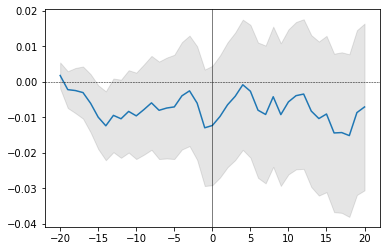

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.002        0.003   0.002         0.003   0.597    0.551
-19 -0.004        0.003  -0.002         0.004  -0.562    0.574
-18 -0.000        0.003  -0.003         0.005  -0.511    0.610
-17 -0.001        0.003  -0.003         0.006  -0.542    0.588
-16 -0.003        0.003  -0.006         0.006  -0.957    0.339
-15 -0.004        0.003   -0.01         0.007  -1.431    0.152
-14 -0.002        0.003  -0.012         0.008  -1.645    0.100
-13  0.003        0.003   -0.01         0.008  -1.176    0.240
-12 -0.001        0.003   -0.01         0.009  -1.220    0.222
-11  0.002        0.003  -0.008         0.009  -0.929    0.353
-10 -0.001        0.003   -0.01         0.009  -1.017    0.309
-9   0.002        0.003  -0.008         0.010  -0.797    0.425
-8   0.002        0.003  -0.006         0.010  -0.582    0.561
-7  -0.002        0.003  -0.008         0.011  -0.756    0.450
-6   0.001        0.003  -0.007         0.011  -0.673    0.501
-5   0.000        0.003  -0.007         0.011  -0.623    0.533
-4   0.003        0.003  -0.004         0.012  -0.340    0.733
-3   0.001        0.003  -0.003         0.012  -0.215    0.830
-2  -0.003        0.003  -0.006         0.012  -0.487    0.626
-1  -0.007        0.003  -0.013         0.013  -1.017    0.309
0    0.001        0.003  -0.012         0.013  -0.944    0.345
1    0.003        0.003   -0.01         0.013  -0.734    0.463
2    0.003        0.003  -0.007         0.014  -0.476    0.634
3    0.002        0.003  -0.004         0.014  -0.296    0.767
4    0.003        0.003  -0.001         0.014  -0.063    0.950
5   -0.002        0.003  -0.003         0.015  -0.187    0.852
6   -0.005        0.003  -0.008         0.015  -0.542    0.588
7   -0.001        0.003  -0.009         0.015  -0.612    0.541
8    0.005        0.003  -0.004         0.015  -0.278    0.781
9   -0.005        0.003  -0.009         0.016  -0.594    0.553
10   0.004        0.003  -0.006         0.016  -0.359    0.719
11   0.002        0.003  -0.004         0.016  -0.245    0.806
12   0.000        0.003  -0.004         0.016  -0.214    0.830
13  -0.005        0.003  -0.008         0.017  -0.498    0.618
14  -0.002        0.003   -0.01         0.017  -0.615    0.538
15   0.001        0.003  -0.009         0.017  -0.532    0.595
16  -0.005        0.003  -0.014         0.017  -0.831    0.406
17   0.000        0.003  -0.014         0.018  -0.814    0.415
18  -0.001        0.003  -0.015         0.018  -0.851    0.395
19   0.006        0.003  -0.009         0.018  -0.483    0.629
20   0.002        0.003  -0.007         0.018  -0.390    0.696

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.002     0.001    16.265     2.579 -0.109        -0.010        -0.001   
-19 -0.002     0.003    25.911     2.759 -0.204        -0.014        -0.002   
-18 -0.003     0.005    26.737     2.236 -0.327        -0.016        -0.005   
-17 -0.003     0.005    31.928     2.119 -0.360        -0.018        -0.000   
-16 -0.006     0.006    16.204    -0.128 -0.433        -0.019        -0.002   
-15 -0.010     0.008    15.786    -1.082 -0.562        -0.029        -0.006   
-14 -0.012     0.011    29.423    -3.368 -0.850        -0.038        -0.007   
-13 -0.010     0.010    11.855    -1.278 -0.547        -0.041        -0.007   
-12 -0.010     0.011    14.777    -1.860 -0.699        -0.042        -0.010   
-11 -0.008     0.012    10.849     0.123 -0.607        -0.050        -0.012   
-10 -0.010     0.015    10.338     0.592 -0.635        -0.053        -0.010   
-9  -0.008     0.016     8.617     1.088 -0.552        -0.056        -0.010   
-8  -0.006     0.016     7.299     1.125 -0.441        -0.052        -0.010   
-7  -0.008     0.019     6.497     0.580 -0.498        -0.053        -0.010   
-6  -0.007     0.016     5.347    -0.061 -0.548        -0.054        -0.005   
-5  -0.007     0.021    11.063    -0.949 -0.832        -0.060        -0.003   
-4  -0.004     0.021     7.306    -0.209 -0.712        -0.053        -0.002   
-3  -0.003     0.027     8.443    -0.496 -0.824        -0.055         0.000   
-2  -0.006     0.029     6.306    -0.081 -0.789        -0.061        -0.003   
-1  -0.013     0.028     4.156     0.125 -0.627        -0.069        -0.007   
0   -0.012     0.025     4.037     0.165 -0.614        -0.067        -0.009   
1   -0.010     0.034     6.345    -0.156 -0.901        -0.063        -0.008   
2   -0.007     0.031     3.807     0.436 -0.603        -0.074        -0.010   
3   -0.004     0.036     5.575     0.522 -0.757        -0.060        -0.006   
4   -0.001     0.041     7.841     1.256 -0.668        -0.071        -0.010   
5   -0.003     0.044     8.830     0.957 -0.714        -0.070        -0.009   
6   -0.008     0.049     9.501     1.047 -0.827        -0.076        -0.010   
7   -0.009     0.050     7.730     0.737 -0.880        -0.075        -0.014   
8   -0.004     0.051     6.883     0.818 -0.913        -0.081        -0.005   
9   -0.009     0.044     6.532     0.583 -0.883        -0.085        -0.009   
10  -0.006     0.046     5.801     0.770 -0.678        -0.084        -0.008   
11  -0.004     0.049     4.953     0.654 -0.796        -0.086        -0.011   
12  -0.004     0.052     6.316     0.743 -0.911        -0.085        -0.015   
13  -0.008     0.056     5.547     0.377 -0.880        -0.085        -0.017   
14  -0.010     0.057     5.841     0.454 -0.886        -0.092        -0.015   
15  -0.009     0.054     6.562     0.510 -0.885        -0.097        -0.006   
16  -0.014     0.058     6.523     0.062 -0.897        -0.094        -0.009   
17  -0.014     0.067     7.433     0.201 -1.013        -0.092        -0.010   
18  -0.015     0.070     7.229     0.400 -1.015        -0.101        -0.012   
19  -0.009     0.065     7.326     1.071 -0.827        -0.109        -0.009   
20  -0.007     0.067     7.193     0.916 -0.930        -0.104        -0.018   

     Quantile 75%    Max  
-20         0.008  0.220  
-19         0.009  0.414  
-18         0.012  0.499  
-17         0.012  0.542  
-16         0.016  0.457  
-15         0.018  0.426  
-14         0.015  0.356  
-13         0.020  0.381  
-12         0.021  0.329  
-11         0.022  0.491  
-10         0.020  0.538  
-9          0.022  0.599  
-8          0.028  0.615  
-7          0.029  0.658  
-6          0.031  0.445  
-5          0.034  0.517  
-4          0.043  0.543  
-3          0.040  0.588  
-2          0.042  0.605  
-1          0.036  0.583  
0           0.038  0.555  
1           0.042  0.609  
2           0.049  0.644  
3           0.050  0.870  
4           

C_N


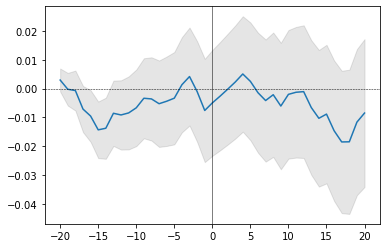

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-20  0.003        0.003     0.003         0.003   0.939    0.348
-19 -0.003        0.003      -0.0         0.004  -0.057    0.955
-18 -0.000        0.003    -0.001         0.005  -0.132    0.895
-17 -0.006        0.003    -0.007         0.006  -1.141    0.254
-16 -0.002        0.003     -0.01         0.007  -1.368    0.171
-15 -0.005        0.003  -0.014 *         0.008  -1.873    0.061
-14  0.001        0.003  -0.014 *         0.008  -1.667    0.096
-13  0.005        0.003    -0.009         0.009  -0.972    0.331
-12 -0.001        0.003    -0.009         0.009  -0.978    0.328
-11  0.001        0.003    -0.008         0.010  -0.857    0.392
-10  0.002        0.003    -0.007         0.010  -0.646    0.518
-9   0.003        0.003    -0.003         0.011  -0.312    0.755
-8  -0.000        0.003    -0.004         0.011  -0.320    0.749
-7  -0.002        0.003    -0.005         0.012  -0.451    0.652
-6   0.001        0.003    -0.004         0.012  -0.364    0.716
-5   0.001        0.003    -0.003         0.012  -0.268    0.789
-4   0.005        0.003     0.001         0.013   0.102    0.919
-3   0.003        0.003     0.004         0.013   0.313    0.754
-2  -0.005        0.003    -0.001         0.014  -0.078    0.938
-1  -0.007        0.003    -0.008         0.014  -0.545    0.586
0    0.003        0.003    -0.005         0.014  -0.348    0.728
1    0.002        0.003    -0.003         0.015  -0.184    0.854
2    0.002        0.003      -0.0         0.015  -0.018    0.985
3    0.002        0.003     0.002         0.015   0.145    0.885
4    0.003        0.003     0.005         0.016   0.323    0.747
5   -0.003        0.003     0.002         0.016   0.155    0.877
6   -0.004        0.003    -0.001         0.016  -0.090    0.928
7   -0.003        0.003    -0.004         0.017  -0.252    0.801
8    0.002        0.003    -0.002         0.017  -0.128    0.898
9   -0.004        0.003    -0.006         0.017  -0.355    0.723
10   0.004        0.003    -0.002         0.017  -0.116    0.907
11   0.001        0.003    -0.001         0.018  -0.073    0.941
12   0.000        0.003    -0.001         0.018  -0.060    0.952
13  -0.006        0.003    -0.007         0.018  -0.362    0.717
14  -0.004        0.003     -0.01         0.018  -0.559    0.576
15   0.001        0.003    -0.009         0.019  -0.473    0.636
16  -0.006        0.003    -0.015         0.019  -0.770    0.441
17  -0.004        0.003    -0.019         0.019  -0.962    0.336
18   0.000        0.003    -0.018         0.020  -0.947    0.344
19   0.007        0.003    -0.012         0.020  -0.590    0.555
20   0.003        0.003    -0.009         0.020  -0.425    0.671

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.003     0.001     6.335     0.681 -0.109        -0.007         0.001   
-19 -0.000     0.003    10.969     0.976 -0.217        -0.015        -0.002   
-18 -0.001     0.003     9.086     0.438 -0.284        -0.022        -0.005   
-17 -0.007     0.006    18.369    -2.362 -0.501        -0.022        -0.003   
-16 -0.010     0.008    14.120    -2.413 -0.521        -0.028        -0.005   
-15 -0.014     0.011    16.823    -2.614 -0.639        -0.034        -0.002   
-14 -0.014     0.011    23.225    -2.830 -0.789        -0.041        -0.004   
-13 -0.009     0.008     8.312    -0.684 -0.472        -0.042        -0.001   
-12 -0.009     0.012    14.126    -2.066 -0.622        -0.049        -0.004   
-11 -0.008     0.014    19.541    -2.329 -0.818        -0.050        -0.003   
-10 -0.007     0.017    15.129    -0.607 -0.794        -0.048        -0.011   
-9  -0.003     0.018    16.874    -0.698 -0.859        -0.051        -0.007   
-8  -0.004     0.020    19.221    -0.918 -0.947        -0.049        -0.004   
-7  -0.005     0.021    15.261    -1.030 -0.929        -0.053        -0.002   
-6  -0.004     0.021    13.790    -1.580 -0.910        -0.051        -0.003   
-5  -0.003     0.020     9.054    -0.383 -0.727        -0.051        -0.010   
-4   0.001     0.019     5.291     0.572 -0.474        -0.054        -0.010   
-3   0.004     0.021     6.214     0.635 -0.569        -0.058        -0.002   
-2  -0.001     0.022     5.345     0.778 -0.453        -0.059        -0.003   
-1  -0.008     0.022     4.819     0.276 -0.527        -0.072        -0.005   
0   -0.005     0.019     4.994     0.111 -0.608        -0.058        -0.004   
1   -0.003     0.024     7.310    -0.120 -0.794        -0.072        -0.004   
2   -0.000     0.021     4.088     0.804 -0.491        -0.071        -0.005   
3    0.002     0.025     5.200     0.663 -0.638        -0.077        -0.004   
4    0.005     0.027     8.652     1.648 -0.523        -0.066        -0.007   
5    0.002     0.029     7.950     1.325 -0.559        -0.066        -0.006   
6   -0.001     0.029     9.736     1.576 -0.493        -0.072        -0.008   
7   -0.004     0.031     7.695     1.243 -0.603        -0.069        -0.013   
8   -0.002     0.034     7.815     0.734 -0.819        -0.068        -0.009   
9   -0.006     0.031     6.469     0.614 -0.721        -0.069        -0.011   
10  -0.002     0.030     6.334     1.106 -0.500        -0.073        -0.012   
11  -0.001     0.033     5.188     0.771 -0.618        -0.074        -0.012   
12  -0.001     0.035     5.796     0.916 -0.602        -0.078        -0.009   
13  -0.007     0.040     7.438     0.137 -0.927        -0.085        -0.009   
14  -0.010     0.043     9.864    -0.492 -1.126        -0.081        -0.006   
15  -0.009     0.044     9.683    -0.452 -1.101        -0.097        -0.009   
16  -0.015     0.050    10.006    -1.011 -1.162        -0.091        -0.009   
17  -0.019     0.060    11.537    -1.515 -1.274        -0.081        -0.012   
18  -0.018     0.067    11.598    -1.488 -1.446        -0.099        -0.014   
19  -0.012     0.057     8.288    -0.395 -1.211        -0.101        -0.016   
20  -0.009     0.055     5.537     0.202 -0.847        -0.097        -0.023   

     Quantile 75%    Max  
-20         0.010  0.144  
-19         0.010  0.275  
-18         0.012  0.287  
-17         0.017  0.327  
-16         0.018  0.300  
-15         0.023  0.302  
-14         0.023  0.350  
-13         0.022  0.363  
-12         0.031  0.343  
-11         0.032  0.357  
-10         0.030  0.641  
-9          0.029  0.675  
-8          0.036  0.722  
-7          0.035  0.660  
-6          0.039  0.509  
-5          0.036  0.577  
-4          0.046  0.593  
-3          0.049  0.648  
-2          0.050  0.645  
-1          0.042  0.550  
0           0.047  0.513  
1           0.046  0.640  
2           0.050  0.618  
3           0.057  0.710  
4           

WFC_N


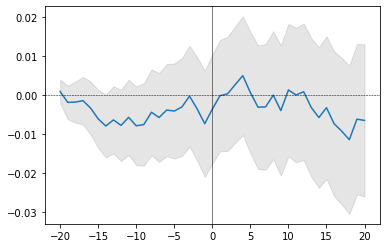

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.001        0.002   0.001         0.002   0.406    0.685
-19 -0.003        0.002  -0.002         0.003  -0.539    0.590
-18  0.000        0.002  -0.002         0.004  -0.420    0.675
-17  0.000        0.002  -0.001         0.005  -0.288    0.774
-16 -0.002        0.002  -0.003         0.005  -0.616    0.538
-15 -0.003        0.002  -0.006         0.006  -1.038    0.299
-14 -0.002        0.002  -0.008         0.006  -1.251    0.211
-13  0.002        0.002  -0.006         0.007  -0.938    0.348
-12 -0.001        0.002  -0.008         0.007  -1.080    0.280
-11  0.002        0.002  -0.006         0.008  -0.751    0.453
-10 -0.002        0.002  -0.008         0.008  -0.992    0.321
-9   0.000        0.002  -0.007         0.008  -0.908    0.364
-8   0.003        0.002  -0.004         0.009  -0.507    0.612
-7  -0.001        0.002  -0.006         0.009  -0.639    0.523
-6   0.002        0.002  -0.004         0.009  -0.410    0.682
-5  -0.000        0.002  -0.004         0.009  -0.424    0.672
-4   0.001        0.002  -0.003         0.010  -0.305    0.760
-3   0.003        0.002    -0.0         0.010  -0.021    0.983
-2  -0.003        0.002  -0.003         0.010  -0.336    0.737
-1  -0.004        0.002  -0.007         0.011  -0.685    0.494
0    0.004        0.002  -0.004         0.011  -0.324    0.746
1    0.003        0.002    -0.0         0.011  -0.009    0.992
2    0.000        0.002     0.0         0.011   0.033    0.973
3    0.002        0.002   0.003         0.012   0.235    0.814
4    0.002        0.002   0.005         0.012   0.424    0.672
5   -0.004        0.002   0.001         0.012   0.058    0.953
6   -0.004        0.002  -0.003         0.012  -0.246    0.805
7    0.000        0.002  -0.003         0.013  -0.236    0.813
8    0.003        0.002     0.0         0.013   0.004    0.997
9   -0.004        0.002  -0.004         0.013  -0.300    0.764
10   0.005        0.002   0.001         0.013   0.103    0.918
11  -0.001        0.002     0.0         0.013   0.006    0.995
12   0.001        0.002   0.001         0.014   0.067    0.947
13  -0.004        0.002  -0.003         0.014  -0.225    0.822
14  -0.003        0.002  -0.006         0.014  -0.405    0.685
15   0.003        0.002  -0.003         0.014  -0.222    0.824
16  -0.004        0.002  -0.007         0.014  -0.503    0.615
17  -0.002        0.002  -0.009         0.015  -0.627    0.531
18  -0.002        0.002  -0.011         0.015  -0.766    0.444
19   0.005        0.002  -0.006         0.015  -0.407    0.684
20  -0.000        0.002  -0.006         0.015  -0.423    0.673

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.001     0.001    11.749     0.857 -0.132        -0.008         0.001   
-19 -0.002     0.002    30.975     2.710 -0.184        -0.011        -0.001   
-18 -0.002     0.002    18.649     0.372 -0.272        -0.014        -0.002   
-17 -0.001     0.003    30.708     0.988 -0.367        -0.015         0.001   
-16 -0.003     0.004    17.541    -0.004 -0.345        -0.018        -0.002   
-15 -0.006     0.004    11.173     0.302 -0.309        -0.024        -0.002   
-14 -0.008     0.005    21.911    -2.086 -0.539        -0.028        -0.006   
-13 -0.006     0.005    11.739    -0.264 -0.378        -0.030        -0.007   
-12 -0.008     0.006    10.056    -0.839 -0.427        -0.031        -0.003   
-11 -0.006     0.007    12.607     0.379 -0.425        -0.033        -0.001   
-10 -0.008     0.007     9.802    -0.518 -0.455        -0.033        -0.004   
-9  -0.007     0.008    10.407    -0.500 -0.450        -0.032        -0.001   
-8  -0.004     0.009    17.727    -1.122 -0.614        -0.029        -0.002   
-7  -0.006     0.010    11.534    -0.682 -0.559        -0.033         0.001   
-6  -0.004     0.009     9.529    -0.893 -0.500        -0.040         0.001   
-5  -0.004     0.010    19.490    -1.862 -0.720        -0.042        -0.000   
-4  -0.003     0.009    10.578    -0.574 -0.566        -0.041         0.003   
-3  -0.000     0.011    12.360    -0.268 -0.610        -0.036         0.002   
-2  -0.003     0.013    11.107     0.014 -0.609        -0.042        -0.003   
-1  -0.007     0.012    11.572    -0.669 -0.643        -0.045         0.002   
0   -0.004     0.012    10.144    -0.740 -0.604        -0.043         0.004   
1   -0.000     0.012    10.749    -0.590 -0.622        -0.035         0.007   
2    0.000     0.012     7.175     0.119 -0.470        -0.036         0.004   
3    0.003     0.015    10.209     0.909 -0.516        -0.044         0.007   
4    0.005     0.018    15.679     1.647 -0.516        -0.045         0.006   
5    0.001     0.018    12.533     0.671 -0.550        -0.041         0.004   
6   -0.003     0.021    16.543     1.362 -0.566        -0.046         0.002   
7   -0.003     0.021    14.661     0.883 -0.645        -0.047         0.001   
8    0.000     0.022    13.747     0.770 -0.737        -0.047         0.005   
9   -0.004     0.020    13.523     0.442 -0.721        -0.043        -0.002   
10   0.001     0.020    14.053     1.139 -0.552        -0.042         0.003   
11   0.000     0.019    11.359     1.072 -0.515        -0.046         0.001   
12   0.001     0.021    13.833     1.487 -0.533        -0.055         0.004   
13  -0.003     0.023    11.263     0.422 -0.605        -0.057         0.001   
14  -0.006     0.024    11.999    -0.064 -0.720        -0.061         0.002   
15  -0.003     0.024    13.974    -0.207 -0.765        -0.050         0.010   
16  -0.007     0.027    13.409    -0.907 -0.843        -0.051         0.008   
17  -0.009     0.032    14.961    -1.199 -0.972        -0.056         0.006   
18  -0.011     0.032    12.264    -1.152 -0.915        -0.062         0.003   
19  -0.006     0.029    10.467    -0.182 -0.756        -0.064         0.007   
20  -0.006     0.031     9.099    -0.002 -0.709        -0.067         0.003   

     Quantile 75%    Max  
-20         0.010  0.166  
-19         0.008  0.343  
-18         0.011  0.280  
-17         0.012  0.416  
-16         0.013  0.353  
-15         0.014  0.335  
-14         0.016  0.301  
-13         0.015  0.361  
-12         0.016  0.329  
-11         0.021  0.408  
-10         0.018  0.353  
-9          0.022  0.402  
-8          0.023  0.413  
-7          0.030  0.467  
-6          0.029  0.373  
-5          0.034  0.412  
-4          0.030  0.380  
-3          0.026  0.487  
-2          0.025  0.567  
-1          0.028  0.504  
0           0.033  0.472  
1           0.034  0.522  
2           0.044  0.523  
3           0.038  0.689  
4           

GS


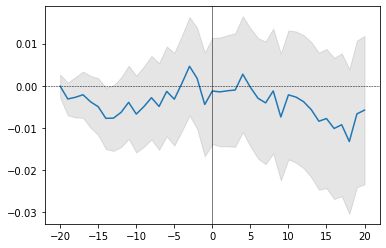

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20 -0.000        0.002    -0.0         0.002  -0.050    0.960
-19 -0.003        0.002  -0.003         0.003  -1.035    0.300
-18  0.000        0.002  -0.003         0.004  -0.738    0.461
-17  0.001        0.002  -0.002         0.004  -0.498    0.618
-16 -0.002        0.002  -0.004         0.005  -0.795    0.427
-15 -0.001        0.002  -0.005         0.005  -0.947    0.344
-14 -0.003        0.002  -0.008         0.006  -1.362    0.173
-13  0.000        0.002  -0.008         0.006  -1.268    0.205
-12  0.001        0.002  -0.006         0.006  -0.982    0.326
-11  0.002        0.002  -0.004         0.007  -0.580    0.562
-10 -0.003        0.002  -0.007         0.007  -0.945    0.345
-9   0.002        0.002  -0.005         0.007  -0.668    0.504
-8   0.002        0.002  -0.003         0.008  -0.368    0.713
-7  -0.002        0.002  -0.005         0.008  -0.612    0.540
-6   0.004        0.002  -0.001         0.008  -0.162    0.872
-5  -0.002        0.002  -0.003         0.009  -0.373    0.709
-4   0.004        0.002   0.001         0.009   0.065    0.948
-3   0.004        0.002   0.005         0.009   0.506    0.613
-2  -0.003        0.002   0.002         0.009   0.187    0.852
-1  -0.006        0.002  -0.004         0.010  -0.464    0.643
0    0.003        0.002  -0.001         0.010  -0.127    0.899
1   -0.000        0.002  -0.001         0.010  -0.145    0.885
2    0.000        0.002  -0.001         0.010  -0.116    0.908
3    0.000        0.002  -0.001         0.011  -0.097    0.923
4    0.004        0.002   0.003         0.011   0.255    0.799
5   -0.003        0.002    -0.0         0.011  -0.034    0.973
6   -0.003        0.002  -0.003         0.011  -0.267    0.790
7   -0.001        0.002  -0.004         0.011  -0.358    0.720
8    0.003        0.002  -0.001         0.012  -0.107    0.915
9   -0.006        0.002  -0.007         0.012  -0.631    0.528
10   0.005        0.002  -0.002         0.012  -0.181    0.856
11  -0.001        0.002  -0.003         0.012  -0.222    0.824
12  -0.001        0.002  -0.004         0.012  -0.308    0.758
13  -0.002        0.002  -0.006         0.013  -0.454    0.650
14  -0.003        0.002  -0.008         0.013  -0.663    0.507
15   0.001        0.002  -0.008         0.013  -0.605    0.545
16  -0.002        0.002   -0.01         0.013  -0.777    0.437
17   0.001        0.002  -0.009         0.013  -0.700    0.484
18  -0.004        0.002  -0.013         0.013  -0.988    0.323
19   0.007        0.002  -0.007         0.014  -0.492    0.623
20   0.001        0.002  -0.006         0.014  -0.421    0.674

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20 -0.000     0.001     4.214    -0.485 -0.107        -0.011         0.000   
-19 -0.003     0.001     2.873    -0.300 -0.122        -0.016        -0.001   
-18 -0.003     0.001     2.821     0.090 -0.114        -0.017        -0.002   
-17 -0.002     0.002     3.407    -0.455 -0.176        -0.021        -0.002   
-16 -0.004     0.003     3.225    -0.518 -0.211        -0.024        -0.004   
-15 -0.005     0.003     2.500    -0.228 -0.237        -0.030        -0.003   
-14 -0.008     0.004     8.541    -1.651 -0.376        -0.038        -0.003   
-13 -0.008     0.005    12.602    -1.960 -0.450        -0.038        -0.004   
-12 -0.006     0.005     6.585    -1.140 -0.399        -0.046        -0.001   
-11 -0.004     0.005     3.659     0.114 -0.319        -0.045        -0.004   
-10 -0.007     0.006     2.651     0.113 -0.289        -0.048        -0.004   
-9  -0.005     0.006     1.946     0.279 -0.243        -0.049        -0.001   
-8  -0.003     0.007     3.125    -0.214 -0.383        -0.046        -0.008   
-7  -0.005     0.008     4.595    -0.623 -0.462        -0.055        -0.004   
-6  -0.001     0.008     1.711    -0.174 -0.316        -0.056         0.004   
-5  -0.003     0.009     1.404    -0.361 -0.325        -0.048        -0.001   
-4   0.001     0.009     1.012    -0.032 -0.295        -0.051         0.000   
-3   0.005     0.010     2.157     0.346 -0.264        -0.047         0.005   
-2   0.002     0.012     1.679     0.185 -0.287        -0.055         0.008   
-1  -0.004     0.013     1.330    -0.080 -0.357        -0.065         0.005   
0   -0.001     0.014     1.267    -0.270 -0.401        -0.064         0.012   
1   -0.001     0.015     1.041    -0.152 -0.409        -0.067         0.005   
2   -0.001     0.017     2.084    -0.419 -0.517        -0.065         0.002   
3   -0.001     0.018     3.850    -0.615 -0.662        -0.068         0.001   
4    0.003     0.018     1.080     0.222 -0.368        -0.069         0.004   
5   -0.000     0.017     0.702     0.257 -0.317        -0.077        -0.004   
6   -0.003     0.019     1.070     0.081 -0.397        -0.087         0.001   
7   -0.004     0.021     0.931     0.072 -0.437        -0.092        -0.004   
8   -0.001     0.022     1.310    -0.011 -0.499        -0.091        -0.001   
9   -0.007     0.025     2.373    -0.450 -0.656        -0.099         0.001   
10  -0.002     0.023     0.981     0.217 -0.506        -0.094        -0.001   
11  -0.003     0.025     1.805    -0.014 -0.634        -0.098        -0.000   
12  -0.004     0.026     1.382     0.156 -0.550        -0.102         0.001   
13  -0.006     0.028     1.893     0.055 -0.625        -0.104        -0.005   
14  -0.008     0.029     2.463    -0.245 -0.688        -0.103        -0.007   
15  -0.008     0.029     2.415    -0.193 -0.692        -0.089        -0.007   
16  -0.010     0.030     3.437    -0.503 -0.820        -0.087        -0.004   
17  -0.009     0.034     4.148    -0.638 -0.894        -0.091        -0.002   
18  -0.013     0.034     3.223    -0.628 -0.833        -0.105         0.003   
19  -0.007     0.032     1.498    -0.006 -0.590        -0.112         0.007   
20  -0.006     0.032     1.292     0.068 -0.548        -0.115         0.002   

     Quantile 75%    Max  
-20         0.010  0.072  
-19         0.010  0.098  
-18         0.016  0.126  
-17         0.018  0.143  
-16         0.020  0.161  
-15         0.022  0.184  
-14         0.024  0.169  
-13         0.025  0.229  
-12         0.032  0.203  
-11         0.033  0.259  
-10         0.030  0.247  
-9          0.038  0.268  
-8          0.047  0.269  
-7          0.047  0.257  
-6          0.052  0.270  
-5          0.053  0.241  
-4          0.059  0.304  
-3          0.059  0.423  
-2          0.066  0.418  
-1          0.065  0.353  
0           0.066  0.349  
1           0.069  0.329  
2           0.068  0.353  
3           0.065  0.376  
4           

MS_N


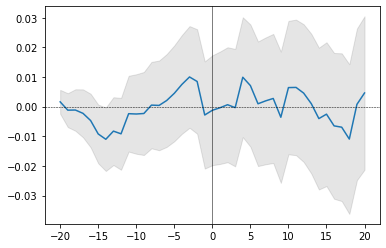

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.002        0.003   0.002         0.003   0.512    0.609
-19 -0.003        0.003  -0.001         0.004  -0.266    0.791
-18  0.000        0.003  -0.001         0.005  -0.209    0.835
-17 -0.001        0.003  -0.002         0.006  -0.359    0.720
-16 -0.002        0.003  -0.005         0.007  -0.664    0.507
-15 -0.005        0.003  -0.009         0.008  -1.192    0.233
-14 -0.002        0.003  -0.011         0.008  -1.319    0.187
-13  0.003        0.003  -0.008         0.009  -0.926    0.355
-12 -0.001        0.003  -0.009         0.009  -0.969    0.333
-11  0.007        0.003  -0.002         0.010  -0.238    0.812
-10 -0.000        0.003  -0.002         0.010  -0.237    0.813
-9   0.000        0.003  -0.002         0.011  -0.212    0.832
-8   0.003        0.003   0.001         0.011   0.045    0.964
-7  -0.000        0.003     0.0         0.012   0.035    0.972
-6   0.002        0.003   0.002         0.012   0.170    0.865
-5   0.002        0.003   0.004         0.013   0.356    0.722
-4   0.003        0.003   0.008         0.013   0.577    0.564
-3   0.003        0.003    0.01         0.013   0.748    0.454
-2  -0.002        0.003   0.008         0.014   0.617    0.537
-1  -0.011        0.003  -0.003         0.014  -0.200    0.842
0    0.002        0.003  -0.001         0.014  -0.085    0.932
1    0.001        0.003    -0.0         0.015  -0.026    0.979
2    0.001        0.003   0.001         0.015   0.043    0.966
3   -0.001        0.003    -0.0         0.015  -0.022    0.983
4    0.010        0.003    0.01         0.016   0.629    0.529
5   -0.003        0.003   0.007         0.016   0.441    0.659
6   -0.006        0.003   0.001         0.016   0.059    0.953
7    0.001        0.003   0.002         0.017   0.117    0.907
8    0.001        0.003   0.003         0.017   0.163    0.871
9   -0.006        0.003  -0.004         0.017  -0.207    0.836
10   0.010        0.003   0.006         0.018   0.366    0.714
11   0.000        0.003   0.006         0.018   0.363    0.716
12  -0.002        0.003   0.005         0.018   0.252    0.801
13  -0.004        0.003   0.001         0.018   0.055    0.956
14  -0.005        0.003  -0.004         0.019  -0.216    0.829
15   0.001        0.003  -0.003         0.019  -0.134    0.893
16  -0.004        0.003  -0.006         0.019  -0.338    0.735
17  -0.000        0.003  -0.007         0.019  -0.357    0.721
18  -0.004        0.003  -0.011         0.020  -0.555    0.579
19   0.012        0.003   0.001         0.020   0.039    0.969
20   0.004        0.003   0.005         0.020   0.228    0.820

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.002     0.001     8.751     1.059 -0.140        -0.011        -0.001   
-19 -0.001     0.002     7.752     1.144 -0.157        -0.020        -0.003   
-18 -0.001     0.003    10.187     1.066 -0.197        -0.018        -0.003   
-17 -0.002     0.003     3.845     0.374 -0.194        -0.020        -0.000   
-16 -0.005     0.004     5.960     0.141 -0.270        -0.030        -0.001   
-15 -0.009     0.006     7.394    -0.541 -0.383        -0.031        -0.006   
-14 -0.011     0.009    15.227    -1.828 -0.628        -0.043        -0.006   
-13 -0.008     0.010    14.913    -2.230 -0.601        -0.047        -0.004   
-12 -0.009     0.011    20.207    -2.725 -0.771        -0.050        -0.004   
-11 -0.002     0.008     4.193     0.019 -0.403        -0.049        -0.000   
-10 -0.002     0.010     4.747     0.647 -0.376        -0.061         0.001   
-9  -0.002     0.011     5.979    -0.332 -0.489        -0.047         0.007   
-8   0.001     0.014     7.813    -0.764 -0.639        -0.050         0.001   
-7   0.000     0.016     6.897    -0.731 -0.627        -0.054         0.004   
-6   0.002     0.016     7.340    -0.506 -0.641        -0.054         0.004   
-5   0.004     0.015     5.307    -0.309 -0.556        -0.043         0.009   
-4   0.008     0.015     5.122    -0.078 -0.518        -0.045         0.016   
-3   0.010     0.019     9.034     0.322 -0.593        -0.042         0.009   
-2   0.008     0.019     7.535     0.548 -0.562        -0.054         0.004   
-1  -0.003     0.020     5.534    -0.038 -0.600        -0.065        -0.004   
0   -0.001     0.024     8.865    -1.360 -0.846        -0.055         0.004   
1   -0.000     0.027     8.191    -1.169 -0.883        -0.058         0.005   
2    0.001     0.032    13.796    -1.904 -1.157        -0.068         0.015   
3   -0.000     0.037    20.347    -2.695 -1.391        -0.066         0.011   
4    0.010     0.024     3.011     0.202 -0.547        -0.072         0.016   
5    0.007     0.023     3.667     0.335 -0.584        -0.078         0.015   
6    0.001     0.028     5.090    -0.705 -0.831        -0.077         0.014   
7    0.002     0.030     5.313    -0.486 -0.864        -0.076         0.015   
8    0.003     0.036     9.599    -1.237 -1.131        -0.084         0.017   
9   -0.004     0.042    15.163    -2.094 -1.392        -0.091         0.008   
10   0.006     0.028     2.178     0.419 -0.445        -0.083         0.011   
11   0.006     0.030     2.417     0.572 -0.418        -0.086         0.005   
12   0.005     0.031     1.897     0.121 -0.486        -0.082         0.009   
13   0.001     0.033     2.480     0.176 -0.584        -0.085         0.003   
14  -0.004     0.035     3.447    -0.305 -0.773        -0.093        -0.002   
15  -0.003     0.035     3.433    -0.127 -0.680        -0.093        -0.002   
16  -0.006     0.035     3.584    -0.284 -0.725        -0.088        -0.009   
17  -0.007     0.040     5.142    -0.795 -1.001        -0.086        -0.009   
18  -0.011     0.044     9.014    -1.355 -1.257        -0.104         0.003   
19   0.001     0.033     1.497     0.095 -0.538        -0.097         0.003   
20   0.005     0.035     2.517    -0.168 -0.722        -0.097         0.008   

     Quantile 75%    Max  
-20         0.012  0.184  
-19         0.014  0.216  
-18         0.017  0.293  
-17         0.016  0.187  
-16         0.023  0.297  
-15         0.026  0.315  
-14         0.026  0.384  
-13         0.029  0.317  
-12         0.032  0.326  
-11         0.035  0.306  
-10         0.036  0.455  
-9          0.044  0.463  
-8          0.058  0.485  
-7          0.059  0.524  
-6          0.065  0.551  
-5          0.061  0.499  
-4          0.060  0.545  
-3          0.065  0.763  
-2          0.063  0.748  
-1          0.070  0.643  
0           0.071  0.531  
1           0.065  0.610  
2           0.071  0.636  
3           0.072  0.614  
4           

HSBA_L


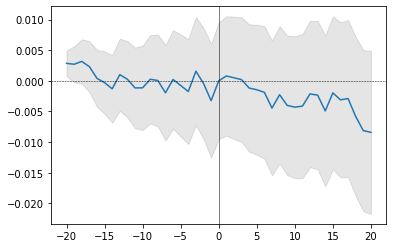

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-20  0.003        0.002  0.003 *         0.002   1.755    0.079
-19 -0.000        0.002    0.003         0.002   1.176    0.240
-18  0.000        0.002    0.003         0.003   1.127    0.260
-17 -0.001        0.002    0.002         0.003   0.711    0.477
-16 -0.002        0.002      0.0         0.004   0.110    0.913
-15 -0.001        0.002     -0.0         0.004  -0.077    0.939
-14 -0.001        0.002   -0.001         0.004  -0.305    0.760
-13  0.002        0.002    0.001         0.005   0.219    0.827
-12 -0.001        0.002      0.0         0.005   0.051    0.959
-11 -0.001        0.002   -0.001         0.005  -0.228    0.820
-10  0.000        0.002   -0.001         0.005  -0.214    0.831
-9   0.001        0.002      0.0         0.006   0.043    0.965
-8  -0.000        0.002      0.0         0.006   0.008    0.994
-7  -0.002        0.002   -0.002         0.006  -0.324    0.746
-6   0.002        0.002      0.0         0.006   0.034    0.973
-5  -0.001        0.002   -0.001         0.006  -0.117    0.907
-4  -0.001        0.002   -0.002         0.007  -0.262    0.793
-3   0.003        0.002    0.002         0.007   0.228    0.820
-2  -0.002        0.002     -0.0         0.007  -0.061    0.951
-1  -0.003        0.002   -0.003         0.007  -0.447    0.655
0    0.003        0.002     -0.0         0.007  -0.001    0.999
1    0.001        0.002    0.001         0.008   0.103    0.918
2   -0.000        0.002      0.0         0.008   0.063    0.950
3   -0.000        0.002      0.0         0.008   0.023    0.981
4   -0.001        0.002   -0.001         0.008  -0.146    0.884
5   -0.000        0.002   -0.001         0.008  -0.177    0.860
6   -0.000        0.002   -0.002         0.008  -0.225    0.822
7   -0.003        0.002   -0.004         0.009  -0.519    0.604
8    0.002        0.002   -0.002         0.009  -0.260    0.795
9   -0.002        0.002   -0.004         0.009  -0.452    0.651
10  -0.000        0.002   -0.004         0.009  -0.476    0.634
11   0.000        0.002   -0.004         0.009  -0.451    0.652
12   0.002        0.002   -0.002         0.009  -0.230    0.818
13  -0.000        0.002   -0.002         0.009  -0.248    0.804
14  -0.003        0.002   -0.005         0.010  -0.513    0.608
15   0.003        0.002   -0.002         0.010  -0.203    0.839
16  -0.001        0.002   -0.003         0.010  -0.315    0.753
17   0.000        0.002   -0.003         0.010  -0.290    0.772
18  -0.003        0.002   -0.006         0.010  -0.575    0.566
19  -0.002        0.002   -0.008         0.010  -0.793    0.428
20  -0.000        0.002   -0.008         0.010  -0.810    0.418

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.003     0.000     7.911     0.883 -0.071        -0.006         0.001   
-19  0.003     0.001    11.453     1.748 -0.070        -0.009         0.001   
-18  0.003     0.001    12.843     2.108 -0.058        -0.012         0.003   
-17  0.002     0.001    11.689     1.960 -0.106        -0.021         0.001   
-16  0.000     0.002     8.605     1.333 -0.170        -0.021        -0.002   
-15 -0.000     0.003     5.839     0.535 -0.185        -0.023        -0.002   
-14 -0.001     0.003    10.605    -0.801 -0.325        -0.027        -0.000   
-13  0.001     0.003     6.167    -0.037 -0.256        -0.023         0.002   
-12  0.000     0.003     4.834     0.087 -0.239        -0.024         0.000   
-11 -0.001     0.004     8.408     0.653 -0.260        -0.032        -0.003   
-10 -0.001     0.004    10.301     1.443 -0.237        -0.033        -0.003   
-9   0.000     0.005     9.373     1.531 -0.214        -0.031        -0.004   
-8   0.000     0.005    10.423     1.520 -0.273        -0.037        -0.003   
-7  -0.002     0.005    10.091     1.150 -0.318        -0.039        -0.004   
-6   0.000     0.006     7.455     0.224 -0.368        -0.036         0.001   
-5  -0.001     0.006     5.397     0.799 -0.241        -0.040        -0.000   
-4  -0.002     0.006     6.058     0.933 -0.272        -0.034        -0.002   
-3   0.002     0.006     5.959     1.338 -0.226        -0.037        -0.002   
-2  -0.000     0.008     6.241     1.059 -0.309        -0.046         0.002   
-1  -0.003     0.008     6.496     0.527 -0.380        -0.048        -0.004   
0   -0.000     0.007     5.521     0.507 -0.327        -0.041        -0.000   
1    0.001     0.008     7.294     0.411 -0.426        -0.039         0.001   
2    0.000     0.008     6.922     0.938 -0.363        -0.046         0.002   
3    0.000     0.009    10.352     1.576 -0.345        -0.046        -0.005   
4   -0.001     0.010    13.229     1.827 -0.369        -0.050        -0.002   
5   -0.001     0.010    15.883     2.470 -0.307        -0.048        -0.004   
6   -0.002     0.011    18.307     2.802 -0.313        -0.046        -0.005   
7   -0.004     0.011    16.644     2.725 -0.248        -0.050        -0.007   
8   -0.002     0.012    15.161     2.473 -0.252        -0.048        -0.006   
9   -0.004     0.011    12.772     2.199 -0.259        -0.050        -0.013   
10  -0.004     0.012    12.734     2.030 -0.327        -0.043        -0.011   
11  -0.004     0.012    10.761     1.768 -0.353        -0.050        -0.014   
12  -0.002     0.013    12.749     2.142 -0.363        -0.056        -0.014   
13  -0.002     0.014    14.787     2.253 -0.337        -0.058        -0.008   
14  -0.005     0.015    13.558     1.924 -0.362        -0.064        -0.003   
15  -0.002     0.015    12.598     1.829 -0.366        -0.061        -0.003   
16  -0.003     0.015    12.564     1.713 -0.438        -0.061        -0.006   
17  -0.003     0.016    11.258     1.417 -0.473        -0.062        -0.005   
18  -0.006     0.018    10.618     1.383 -0.472        -0.068        -0.005   
19  -0.008     0.019    10.441     1.350 -0.493        -0.068        -0.007   
20  -0.008     0.019    11.180     1.692 -0.364        -0.066        -0.010   

     Quantile 75%    Max  
-20         0.012  0.102  
-19         0.011  0.152  
-18         0.015  0.188  
-17         0.016  0.234  
-16         0.017  0.239  
-15         0.017  0.231  
-14         0.019  0.222  
-13         0.024  0.219  
-12         0.027  0.237  
-11         0.026  0.330  
-10         0.025  0.354  
-9          0.029  0.368  
-8          0.026  0.407  
-7          0.026  0.409  
-6          0.033  0.325  
-5          0.035  0.345  
-4          0.039  0.389  
-3          0.038  0.377  
-2          0.037  0.426  
-1          0.039  0.398  
0           0.040  0.394  
1           0.045  0.442  
2           0.044  0.477  
3           0.041  0.577  
4           

BNPP_PA


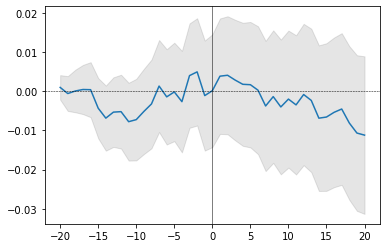

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.001        0.002   0.001         0.002   0.408    0.683
-19 -0.002        0.002  -0.001         0.003  -0.163    0.870
-18  0.001        0.002     0.0         0.004   0.021    0.983
-17  0.000        0.002     0.0         0.005   0.095    0.924
-16 -0.000        0.002     0.0         0.005   0.077    0.939
-15 -0.005        0.002  -0.004         0.006  -0.718    0.472
-14 -0.003        0.002  -0.007         0.006  -1.055    0.291
-13  0.002        0.002  -0.005         0.007  -0.766    0.444
-12  0.000        0.002  -0.005         0.007  -0.705    0.481
-11 -0.003        0.002  -0.008         0.008  -1.000    0.317
-10  0.001        0.002  -0.007         0.008  -0.889    0.374
-9   0.002        0.002  -0.005         0.009  -0.605    0.545
-8   0.002        0.002  -0.003         0.009  -0.364    0.716
-7   0.005        0.002   0.001         0.009   0.147    0.883
-6  -0.003        0.002  -0.001         0.010  -0.149    0.882
-5   0.001        0.002    -0.0         0.010  -0.015    0.988
-4  -0.002        0.002  -0.003         0.010  -0.261    0.794
-3   0.007        0.002   0.004         0.010   0.386    0.700
-2   0.001        0.002   0.005         0.011   0.465    0.642
-1  -0.006        0.002  -0.001         0.011  -0.099    0.921
0    0.001        0.002     0.0         0.011   0.014    0.989
1    0.004        0.002   0.004         0.012   0.337    0.736
2    0.000        0.002   0.004         0.012   0.349    0.727
3   -0.001        0.002   0.003         0.012   0.239    0.811
4   -0.001        0.002   0.002         0.012   0.147    0.883
5   -0.000        0.002   0.002         0.013   0.135    0.892
6   -0.001        0.002     0.0         0.013   0.023    0.982
7   -0.004        0.002  -0.004         0.013  -0.288    0.773
8    0.002        0.002  -0.001         0.013  -0.102    0.918
9   -0.003        0.002  -0.004         0.013  -0.297    0.767
10   0.002        0.002  -0.002         0.014  -0.145    0.885
11  -0.001        0.002  -0.003         0.014  -0.249    0.803
12   0.003        0.002  -0.001         0.014  -0.058    0.954
13  -0.002        0.002  -0.002         0.014  -0.163    0.871
14  -0.005        0.002  -0.007         0.015  -0.472    0.637
15   0.000        0.002  -0.007         0.015  -0.446    0.656
16   0.001        0.002  -0.005         0.015  -0.359    0.719
17   0.001        0.002  -0.005         0.015  -0.299    0.765
18  -0.004        0.002  -0.008         0.015  -0.528    0.597
19  -0.003        0.002  -0.011         0.016  -0.687    0.492
20  -0.001        0.002  -0.011         0.016  -0.712    0.476

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.001     0.001     1.792    -0.486 -0.102        -0.013         0.003   
-19 -0.001     0.001     2.983     0.080 -0.130        -0.016        -0.004   
-18  0.000     0.002     4.833     0.163 -0.200        -0.023        -0.002   
-17  0.000     0.003     4.045    -0.106 -0.214        -0.021        -0.002   
-16  0.000     0.004     2.882     0.154 -0.246        -0.034        -0.001   
-15 -0.004     0.006     4.707    -0.013 -0.344        -0.039        -0.003   
-14 -0.007     0.008     6.147    -0.353 -0.382        -0.043        -0.005   
-13 -0.005     0.007     5.948    -0.347 -0.358        -0.046        -0.000   
-12 -0.005     0.008     4.797    -0.403 -0.388        -0.047         0.001   
-11 -0.008     0.009     5.752    -0.594 -0.460        -0.055        -0.003   
-10 -0.007     0.008     2.623     0.205 -0.270        -0.055        -0.008   
-9  -0.005     0.008     2.117    -0.011 -0.307        -0.048        -0.008   
-8  -0.003     0.007     2.557     0.460 -0.241        -0.049        -0.003   
-7   0.001     0.009     3.259     0.615 -0.271        -0.045         0.001   
-6  -0.001     0.010     2.799     0.132 -0.314        -0.053         0.000   
-5  -0.000     0.009     1.863     0.005 -0.255        -0.045        -0.000   
-4  -0.003     0.011     1.892     0.085 -0.304        -0.051        -0.004   
-3   0.004     0.013     3.007     0.378 -0.351        -0.047        -0.005   
-2   0.005     0.016     2.810     0.298 -0.373        -0.048         0.009   
-1  -0.001     0.017     2.893     0.047 -0.453        -0.043        -0.011   
0    0.000     0.017     3.609    -0.382 -0.515        -0.047        -0.004   
1    0.004     0.019     4.507    -0.473 -0.595        -0.051         0.005   
2    0.004     0.020     3.984    -0.203 -0.574        -0.057         0.001   
3    0.003     0.021     3.925    -0.116 -0.609        -0.061        -0.001   
4    0.002     0.025     4.969    -0.106 -0.685        -0.064         0.004   
5    0.002     0.023     3.814     0.331 -0.498        -0.068         0.001   
6    0.000     0.024     3.963     0.473 -0.498        -0.072         0.000   
7   -0.004     0.026     3.931     0.540 -0.547        -0.087        -0.003   
8   -0.001     0.029     4.143     0.242 -0.679        -0.087         0.005   
9   -0.004     0.028     3.245    -0.034 -0.678        -0.084         0.000   
10  -0.002     0.028     3.427    -0.008 -0.661        -0.080         0.003   
11  -0.003     0.029     3.766    -0.013 -0.692        -0.076        -0.008   
12  -0.001     0.031     4.167     0.518 -0.598        -0.088        -0.012   
13  -0.002     0.031     4.045     0.519 -0.506        -0.091        -0.008   
14  -0.007     0.031     3.801     0.351 -0.536        -0.094        -0.013   
15  -0.007     0.031     3.966     0.313 -0.590        -0.096        -0.016   
16  -0.005     0.033     4.954     0.243 -0.727        -0.099        -0.006   
17  -0.005     0.034     5.132     0.303 -0.740        -0.092        -0.012   
18  -0.008     0.038     4.683     0.410 -0.744        -0.092        -0.017   
19  -0.011     0.038     4.388     0.640 -0.609        -0.111        -0.014   
20  -0.011     0.040     4.731     0.669 -0.548        -0.121        -0.015   

     Quantile 75%    Max  
-20         0.015  0.059  
-19         0.022  0.155  
-18         0.022  0.175  
-17         0.025  0.205  
-16         0.036  0.210  
-15         0.036  0.323  
-14         0.040  0.334  
-13         0.041  0.368  
-12         0.045  0.367  
-11         0.041  0.369  
-10         0.042  0.340  
-9          0.046  0.295  
-8          0.048  0.334  
-7          0.050  0.386  
-6          0.049  0.345  
-5          0.048  0.299  
-4          0.052  0.345  
-3          0.055  0.443  
-2          0.068  0.472  
-1          0.050  0.430  
0           0.059  0.441  
1           0.063  0.455  
2           0.070  0.488  
3           0.071  0.549  
4           

CAGR_PA


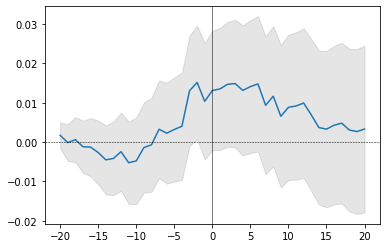

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.002        0.003   0.002         0.003   0.668    0.504
-19 -0.002        0.003    -0.0         0.004  -0.028    0.978
-18  0.001        0.003   0.001         0.004   0.138    0.891
-17 -0.002        0.003  -0.001         0.005  -0.226    0.821
-16 -0.000        0.003  -0.001         0.006  -0.218    0.827
-15 -0.001        0.003  -0.003         0.006  -0.418    0.676
-14 -0.002        0.003  -0.005         0.007  -0.659    0.510
-13  0.000        0.003  -0.004         0.007  -0.567    0.571
-12  0.002        0.003  -0.002         0.008  -0.313    0.754
-11 -0.003        0.003  -0.005         0.008  -0.639    0.523
-10  0.000        0.003  -0.005         0.009  -0.557    0.578
-9   0.003        0.003  -0.001         0.009  -0.155    0.877
-8   0.001        0.003  -0.001         0.009  -0.073    0.942
-7   0.004        0.003   0.003         0.010   0.340    0.734
-6  -0.001        0.003   0.002         0.010   0.228    0.820
-5   0.001        0.003   0.003         0.010   0.311    0.755
-4   0.001        0.003   0.004         0.011   0.379    0.705
-3   0.009        0.003   0.013         0.011   1.192    0.233
-2   0.002        0.003   0.015         0.011   1.347    0.178
-1  -0.005        0.003    0.01         0.012   0.897    0.370
0    0.003        0.003   0.013         0.012   1.108    0.268
1    0.000        0.003   0.014         0.012   1.116    0.264
2    0.001        0.003   0.015         0.012   1.187    0.235
3    0.000        0.003   0.015         0.013   1.176    0.240
4   -0.002        0.003   0.013         0.013   1.017    0.309
5    0.001        0.003   0.014         0.013   1.072    0.284
6    0.001        0.003   0.015         0.013   1.102    0.270
7   -0.005        0.003   0.009         0.014   0.685    0.493
8    0.002        0.003   0.012         0.014   0.839    0.401
9   -0.005        0.003   0.007         0.014   0.464    0.642
10   0.002        0.003   0.009         0.014   0.615    0.538
11   0.000        0.003   0.009         0.015   0.629    0.529
12   0.001        0.003    0.01         0.015   0.669    0.503
13  -0.003        0.003   0.007         0.015   0.460    0.646
14  -0.003        0.003   0.004         0.015   0.243    0.808
15  -0.000        0.003   0.003         0.016   0.213    0.831
16   0.001        0.003   0.004         0.016   0.274    0.784
17   0.001        0.003   0.005         0.016   0.303    0.762
18  -0.002        0.003   0.003         0.016   0.191    0.848
19  -0.000        0.003   0.003         0.016   0.165    0.869
20   0.001        0.003   0.003         0.017   0.201    0.841

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.002     0.001     1.349     0.324 -0.069        -0.014         0.004   
-19 -0.000     0.001     1.375    -0.105 -0.145        -0.019        -0.002   
-18  0.001     0.002     3.532    -0.189 -0.191        -0.024         0.001   
-17 -0.001     0.003     2.880    -0.098 -0.199        -0.024        -0.001   
-16 -0.001     0.003     1.968    -0.333 -0.225        -0.028        -0.002   
-15 -0.003     0.004     3.163    -0.311 -0.272        -0.036         0.004   
-14 -0.005     0.005     2.332     0.117 -0.196        -0.040        -0.001   
-13 -0.004     0.005     1.358     0.116 -0.194        -0.047        -0.004   
-12 -0.002     0.006     0.618    -0.021 -0.197        -0.041         0.001   
-11 -0.005     0.006     0.432    -0.236 -0.239        -0.057        -0.001   
-10 -0.005     0.007     1.127    -0.331 -0.273        -0.054        -0.005   
-9  -0.001     0.008     0.451    -0.154 -0.236        -0.049        -0.004   
-8  -0.001     0.009     0.711    -0.071 -0.239        -0.051        -0.007   
-7   0.003     0.010     1.134    -0.256 -0.292        -0.045         0.002   
-6   0.002     0.010     1.013    -0.642 -0.293        -0.044         0.007   
-5   0.003     0.009     0.313    -0.343 -0.274        -0.044         0.005   
-4   0.004     0.011     0.759    -0.266 -0.312        -0.055         0.009   
-3   0.013     0.013     3.079     0.248 -0.346        -0.049         0.010   
-2   0.015     0.016     2.676     0.280 -0.355        -0.053         0.018   
-1   0.010     0.017     1.756    -0.190 -0.390        -0.048         0.020   
0    0.013     0.017     2.002    -0.306 -0.425        -0.040         0.024   
1    0.014     0.019     1.828    -0.254 -0.448        -0.043         0.017   
2    0.015     0.020     2.113    -0.064 -0.455        -0.048         0.021   
3    0.015     0.022     1.575     0.072 -0.397        -0.058         0.010   
4    0.013     0.023     1.581    -0.023 -0.476        -0.060         0.015   
5    0.014     0.024     1.576    -0.036 -0.454        -0.057         0.010   
6    0.015     0.025     1.272     0.109 -0.411        -0.065         0.011   
7    0.009     0.027     1.360    -0.031 -0.537        -0.081         0.012   
8    0.012     0.029     1.129    -0.118 -0.510        -0.076         0.011   
9    0.007     0.030     1.188    -0.327 -0.591        -0.085         0.010   
10   0.009     0.028     1.047    -0.334 -0.596        -0.080         0.018   
11   0.009     0.029     1.239    -0.322 -0.625        -0.083         0.015   
12   0.010     0.032     0.838    -0.171 -0.565        -0.087         0.012   
13   0.007     0.035     0.693    -0.102 -0.545        -0.098         0.015   
14   0.004     0.035     0.784    -0.128 -0.530        -0.099         0.007   
15   0.003     0.035     0.839    -0.205 -0.571        -0.089        -0.006   
16   0.004     0.036     1.200    -0.197 -0.574        -0.089         0.004   
17   0.005     0.037     1.440    -0.183 -0.661        -0.105         0.002   
18   0.003     0.039     1.312    -0.129 -0.676        -0.097         0.003   
19   0.003     0.040     0.745    -0.018 -0.595        -0.116        -0.012   
20   0.003     0.040     0.839     0.148 -0.585        -0.096        -0.009   

     Quantile 75%    Max  
-20         0.015  0.085  
-19         0.022  0.103  
-18         0.022  0.177  
-17         0.020  0.161  
-16         0.029  0.169  
-15         0.036  0.241  
-14         0.032  0.263  
-13         0.041  0.270  
-12         0.047  0.258  
-11         0.050  0.211  
-10         0.055  0.267  
-9          0.058  0.258  
-8          0.063  0.308  
-7          0.066  0.338  
-6          0.065  0.226  
-5          0.062  0.223  
-4          0.072  0.302  
-3          0.074  0.506  
-2          0.079  0.531  
-1          0.072  0.433  
0           0.080  0.485  
1           0.088  0.473  
2           0.087  0.511  
3           0.091  0.529  
4           

SAN_MC


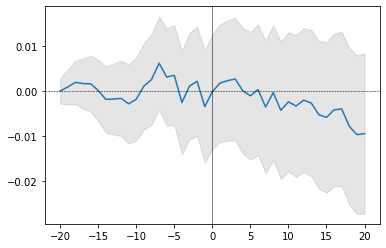

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.000        0.002     0.0         0.002   0.014    0.989
-19  0.001        0.002   0.001         0.003   0.306    0.760
-18  0.001        0.002   0.002         0.004   0.522    0.602
-17 -0.000        0.002   0.002         0.004   0.386    0.699
-16 -0.000        0.002   0.002         0.005   0.338    0.735
-15 -0.002        0.002     0.0         0.005   0.027    0.979
-14 -0.002        0.002  -0.002         0.006  -0.317    0.751
-13  0.000        0.002  -0.002         0.006  -0.287    0.774
-12  0.000        0.002  -0.002         0.007  -0.247    0.805
-11 -0.001        0.002  -0.003         0.007  -0.409    0.683
-10  0.001        0.002  -0.002         0.007  -0.249    0.804
-9   0.003        0.002   0.001         0.008   0.147    0.884
-8   0.001        0.002   0.003         0.008   0.328    0.743
-7   0.004        0.002   0.006         0.008   0.765    0.445
-6  -0.003        0.002   0.003         0.008   0.373    0.709
-5   0.000        0.002   0.004         0.009   0.405    0.685
-4  -0.006        0.002  -0.003         0.009  -0.283    0.778
-3   0.004        0.002   0.001         0.009   0.122    0.903
-2   0.001        0.002   0.002         0.009   0.230    0.818
-1  -0.006        0.002  -0.003         0.010  -0.354    0.724
0    0.003        0.002    -0.0         0.010  -0.013    0.990
1    0.002        0.002   0.002         0.010   0.175    0.861
2    0.001        0.002   0.002         0.010   0.224    0.823
3    0.000        0.002   0.003         0.011   0.253    0.800
4   -0.003        0.002     0.0         0.011   0.007    0.995
5   -0.001        0.002  -0.001         0.011  -0.093    0.926
6    0.001        0.002     0.0         0.011   0.030    0.976
7   -0.004        0.002  -0.004         0.012  -0.306    0.760
8    0.003        0.002    -0.0         0.012  -0.028    0.977
9   -0.004        0.002  -0.004         0.012  -0.357    0.721
10   0.002        0.002  -0.002         0.012  -0.196    0.845
11  -0.001        0.002  -0.003         0.012  -0.269    0.788
12   0.001        0.002  -0.002         0.012  -0.160    0.873
13  -0.001        0.002  -0.003         0.013  -0.209    0.835
14  -0.003        0.002  -0.005         0.013  -0.408    0.683
15  -0.001        0.002  -0.006         0.013  -0.447    0.655
16   0.002        0.002  -0.004         0.013  -0.315    0.753
17   0.000        0.002  -0.004         0.013  -0.295    0.768
18  -0.004        0.002  -0.008         0.014  -0.576    0.565
19  -0.002        0.002   -0.01         0.014  -0.702    0.482
20   0.000        0.002  -0.009         0.014  -0.678    0.498

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.000     0.001     4.622    -1.033 -0.115        -0.011         0.002   
-19  0.001     0.001     2.181    -0.784 -0.121        -0.013         0.002   
-18  0.002     0.001     1.094    -0.325 -0.111        -0.016         0.004   
-17  0.002     0.002     2.938    -0.561 -0.182        -0.018         0.001   
-16  0.002     0.003     2.035    -0.493 -0.209        -0.023         0.001   
-15  0.000     0.003     2.156    -0.125 -0.210        -0.028         0.002   
-14 -0.002     0.004     2.065    -0.392 -0.253        -0.034         0.003   
-13 -0.002     0.004     1.791     0.057 -0.234        -0.044         0.004   
-12 -0.002     0.005     1.788    -0.102 -0.235        -0.046         0.005   
-11 -0.003     0.006     1.975     0.122 -0.229        -0.046         0.005   
-10 -0.002     0.007     1.727     0.266 -0.204        -0.042        -0.001   
-9   0.001     0.006     0.666     0.266 -0.169        -0.047         0.006   
-8   0.003     0.007     1.810     0.323 -0.236        -0.043         0.004   
-7   0.006     0.008     2.157     0.304 -0.251        -0.040         0.001   
-6   0.003     0.008     2.210     0.146 -0.281        -0.040        -0.001   
-5   0.004     0.009     1.469     0.115 -0.259        -0.044         0.002   
-4  -0.003     0.010     1.573     0.041 -0.327        -0.058         0.000   
-3   0.001     0.011     1.877    -0.002 -0.384        -0.049        -0.000   
-2   0.002     0.013     3.618    -0.218 -0.513        -0.052         0.006   
-1  -0.003     0.014     4.342    -0.408 -0.567        -0.057        -0.001   
0   -0.000     0.014     4.830    -0.572 -0.584        -0.054         0.007   
1    0.002     0.014     2.339     0.100 -0.414        -0.064         0.011   
2    0.002     0.015     2.195     0.404 -0.377        -0.064        -0.003   
3    0.003     0.014     1.674     0.399 -0.317        -0.063        -0.004   
4    0.000     0.016     1.803     0.421 -0.336        -0.069        -0.003   
5   -0.001     0.016     1.705     0.439 -0.351        -0.076        -0.001   
6    0.000     0.017     2.180     0.639 -0.302        -0.079         0.005   
7   -0.004     0.020     1.627     0.380 -0.356        -0.089         0.007   
8   -0.000     0.021     1.643     0.383 -0.351        -0.077         0.003   
9   -0.004     0.022     1.052     0.218 -0.397        -0.082         0.003   
10  -0.002     0.022     1.314     0.177 -0.483        -0.086         0.004   
11  -0.003     0.023     1.642    -0.006 -0.572        -0.087        -0.008   
12  -0.002     0.025     1.537     0.238 -0.494        -0.093        -0.013   
13  -0.003     0.027     2.157     0.051 -0.571        -0.098        -0.011   
14  -0.005     0.028     2.780    -0.045 -0.621        -0.103        -0.023   
15  -0.006     0.030     2.934    -0.107 -0.664        -0.114        -0.015   
16  -0.004     0.030     3.449    -0.025 -0.748        -0.116        -0.003   
17  -0.004     0.033     3.718    -0.129 -0.816        -0.110        -0.007   
18  -0.008     0.035     2.894    -0.053 -0.803        -0.119        -0.002   
19  -0.010     0.035     2.250     0.096 -0.662        -0.113        -0.008   
20  -0.009     0.034     2.463     0.221 -0.613        -0.111        -0.020   

     Quantile 75%    Max  
-20         0.012  0.052  
-19         0.021  0.080  
-18         0.019  0.097  
-17         0.023  0.152  
-16         0.031  0.139  
-15         0.031  0.226  
-14         0.033  0.205  
-13         0.035  0.259  
-12         0.034  0.252  
-11         0.041  0.281  
-10         0.043  0.293  
-9          0.044  0.279  
-8          0.047  0.331  
-7          0.052  0.366  
-6          0.052  0.332  
-5          0.052  0.298  
-4          0.053  0.359  
-3          0.054  0.339  
-2          0.055  0.396  
-1          0.054  0.403  
0           0.062  0.377  
1           0.068  0.465  
2           0.060  0.507  
3           0.068  0.490  
4           

SOGN_PA


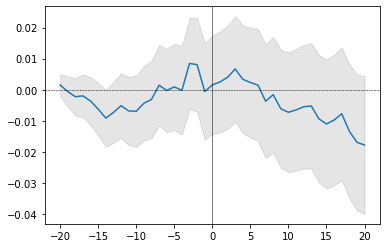

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.002        0.003   0.002         0.003   0.558    0.577
-19 -0.002        0.003  -0.001         0.004  -0.159    0.874
-18 -0.002        0.003  -0.002         0.005  -0.484    0.628
-17  0.000        0.003  -0.002         0.005  -0.367    0.714
-16 -0.002        0.003  -0.004         0.006  -0.607    0.544
-15 -0.003        0.003  -0.006         0.007  -0.947    0.344
-14 -0.003        0.003  -0.009         0.007  -1.278    0.201
-13  0.002        0.003  -0.007         0.008  -0.960    0.337
-12  0.002        0.003  -0.005         0.008  -0.633    0.527
-11 -0.002        0.003  -0.007         0.009  -0.801    0.423
-10 -0.000        0.003  -0.007         0.009  -0.775    0.439
-9   0.003        0.003  -0.004         0.009  -0.467    0.640
-8   0.001        0.003  -0.003         0.010  -0.323    0.747
-7   0.005        0.003   0.001         0.010   0.142    0.887
-6  -0.002        0.003    -0.0         0.010  -0.024    0.981
-5   0.001        0.003   0.001         0.011   0.083    0.934
-4  -0.001        0.003    -0.0         0.011  -0.018    0.986
-3   0.009        0.003   0.008         0.011   0.737    0.461
-2  -0.000        0.003   0.008         0.012   0.683    0.494
-1  -0.009        0.003  -0.001         0.012  -0.049    0.961
0    0.002        0.003   0.002         0.012   0.124    0.901
1    0.001        0.003   0.002         0.013   0.197    0.844
2    0.001        0.003   0.004         0.013   0.308    0.758
3    0.003        0.003   0.007         0.013   0.504    0.614
4   -0.003        0.003   0.003         0.013   0.248    0.804
5   -0.001        0.003   0.002         0.014   0.168    0.867
6   -0.001        0.003   0.001         0.014   0.103    0.918
7   -0.005        0.003  -0.004         0.014  -0.259    0.795
8    0.002        0.003  -0.002         0.015  -0.110    0.912
9   -0.005        0.003  -0.006         0.015  -0.416    0.677
10  -0.001        0.003  -0.007         0.015  -0.483    0.629
11   0.001        0.003  -0.007         0.015  -0.426    0.670
12   0.001        0.003  -0.005         0.016  -0.354    0.723
13   0.000        0.003  -0.005         0.016  -0.332    0.740
14  -0.004        0.003  -0.009         0.016  -0.586    0.558
15  -0.002        0.003  -0.011         0.016  -0.680    0.497
16   0.001        0.003   -0.01         0.016  -0.595    0.552
17   0.002        0.003  -0.008         0.017  -0.465    0.642
18  -0.006        0.003  -0.013         0.017  -0.791    0.429
19  -0.004        0.003  -0.017         0.017  -0.990    0.322
20  -0.001        0.003  -0.018         0.017  -1.029    0.303

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.002     0.001     6.825    -1.106 -0.160        -0.012         0.004   
-19 -0.001     0.002     2.405    -0.078 -0.145        -0.017         0.000   
-18 -0.002     0.002     7.937    -0.859 -0.256        -0.026        -0.002   
-17 -0.002     0.003     4.187    -0.541 -0.235        -0.025        -0.003   
-16 -0.004     0.003     1.770     0.122 -0.193        -0.037        -0.004   
-15 -0.006     0.005     3.831     0.287 -0.274        -0.038         0.002   
-14 -0.009     0.007     5.820    -0.177 -0.399        -0.047        -0.002   
-13 -0.007     0.006     3.234     0.393 -0.278        -0.049        -0.004   
-12 -0.005     0.007     2.327     0.376 -0.258        -0.059        -0.002   
-11 -0.007     0.008     2.223     0.196 -0.273        -0.054        -0.004   
-10 -0.007     0.009     1.891     0.187 -0.285        -0.063        -0.005   
-9  -0.004     0.009     1.225     0.132 -0.283        -0.054        -0.006   
-8  -0.003     0.010     2.133     0.068 -0.349        -0.057        -0.005   
-7   0.001     0.011     2.541    -0.072 -0.354        -0.053         0.001   
-6  -0.000     0.013     2.497    -0.494 -0.398        -0.051         0.002   
-5   0.001     0.012     1.605    -0.333 -0.371        -0.051         0.011   
-4  -0.000     0.013     1.138    -0.178 -0.371        -0.054         0.002   
-3   0.008     0.017     2.574     0.289 -0.430        -0.058         0.004   
-2   0.008     0.019     2.356     0.315 -0.408        -0.059         0.006   
-1  -0.001     0.021     2.651    -0.226 -0.575        -0.070        -0.006   
0    0.002     0.021     4.005    -0.749 -0.673        -0.070         0.004   
1    0.002     0.021     2.572    -0.484 -0.575        -0.068        -0.005   
2    0.004     0.023     1.697    -0.065 -0.482        -0.067         0.005   
3    0.007     0.024     1.719     0.198 -0.425        -0.077         0.013   
4    0.003     0.027     1.885     0.174 -0.443        -0.075         0.011   
5    0.002     0.025     1.603     0.105 -0.472        -0.077         0.002   
6    0.001     0.026     1.779     0.201 -0.437        -0.074         0.006   
7   -0.004     0.030     1.978    -0.072 -0.587        -0.076         0.008   
8   -0.002     0.031     2.156    -0.062 -0.569        -0.078         0.012   
9   -0.006     0.032     1.801    -0.211 -0.560        -0.103         0.008   
10  -0.007     0.031     1.846    -0.206 -0.583        -0.095         0.007   
11  -0.007     0.033     2.029    -0.248 -0.632        -0.091         0.000   
12  -0.005     0.035     1.936     0.010 -0.539        -0.097         0.007   
13  -0.005     0.038     1.869    -0.117 -0.619        -0.116         0.002   
14  -0.009     0.039     2.238    -0.215 -0.638        -0.104        -0.003   
15  -0.011     0.041     2.774    -0.492 -0.755        -0.116         0.001   
16  -0.010     0.042     2.634    -0.340 -0.722        -0.105         0.004   
17  -0.008     0.044     2.795    -0.195 -0.761        -0.108        -0.003   
18  -0.013     0.048     3.178    -0.278 -0.893        -0.112        -0.004   
19  -0.017     0.049     2.634    -0.156 -0.815        -0.118        -0.006   
20  -0.018     0.050     2.294     0.077 -0.705        -0.131        -0.002   

     Quantile 75%    Max  
-20         0.017  0.091  
-19         0.021  0.144  
-18         0.018  0.173  
-17         0.023  0.194  
-16         0.034  0.206  
-15         0.026  0.304  
-14         0.034  0.350  
-13         0.042  0.335  
-12         0.045  0.354  
-11         0.047  0.364  
-10         0.050  0.350  
-9          0.052  0.303  
-8          0.054  0.357  
-7          0.060  0.413  
-6          0.057  0.337  
-5          0.060  0.339  
-4          0.068  0.384  
-3          0.088  0.532  
-2          0.078  0.544  
-1          0.075  0.429  
0           0.074  0.397  
1           0.079  0.438  
2           0.083  0.513  
3           0.084  0.603  
4           

BARC_L


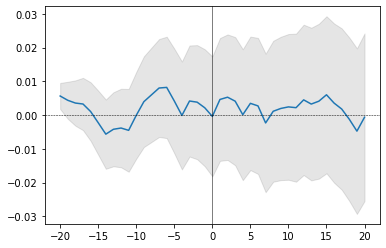

AAR  Std. E. AAR     CAAR  Std. E. CAAR  T-stat  P-value
-20  0.006        0.003  0.006 *         0.003   1.869    0.062
-19 -0.001        0.003    0.004         0.004   1.024    0.306
-18 -0.001        0.003    0.004         0.005   0.681    0.496
-17 -0.000        0.003    0.003         0.006   0.543    0.587
-16 -0.002        0.003    0.001         0.007   0.156    0.876
-15 -0.003        0.003   -0.002         0.007  -0.305    0.761
-14 -0.003        0.003   -0.006         0.008  -0.706    0.480
-13  0.001        0.003   -0.004         0.009  -0.491    0.623
-12  0.000        0.003   -0.004         0.009  -0.422    0.673
-11 -0.001        0.003   -0.005         0.010  -0.472    0.637
-10  0.004        0.003     -0.0         0.010  -0.007    0.994
-9   0.004        0.003    0.004         0.010   0.379    0.705
-8   0.002        0.003    0.006         0.011   0.550    0.582
-7   0.002        0.003    0.008         0.011   0.709    0.479
-6   0.000        0.003    0.008         0.012   0.700    0.484
-5  -0.004        0.003    0.004         0.012   0.345    0.730
-4  -0.004        0.003     -0.0         0.012  -0.008    0.993
-3   0.004        0.003    0.004         0.013   0.325    0.745
-2  -0.000        0.003    0.004         0.013   0.290    0.772
-1  -0.002        0.003    0.002         0.014   0.161    0.872
0   -0.003        0.003     -0.0         0.014  -0.028    0.978
1    0.005        0.003    0.005         0.014   0.327    0.744
2    0.001        0.003    0.005         0.015   0.365    0.715
3   -0.001        0.003    0.004         0.015   0.278    0.781
4   -0.004        0.003      0.0         0.015   0.007    0.994
5    0.003        0.003    0.003         0.015   0.226    0.821
6   -0.001        0.003    0.003         0.016   0.173    0.863
7   -0.005        0.003   -0.002         0.016  -0.145    0.884
8    0.003        0.003    0.001         0.016   0.070    0.944
9    0.001        0.003    0.002         0.017   0.119    0.905
10   0.000        0.003    0.002         0.017   0.144    0.885
11  -0.000        0.003    0.002         0.017   0.128    0.898
12   0.002        0.003    0.005         0.017   0.260    0.795
13  -0.001        0.003    0.003         0.018   0.185    0.853
14   0.001        0.003    0.004         0.018   0.230    0.818
15   0.002        0.003    0.006         0.018   0.332    0.740
16  -0.002        0.003    0.004         0.018   0.193    0.847
17  -0.002        0.003    0.002         0.019   0.096    0.923
18  -0.003        0.003   -0.001         0.019  -0.066    0.948
19  -0.004        0.003   -0.005         0.019  -0.248    0.804
20   0.004        0.003   -0.001         0.019  -0.033    0.974

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.006     0.001    16.572     2.938 -0.076        -0.010         0.003   
-19  0.004     0.002     2.749     0.921 -0.085        -0.016         0.002   
-18  0.004     0.002     2.561     0.481 -0.153        -0.021         0.002   
-17  0.003     0.003     3.221     0.021 -0.225        -0.029         0.004   
-16  0.001     0.005     4.969     0.229 -0.302        -0.038         0.007   
-15 -0.002     0.007    14.227    -1.501 -0.548        -0.041         0.005   
-14 -0.006     0.011    29.613    -3.447 -0.849        -0.048        -0.005   
-13 -0.004     0.013    30.585    -4.003 -0.933        -0.049        -0.001   
-12 -0.004     0.017    30.635    -4.182 -1.049        -0.047         0.000   
-11 -0.005     0.020    35.711    -4.429 -1.177        -0.048        -0.004   
-10 -0.000     0.011     5.016     0.334 -0.422        -0.053        -0.000   
-9   0.004     0.012     4.708     0.308 -0.391        -0.058         0.004   
-8   0.006     0.013     7.508     0.642 -0.453        -0.044         0.002   
-7   0.008     0.015     7.631     1.039 -0.423        -0.055        -0.002   
-6   0.008     0.016     4.463     0.497 -0.415        -0.059         0.004   
-5   0.004     0.017     6.717    -0.386 -0.643        -0.055         0.005   
-4  -0.000     0.021     7.858    -0.435 -0.739        -0.068         0.003   
-3   0.004     0.024     9.874    -0.644 -0.857        -0.064         0.012   
-2   0.004     0.029    11.841    -0.978 -0.990        -0.061         0.009   
-1   0.002     0.023     7.450     0.487 -0.688        -0.061         0.007   
0   -0.000     0.023     7.445     0.367 -0.671        -0.062         0.009   
1    0.005     0.026     9.805     0.519 -0.691        -0.061         0.009   
2    0.005     0.031    10.460     0.802 -0.782        -0.064        -0.002   
3    0.004     0.037    11.202     0.467 -0.900        -0.066         0.002   
4    0.000     0.041    10.563     0.035 -1.032        -0.071         0.009   
5    0.003     0.031     8.871     1.502 -0.569        -0.084         0.010   
6    0.003     0.033     8.992     1.593 -0.549        -0.088         0.005   
7   -0.002     0.038     8.172     1.407 -0.654        -0.103         0.003   
8    0.001     0.041     7.769     1.582 -0.614        -0.107         0.005   
9    0.002     0.038     5.784     1.059 -0.647        -0.106         0.009   
10   0.002     0.039     6.589     1.090 -0.702        -0.099         0.002   
11   0.002     0.043     7.671     1.063 -0.816        -0.093         0.005   
12   0.005     0.048     8.595     1.216 -0.852        -0.099         0.005   
13   0.003     0.053     8.549     1.178 -0.864        -0.098        -0.006   
14   0.004     0.054     8.985     1.129 -0.899        -0.100         0.018   
15   0.006     0.054     8.095     0.790 -0.927        -0.089         0.014   
16   0.004     0.057     9.130     0.600 -1.102        -0.097         0.002   
17   0.002     0.063     9.505     0.676 -1.174        -0.103         0.002   
18  -0.001     0.069     8.983     0.996 -1.098        -0.112        -0.008   
19  -0.005     0.069     8.157     1.199 -0.925        -0.106        -0.014   
20  -0.001     0.071     9.183     1.616 -0.745        -0.107        -0.001   

     Quantile 75%    Max  
-20         0.015  0.250  
-19         0.020  0.155  
-18         0.025  0.177  
-17         0.027  0.205  
-16         0.028  0.304  
-15         0.032  0.325  
-14         0.038  0.332  
-13         0.042  0.261  
-12         0.045  0.271  
-11         0.052  0.392  
-10         0.056  0.517  
-9          0.057  0.536  
-8          0.055  0.627  
-7          0.071  0.703  
-6          0.079  0.613  
-5          0.065  0.588  
-4          0.072  0.687  
-3          0.062  0.695  
-2          0.061  0.793  
-1          0.052  0.786  
0           0.058  0.792  
1           0.063  0.922  
2           0.066  1.026  
3           0.078  1.109  
4           

In [70]:
for ticker, event in releases_20_100.items():
    print(ticker)
    event.plot()
    plt.show()
    display(event.results())
    display(event.get_CAR_dist())

In [71]:
#using the event study (formula for each element of the tickers list (event window: +-20 / estimation size: 200)
tickers = ['JPM_N','BAC_N','C_N','WFC_N','GS','MS_N','HSBA_L','BNPP_PA','CAGR_PA','SAN_MC','SOGN_PA','BARC_L']
releases_20_200 = dict()

for ticker in tickers:
    events = [event for event in event_database if event['security_ticker']==ticker]
    
    releases_20_200[ticker] = es.Multiple.from_list(
        events,
        es.Single.FamaFrench_3factor,
        event_window= (-20,+20),
        estimation_size = 200)

2022-05-29 12:34:17,457 P[5368] [MainThread 14260]  8 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:34:17,622 P[5368] [MainThread 14260]  8 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:34:17,769 P[5368] [MainThread 14260]  8 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:34:17,934 P[5368] [MainThread 14260]  8 events have not been processed due to data issues.
Tips: Get more details on errors by calling Multiple.error_report() method or by exploring Multiple.errors class variable.
2022-05-29 12:34:18,086 P[5368] [MainThread 14260]  8 events have not been processed due

JPM_N


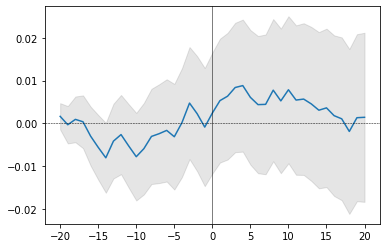

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.002        0.002   0.002         0.002   0.683    0.494
-19 -0.002        0.002    -0.0         0.003  -0.092    0.927
-18  0.001        0.002   0.001         0.004   0.226    0.821
-17 -0.001        0.002     0.0         0.005   0.079    0.937
-16 -0.003        0.002  -0.003         0.005  -0.553    0.581
-15 -0.003        0.002  -0.006         0.006  -0.949    0.343
-14 -0.002        0.002  -0.008         0.006  -1.262    0.207
-13  0.004        0.002  -0.004         0.007  -0.608    0.543
-12  0.002        0.002  -0.003         0.007  -0.361    0.718
-11 -0.003        0.002  -0.005         0.008  -0.690    0.490
-10 -0.003        0.002  -0.008         0.008  -0.974    0.330
-9   0.002        0.002  -0.006         0.008  -0.708    0.479
-8   0.003        0.002  -0.003         0.009  -0.350    0.726
-7   0.001        0.002  -0.002         0.009  -0.267    0.789
-6   0.001        0.002  -0.002         0.009  -0.175    0.861
-5  -0.001        0.002  -0.003         0.010  -0.323    0.747
-4   0.003        0.002     0.0         0.010   0.016    0.987
-3   0.005        0.002   0.005         0.010   0.465    0.642
-2  -0.002        0.002   0.002         0.010   0.217    0.829
-1  -0.003        0.002  -0.001         0.011  -0.080    0.936
0    0.003        0.002   0.002         0.011   0.220    0.826
1    0.003        0.002   0.005         0.011   0.471    0.637
2    0.001        0.002   0.006         0.012   0.550    0.582
3    0.002        0.002   0.008         0.012   0.711    0.477
4    0.000        0.002   0.009         0.012   0.734    0.463
5   -0.003        0.002   0.006         0.012   0.496    0.620
6   -0.002        0.002   0.004         0.012   0.351    0.726
7    0.000        0.002   0.004         0.013   0.349    0.727
8    0.003        0.002   0.008         0.013   0.599    0.549
9   -0.003        0.002   0.005         0.013   0.399    0.690
10   0.003        0.002   0.008         0.013   0.586    0.558
11  -0.002        0.002   0.005         0.014   0.400    0.689
12   0.000        0.002   0.006         0.014   0.411    0.681
13  -0.001        0.002   0.005         0.014   0.325    0.745
14  -0.001        0.002   0.003         0.014   0.217    0.829
15   0.001        0.002   0.004         0.014   0.251    0.802
16  -0.002        0.002   0.002         0.015   0.124    0.902
17  -0.001        0.002   0.001         0.015   0.072    0.942
18  -0.003        0.002  -0.002         0.015  -0.125    0.901
19   0.003        0.002   0.001         0.015   0.088    0.930
20   0.000        0.002   0.001         0.015   0.093    0.926

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.002     0.001     6.344     0.353 -0.113        -0.006         0.001   
-19 -0.000     0.001     7.760     0.462 -0.161        -0.014         0.001   
-18  0.001     0.002     5.054     0.322 -0.165        -0.019         0.001   
-17  0.000     0.002     6.633    -0.189 -0.198        -0.020         0.000   
-16 -0.003     0.002     6.788    -1.341 -0.247        -0.021        -0.001   
-15 -0.006     0.003     6.971    -1.365 -0.297        -0.033        -0.002   
-14 -0.008     0.004     5.750    -0.669 -0.314        -0.038        -0.005   
-13 -0.004     0.003     1.237     0.598 -0.144        -0.039        -0.008   
-12 -0.003     0.003     1.041     0.637 -0.136        -0.040        -0.003   
-11 -0.005     0.004     1.084     0.482 -0.154        -0.040        -0.008   
-10 -0.008     0.004     1.236     0.162 -0.220        -0.049        -0.003   
-9  -0.006     0.005     1.561     0.300 -0.238        -0.051        -0.003   
-8  -0.003     0.006     3.650    -0.319 -0.377        -0.043         0.003   
-7  -0.002     0.007     4.296    -0.406 -0.413        -0.043        -0.002   
-6  -0.002     0.007     5.091    -0.811 -0.424        -0.043         0.002   
-5  -0.003     0.007     4.356    -0.589 -0.413        -0.046        -0.004   
-4   0.000     0.006     0.806     0.483 -0.199        -0.048        -0.001   
-3   0.005     0.007     1.941     0.854 -0.217        -0.046        -0.001   
-2   0.002     0.008     1.256     0.561 -0.253        -0.047        -0.003   
-1  -0.001     0.008     0.657     0.530 -0.250        -0.052        -0.005   
0    0.002     0.007     0.608     0.371 -0.223        -0.052        -0.003   
1    0.005     0.009     1.998     0.095 -0.356        -0.040        -0.008   
2    0.006     0.008     0.862     0.657 -0.204        -0.046        -0.003   
3    0.008     0.010     0.732     0.605 -0.200        -0.045        -0.006   
4    0.009     0.010     1.816     0.800 -0.235        -0.055        -0.002   
5    0.006     0.009     1.593     0.678 -0.241        -0.051        -0.003   
6    0.004     0.010     3.416     1.057 -0.226        -0.054        -0.007   
7    0.004     0.010     1.568     0.818 -0.229        -0.059        -0.002   
8    0.008     0.012     1.752     0.862 -0.234        -0.055        -0.003   
9    0.005     0.011     1.528     0.711 -0.250        -0.060         0.000   
10   0.008     0.012     1.676     0.932 -0.243        -0.055        -0.001   
11   0.005     0.012     1.640     0.962 -0.242        -0.059        -0.010   
12   0.006     0.013     2.058     0.929 -0.240        -0.062        -0.007   
13   0.005     0.013     1.478     0.851 -0.253        -0.061        -0.013   
14   0.003     0.014     1.283     0.705 -0.278        -0.063        -0.015   
15   0.004     0.014     1.450     0.675 -0.288        -0.066        -0.014   
16   0.002     0.014     1.416     0.697 -0.274        -0.071        -0.012   
17   0.001     0.017     2.089     0.589 -0.402        -0.063        -0.006   
18  -0.002     0.017     1.421     0.436 -0.410        -0.071        -0.011   
19   0.001     0.018     1.506     0.733 -0.326        -0.065        -0.011   
20   0.001     0.018     2.624     0.599 -0.508        -0.073        -0.012   

     Quantile 75%    Max  
-20         0.011  0.135  
-19         0.010  0.183  
-18         0.017  0.181  
-17         0.017  0.201  
-16         0.021  0.145  
-15         0.025  0.146  
-14         0.025  0.210  
-13         0.026  0.175  
-12         0.028  0.196  
-11         0.027  0.207  
-10         0.023  0.198  
-9          0.028  0.211  
-8          0.032  0.235  
-7          0.032  0.242  
-6          0.038  0.242  
-5          0.035  0.223  
-4          0.039  0.238  
-3          0.041  0.333  
-2          0.040  0.319  
-1          0.043  0.257  
0           0.052  0.267  
1           0.059  0.307  
2           0.048  0.269  
3           0.063  0.321  
4           

BAC_N


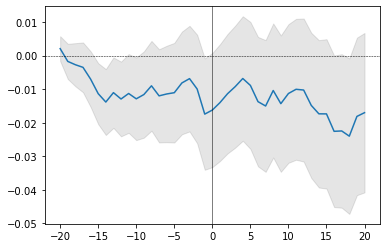

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-20  0.002        0.003     0.002         0.003   0.720    0.471
-19 -0.004        0.003    -0.002         0.004  -0.419    0.675
-18 -0.001        0.003    -0.003         0.005  -0.540    0.589
-17 -0.001        0.003    -0.003         0.006  -0.602    0.547
-16 -0.004        0.003    -0.007         0.006  -1.080    0.280
-15 -0.004        0.003    -0.011         0.007  -1.598    0.110
-14 -0.002        0.003  -0.014 *         0.008  -1.805    0.071
-13  0.003        0.003    -0.011         0.008  -1.347    0.178
-12 -0.002        0.003    -0.013         0.009  -1.487    0.137
-11  0.002        0.003    -0.011         0.009  -1.232    0.218
-10 -0.002        0.003    -0.013         0.010  -1.340    0.180
-9   0.001        0.003    -0.012         0.010  -1.156    0.248
-8   0.003        0.003    -0.009         0.010  -0.861    0.389
-7  -0.003        0.003    -0.012         0.011  -1.106    0.269
-6   0.001        0.003    -0.011         0.011  -1.019    0.308
-5   0.000        0.003    -0.011         0.012  -0.953    0.340
-4   0.003        0.003    -0.008         0.012  -0.681    0.496
-3   0.001        0.003    -0.007         0.012  -0.558    0.577
-2  -0.003        0.003     -0.01         0.013  -0.787    0.431
-1  -0.007        0.003    -0.017         0.013  -1.346    0.178
0    0.001        0.003    -0.016         0.013  -1.222    0.222
1    0.002        0.003    -0.014         0.014  -1.031    0.303
2    0.003        0.003    -0.011         0.014  -0.817    0.414
3    0.002        0.003    -0.009         0.014  -0.652    0.515
4    0.002        0.003    -0.007         0.014  -0.471    0.638
5   -0.002        0.003    -0.009         0.015  -0.601    0.548
6   -0.005        0.003    -0.014         0.015  -0.911    0.362
7   -0.001        0.003    -0.015         0.015  -0.979    0.327
8    0.005        0.003     -0.01         0.016  -0.666    0.505
9   -0.004        0.003    -0.014         0.016  -0.902    0.367
10   0.003        0.003    -0.011         0.016  -0.700    0.484
11   0.001        0.003     -0.01         0.016  -0.612    0.540
12  -0.000        0.003     -0.01         0.017  -0.616    0.538
13  -0.005        0.003    -0.015         0.017  -0.878    0.380
14  -0.003        0.003    -0.017         0.017  -1.012    0.311
15  -0.000        0.003    -0.017         0.017  -0.999    0.318
16  -0.005        0.003    -0.023         0.018  -1.281    0.200
17   0.000        0.003    -0.022         0.018  -1.257    0.209
18  -0.002        0.003    -0.024         0.018  -1.327    0.185
19   0.006        0.003    -0.018         0.018  -0.989    0.323
20   0.001        0.003    -0.017         0.019  -0.917    0.359

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.002     0.001    17.691     2.784 -0.107        -0.009        -0.000   
-19 -0.002     0.003    26.419     2.799 -0.212        -0.012        -0.002   
-18 -0.003     0.004    27.189     2.284 -0.320        -0.018        -0.005   
-17 -0.003     0.005    33.676     2.338 -0.353        -0.018         0.001   
-16 -0.007     0.006    17.616    -0.313 -0.425        -0.021        -0.001   
-15 -0.011     0.007    18.840    -1.458 -0.555        -0.030        -0.003   
-14 -0.014     0.010    36.590    -4.177 -0.838        -0.036        -0.008   
-13 -0.011     0.008    13.556    -1.439 -0.535        -0.038        -0.006   
-12 -0.013     0.009    19.066    -2.379 -0.684        -0.040        -0.009   
-11 -0.011     0.010    12.939    -0.305 -0.591        -0.042        -0.013   
-10 -0.013     0.012    12.247     0.235 -0.619        -0.046        -0.013   
-9  -0.012     0.013     9.885     0.972 -0.535        -0.053        -0.009   
-8  -0.009     0.013     7.615     0.868 -0.443        -0.048        -0.008   
-7  -0.012     0.015     6.798     0.223 -0.478        -0.054        -0.010   
-6  -0.011     0.013     6.927    -0.624 -0.555        -0.054        -0.011   
-5  -0.011     0.017    15.098    -1.642 -0.836        -0.058        -0.009   
-4  -0.008     0.017     9.454    -0.612 -0.691        -0.053        -0.006   
-3  -0.007     0.022    10.298    -1.081 -0.801        -0.057        -0.003   
-2  -0.010     0.023     7.273    -0.540 -0.767        -0.055        -0.008   
-1  -0.017     0.023     4.465    -0.173 -0.631        -0.068        -0.012   
0   -0.016     0.020     5.352    -0.122 -0.603        -0.061        -0.016   
1   -0.014     0.028     7.718    -0.583 -0.886        -0.065        -0.010   
2   -0.011     0.024     3.858     0.130 -0.589        -0.067        -0.013   
3   -0.009     0.029     5.588     0.137 -0.740        -0.066        -0.010   
4   -0.007     0.033     7.397     0.912 -0.650        -0.063        -0.015   
5   -0.009     0.036     8.429     0.489 -0.720        -0.067        -0.014   
6   -0.014     0.040     9.292     0.635 -0.833        -0.073        -0.016   
7   -0.015     0.041     7.837     0.334 -0.845        -0.075        -0.016   
8   -0.010     0.040     6.638     0.436 -0.876        -0.075        -0.012   
9   -0.014     0.035     6.398     0.217 -0.842        -0.078        -0.012   
10  -0.011     0.036     5.480     0.385 -0.655        -0.078        -0.016   
11  -0.010     0.037     4.930     0.344 -0.775        -0.073        -0.010   
12  -0.010     0.040     6.579     0.376 -0.888        -0.078        -0.017   
13  -0.015     0.043     5.844    -0.008 -0.858        -0.083        -0.008   
14  -0.017     0.044     5.874     0.105 -0.835        -0.078        -0.017   
15  -0.017     0.041     6.421     0.178 -0.832        -0.091        -0.020   
16  -0.023     0.045     6.469    -0.283 -0.900        -0.092        -0.021   
17  -0.022     0.053     7.455    -0.033 -0.957        -0.102        -0.023   
18  -0.024     0.054     7.339     0.180 -0.959        -0.108        -0.022   
19  -0.018     0.050     7.240     0.938 -0.768        -0.105        -0.021   
20  -0.017     0.049     7.395     0.763 -0.836        -0.105        -0.023   

     Quantile 75%    Max  
-20         0.009  0.216  
-19         0.009  0.414  
-18         0.012  0.493  
-17         0.015  0.542  
-16         0.016  0.445  
-15         0.021  0.405  
-14         0.015  0.326  
-13         0.020  0.351  
-12         0.019  0.297  
-11         0.022  0.419  
-10         0.020  0.469  
-9          0.015  0.518  
-8          0.019  0.524  
-7          0.021  0.558  
-6          0.022  0.329  
-5          0.022  0.482  
-4          0.039  0.533  
-3          0.039  0.510  
-2          0.040  0.522  
-1          0.026  0.502  
0           0.032  0.539  
1           0.035  0.540  
2           0.041  0.496  
3           0.038  0.718  
4           

C_N


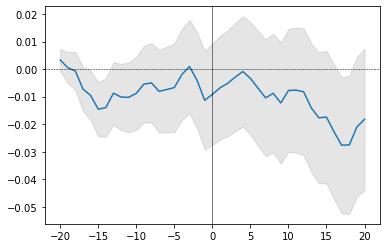

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-20  0.003        0.003     0.003         0.003   1.058    0.290
-19 -0.003        0.003     0.001         0.004   0.118    0.906
-18 -0.001        0.003    -0.001         0.005  -0.130    0.896
-17 -0.007        0.003    -0.007         0.006  -1.157    0.247
-16 -0.002        0.003     -0.01         0.007  -1.365    0.172
-15 -0.005        0.003  -0.015 *         0.008  -1.898    0.058
-14  0.001        0.003  -0.014 *         0.008  -1.688    0.091
-13  0.005        0.003    -0.009         0.009  -0.986    0.324
-12 -0.001        0.003     -0.01         0.009  -1.079    0.281
-11 -0.000        0.003     -0.01         0.010  -1.036    0.300
-10  0.001        0.003    -0.009         0.010  -0.846    0.397
-9   0.003        0.003    -0.005         0.011  -0.502    0.615
-8   0.000        0.003    -0.005         0.011  -0.444    0.657
-7  -0.003        0.003    -0.008         0.012  -0.688    0.491
-6   0.001        0.003    -0.007         0.012  -0.611    0.541
-5   0.001        0.003    -0.007         0.013  -0.536    0.592
-4   0.005        0.003    -0.002         0.013  -0.151    0.880
-3   0.003        0.003     0.001         0.013   0.072    0.943
-2  -0.005        0.003    -0.004         0.014  -0.303    0.762
-1  -0.007        0.003    -0.011         0.014  -0.809    0.418
0    0.002        0.003    -0.009         0.014  -0.639    0.523
1    0.002        0.003    -0.007         0.015  -0.464    0.643
2    0.002        0.003    -0.005         0.015  -0.346    0.729
3    0.002        0.003    -0.003         0.015  -0.190    0.849
4    0.002        0.003    -0.001         0.016  -0.056    0.955
5   -0.002        0.003    -0.003         0.016  -0.211    0.833
6   -0.004        0.003    -0.007         0.016  -0.425    0.671
7   -0.004        0.003     -0.01         0.017  -0.630    0.528
8    0.002        0.003    -0.009         0.017  -0.521    0.603
9   -0.004        0.003    -0.012         0.017  -0.717    0.473
10   0.005        0.003    -0.008         0.017  -0.445    0.656
11   0.000        0.003    -0.008         0.018  -0.431    0.667
12  -0.001        0.003    -0.008         0.018  -0.458    0.647
13  -0.006        0.003    -0.014         0.018  -0.770    0.441
14  -0.004        0.003    -0.018         0.019  -0.955    0.340
15   0.000        0.003    -0.017         0.019  -0.928    0.354
16  -0.005        0.003    -0.023         0.019  -1.198    0.231
17  -0.005        0.003    -0.028         0.019  -1.432    0.152
18   0.000        0.003    -0.028         0.020  -1.407    0.159
19   0.007        0.003    -0.021         0.020  -1.060    0.289
20   0.003        0.003    -0.018         0.020  -0.909    0.364

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.003     0.001     7.503     0.789 -0.111        -0.007         0.002   
-19  0.001     0.003    11.067     1.015 -0.218        -0.013        -0.001   
-18 -0.001     0.003     9.453     0.365 -0.290        -0.021        -0.005   
-17 -0.007     0.006    19.897    -2.707 -0.508        -0.027        -0.002   
-16 -0.010     0.008    16.035    -2.911 -0.526        -0.024        -0.001   
-15 -0.015     0.010    21.319    -3.494 -0.646        -0.036        -0.004   
-14 -0.014     0.010    29.663    -3.854 -0.796        -0.043        -0.001   
-13 -0.009     0.007     9.901    -1.655 -0.483        -0.044         0.002   
-12 -0.010     0.011    19.460    -3.180 -0.638        -0.043        -0.004   
-11 -0.010     0.012    25.822    -3.552 -0.834        -0.049        -0.006   
-10 -0.009     0.016    17.504    -1.621 -0.812        -0.044        -0.006   
-9  -0.005     0.016    20.526    -1.866 -0.881        -0.042        -0.003   
-8  -0.005     0.018    22.583    -2.098 -0.969        -0.039        -0.005   
-7  -0.008     0.019    18.889    -2.236 -0.955        -0.042         0.002   
-6  -0.007     0.019    18.164    -2.759 -0.936        -0.044         0.002   
-5  -0.007     0.017    11.282    -1.605 -0.746        -0.047        -0.003   
-4  -0.002     0.016     4.957    -0.380 -0.506        -0.050        -0.003   
-3   0.001     0.018     5.754    -0.292 -0.591        -0.055         0.003   
-2  -0.004     0.018     3.956    -0.008 -0.476        -0.065         0.002   
-1  -0.011     0.018     3.784    -0.432 -0.520        -0.067        -0.006   
0   -0.009     0.015     5.135    -0.788 -0.601        -0.062         0.003   
1   -0.007     0.020     7.549    -0.938 -0.786        -0.063         0.003   
2   -0.005     0.017     2.771     0.208 -0.484        -0.064        -0.002   
3   -0.003     0.020     4.248    -0.066 -0.632        -0.062         0.004   
4   -0.001     0.021     5.882     0.822 -0.517        -0.065        -0.000   
5   -0.003     0.024     5.194     0.382 -0.553        -0.060        -0.004   
6   -0.007     0.024     6.584     0.716 -0.516        -0.068        -0.005   
7   -0.010     0.025     5.828     0.444 -0.646        -0.073        -0.016   
8   -0.009     0.028     7.304    -0.158 -0.863        -0.073        -0.006   
9   -0.012     0.026     5.702    -0.148 -0.764        -0.077        -0.009   
10  -0.008     0.024     4.153     0.466 -0.547        -0.078        -0.013   
11  -0.008     0.026     3.320     0.319 -0.576        -0.082        -0.006   
12  -0.008     0.028     4.080     0.483 -0.597        -0.084        -0.008   
13  -0.014     0.033     7.827    -0.507 -0.976        -0.089        -0.009   
14  -0.018     0.036    11.420    -1.356 -1.174        -0.090        -0.006   
15  -0.017     0.036    10.956    -1.300 -1.150        -0.089        -0.010   
16  -0.023     0.042    10.876    -1.625 -1.214        -0.089        -0.007   
17  -0.028     0.050    12.201    -2.041 -1.306        -0.094        -0.013   
18  -0.028     0.055    11.392    -1.895 -1.288        -0.099        -0.010   
19  -0.021     0.046     9.799    -1.120 -1.266        -0.110        -0.013   
20  -0.018     0.044     4.572    -0.251 -0.883        -0.109        -0.011   

     Quantile 75%    Max  
-20         0.011  0.154  
-19         0.012  0.275  
-18         0.014  0.280  
-17         0.019  0.325  
-16         0.020  0.285  
-15         0.021  0.256  
-14         0.023  0.299  
-13         0.027  0.253  
-12         0.027  0.267  
-11         0.029  0.275  
-10         0.031  0.553  
-9          0.030  0.572  
-8          0.033  0.606  
-7          0.034  0.533  
-6          0.039  0.416  
-5          0.040  0.442  
-4          0.045  0.451  
-3          0.051  0.527  
-2          0.043  0.524  
-1          0.042  0.433  
0           0.037  0.355  
1           0.037  0.467  
2           0.040  0.443  
3           0.041  0.531  
4           

WFC_N


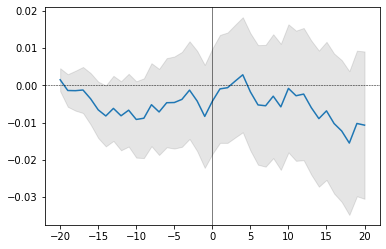

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.001        0.002   0.001         0.002   0.618    0.536
-19 -0.003        0.002  -0.001         0.003  -0.409    0.683
-18 -0.000        0.002  -0.001         0.004  -0.345    0.730
-17  0.000        0.002  -0.001         0.005  -0.261    0.794
-16 -0.002        0.002  -0.004         0.005  -0.671    0.502
-15 -0.003        0.002  -0.007         0.006  -1.116    0.264
-14 -0.002        0.002  -0.008         0.006  -1.290    0.197
-13  0.002        0.002  -0.006         0.007  -0.909    0.363
-12 -0.002        0.002  -0.008         0.007  -1.131    0.258
-11  0.002        0.002  -0.007         0.008  -0.876    0.381
-10 -0.002        0.002  -0.009         0.008  -1.147    0.251
-9   0.000        0.002  -0.009         0.008  -1.058    0.290
-8   0.004        0.002  -0.005         0.009  -0.599    0.549
-7  -0.002        0.002  -0.007         0.009  -0.793    0.428
-6   0.002        0.002  -0.005         0.009  -0.501    0.616
-5   0.000        0.002  -0.005         0.010  -0.479    0.632
-4   0.001        0.002  -0.004         0.010  -0.380    0.704
-3   0.002        0.002  -0.001         0.010  -0.126    0.900
-2  -0.003        0.002  -0.004         0.011  -0.400    0.689
-1  -0.004        0.002  -0.008         0.011  -0.774    0.439
0    0.004        0.002  -0.004         0.011  -0.387    0.699
1    0.003        0.002  -0.001         0.011  -0.085    0.932
2    0.000        0.002  -0.001         0.012  -0.055    0.956
3    0.002        0.002   0.001         0.012   0.095    0.924
4    0.002        0.002   0.003         0.012   0.235    0.814
5   -0.005        0.002  -0.002         0.012  -0.144    0.886
6   -0.003        0.002  -0.005         0.013  -0.420    0.674
7   -0.000        0.002  -0.005         0.013  -0.431    0.667
8    0.003        0.002  -0.003         0.013  -0.225    0.822
9   -0.003        0.002  -0.006         0.013  -0.438    0.661
10   0.005        0.002  -0.001         0.013  -0.061    0.951
11  -0.002        0.002  -0.003         0.014  -0.205    0.837
12   0.000        0.002  -0.002         0.014  -0.170    0.865
13  -0.004        0.002  -0.006         0.014  -0.426    0.670
14  -0.003        0.002  -0.009         0.014  -0.627    0.531
15   0.002        0.002  -0.007         0.014  -0.474    0.635
16  -0.003        0.002   -0.01         0.015  -0.700    0.484
17  -0.002        0.002  -0.012         0.015  -0.826    0.409
18  -0.003        0.002  -0.016         0.015  -1.030    0.303
19   0.005        0.002   -0.01         0.015  -0.672    0.502
20  -0.000        0.002  -0.011         0.015  -0.693    0.488

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.001     0.001    12.042     0.996 -0.126        -0.006         0.002   
-19 -0.001     0.002    31.626     2.790 -0.174        -0.011        -0.002   
-18 -0.001     0.002    17.866     0.460 -0.255        -0.013        -0.002   
-17 -0.001     0.003    30.444     1.134 -0.347        -0.016        -0.001   
-16 -0.004     0.003    17.571    -0.065 -0.330        -0.016        -0.003   
-15 -0.007     0.003    11.098     0.140 -0.289        -0.022        -0.004   
-14 -0.008     0.005    23.972    -2.485 -0.517        -0.030        -0.006   
-13 -0.006     0.004    11.572    -0.196 -0.354        -0.030        -0.006   
-12 -0.008     0.005    10.345    -0.958 -0.402        -0.034        -0.005   
-11 -0.007     0.006    12.044    -0.039 -0.397        -0.035        -0.002   
-10 -0.009     0.006     9.991    -0.730 -0.422        -0.035        -0.008   
-9  -0.009     0.007    10.567    -0.889 -0.427        -0.032        -0.004   
-8  -0.005     0.007    19.584    -1.817 -0.582        -0.029        -0.000   
-7  -0.007     0.008    12.456    -1.246 -0.524        -0.030        -0.003   
-6  -0.005     0.006    11.048    -1.421 -0.458        -0.032         0.001   
-5  -0.005     0.008    23.882    -2.581 -0.678        -0.038        -0.003   
-4  -0.004     0.007    13.005    -1.055 -0.522        -0.031        -0.002   
-3  -0.001     0.008    15.042    -0.961 -0.566        -0.028         0.004   
-2  -0.004     0.009    12.252    -0.488 -0.564        -0.034        -0.006   
-1  -0.008     0.009    12.963    -1.131 -0.594        -0.032        -0.003   
0   -0.004     0.008    11.947    -1.177 -0.552        -0.032        -0.001   
1   -0.001     0.009    10.689    -0.939 -0.548        -0.031         0.003   
2   -0.001     0.008     6.395    -0.283 -0.393        -0.035         0.001   
3    0.001     0.010     9.448     0.621 -0.438        -0.038         0.003   
4    0.003     0.013    15.162     1.620 -0.436        -0.035         0.001   
5   -0.002     0.013    11.967     0.456 -0.466        -0.041         0.000   
6   -0.005     0.015    16.423     1.264 -0.484        -0.046        -0.004   
7   -0.005     0.015    14.576     0.605 -0.560        -0.046        -0.001   
8   -0.003     0.015    13.779     0.417 -0.649        -0.043        -0.003   
9   -0.006     0.013    13.911     0.080 -0.633        -0.044        -0.003   
10  -0.001     0.013    14.920     0.953 -0.477        -0.041        -0.002   
11  -0.003     0.012    12.178     1.021 -0.425        -0.047        -0.001   
12  -0.002     0.013    15.107     1.535 -0.454        -0.045        -0.006   
13  -0.006     0.015    12.040     0.256 -0.516        -0.047        -0.002   
14  -0.009     0.016    13.022    -0.549 -0.636        -0.056        -0.003   
15  -0.007     0.016    14.521    -0.654 -0.680        -0.054         0.003   
16  -0.010     0.019    14.424    -1.398 -0.755        -0.056        -0.002   
17  -0.012     0.023    16.506    -1.669 -0.865        -0.051        -0.004   
18  -0.016     0.023    13.504    -1.607 -0.825        -0.063        -0.006   
19  -0.010     0.020    10.104    -0.433 -0.657        -0.055        -0.006   
20  -0.011     0.021     8.580    -0.228 -0.622        -0.066        -0.007   

     Quantile 75%    Max  
-20         0.009  0.162  
-19         0.006  0.335  
-18         0.011  0.266  
-17         0.014  0.401  
-16         0.014  0.332  
-15         0.014  0.306  
-14         0.012  0.265  
-13         0.014  0.321  
-12         0.016  0.285  
-11         0.018  0.361  
-10         0.017  0.301  
-9          0.018  0.319  
-8          0.022  0.322  
-7          0.023  0.369  
-6          0.020  0.303  
-5          0.025  0.310  
-4          0.023  0.298  
-3          0.021  0.381  
-2          0.021  0.454  
-1          0.021  0.396  
0           0.024  0.358  
1           0.030  0.396  
2           0.031  0.397  
3           0.033  0.560  
4           

GS


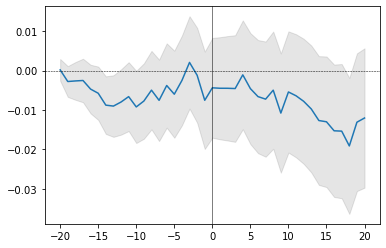

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.000        0.002     0.0         0.002   0.076    0.940
-19 -0.003        0.002  -0.003         0.003  -0.915    0.360
-18  0.000        0.002  -0.003         0.004  -0.707    0.479
-17  0.000        0.002  -0.003         0.004  -0.586    0.558
-16 -0.002        0.002  -0.005         0.005  -0.978    0.328
-15 -0.001        0.002  -0.006         0.005  -1.092    0.275
-14 -0.003        0.002  -0.009         0.006  -1.540    0.123
-13 -0.000        0.002  -0.009         0.006  -1.480    0.139
-12  0.001        0.002  -0.008         0.006  -1.236    0.217
-11  0.001        0.002  -0.007         0.007  -0.971    0.331
-10 -0.003        0.002  -0.009         0.007  -1.292    0.196
-9   0.001        0.002  -0.008         0.007  -1.037    0.300
-8   0.003        0.002  -0.005         0.008  -0.640    0.522
-7  -0.003        0.002  -0.008         0.008  -0.938    0.348
-6   0.004        0.002  -0.004         0.008  -0.455    0.649
-5  -0.002        0.002  -0.006         0.009  -0.697    0.486
-4   0.003        0.002  -0.003         0.009  -0.284    0.776
-3   0.005        0.002   0.002         0.009   0.225    0.822
-2  -0.003        0.002  -0.001         0.009  -0.128    0.898
-1  -0.006        0.002  -0.008         0.010  -0.783    0.434
0    0.003        0.002  -0.004         0.010  -0.444    0.657
1   -0.000        0.002  -0.004         0.010  -0.445    0.656
2   -0.000        0.002  -0.005         0.010  -0.436    0.663
3   -0.000        0.002  -0.005         0.011  -0.433    0.665
4    0.003        0.002  -0.001         0.011  -0.101    0.919
5   -0.004        0.002  -0.005         0.011  -0.418    0.676
6   -0.002        0.002  -0.007         0.011  -0.591    0.555
7   -0.001        0.002  -0.007         0.011  -0.636    0.525
8    0.002        0.002  -0.005         0.012  -0.429    0.668
9   -0.006        0.002  -0.011         0.012  -0.914    0.360
10   0.005        0.002  -0.005         0.012  -0.453    0.650
11  -0.001        0.002  -0.006         0.012  -0.526    0.599
12  -0.001        0.002  -0.008         0.012  -0.631    0.528
13  -0.002        0.002   -0.01         0.013  -0.776    0.438
14  -0.003        0.002  -0.013         0.013  -0.995    0.320
15  -0.000        0.002  -0.013         0.013  -1.006    0.315
16  -0.002        0.002  -0.015         0.013  -1.166    0.244
17  -0.000        0.002  -0.015         0.013  -1.157    0.247
18  -0.004        0.002  -0.019         0.013  -1.422    0.155
19   0.006        0.002  -0.013         0.014  -0.962    0.336
20   0.001        0.002  -0.012         0.014  -0.873    0.383

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.000     0.001     4.659    -0.522 -0.107        -0.009         0.002   
-19 -0.003     0.001     3.160    -0.230 -0.123        -0.015        -0.000   
-18 -0.003     0.001     2.195     0.064 -0.115        -0.017        -0.003   
-17 -0.003     0.002     3.346    -0.491 -0.175        -0.021        -0.004   
-16 -0.005     0.002     3.491    -0.779 -0.206        -0.026        -0.003   
-15 -0.006     0.003     2.571    -0.638 -0.233        -0.027        -0.003   
-14 -0.009     0.004    10.117    -2.139 -0.371        -0.030        -0.001   
-13 -0.009     0.004    15.097    -2.555 -0.450        -0.035        -0.003   
-12 -0.008     0.004     4.521    -1.117 -0.331        -0.036        -0.002   
-11 -0.007     0.005     3.374    -0.344 -0.312        -0.043        -0.005   
-10 -0.009     0.005     2.288    -0.252 -0.281        -0.044        -0.005   
-9  -0.008     0.005     1.873    -0.082 -0.237        -0.045        -0.005   
-8  -0.005     0.007     3.315    -0.572 -0.376        -0.045        -0.002   
-7  -0.008     0.007     5.139    -1.102 -0.459        -0.043        -0.004   
-6  -0.004     0.007     1.477    -0.539 -0.301        -0.051         0.002   
-5  -0.006     0.008     1.527    -0.759 -0.317        -0.044         0.006   
-4  -0.003     0.007     0.975    -0.418 -0.286        -0.050         0.006   
-3   0.002     0.008     1.638    -0.029 -0.233        -0.049         0.005   
-2  -0.001     0.010     1.196    -0.222 -0.271        -0.051         0.007   
-1  -0.008     0.011     0.657    -0.393 -0.300        -0.060         0.005   
0   -0.004     0.012     0.943    -0.624 -0.362        -0.060         0.007   
1   -0.004     0.013     1.057    -0.569 -0.397        -0.061         0.006   
2   -0.005     0.015     2.306    -0.788 -0.470        -0.067         0.004   
3   -0.005     0.016     3.702    -0.904 -0.626        -0.058         0.011   
4   -0.001     0.016     0.669    -0.113 -0.327        -0.067         0.008   
5   -0.005     0.015     0.363    -0.102 -0.322        -0.076         0.008   
6   -0.007     0.016     0.703    -0.213 -0.356        -0.077        -0.005   
7   -0.007     0.018     0.484    -0.128 -0.361        -0.085        -0.004   
8   -0.005     0.019     0.860    -0.177 -0.463        -0.084        -0.004   
9   -0.011     0.021     2.156    -0.577 -0.627        -0.087        -0.002   
10  -0.005     0.019     0.351     0.072 -0.367        -0.086         0.003   
11  -0.006     0.020     0.684    -0.045 -0.479        -0.094         0.004   
12  -0.008     0.021     0.512     0.042 -0.412        -0.097         0.005   
13  -0.010     0.023     0.741    -0.005 -0.464        -0.100        -0.002   
14  -0.013     0.024     1.198    -0.232 -0.529        -0.099        -0.006   
15  -0.013     0.024     1.035    -0.185 -0.526        -0.095        -0.005   
16  -0.015     0.025     1.492    -0.439 -0.637        -0.097        -0.010   
17  -0.015     0.028     2.226    -0.568 -0.703        -0.103        -0.001   
18  -0.019     0.029     2.135    -0.666 -0.646        -0.115        -0.006   
19  -0.013     0.027     0.700    -0.080 -0.524        -0.120         0.008   
20  -0.012     0.026     0.347    -0.111 -0.492        -0.112         0.005   

     Quantile 75%    Max  
-20         0.010  0.070  
-19         0.010  0.107  
-18         0.012  0.113  
-17         0.019  0.143  
-16         0.016  0.160  
-15         0.020  0.171  
-14         0.022  0.142  
-13         0.026  0.126  
-12         0.029  0.164  
-11         0.032  0.192  
-10         0.035  0.242  
-9          0.035  0.263  
-8          0.040  0.264  
-7          0.042  0.223  
-6          0.051  0.235  
-5          0.048  0.223  
-4          0.051  0.244  
-3          0.052  0.355  
-2          0.054  0.349  
-1          0.054  0.286  
0           0.057  0.266  
1           0.069  0.262  
2           0.068  0.278  
3           0.064  0.322  
4           

MS_N


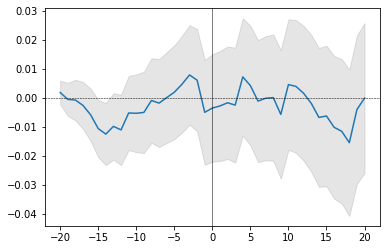

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.002        0.003   0.002         0.003   0.609    0.543
-19 -0.002        0.003    -0.0         0.004  -0.106    0.915
-18 -0.000        0.003  -0.001         0.005  -0.125    0.900
-17 -0.002        0.003  -0.003         0.006  -0.405    0.685
-16 -0.003        0.003  -0.006         0.007  -0.820    0.412
-15 -0.005        0.003  -0.011         0.008  -1.362    0.173
-14 -0.002        0.003  -0.012         0.008  -1.490    0.136
-13  0.003        0.003   -0.01         0.009  -1.095    0.274
-12 -0.001        0.003  -0.011         0.009  -1.161    0.245
-11  0.006        0.003  -0.005         0.010  -0.517    0.605
-10 -0.000        0.003  -0.005         0.010  -0.503    0.615
-9   0.000        0.003  -0.005         0.011  -0.455    0.649
-8   0.004        0.003  -0.001         0.011  -0.074    0.941
-7  -0.001        0.003  -0.002         0.012  -0.148    0.882
-6   0.002        0.003     0.0         0.012   0.012    0.991
-5   0.002        0.003   0.002         0.013   0.157    0.875
-4   0.003        0.003   0.005         0.013   0.364    0.716
-3   0.003        0.003   0.008         0.013   0.594    0.552
-2  -0.002        0.003   0.006         0.014   0.447    0.655
-1  -0.011        0.003  -0.005         0.014  -0.350    0.727
0    0.001        0.003  -0.003         0.014  -0.239    0.811
1    0.001        0.003  -0.003         0.015  -0.185    0.853
2    0.001        0.003  -0.002         0.015  -0.108    0.914
3   -0.001        0.003  -0.002         0.015  -0.158    0.874
4    0.010        0.003   0.007         0.016   0.462    0.644
5   -0.003        0.003   0.004         0.016   0.266    0.790
6   -0.005        0.003  -0.001         0.016  -0.065    0.948
7    0.001        0.003    -0.0         0.017  -0.005    0.996
8    0.000        0.003     0.0         0.017   0.009    0.993
9   -0.006        0.003  -0.006         0.017  -0.327    0.744
10   0.010        0.003   0.005         0.018   0.264    0.792
11  -0.001        0.003   0.004         0.018   0.223    0.823
12  -0.002        0.003   0.002         0.018   0.089    0.929
13  -0.003        0.003  -0.002         0.018  -0.099    0.921
14  -0.005        0.003  -0.007         0.019  -0.358    0.720
15   0.000        0.003  -0.006         0.019  -0.327    0.743
16  -0.004        0.003   -0.01         0.019  -0.526    0.599
17  -0.001        0.003  -0.011         0.019  -0.590    0.555
18  -0.004        0.003  -0.015         0.020  -0.781    0.435
19   0.011        0.003  -0.004         0.020  -0.199    0.842
20   0.004        0.003    -0.0         0.020  -0.002    0.998

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.002     0.001     7.033     0.698 -0.130        -0.010        -0.001   
-19 -0.000     0.002     7.247     1.065 -0.153        -0.015        -0.003   
-18 -0.001     0.002     7.449     0.889 -0.190        -0.021        -0.003   
-17 -0.003     0.003     4.171     0.488 -0.167        -0.020        -0.001   
-16 -0.006     0.004     4.734    -0.198 -0.263        -0.026        -0.003   
-15 -0.011     0.005     7.341    -1.077 -0.378        -0.035        -0.003   
-14 -0.012     0.008    16.730    -2.412 -0.618        -0.043        -0.009   
-13 -0.010     0.009    16.431    -2.732 -0.602        -0.035        -0.004   
-12 -0.011     0.010    20.422    -3.006 -0.725        -0.043        -0.005   
-11 -0.005     0.007     4.147    -0.278 -0.395        -0.053        -0.002   
-10 -0.005     0.009     4.842     0.675 -0.366        -0.063        -0.002   
-9  -0.005     0.010     5.594    -0.601 -0.472        -0.055        -0.001   
-8  -0.001     0.013     7.708    -0.880 -0.611        -0.051        -0.003   
-7  -0.002     0.014     7.133    -0.991 -0.605        -0.050         0.001   
-6   0.000     0.014     7.429    -0.777 -0.618        -0.049        -0.003   
-5   0.002     0.013     5.377    -0.370 -0.522        -0.044        -0.002   
-4   0.005     0.012     4.540    -0.286 -0.481        -0.050         0.002   
-3   0.008     0.016     7.114    -0.070 -0.547        -0.050         0.001   
-2   0.006     0.016     5.394     0.122 -0.509        -0.044        -0.006   
-1  -0.005     0.016     4.374    -0.380 -0.542        -0.064        -0.009   
0   -0.003     0.019     9.234    -1.700 -0.783        -0.063        -0.008   
1   -0.003     0.023     8.214    -1.403 -0.816        -0.051        -0.004   
2   -0.002     0.028    13.635    -2.068 -1.079        -0.064         0.002   
3   -0.002     0.033    20.805    -2.841 -1.329        -0.073         0.002   
4    0.007     0.020     1.765     0.250 -0.484        -0.082        -0.002   
5    0.004     0.020     1.889     0.305 -0.515        -0.081         0.001   
6   -0.001     0.024     4.233    -0.640 -0.755        -0.086         0.003   
7   -0.000     0.025     4.995    -0.377 -0.784        -0.077         0.002   
8    0.000     0.030     9.299    -1.249 -1.042        -0.096         0.010   
9   -0.006     0.037    15.914    -2.192 -1.308        -0.095         0.008   
10   0.005     0.023     1.657     0.536 -0.447        -0.092         0.000   
11   0.004     0.024     2.564     0.888 -0.394        -0.093         0.005   
12   0.002     0.025     1.756     0.462 -0.454        -0.096        -0.003   
13  -0.002     0.026     2.374     0.550 -0.474        -0.091        -0.002   
14  -0.007     0.028     3.118     0.151 -0.654        -0.097        -0.011   
15  -0.006     0.029     3.782     0.118 -0.693        -0.093        -0.009   
16  -0.010     0.028     4.017    -0.076 -0.729        -0.102        -0.014   
17  -0.011     0.033     6.771    -0.740 -0.992        -0.107        -0.022   
18  -0.015     0.037    12.690    -1.650 -1.255        -0.102        -0.015   
19  -0.004     0.027     1.123     0.524 -0.422        -0.122        -0.009   
20  -0.000     0.027     0.994     0.149 -0.599        -0.117         0.004   

     Quantile 75%    Max  
-20         0.012  0.148  
-19         0.016  0.215  
-18         0.019  0.245  
-17         0.016  0.206  
-16         0.021  0.255  
-15         0.022  0.263  
-14         0.021  0.311  
-13         0.025  0.253  
-12         0.027  0.260  
-11         0.034  0.249  
-10         0.031  0.398  
-9          0.040  0.371  
-8          0.050  0.381  
-7          0.050  0.414  
-6          0.055  0.427  
-5          0.046  0.380  
-4          0.051  0.405  
-3          0.044  0.598  
-2          0.052  0.587  
-1          0.050  0.485  
0           0.057  0.384  
1           0.056  0.439  
2           0.058  0.458  
3           0.060  0.441  
4           

HSBA_L


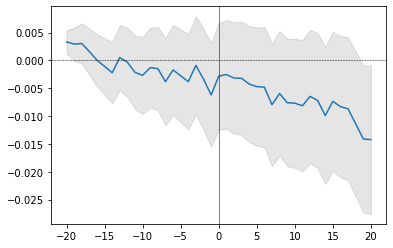

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-20  0.003        0.002  0.003 **         0.002   2.046    0.041
-19 -0.000        0.002     0.003         0.002   1.272    0.203
-18  0.000        0.002     0.003         0.003   1.078    0.281
-17 -0.001        0.002     0.002         0.003   0.487    0.626
-16 -0.002        0.002       0.0         0.004   0.008    0.994
-15 -0.001        0.002    -0.001         0.004  -0.269    0.788
-14 -0.001        0.002    -0.002         0.004  -0.515    0.606
-13  0.003        0.002     0.001         0.005   0.110    0.912
-12 -0.001        0.002      -0.0         0.005  -0.069    0.945
-11 -0.002        0.002    -0.002         0.005  -0.420    0.674
-10 -0.001        0.002    -0.003         0.005  -0.496    0.620
-9   0.001        0.002    -0.001         0.006  -0.231    0.818
-8  -0.000        0.002    -0.001         0.006  -0.251    0.801
-7  -0.002        0.002    -0.004         0.006  -0.628    0.530
-6   0.002        0.002    -0.002         0.006  -0.273    0.785
-5  -0.001        0.002    -0.003         0.007  -0.425    0.671
-4  -0.001        0.002    -0.004         0.007  -0.570    0.569
-3   0.003        0.002    -0.001         0.007  -0.132    0.895
-2  -0.002        0.002    -0.003         0.007  -0.474    0.636
-1  -0.003        0.002    -0.006         0.007  -0.854    0.393
0    0.003        0.002    -0.003         0.007  -0.382    0.702
1    0.000        0.002    -0.003         0.008  -0.333    0.739
2   -0.001        0.002    -0.003         0.008  -0.406    0.684
3   -0.000        0.002    -0.003         0.008  -0.404    0.686
4   -0.001        0.002    -0.004         0.008  -0.523    0.601
5   -0.000        0.002    -0.005         0.008  -0.568    0.570
6   -0.000        0.002    -0.005         0.008  -0.569    0.569
7   -0.003        0.002    -0.008         0.009  -0.924    0.355
8    0.002        0.002    -0.006         0.009  -0.678    0.498
9   -0.002        0.002    -0.008         0.009  -0.853    0.394
10  -0.000        0.002    -0.008         0.009  -0.849    0.396
11  -0.000        0.002    -0.008         0.009  -0.886    0.376
12   0.002        0.002    -0.006         0.009  -0.692    0.489
13  -0.001        0.002    -0.007         0.009  -0.759    0.448
14  -0.003        0.002     -0.01         0.010  -1.029    0.303
15   0.003        0.002    -0.007         0.010  -0.754    0.451
16  -0.001        0.002    -0.008         0.010  -0.840    0.401
17  -0.000        0.002    -0.009         0.010  -0.868    0.386
18  -0.003        0.002    -0.011         0.010  -1.122    0.262
19  -0.003        0.002    -0.014         0.010  -1.373    0.170
20  -0.000        0.002    -0.014         0.010  -1.367    0.172

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.003     0.000     7.728     0.764 -0.073        -0.006         0.001   
-19  0.003     0.001    12.576     1.829 -0.077        -0.009         0.001   
-18  0.003     0.001    13.466     2.197 -0.064        -0.012         0.001   
-17  0.002     0.001    14.698     2.122 -0.115        -0.020         0.002   
-16  0.000     0.002     8.464     1.103 -0.180        -0.019        -0.004   
-15 -0.001     0.002     6.350     0.211 -0.196        -0.022        -0.002   
-14 -0.002     0.003    12.270    -1.315 -0.339        -0.025        -0.003   
-13  0.001     0.003     7.441    -0.496 -0.272        -0.022        -0.001   
-12 -0.000     0.003     5.241    -0.424 -0.257        -0.020         0.000   
-11 -0.002     0.004     7.617    -0.016 -0.281        -0.030        -0.003   
-10 -0.003     0.004     8.944     0.785 -0.262        -0.030        -0.002   
-9  -0.001     0.004     7.213     0.841 -0.241        -0.029        -0.003   
-8  -0.001     0.005     7.696     0.777 -0.302        -0.036        -0.005   
-7  -0.004     0.005     8.064     0.387 -0.349        -0.037        -0.002   
-6  -0.002     0.006     8.389    -0.241 -0.401        -0.036        -0.002   
-5  -0.003     0.006     4.444     0.309 -0.261        -0.039        -0.001   
-4  -0.004     0.006     4.505     0.373 -0.312        -0.035        -0.003   
-3  -0.001     0.007     4.693     0.907 -0.270        -0.038        -0.005   
-2  -0.003     0.008     4.253     0.603 -0.310        -0.045        -0.002   
-1  -0.006     0.008     4.952     0.133 -0.382        -0.046        -0.007   
0   -0.003     0.007     4.085     0.155 -0.324        -0.050        -0.005   
1   -0.003     0.008     5.800    -0.140 -0.448        -0.047        -0.005   
2   -0.003     0.008     4.462     0.385 -0.385        -0.048        -0.006   
3   -0.003     0.009     5.519     0.796 -0.370        -0.059        -0.007   
4   -0.004     0.009     7.616     0.937 -0.396        -0.050        -0.004   
5   -0.005     0.010     8.526     1.460 -0.334        -0.055        -0.009   
6   -0.005     0.011     9.541     1.657 -0.340        -0.057        -0.004   
7   -0.008     0.011     8.999     1.732 -0.244        -0.058        -0.007   
8   -0.006     0.011     8.083     1.509 -0.283        -0.049        -0.010   
9   -0.008     0.011     6.052     1.215 -0.283        -0.054        -0.009   
10  -0.008     0.011     6.415     1.057 -0.325        -0.051        -0.010   
11  -0.008     0.011     5.319     0.848 -0.345        -0.053        -0.011   
12  -0.006     0.012     6.559     1.217 -0.350        -0.056        -0.011   
13  -0.007     0.013     7.396     1.204 -0.326        -0.058        -0.008   
14  -0.010     0.015     6.956     0.726 -0.428        -0.061        -0.008   
15  -0.007     0.014     6.436     0.688 -0.438        -0.060        -0.003   
16  -0.008     0.014     6.484     0.598 -0.432        -0.065        -0.006   
17  -0.009     0.016     6.430     0.372 -0.475        -0.064        -0.006   
18  -0.011     0.017     6.223     0.367 -0.523        -0.063        -0.011   
19  -0.014     0.018     6.071     0.298 -0.574        -0.065        -0.010   
20  -0.014     0.018     5.807     0.684 -0.435        -0.067        -0.011   

     Quantile 75%    Max  
-20         0.013  0.100  
-19         0.011  0.160  
-18         0.015  0.193  
-17         0.015  0.248  
-16         0.016  0.239  
-15         0.019  0.229  
-14         0.020  0.191  
-13         0.022  0.206  
-12         0.025  0.189  
-11         0.027  0.276  
-10         0.025  0.301  
-9          0.029  0.307  
-8          0.030  0.339  
-7          0.024  0.335  
-6          0.028  0.274  
-5          0.026  0.298  
-4          0.026  0.301  
-3          0.033  0.339  
-2          0.034  0.344  
-1          0.034  0.320  
0           0.040  0.292  
1           0.042  0.333  
2           0.039  0.366  
3           0.043  0.463  
4           

BNPP_PA


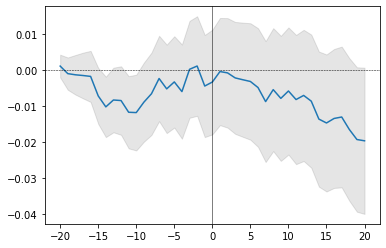

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.001        0.002   0.001         0.002   0.453    0.651
-19 -0.002        0.002  -0.001         0.003  -0.279    0.780
-18 -0.000        0.002  -0.001         0.004  -0.304    0.761
-17 -0.000        0.002  -0.001         0.005  -0.303    0.762
-16 -0.000        0.002  -0.002         0.006  -0.316    0.752
-15 -0.005        0.002  -0.007         0.006  -1.182    0.237
-14 -0.003        0.002   -0.01         0.007  -1.560    0.119
-13  0.002        0.002  -0.008         0.007  -1.186    0.236
-12 -0.000        0.002  -0.008         0.007  -1.139    0.255
-11 -0.003        0.002  -0.012         0.008  -1.496    0.135
-10 -0.000        0.002  -0.012         0.008  -1.437    0.151
-9   0.003        0.002  -0.009         0.009  -1.039    0.299
-8   0.002        0.002  -0.007         0.009  -0.736    0.462
-7   0.004        0.002  -0.002         0.009  -0.252    0.801
-6  -0.003        0.002  -0.005         0.010  -0.543    0.587
-5   0.002        0.002  -0.003         0.010  -0.331    0.741
-4  -0.003        0.002  -0.006         0.010  -0.585    0.558
-3   0.006        0.002     0.0         0.010   0.021    0.984
-2   0.001        0.002   0.001         0.011   0.105    0.916
-1  -0.006        0.002  -0.004         0.011  -0.400    0.689
0    0.001        0.002  -0.003         0.011  -0.292    0.770
1    0.003        0.002    -0.0         0.012  -0.034    0.973
2   -0.000        0.002  -0.001         0.012  -0.065    0.948
3   -0.001        0.002  -0.002         0.012  -0.179    0.858
4   -0.001        0.002  -0.003         0.012  -0.216    0.829
5   -0.000        0.002  -0.003         0.013  -0.250    0.802
6   -0.002        0.002  -0.005         0.013  -0.376    0.707
7   -0.004        0.002  -0.009         0.013  -0.668    0.504
8    0.003        0.002  -0.005         0.013  -0.407    0.684
9   -0.002        0.002  -0.008         0.014  -0.579    0.563
10   0.002        0.002  -0.006         0.014  -0.421    0.674
11  -0.002        0.002  -0.008         0.014  -0.584    0.559
12   0.001        0.002  -0.007         0.014  -0.495    0.621
13  -0.002        0.002  -0.009         0.014  -0.598    0.550
14  -0.005        0.002  -0.014         0.015  -0.929    0.353
15  -0.001        0.002  -0.015         0.015  -0.989    0.323
16   0.001        0.002  -0.013         0.015  -0.892    0.372
17   0.000        0.002  -0.013         0.015  -0.854    0.393
18  -0.003        0.002  -0.016         0.015  -1.066    0.286
19  -0.003        0.002  -0.019         0.016  -1.232    0.218
20  -0.000        0.002   -0.02         0.016  -1.239    0.215

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.001     0.001     2.187    -0.477 -0.105        -0.013         0.003   
-19 -0.001     0.001     2.971    -0.052 -0.132        -0.016        -0.004   
-18 -0.001     0.002     5.415    -0.186 -0.212        -0.020        -0.004   
-17 -0.001     0.003     4.479    -0.670 -0.232        -0.024        -0.004   
-16 -0.002     0.004     3.132    -0.277 -0.250        -0.029        -0.004   
-15 -0.007     0.005     4.500    -0.820 -0.348        -0.040        -0.004   
-14 -0.010     0.006     7.178    -1.211 -0.399        -0.041        -0.008   
-13 -0.008     0.006     6.600    -1.422 -0.376        -0.042        -0.006   
-12 -0.008     0.007     5.572    -1.387 -0.409        -0.045         0.001   
-11 -0.012     0.007     7.669    -1.629 -0.484        -0.054        -0.003   
-10 -0.012     0.007     2.182    -0.412 -0.296        -0.050        -0.011   
-9  -0.009     0.007     2.094    -0.413 -0.319        -0.046        -0.010   
-8  -0.007     0.006     1.306     0.072 -0.254        -0.052        -0.003   
-7  -0.002     0.007     1.868     0.380 -0.214        -0.052        -0.000   
-6  -0.005     0.008     1.873    -0.147 -0.323        -0.052        -0.006   
-5  -0.003     0.007     1.595    -0.251 -0.265        -0.047        -0.000   
-4  -0.006     0.009     1.208    -0.216 -0.289        -0.057         0.002   
-3   0.000     0.011     2.169     0.166 -0.281        -0.054        -0.002   
-2   0.001     0.013     2.142    -0.075 -0.359        -0.051         0.003   
-1  -0.004     0.013     1.848    -0.223 -0.388        -0.052        -0.011   
0   -0.003     0.013     2.487    -0.552 -0.409        -0.049        -0.005   
1   -0.000     0.015     5.087    -0.910 -0.613        -0.056         0.004   
2   -0.001     0.017     4.580    -0.678 -0.593        -0.057         0.007   
3   -0.002     0.018     4.097    -0.532 -0.628        -0.065         0.005   
4   -0.003     0.020     5.362    -0.443 -0.705        -0.063         0.004   
5   -0.003     0.018     3.090     0.089 -0.519        -0.067         0.004   
6   -0.005     0.019     3.215     0.191 -0.520        -0.071        -0.002   
7   -0.009     0.020     2.724     0.367 -0.423        -0.074        -0.005   
8   -0.005     0.021     2.231     0.367 -0.421        -0.085        -0.000   
9   -0.008     0.020     1.137     0.121 -0.383        -0.090        -0.005   
10  -0.006     0.021     1.624     0.005 -0.422        -0.077        -0.000   
11  -0.008     0.021     1.884     0.016 -0.465        -0.081        -0.000   
12  -0.007     0.023     2.808     0.397 -0.416        -0.088         0.000   
13  -0.009     0.024     2.710     0.308 -0.456        -0.098        -0.003   
14  -0.014     0.025     2.473     0.122 -0.512        -0.096        -0.006   
15  -0.015     0.026     2.654    -0.005 -0.564        -0.094        -0.013   
16  -0.013     0.027     4.022    -0.110 -0.702        -0.087        -0.011   
17  -0.013     0.028     4.041    -0.097 -0.719        -0.087        -0.015   
18  -0.016     0.032     3.662    -0.015 -0.719        -0.084        -0.018   
19  -0.019     0.031     2.982     0.238 -0.579        -0.107        -0.014   
20  -0.020     0.033     3.483     0.239 -0.550        -0.108        -0.012   

     Quantile 75%    Max  
-20         0.016  0.065  
-19         0.020  0.150  
-18         0.020  0.169  
-17         0.024  0.200  
-16         0.032  0.205  
-15         0.034  0.225  
-14         0.037  0.304  
-13         0.037  0.242  
-12         0.036  0.214  
-11         0.035  0.220  
-10         0.042  0.253  
-9          0.044  0.240  
-8          0.037  0.272  
-7          0.047  0.317  
-6          0.049  0.280  
-5          0.046  0.284  
-4          0.048  0.299  
-3          0.056  0.391  
-2          0.063  0.417  
-1          0.052  0.320  
0           0.054  0.303  
1           0.064  0.353  
2           0.065  0.384  
3           0.068  0.443  
4           

CAGR_PA


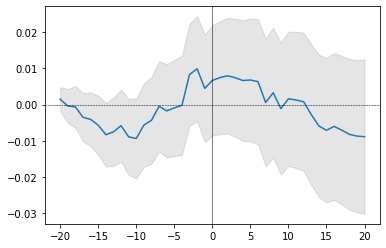

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.002        0.003   0.002         0.003   0.581    0.561
-19 -0.002        0.003    -0.0         0.004  -0.103    0.918
-18 -0.000        0.003  -0.001         0.005  -0.141    0.888
-17 -0.003        0.003  -0.004         0.005  -0.674    0.500
-16 -0.001        0.003  -0.004         0.006  -0.702    0.482
-15 -0.002        0.003  -0.006         0.006  -0.893    0.372
-14 -0.003        0.003  -0.008         0.007  -1.206    0.228
-13  0.001        0.003  -0.008         0.007  -1.027    0.304
-12  0.002        0.003  -0.006         0.008  -0.746    0.456
-11 -0.003        0.003  -0.009         0.008  -1.084    0.278
-10 -0.000        0.003  -0.009         0.009  -1.085    0.278
-9   0.004        0.003  -0.006         0.009  -0.630    0.529
-8   0.001        0.003  -0.004         0.009  -0.462    0.644
-7   0.004        0.003    -0.0         0.010  -0.047    0.963
-6  -0.001        0.003  -0.002         0.010  -0.171    0.864
-5   0.001        0.003  -0.001         0.010  -0.087    0.930
-4   0.001        0.003    -0.0         0.011  -0.019    0.985
-3   0.008        0.003   0.008         0.011   0.752    0.452
-2   0.002        0.003    0.01         0.011   0.873    0.382
-1  -0.005        0.003   0.004         0.012   0.386    0.699
0    0.002        0.003   0.007         0.012   0.560    0.576
1    0.001        0.003   0.007         0.012   0.612    0.541
2    0.000        0.003   0.008         0.012   0.638    0.523
3   -0.001        0.003   0.007         0.013   0.583    0.560
4   -0.001        0.003   0.007         0.013   0.512    0.609
5    0.000        0.003   0.007         0.013   0.513    0.608
6   -0.000        0.003   0.006         0.014   0.470    0.638
7   -0.006        0.003   0.001         0.014   0.042    0.966
8    0.003        0.003   0.003         0.014   0.235    0.814
9   -0.004        0.003  -0.001         0.014  -0.078    0.938
10   0.003        0.003   0.002         0.014   0.110    0.912
11  -0.000        0.003   0.001         0.015   0.087    0.930
12  -0.001        0.003   0.001         0.015   0.052    0.958
13  -0.004        0.003  -0.003         0.015  -0.182    0.855
14  -0.003        0.003  -0.006         0.015  -0.384    0.701
15  -0.001        0.003  -0.007         0.016  -0.455    0.649
16   0.001        0.003  -0.006         0.016  -0.381    0.704
17  -0.001        0.003  -0.007         0.016  -0.440    0.660
18  -0.001        0.003  -0.008         0.016  -0.506    0.613
19  -0.000        0.003  -0.009         0.016  -0.529    0.597
20  -0.000        0.003  -0.009         0.017  -0.533    0.594

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.002     0.001     1.258     0.357 -0.067        -0.014         0.004   
-19 -0.000     0.002     1.288    -0.178 -0.148        -0.019        -0.002   
-18 -0.001     0.002     3.511    -0.369 -0.202        -0.025         0.002   
-17 -0.004     0.003     2.962    -0.244 -0.200        -0.030        -0.004   
-16 -0.004     0.003     2.084    -0.575 -0.232        -0.028        -0.004   
-15 -0.006     0.004     2.889    -0.850 -0.280        -0.031        -0.000   
-14 -0.008     0.004     1.583    -0.457 -0.207        -0.040        -0.006   
-13 -0.008     0.005     0.471    -0.399 -0.221        -0.050        -0.010   
-12 -0.006     0.005    -0.003    -0.349 -0.198        -0.046        -0.003   
-11 -0.009     0.006     0.226    -0.345 -0.231        -0.061        -0.004   
-10 -0.009     0.007     1.012    -0.401 -0.270        -0.058        -0.010   
-9  -0.006     0.007     0.315    -0.203 -0.240        -0.060        -0.010   
-8  -0.004     0.008     0.419    -0.089 -0.252        -0.057        -0.007   
-7  -0.000     0.009     0.874    -0.200 -0.296        -0.059         0.007   
-6  -0.002     0.009     1.062    -0.610 -0.304        -0.050        -0.002   
-5  -0.001     0.008     0.396    -0.275 -0.277        -0.049        -0.004   
-4  -0.000     0.010     0.915    -0.226 -0.328        -0.056         0.003   
-3   0.008     0.012     2.272     0.178 -0.356        -0.052        -0.010   
-2   0.010     0.014     2.233     0.202 -0.378        -0.058        -0.007   
-1   0.004     0.016     1.578    -0.132 -0.383        -0.062         0.002   
0    0.007     0.015     1.775     0.033 -0.364        -0.065         0.003   
1    0.007     0.017     1.372    -0.039 -0.388        -0.060         0.009   
2    0.008     0.018     2.040    -0.004 -0.480        -0.067         0.016   
3    0.007     0.020     1.555     0.025 -0.424        -0.067         0.006   
4    0.007     0.021     1.408     0.027 -0.383        -0.072         0.008   
5    0.007     0.021     1.496     0.023 -0.440        -0.071         0.007   
6    0.006     0.022     1.334     0.092 -0.414        -0.071         0.002   
7    0.001     0.024     1.653    -0.091 -0.541        -0.091         0.003   
8    0.003     0.025     0.927    -0.021 -0.492        -0.090         0.004   
9   -0.001     0.025     0.596    -0.034 -0.475        -0.086        -0.002   
10   0.002     0.024     0.327     0.008 -0.431        -0.082         0.006   
11   0.001     0.025     0.443     0.037 -0.427        -0.083         0.006   
12   0.001     0.028     0.438     0.052 -0.435        -0.091         0.007   
13  -0.003     0.031     0.604     0.029 -0.508        -0.100         0.006   
14  -0.006     0.031     0.617    -0.030 -0.520        -0.100         0.005   
15  -0.007     0.032     0.758    -0.105 -0.541        -0.098         0.004   
16  -0.006     0.033     1.089    -0.094 -0.537        -0.096        -0.011   
17  -0.007     0.034     1.182    -0.073 -0.607        -0.099        -0.017   
18  -0.008     0.036     1.025    -0.084 -0.617        -0.104        -0.016   
19  -0.009     0.036     0.664     0.014 -0.521        -0.109        -0.014   
20  -0.009     0.036     0.754     0.119 -0.536        -0.098        -0.036   

     Quantile 75%    Max  
-20         0.014  0.083  
-19         0.021  0.103  
-18         0.020  0.152  
-17         0.021  0.179  
-16         0.026  0.147  
-15         0.035  0.164  
-14         0.031  0.221  
-13         0.044  0.156  
-12         0.045  0.147  
-11         0.043  0.160  
-10         0.044  0.244  
-9          0.055  0.231  
-8          0.052  0.275  
-7          0.066  0.300  
-6          0.059  0.216  
-5          0.063  0.230  
-4          0.063  0.310  
-3          0.075  0.403  
-2          0.074  0.429  
-1          0.078  0.438  
0           0.082  0.500  
1           0.086  0.475  
2           0.078  0.518  
3           0.081  0.535  
4           

SAN_MC


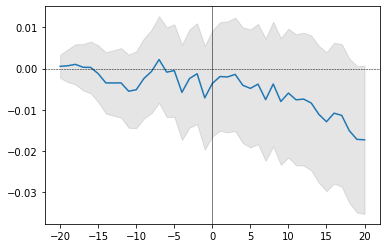

AAR  Std. E. AAR    CAAR  Std. E. CAAR  T-stat  P-value
-20  0.001        0.002   0.001         0.002   0.254    0.800
-19  0.000        0.002   0.001         0.003   0.226    0.821
-18  0.000        0.002   0.001         0.004   0.274    0.784
-17 -0.001        0.002     0.0         0.004   0.078    0.938
-16 -0.000        0.002     0.0         0.005   0.061    0.951
-15 -0.002        0.002  -0.001         0.005  -0.228    0.820
-14 -0.002        0.002  -0.003         0.006  -0.597    0.551
-13 -0.000        0.002  -0.003         0.006  -0.561    0.575
-12  0.000        0.002  -0.003         0.007  -0.525    0.600
-11 -0.002        0.002  -0.005         0.007  -0.790    0.429
-10  0.000        0.002  -0.005         0.007  -0.704    0.481
-9   0.003        0.002  -0.002         0.008  -0.317    0.751
-8   0.002        0.002  -0.001         0.008  -0.087    0.930
-7   0.003        0.002   0.002         0.008   0.269    0.788
-6  -0.003        0.002  -0.001         0.008  -0.100    0.920
-5   0.000        0.002    -0.0         0.009  -0.054    0.957
-4  -0.005        0.002  -0.006         0.009  -0.637    0.524
-3   0.003        0.002  -0.002         0.009  -0.257    0.797
-2   0.001        0.002  -0.001         0.010  -0.130    0.897
-1  -0.006        0.002  -0.007         0.010  -0.723    0.469
0    0.004        0.002  -0.004         0.010  -0.357    0.721
1    0.002        0.002  -0.002         0.010  -0.187    0.852
2   -0.000        0.002  -0.002         0.011  -0.191    0.848
3    0.001        0.002  -0.001         0.011  -0.130    0.897
4   -0.003        0.002  -0.004         0.011  -0.368    0.713
5   -0.001        0.002  -0.005         0.011  -0.429    0.668
6    0.001        0.002  -0.004         0.011  -0.330    0.741
7   -0.004        0.002  -0.008         0.012  -0.648    0.517
8    0.004        0.002  -0.004         0.012  -0.316    0.752
9   -0.004        0.002  -0.008         0.012  -0.664    0.507
10   0.002        0.002  -0.006         0.012  -0.486    0.627
11  -0.002        0.002  -0.008         0.012  -0.610    0.542
12   0.000        0.002  -0.007         0.013  -0.587    0.557
13  -0.001        0.002  -0.008         0.013  -0.654    0.513
14  -0.003        0.002  -0.011         0.013  -0.856    0.392
15  -0.002        0.002  -0.013         0.013  -0.980    0.327
16   0.002        0.002  -0.011         0.013  -0.811    0.418
17  -0.001        0.002  -0.011         0.014  -0.839    0.401
18  -0.004        0.002  -0.015         0.014  -1.101    0.271
19  -0.002        0.002  -0.017         0.014  -1.238    0.216
20  -0.000        0.002  -0.017         0.014  -1.231    0.218

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.001     0.001     4.525    -1.070 -0.117        -0.011         0.002   
-19  0.001     0.001     2.343    -0.832 -0.124        -0.013         0.001   
-18  0.001     0.001     1.580    -0.519 -0.123        -0.018         0.003   
-17  0.000     0.002     3.318    -0.971 -0.197        -0.019         0.002   
-16  0.000     0.003     2.668    -0.793 -0.231        -0.022         0.003   
-15 -0.001     0.003     1.868    -0.701 -0.231        -0.030         0.002   
-14 -0.003     0.004     2.550    -0.830 -0.280        -0.034         0.002   
-13 -0.003     0.004     1.424    -0.561 -0.265        -0.043         0.001   
-12 -0.003     0.005     1.815    -0.612 -0.270        -0.040         0.005   
-11 -0.005     0.006     1.723    -0.487 -0.268        -0.046         0.004   
-10 -0.005     0.006     1.047    -0.190 -0.221        -0.044         0.003   
-9  -0.002     0.006     0.237     0.007 -0.183        -0.044         0.002   
-8  -0.001     0.007     1.132    -0.036 -0.260        -0.042         0.003   
-7   0.002     0.008     1.282    -0.052 -0.278        -0.035         0.002   
-6  -0.001     0.007     1.469    -0.350 -0.309        -0.034         0.000   
-5  -0.000     0.008     0.848    -0.268 -0.270        -0.038         0.000   
-4  -0.006     0.009     0.944    -0.198 -0.303        -0.051        -0.005   
-3  -0.002     0.010     1.208    -0.187 -0.354        -0.053        -0.001   
-2  -0.001     0.012     2.888    -0.448 -0.482        -0.048        -0.004   
-1  -0.007     0.012     3.691    -0.680 -0.533        -0.052        -0.010   
0   -0.004     0.012     3.998    -0.640 -0.545        -0.057        -0.003   
1   -0.002     0.013     1.206     0.031 -0.380        -0.056         0.001   
2   -0.002     0.013     1.203     0.263 -0.345        -0.069        -0.006   
3   -0.001     0.013     0.658     0.230 -0.289        -0.075        -0.006   
4   -0.004     0.014     0.684     0.229 -0.307        -0.077        -0.004   
5   -0.005     0.015     0.659     0.266 -0.281        -0.082        -0.007   
6   -0.004     0.016     1.160     0.366 -0.328        -0.081         0.001   
7   -0.008     0.018     0.918     0.132 -0.359        -0.091        -0.004   
8   -0.004     0.018     0.797     0.278 -0.333        -0.093        -0.008   
9   -0.008     0.019     0.312     0.141 -0.360        -0.095        -0.013   
10  -0.006     0.019     0.584     0.075 -0.446        -0.095        -0.011   
11  -0.008     0.020     1.007    -0.181 -0.533        -0.090        -0.012   
12  -0.007     0.022     0.793    -0.023 -0.456        -0.101        -0.005   
13  -0.008     0.024     1.457    -0.208 -0.570        -0.106        -0.013   
14  -0.011     0.026     2.123    -0.344 -0.622        -0.097        -0.012   
15  -0.013     0.027     2.016    -0.365 -0.635        -0.107        -0.012   
16  -0.011     0.027     2.486    -0.270 -0.704        -0.106        -0.012   
17  -0.011     0.030     2.770    -0.393 -0.774        -0.118        -0.011   
18  -0.015     0.033     2.057    -0.298 -0.759        -0.116        -0.010   
19  -0.017     0.033     1.384    -0.166 -0.616        -0.125        -0.007   
20  -0.017     0.033     1.459    -0.024 -0.597        -0.120        -0.035   

     Quantile 75%    Max  
-20         0.013  0.049  
-19         0.020  0.074  
-18         0.021  0.099  
-17         0.023  0.116  
-16         0.030  0.119  
-15         0.032  0.131  
-14         0.030  0.154  
-13         0.034  0.129  
-12         0.033  0.164  
-11         0.039  0.236  
-10         0.041  0.258  
-9          0.045  0.239  
-8          0.047  0.285  
-7          0.051  0.316  
-6          0.051  0.242  
-5          0.050  0.243  
-4          0.053  0.300  
-3          0.050  0.282  
-2          0.050  0.334  
-1          0.046  0.301  
0           0.058  0.307  
1           0.065  0.394  
2           0.067  0.436  
3           0.072  0.418  
4           

SOGN_PA


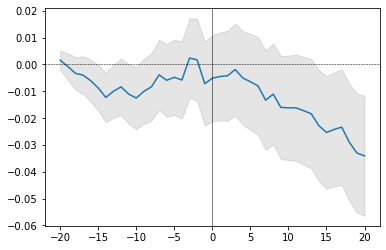

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-20  0.002        0.003     0.002         0.003   0.587    0.557
-19 -0.002        0.003    -0.001         0.004  -0.192    0.848
-18 -0.003        0.003    -0.003         0.005  -0.698    0.485
-17 -0.001        0.003    -0.004         0.005  -0.731    0.465
-16 -0.002        0.003    -0.006         0.006  -0.986    0.324
-15 -0.003        0.003    -0.009         0.007  -1.309    0.190
-14 -0.004        0.003  -0.012 *         0.007  -1.702    0.089
-13  0.002        0.003     -0.01         0.008  -1.296    0.195
-12  0.002        0.003    -0.008         0.008  -1.019    0.308
-11 -0.003        0.003    -0.011         0.009  -1.280    0.201
-10 -0.001        0.003    -0.013         0.009  -1.382    0.167
-9   0.002        0.003     -0.01         0.009  -1.061    0.289
-8   0.002        0.003    -0.008         0.010  -0.845    0.398
-7   0.004        0.003    -0.004         0.010  -0.379    0.705
-6  -0.002        0.003    -0.006         0.011  -0.558    0.577
-5   0.001        0.003    -0.005         0.011  -0.438    0.662
-4  -0.001        0.003    -0.006         0.011  -0.516    0.606
-3   0.008        0.003     0.002         0.012   0.206    0.837
-2  -0.001        0.003     0.002         0.012   0.145    0.884
-1  -0.009        0.003    -0.007         0.012  -0.588    0.557
0    0.002        0.003    -0.005         0.013  -0.409    0.682
1    0.001        0.003    -0.004         0.013  -0.350    0.726
2    0.000        0.003    -0.004         0.013  -0.322    0.748
3    0.002        0.003    -0.002         0.013  -0.141    0.888
4   -0.003        0.003    -0.005         0.014  -0.368    0.713
5   -0.001        0.003    -0.006         0.014  -0.463    0.644
6   -0.002        0.003    -0.008         0.014  -0.563    0.573
7   -0.005        0.003    -0.013         0.014  -0.922    0.357
8    0.002        0.003    -0.011         0.015  -0.752    0.452
9   -0.005        0.003    -0.016         0.015  -1.071    0.284
10  -0.000        0.003    -0.016         0.015  -1.063    0.288
11   0.000        0.003    -0.016         0.015  -1.047    0.295
12  -0.001        0.003    -0.017         0.016  -1.098    0.272
13  -0.001        0.003    -0.018         0.016  -1.154    0.248
14  -0.004        0.003    -0.023         0.016  -1.413    0.158
15  -0.003        0.003    -0.025         0.016  -1.548    0.122
16   0.001        0.003    -0.024         0.017  -1.459    0.145
17   0.001        0.003    -0.023         0.017  -1.387    0.165
18  -0.006        0.003  -0.029 *         0.017  -1.701    0.089
19  -0.004        0.003  -0.033 *         0.017  -1.912    0.056
20  -0.001        0.003  -0.034 *         0.017  -1.948    0.051

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.002     0.001     7.103    -1.083 -0.162        -0.012         0.002   
-19 -0.001     0.002     2.830    -0.073 -0.146        -0.016        -0.002   
-18 -0.003     0.002     8.730    -1.188 -0.269        -0.028        -0.002   
-17 -0.004     0.003     4.559    -1.091 -0.256        -0.025        -0.004   
-16 -0.006     0.003     1.516    -0.320 -0.199        -0.033        -0.010   
-15 -0.009     0.005     2.979    -0.560 -0.289        -0.040        -0.004   
-14 -0.012     0.006     5.936    -0.941 -0.407        -0.046        -0.009   
-13 -0.010     0.005     1.541    -0.355 -0.288        -0.054        -0.011   
-12 -0.008     0.006     0.686    -0.319 -0.252        -0.057        -0.009   
-11 -0.011     0.007     0.913    -0.405 -0.285        -0.055        -0.011   
-10 -0.013     0.007     0.326    -0.242 -0.253        -0.063        -0.011   
-9  -0.010     0.008     0.205    -0.038 -0.249        -0.055        -0.015   
-8  -0.008     0.009     1.078    -0.173 -0.330        -0.064        -0.007   
-7  -0.004     0.010     1.540    -0.221 -0.319        -0.054        -0.010   
-6  -0.006     0.011     2.126    -0.669 -0.367        -0.058        -0.009   
-5  -0.005     0.010     1.483    -0.457 -0.371        -0.054        -0.003   
-4  -0.006     0.011     0.464    -0.265 -0.297        -0.058        -0.000   
-3   0.002     0.014     1.236     0.147 -0.332        -0.060         0.001   
-2   0.002     0.017     1.316     0.081 -0.379        -0.065        -0.000   
-1  -0.007     0.018     2.007    -0.381 -0.546        -0.076        -0.011   
0   -0.005     0.017     3.392    -0.652 -0.634        -0.074        -0.003   
1   -0.004     0.018     1.913    -0.556 -0.533        -0.073        -0.000   
2   -0.004     0.020     1.105    -0.194 -0.436        -0.066        -0.000   
3   -0.002     0.021     0.879    -0.004 -0.416        -0.061         0.000   
4   -0.005     0.023     0.891     0.034 -0.421        -0.074         0.004   
5   -0.006     0.021     1.078    -0.121 -0.506        -0.073        -0.011   
6   -0.008     0.021     1.019    -0.045 -0.464        -0.076        -0.008   
7   -0.013     0.025     1.865    -0.409 -0.619        -0.079        -0.004   
8   -0.011     0.026     1.645    -0.278 -0.587        -0.091         0.007   
9   -0.016     0.025     0.974    -0.230 -0.535        -0.095         0.002   
10  -0.016     0.025     0.878    -0.185 -0.503        -0.112        -0.004   
11  -0.016     0.025     0.934    -0.202 -0.490        -0.116        -0.003   
12  -0.017     0.028     1.110    -0.088 -0.516        -0.115        -0.005   
13  -0.018     0.031     1.205    -0.313 -0.640        -0.135        -0.009   
14  -0.023     0.033     1.677    -0.496 -0.667        -0.117         0.001   
15  -0.025     0.035     1.876    -0.653 -0.685        -0.128        -0.003   
16  -0.024     0.035     1.749    -0.550 -0.663        -0.126         0.004   
17  -0.023     0.037     1.800    -0.440 -0.687        -0.118        -0.004   
18  -0.029     0.041     2.355    -0.557 -0.811        -0.137        -0.013   
19  -0.033     0.042     1.773    -0.431 -0.729        -0.137        -0.006   
20  -0.034     0.042     1.355    -0.249 -0.620        -0.148        -0.002   

     Quantile 75%    Max  
-20         0.017  0.092  
-19         0.019  0.153  
-18         0.021  0.154  
-17         0.019  0.122  
-16         0.029  0.161  
-15         0.028  0.223  
-14         0.032  0.307  
-13         0.037  0.236  
-12         0.040  0.207  
-11         0.041  0.197  
-10         0.041  0.221  
-9          0.045  0.231  
-8          0.047  0.276  
-7          0.051  0.323  
-6          0.050  0.253  
-5          0.039  0.240  
-4          0.052  0.277  
-3          0.070  0.421  
-2          0.073  0.429  
-1          0.068  0.355  
0           0.071  0.312  
1           0.079  0.309  
2           0.081  0.383  
3           0.086  0.472  
4           

BARC_L


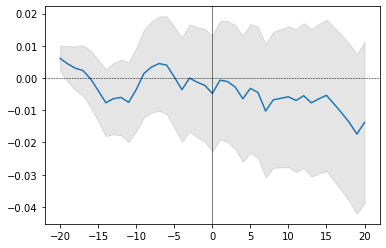

AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-20  0.006        0.003  0.006 **         0.003   1.988    0.047
-19 -0.002        0.003     0.004         0.004   1.015    0.310
-18 -0.001        0.003     0.003         0.005   0.574    0.566
-17 -0.001        0.003     0.002         0.006   0.379    0.705
-16 -0.003        0.003      -0.0         0.007  -0.035    0.972
-15 -0.004        0.003    -0.004         0.007  -0.521    0.602
-14 -0.004        0.003    -0.008         0.008  -0.947    0.344
-13  0.001        0.003    -0.006         0.009  -0.740    0.460
-12  0.000        0.003    -0.006         0.009  -0.656    0.512
-11 -0.002        0.003    -0.008         0.010  -0.779    0.436
-10  0.004        0.003    -0.004         0.010  -0.351    0.726
-9   0.005        0.003     0.001         0.011   0.132    0.895
-8   0.002        0.003     0.003         0.011   0.308    0.758
-7   0.001        0.003     0.004         0.011   0.392    0.695
-6  -0.000        0.003     0.004         0.012   0.337    0.736
-5  -0.004        0.003       0.0         0.012   0.027    0.979
-4  -0.004        0.003    -0.004         0.013  -0.286    0.775
-3   0.004        0.003      -0.0         0.013  -0.000    1.000
-2  -0.001        0.003    -0.001         0.013  -0.096    0.923
-1  -0.001        0.003    -0.002         0.014  -0.165    0.869
0   -0.003        0.003    -0.005         0.014  -0.342    0.733
1    0.004        0.003    -0.001         0.014  -0.046    0.964
2   -0.000        0.003    -0.001         0.015  -0.075    0.940
3   -0.002        0.003    -0.003         0.015  -0.185    0.853
4   -0.004        0.003    -0.006         0.015  -0.420    0.675
5    0.003        0.003    -0.003         0.016  -0.206    0.837
6   -0.001        0.003    -0.004         0.016  -0.283    0.778
7   -0.006        0.003     -0.01         0.016  -0.633    0.527
8    0.003        0.003    -0.007         0.016  -0.410    0.681
9    0.000        0.003    -0.006         0.017  -0.376    0.707
10   0.000        0.003    -0.006         0.017  -0.342    0.732
11  -0.001        0.003    -0.007         0.017  -0.403    0.687
12   0.001        0.003    -0.005         0.018  -0.312    0.755
13  -0.002        0.003    -0.008         0.018  -0.431    0.666
14   0.001        0.003    -0.006         0.018  -0.357    0.721
15   0.001        0.003    -0.005         0.018  -0.292    0.770
16  -0.003        0.003    -0.008         0.019  -0.434    0.664
17  -0.003        0.003    -0.011         0.019  -0.574    0.566
18  -0.003        0.003    -0.014         0.019  -0.722    0.470
19  -0.004        0.003    -0.017         0.019  -0.898    0.369
20   0.004        0.003    -0.014         0.020  -0.703    0.482

Mean  Variance  Kurtosis  Skewness    Min  Quantile 25%  Quantile 50%  \
-20  0.006     0.001    15.079     2.739 -0.078        -0.008         0.003   
-19  0.004     0.001     2.314     0.800 -0.085        -0.015         0.004   
-18  0.003     0.002     2.444     0.188 -0.164        -0.020         0.001   
-17  0.002     0.003     3.628    -0.208 -0.230        -0.025         0.001   
-16 -0.000     0.004     5.940    -0.010 -0.310        -0.032         0.004   
-15 -0.004     0.006    19.036    -2.083 -0.557        -0.036         0.003   
-14 -0.008     0.010    36.993    -4.204 -0.859        -0.040        -0.005   
-13 -0.006     0.012    38.992    -4.841 -0.944        -0.040         0.002   
-12 -0.006     0.016    37.458    -4.843 -1.061        -0.037        -0.004   
-11 -0.008     0.019    43.097    -5.106 -1.191        -0.041         0.001   
-10 -0.004     0.009     7.456     0.342 -0.437        -0.045        -0.004   
-9   0.001     0.010     6.490     0.407 -0.408        -0.044         0.008   
-8   0.003     0.011     9.238     0.766 -0.405        -0.049         0.003   
-7   0.004     0.013     9.463     1.148 -0.371        -0.057        -0.003   
-6   0.004     0.013     5.972     0.411 -0.437        -0.047         0.003   
-5   0.000     0.014     8.907    -0.686 -0.639        -0.048         0.004   
-4  -0.004     0.018     9.631    -0.687 -0.733        -0.050         0.000   
-3  -0.000     0.021    11.797    -0.879 -0.850        -0.052         0.004   
-2  -0.001     0.026    13.554    -1.189 -0.983        -0.056         0.008   
-1  -0.002     0.019     8.583     0.659 -0.603        -0.053         0.002   
0   -0.005     0.018     9.318     0.493 -0.598        -0.058         0.001   
1   -0.001     0.022    12.281     0.469 -0.698        -0.059         0.004   
2   -0.001     0.027    12.852     0.682 -0.788        -0.063        -0.002   
3   -0.003     0.033    13.156     0.247 -0.905        -0.066         0.004   
4   -0.006     0.036    13.072    -0.198 -1.038        -0.069         0.001   
5   -0.003     0.026    11.123     1.594 -0.515        -0.074         0.002   
6   -0.004     0.028    11.286     1.725 -0.485        -0.083         0.005   
7   -0.010     0.032     9.646     1.425 -0.582        -0.095        -0.003   
8   -0.007     0.035     8.860     1.641 -0.544        -0.097         0.000   
9   -0.006     0.032     6.591     1.095 -0.573        -0.090        -0.003   
10  -0.006     0.032     7.791     1.272 -0.623        -0.087        -0.004   
11  -0.007     0.034     9.378     1.317 -0.725        -0.085        -0.005   
12  -0.005     0.039    10.160     1.434 -0.775        -0.091        -0.001   
13  -0.008     0.044     9.545     1.337 -0.774        -0.099        -0.013   
14  -0.006     0.044    10.133     1.331 -0.806        -0.107        -0.002   
15  -0.005     0.044     9.142     1.054 -0.834        -0.104        -0.012   
16  -0.008     0.046    10.345     0.850 -0.994        -0.108        -0.010   
17  -0.011     0.051    10.487     0.881 -1.056        -0.105         0.005   
18  -0.014     0.056     9.608     1.117 -0.989        -0.115        -0.003   
19  -0.017     0.056     8.820     1.291 -0.825        -0.131        -0.009   
20  -0.014     0.057    10.197     1.783 -0.646        -0.122        -0.006   

     Quantile 75%    Max  
-20         0.014  0.238  
-19         0.021  0.143  
-18         0.023  0.154  
-17         0.023  0.190  
-16         0.023  0.289  
-15         0.029  0.310  
-14         0.038  0.317  
-13         0.039  0.241  
-12         0.043  0.254  
-11         0.044  0.380  
-10         0.044  0.500  
-9          0.046  0.521  
-8          0.049  0.606  
-7          0.050  0.678  
-6          0.055  0.581  
-5          0.055  0.556  
-4          0.054  0.648  
-3          0.055  0.660  
-2          0.057  0.754  
-1          0.049  0.745  
0           0.048  0.746  
1           0.058  0.874  
2           0.055  0.976  
3           0.063  1.059  
4           

In [72]:
for ticker, event in releases_20_200.items():
    print(ticker)
    event.plot()
    plt.show()
    display(event.results())
    display(event.get_CAR_dist())